In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
a = []
data = pd.read_csv("greatlakedata/clair1918.csv", header = 2, index_col = 0) #read data
data = data.drop([2021, 2022]) #drop years with nan values
a.append(data.unstack().values) #unstack 2d data into one long 1d list
data = pd.read_csv("greatlakedata/erie1918.csv", header = 2, index_col = 0) #read data
data = data.drop([2021, 2022]) #drop years with nan values
a.append(data.unstack().values) #unstack 2d data into one long 1d list
data = pd.read_csv("greatlakedata/miHuron1918.csv", header = 2, index_col = 0) #read data
data = data.drop([2021, 2022]) #drop years with nan values
a.append(data.unstack().values) #unstack 2d data into one long 1d list
data = pd.read_csv("greatlakedata/ontario1918.csv", header = 2, index_col = 0) #read data
data = data.drop([2021, 2022]) #drop years with nan values
a.append(data.unstack().values) #unstack 2d data into one long 1d list
data = pd.read_csv("greatlakedata/superior1918.csv", header = 2, index_col = 0) #read data
data = data.drop([2021, 2022]) #drop years with nan values
a.append(data.unstack().values) #unstack 2d data into one long 1d list
for j in range(len(a)):
    data_average = np.mean(a[j]) #standardization
    data_deviation = np.std(a[j])
    for i in range(len(a[j])):
        a[j][i] -= data_average
        a[j][i] /= data_deviation
from statsmodels.tsa.seasonal import seasonal_decompose
for j in range(len(a)):
    result = seasonal_decompose(a[j], model='additive', period = 100) 
    result.trend[np.logical_not(np.isnan(result.trend))]
    a[j] = result.trend[np.logical_not(np.isnan(result.trend))]
len(a[0])

1136

In [2]:
for i in range(len(a)):
    a[i] = a[i][np.logical_not(np.isnan(a[i]))]
    print(len(a[i]))

1136
1136
1136
1136
1136


In [3]:
from sklearn.model_selection import train_test_split
x_train, y_train, x_test, y_test = [], [], [], []
for j in range(len(a)):
    x = []
    y = []
    for i in range(len(a[j])-24):
        x.append(a[j][i:i+24])
        y.append(a[j][i+24])
    x1, x2, y1, y2 = train_test_split(x, y, test_size = 0.3, shuffle = False, random_state = 39)
    x_train.append(x1)
    x_test.append(x2)
    y_train.append(y1)
    y_test.append(y2)

In [21]:
from torch.utils.data import DataLoader,Dataset
class Pd(Dataset):
    def __init__(self, x, y):
        self.input = x
        self.target = y
    def __getitem__(self, index):
        inputs = self.input[index]
        target = self.target[index]
        return inputs, target
    def __len__(self):
        return len(self.input)
    
import torch as tr
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = 128, #number of features coming out of the LSTM layer
            num_layers = 1, #number of LSTM layers
            #batch_first = True,
        )
        self.out = nn.Sequential(
            nn.Dropout(0.5),
            
            nn.Linear(128, 32),
            nn.BatchNorm1d(1),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(32, 1),
        )
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None) #initial h and c is 0
        out = self.out(r_out)
        return out

model = RNN(24)
model_run = RNN(24)
model_best = RNN(24)
tr.save(model.state_dict(), "meta_init")
loss_function = nn.MSELoss()
op = tr.optim.Adam(model.parameters(), lr=0.0001)
model

RNN(
  (rnn): LSTM(24, 128)
  (out): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=128, out_features=32, bias=True)
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [75]:
def run_meta(train_dataset, train_dataLoader, test_dataset, test_dataLoader, model, model_run, index):
    lowest = 100
    timer = 20
    i = 0
    run = True
    while run == True:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(i, loss_train, loss_test), "Lake:", index)
        if loss_test < lowest:
            timer = 20
            lowest = loss_test
            model_run = model
        else:
            timer -= 1
        if timer == 0:
            run = False
        i += 1
    return model_run
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
exc = 0
all_loss_train, all_loss_test, last_pred, last_y = [], [], [], []
altr, alte, lp, ly = [], [], [], []
lowest, l_loss = 100, 100
opt = ()
for j in range(5):
    for k in range(5):
        for l in range(5):
            for m in range(5):
                if j == k or j == l or j == m or k == l or k == m or l == m or j == exc or k == exc or l == exc or m == exc:
                    continue
                model.load_state_dict(tr.load('meta_init'))
                device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
                model = model.to(device)
                print(j, k, l, m)
                train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, j)
                model = run_meta(train_dataset, train_dataLoader, test_dataset, test_dataLoader, model, model_run, j)
                train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, k)
                model = run_meta(train_dataset, train_dataLoader, test_dataset, test_dataLoader, model, model_run, k)
                train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, l)
                model = run_meta(train_dataset, train_dataLoader, test_dataset, test_dataLoader, model, model_run, l)
                train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, m)
                model = run_meta(train_dataset, train_dataLoader, test_dataset, test_dataLoader, model, model_run, m)
                train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, exc)
                all_loss_train = []
                all_loss_test = []
                lowest = 100
                timer = 20
                i = 0
                run = True
                last_pred = []
                last_y = []
                while run == True:
                    model.train()
                    #if i > 50:
                        #op = op_2
                    for index_train, data in enumerate(train_dataLoader):
                        x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
                        y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
                        op.zero_grad()
                        pred = model(x)
                        loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
                        loss_train.backward()
                        op.step()
                    model.eval()
                    temp_y = []
                    temp_pred = []
                    for index_test, data in enumerate(test_dataLoader):
                        x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
                        y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
                        op.zero_grad()
                        pred = model(x)
                        #if i%20 == 0:
                            #print(tr.squeeze(pred))
                        temp_y.append(tr.squeeze(y).tolist())
                        temp_pred.append(tr.squeeze(pred).tolist())
                        loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
                        op.step()
                    print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(i, loss_train, loss_test))
                    all_loss_train.append(loss_train.detach())
                    all_loss_test.append(loss_test.detach())
                    if loss_test < lowest:
                        timer = 20
                        lowest = loss_test
                        last_y = temp_y
                        last_pred = temp_pred
                        model_run = model
                    else:
                        timer -= 1
                    if timer == 0:
                        run = False
                    i += 1
                if lowest < l_loss:
                    l_loss = lowest
                    model_best = model_run
                    altr, alte, lp, ly = all_loss_train, all_loss_test, last_pred, last_y
                    opt = (j,k,l,m)
                lowest = 100
                all_loss_train, all_loss_test, last_pred, last_y = [], [], [], []

1 2 3 4
Epoch 0, Loss Train: 0.415219, Loss Test: 0.136183 Lake: 1
Epoch 1, Loss Train: 0.184874, Loss Test: 0.068864 Lake: 1
Epoch 2, Loss Train: 0.224744, Loss Test: 0.030364 Lake: 1
Epoch 3, Loss Train: 0.131384, Loss Test: 0.023969 Lake: 1
Epoch 4, Loss Train: 0.090471, Loss Test: 0.020146 Lake: 1
Epoch 5, Loss Train: 0.132516, Loss Test: 0.016920 Lake: 1


KeyboardInterrupt: 

In [9]:
tr.save(model_best, 'clair_meta.pt')
np.save('clair_meta_y', np.asarray(ly, dtype = object))
np.save('clair_meta_pred', np.asarray(lp, dtype = object))
np.save('clair_meta_train', np.asarray(altr))
np.save('clair_meta_test', np.asarray(alte))
np.save('clair_opt', np.asarray(opt))

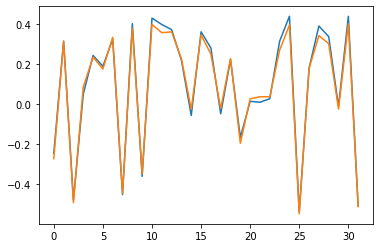

In [5]:
plt.plot(ly[0])
plt.plot(lp[0])

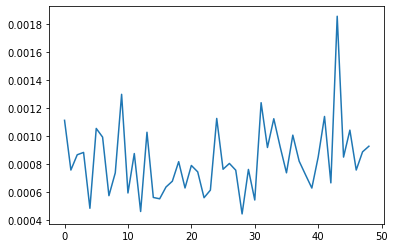

In [6]:
plt.plot(alte)

In [7]:
alte[28]

tensor(0.0004)

In [23]:
mi = np.load('Huron/miHuron_meta_test.npy')
clair = np.load('Clair/clair_meta_test.npy')
erie = np.load('Erie/erie_meta_test.npy')
ont = np.load('Ontario/ontario_meta_test.npy')
sup = np.load('Superior/superior_meta_test.npy')
mi1 = np.load('Huron/miHuron_lstm_test.npy')
clair1 = np.load('Clair/clair_lstm_test.npy')
erie1 = np.load('Erie/erie_lstm_test.npy')
ont1 = np.load('Ontario/ontario_lstm_test.npy')
sup1 = np.load('Superior/superior_lstm_test.npy')
print(len(mi-19), len(clair-19), len(erie-19), len(ont-19), len(sup-19))
print(len(mi1-19), len(clair1-19), len(erie1-19), len(ont1-19), len(sup1-19))


28 49 43 21 51
127 151 144 90 188


In [27]:
asasf = np.load('Superior/superior_opt.npy')
j = asasf[0]
k = asasf[1]
l = asasf[2]
m = asasf[3]
def run_meta(train_dataset, train_dataLoader, test_dataset, test_dataLoader, model, model_run, index):
    lowest = 100
    timer = 20
    i = 0
    run = True
    while run == True:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(i, loss_train, loss_test), "Lake:", index)
        if loss_test < lowest:
            timer = 20
            lowest = loss_test
            model_run = model
        else:
            timer -= 1
        if timer == 0:
            run = False
        i += 1
    return model_run
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader

model.load_state_dict(tr.load('meta_init'))
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
model = model.to(device)
print(j, k, l, m)
exc = 0
train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, j)
model = run_meta(train_dataset, train_dataLoader, test_dataset, test_dataLoader, model, model_run, j)
train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, k)
model = run_meta(train_dataset, train_dataLoader, test_dataset, test_dataLoader, model, model_run, k)
train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, l)
model = run_meta(train_dataset, train_dataLoader, test_dataset, test_dataLoader, model, model_run, l)
train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, m)
model = run_meta(train_dataset, train_dataLoader, test_dataset, test_dataLoader, model, model_run, m)
tr.save(model, 'sens_superior.pt')

2 3 0 1
Epoch 0, Loss Train: 0.096980, Loss Test: 0.057209 Lake: 2
Epoch 1, Loss Train: 0.117661, Loss Test: 0.028163 Lake: 2
Epoch 2, Loss Train: 0.105969, Loss Test: 0.013914 Lake: 2
Epoch 3, Loss Train: 0.045103, Loss Test: 0.012542 Lake: 2
Epoch 4, Loss Train: 0.067172, Loss Test: 0.011569 Lake: 2
Epoch 5, Loss Train: 0.025597, Loss Test: 0.010902 Lake: 2
Epoch 6, Loss Train: 0.030462, Loss Test: 0.010173 Lake: 2
Epoch 7, Loss Train: 0.040495, Loss Test: 0.008355 Lake: 2
Epoch 8, Loss Train: 0.007147, Loss Test: 0.007474 Lake: 2
Epoch 9, Loss Train: 0.041741, Loss Test: 0.006902 Lake: 2
Epoch 10, Loss Train: 0.048205, Loss Test: 0.007052 Lake: 2
Epoch 11, Loss Train: 0.016158, Loss Test: 0.007180 Lake: 2
Epoch 12, Loss Train: 0.017811, Loss Test: 0.007356 Lake: 2
Epoch 13, Loss Train: 0.036040, Loss Test: 0.006983 Lake: 2
Epoch 14, Loss Train: 0.023766, Loss Test: 0.008301 Lake: 2
Epoch 15, Loss Train: 0.011470, Loss Test: 0.006827 Lake: 2
Epoch 16, Loss Train: 0.030857, Loss Test:

Epoch 6, Loss Train: 0.034682, Loss Test: 0.004433 Lake: 3
Epoch 7, Loss Train: 0.047019, Loss Test: 0.003409 Lake: 3
Epoch 8, Loss Train: 0.011114, Loss Test: 0.003197 Lake: 3
Epoch 9, Loss Train: 0.045763, Loss Test: 0.003998 Lake: 3
Epoch 10, Loss Train: 0.061706, Loss Test: 0.006552 Lake: 3
Epoch 11, Loss Train: 0.027362, Loss Test: 0.003508 Lake: 3
Epoch 12, Loss Train: 0.022404, Loss Test: 0.004738 Lake: 3
Epoch 13, Loss Train: 0.020300, Loss Test: 0.003811 Lake: 3
Epoch 14, Loss Train: 0.022334, Loss Test: 0.004142 Lake: 3
Epoch 15, Loss Train: 0.016504, Loss Test: 0.002889 Lake: 3
Epoch 16, Loss Train: 0.028842, Loss Test: 0.003177 Lake: 3
Epoch 17, Loss Train: 0.024166, Loss Test: 0.002584 Lake: 3
Epoch 18, Loss Train: 0.039520, Loss Test: 0.002999 Lake: 3
Epoch 19, Loss Train: 0.059325, Loss Test: 0.004595 Lake: 3
Epoch 20, Loss Train: 0.014001, Loss Test: 0.003682 Lake: 3
Epoch 21, Loss Train: 0.011961, Loss Test: 0.004090 Lake: 3
Epoch 22, Loss Train: 0.030032, Loss Test: 0

Epoch 5, Loss Train: 0.004806, Loss Test: 0.001058 Lake: 1
Epoch 6, Loss Train: 0.005379, Loss Test: 0.001715 Lake: 1
Epoch 7, Loss Train: 0.008626, Loss Test: 0.000764 Lake: 1
Epoch 8, Loss Train: 0.025167, Loss Test: 0.001285 Lake: 1
Epoch 9, Loss Train: 0.010206, Loss Test: 0.001221 Lake: 1
Epoch 10, Loss Train: 0.017720, Loss Test: 0.002345 Lake: 1
Epoch 11, Loss Train: 0.005421, Loss Test: 0.001677 Lake: 1
Epoch 12, Loss Train: 0.005387, Loss Test: 0.001206 Lake: 1
Epoch 13, Loss Train: 0.004081, Loss Test: 0.000744 Lake: 1
Epoch 14, Loss Train: 0.004253, Loss Test: 0.002004 Lake: 1
Epoch 15, Loss Train: 0.011203, Loss Test: 0.000839 Lake: 1
Epoch 16, Loss Train: 0.011192, Loss Test: 0.001431 Lake: 1
Epoch 17, Loss Train: 0.016759, Loss Test: 0.000890 Lake: 1
Epoch 18, Loss Train: 0.017678, Loss Test: 0.001589 Lake: 1
Epoch 19, Loss Train: 0.006550, Loss Test: 0.001043 Lake: 1
Epoch 20, Loss Train: 0.010785, Loss Test: 0.001493 Lake: 1
Epoch 21, Loss Train: 0.012466, Loss Test: 0.

In [5]:
k = 0
l = 0
for i in np.arange(0.0001, 0.00101, 0.00005):
    print(i)
    k += 1
for j in range(24, 49):
    print(j)
    l += 1
print(k, l)

0.0001
0.00015000000000000001
0.00020000000000000004
0.00025
0.00030000000000000003
0.00035000000000000005
0.0004
0.00045000000000000004
0.0005000000000000001
0.0005500000000000001
0.0006000000000000002
0.0006500000000000002
0.0007000000000000001
0.0007500000000000001
0.0008000000000000001
0.0008500000000000002
0.0009000000000000002
0.0009500000000000002
0.0010000000000000002
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
19 25


In [11]:
model = tr.load("Superior/sens_superior.pt")
tr.save(model.state_dict(), "sens_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")

In [12]:
def init_data(x_train, y_train, x_test, y_test, index, batch):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = batch, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = batch, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader

loss_sens = np.zeros((19, 25))
#loss_sens = np.load('loss_sens_mihuron.npy')
m = 0
n = 0
for j in np.arange(0.0001, 0.00101, 0.00005):
    n = 0
    for k in range(24, 49):
        model.load_state_dict(tr.load('sens_init'))
        lowest_loss = 0
        train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 0, k)
        op = tr.optim.Adam(model.parameters(), lr=j)
        lowest = 100
        timer = 20
        i = 0
        run = True
        while run == True:
            model.train()
            #if i > 50:
                #op = op_2
            for index_train, data in enumerate(train_dataLoader):
                x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
                y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
                op.zero_grad()
                pred = model(x)
                loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
                loss_train.backward()
                op.step()
            model.eval()
            for index_test, data in enumerate(test_dataLoader):
                x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
                y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
                op.zero_grad()
                pred = model(x)
                #if i%20 == 0:
                    #print(tr.squeeze(pred))
                loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
                op.step()
            print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(i, loss_train, loss_test))
            if loss_test < lowest:
                timer = 20
                lowest = loss_test
            else:
                timer -= 1
            if timer == 0:
                run = False
            i += 1
        loss_sens[m][n] = lowest.detach()
        np.save("loss_sens_superior", loss_sens)
        n += 1
    m += 1

Epoch 0, Loss Train: 0.005142, Loss Test: 0.001557
Epoch 1, Loss Train: 0.006765, Loss Test: 0.000948
Epoch 2, Loss Train: 0.008575, Loss Test: 0.000842
Epoch 3, Loss Train: 0.007416, Loss Test: 0.001317
Epoch 4, Loss Train: 0.003865, Loss Test: 0.000930
Epoch 5, Loss Train: 0.003614, Loss Test: 0.001349
Epoch 6, Loss Train: 0.016691, Loss Test: 0.001160
Epoch 7, Loss Train: 0.004211, Loss Test: 0.001344
Epoch 8, Loss Train: 0.006794, Loss Test: 0.001032
Epoch 9, Loss Train: 0.009218, Loss Test: 0.001205
Epoch 10, Loss Train: 0.006468, Loss Test: 0.001202
Epoch 11, Loss Train: 0.008248, Loss Test: 0.001016
Epoch 12, Loss Train: 0.018008, Loss Test: 0.001509
Epoch 13, Loss Train: 0.004614, Loss Test: 0.001715
Epoch 14, Loss Train: 0.008584, Loss Test: 0.000974
Epoch 15, Loss Train: 0.007088, Loss Test: 0.001424
Epoch 16, Loss Train: 0.006024, Loss Test: 0.000796
Epoch 17, Loss Train: 0.009353, Loss Test: 0.001478
Epoch 18, Loss Train: 0.006439, Loss Test: 0.001119
Epoch 19, Loss Train: 

Epoch 12, Loss Train: 0.008515, Loss Test: 0.001743
Epoch 13, Loss Train: 0.006263, Loss Test: 0.000931
Epoch 14, Loss Train: 0.011232, Loss Test: 0.001287
Epoch 15, Loss Train: 0.010693, Loss Test: 0.000845
Epoch 16, Loss Train: 0.008885, Loss Test: 0.001275
Epoch 17, Loss Train: 0.008459, Loss Test: 0.000847
Epoch 18, Loss Train: 0.007378, Loss Test: 0.001751
Epoch 19, Loss Train: 0.003963, Loss Test: 0.000985
Epoch 20, Loss Train: 0.020470, Loss Test: 0.000827
Epoch 21, Loss Train: 0.010420, Loss Test: 0.000513
Epoch 22, Loss Train: 0.007032, Loss Test: 0.001025
Epoch 23, Loss Train: 0.007956, Loss Test: 0.000678
Epoch 24, Loss Train: 0.009248, Loss Test: 0.001777
Epoch 25, Loss Train: 0.010631, Loss Test: 0.000593
Epoch 26, Loss Train: 0.009909, Loss Test: 0.001184
Epoch 27, Loss Train: 0.004914, Loss Test: 0.000576
Epoch 28, Loss Train: 0.008760, Loss Test: 0.000850
Epoch 29, Loss Train: 0.009913, Loss Test: 0.000915
Epoch 30, Loss Train: 0.012707, Loss Test: 0.001760
Epoch 31, Lo

Epoch 28, Loss Train: 0.006790, Loss Test: 0.001509
Epoch 29, Loss Train: 0.007544, Loss Test: 0.000966
Epoch 30, Loss Train: 0.018849, Loss Test: 0.000746
Epoch 31, Loss Train: 0.013048, Loss Test: 0.001566
Epoch 32, Loss Train: 0.005999, Loss Test: 0.000979
Epoch 33, Loss Train: 0.011621, Loss Test: 0.000771
Epoch 34, Loss Train: 0.007422, Loss Test: 0.001723
Epoch 35, Loss Train: 0.004580, Loss Test: 0.002047
Epoch 36, Loss Train: 0.008348, Loss Test: 0.000943
Epoch 37, Loss Train: 0.010743, Loss Test: 0.000689
Epoch 38, Loss Train: 0.017706, Loss Test: 0.001164
Epoch 0, Loss Train: 0.010928, Loss Test: 0.000988
Epoch 1, Loss Train: 0.009908, Loss Test: 0.001264
Epoch 2, Loss Train: 0.006860, Loss Test: 0.001045
Epoch 3, Loss Train: 0.007578, Loss Test: 0.000668
Epoch 4, Loss Train: 0.007302, Loss Test: 0.001111
Epoch 5, Loss Train: 0.013679, Loss Test: 0.000745
Epoch 6, Loss Train: 0.011736, Loss Test: 0.001100
Epoch 7, Loss Train: 0.006207, Loss Test: 0.000830
Epoch 8, Loss Train:

Epoch 3, Loss Train: 0.011067, Loss Test: 0.001300
Epoch 4, Loss Train: 0.005252, Loss Test: 0.001356
Epoch 5, Loss Train: 0.007060, Loss Test: 0.001178
Epoch 6, Loss Train: 0.007086, Loss Test: 0.001551
Epoch 7, Loss Train: 0.006722, Loss Test: 0.000759
Epoch 8, Loss Train: 0.009206, Loss Test: 0.000818
Epoch 9, Loss Train: 0.005633, Loss Test: 0.001025
Epoch 10, Loss Train: 0.011780, Loss Test: 0.001403
Epoch 11, Loss Train: 0.008025, Loss Test: 0.000895
Epoch 12, Loss Train: 0.009998, Loss Test: 0.000847
Epoch 13, Loss Train: 0.007477, Loss Test: 0.001162
Epoch 14, Loss Train: 0.007657, Loss Test: 0.001039
Epoch 15, Loss Train: 0.008669, Loss Test: 0.001088
Epoch 16, Loss Train: 0.013681, Loss Test: 0.000998
Epoch 17, Loss Train: 0.005226, Loss Test: 0.001325
Epoch 18, Loss Train: 0.008118, Loss Test: 0.001305
Epoch 19, Loss Train: 0.010270, Loss Test: 0.001294
Epoch 20, Loss Train: 0.008219, Loss Test: 0.000720
Epoch 21, Loss Train: 0.004062, Loss Test: 0.001036
Epoch 22, Loss Trai

Epoch 43, Loss Train: 0.013841, Loss Test: 0.000992
Epoch 44, Loss Train: 0.005533, Loss Test: 0.000797
Epoch 45, Loss Train: 0.010745, Loss Test: 0.000717
Epoch 46, Loss Train: 0.007516, Loss Test: 0.001212
Epoch 47, Loss Train: 0.008024, Loss Test: 0.000677
Epoch 48, Loss Train: 0.008901, Loss Test: 0.001035
Epoch 49, Loss Train: 0.003195, Loss Test: 0.001003
Epoch 50, Loss Train: 0.010242, Loss Test: 0.000755
Epoch 51, Loss Train: 0.014166, Loss Test: 0.000800
Epoch 52, Loss Train: 0.017737, Loss Test: 0.000812
Epoch 53, Loss Train: 0.006318, Loss Test: 0.000847
Epoch 54, Loss Train: 0.009307, Loss Test: 0.000896
Epoch 55, Loss Train: 0.016345, Loss Test: 0.000541
Epoch 56, Loss Train: 0.007249, Loss Test: 0.000990
Epoch 57, Loss Train: 0.005700, Loss Test: 0.000916
Epoch 58, Loss Train: 0.013445, Loss Test: 0.001389
Epoch 59, Loss Train: 0.004903, Loss Test: 0.000821
Epoch 60, Loss Train: 0.006732, Loss Test: 0.000687
Epoch 61, Loss Train: 0.018530, Loss Test: 0.001068
Epoch 62, Lo

Epoch 4, Loss Train: 0.009232, Loss Test: 0.000910
Epoch 5, Loss Train: 0.006154, Loss Test: 0.000644
Epoch 6, Loss Train: 0.005243, Loss Test: 0.000688
Epoch 7, Loss Train: 0.007101, Loss Test: 0.000676
Epoch 8, Loss Train: 0.007565, Loss Test: 0.000750
Epoch 9, Loss Train: 0.009635, Loss Test: 0.000480
Epoch 10, Loss Train: 0.008738, Loss Test: 0.000801
Epoch 11, Loss Train: 0.008112, Loss Test: 0.000907
Epoch 12, Loss Train: 0.010921, Loss Test: 0.000588
Epoch 13, Loss Train: 0.007889, Loss Test: 0.001361
Epoch 14, Loss Train: 0.007308, Loss Test: 0.000489
Epoch 15, Loss Train: 0.016230, Loss Test: 0.000664
Epoch 16, Loss Train: 0.008088, Loss Test: 0.000853
Epoch 17, Loss Train: 0.006668, Loss Test: 0.001429
Epoch 18, Loss Train: 0.009177, Loss Test: 0.001026
Epoch 19, Loss Train: 0.011445, Loss Test: 0.000806
Epoch 20, Loss Train: 0.012875, Loss Test: 0.000677
Epoch 21, Loss Train: 0.004082, Loss Test: 0.001219
Epoch 22, Loss Train: 0.007751, Loss Test: 0.000813
Epoch 23, Loss Tra

Epoch 6, Loss Train: 0.003826, Loss Test: 0.001045
Epoch 7, Loss Train: 0.005366, Loss Test: 0.000536
Epoch 8, Loss Train: 0.012087, Loss Test: 0.001291
Epoch 9, Loss Train: 0.010790, Loss Test: 0.000462
Epoch 10, Loss Train: 0.002982, Loss Test: 0.001001
Epoch 11, Loss Train: 0.022058, Loss Test: 0.000602
Epoch 12, Loss Train: 0.010307, Loss Test: 0.001728
Epoch 13, Loss Train: 0.006327, Loss Test: 0.000517
Epoch 14, Loss Train: 0.005922, Loss Test: 0.001875
Epoch 15, Loss Train: 0.000702, Loss Test: 0.000540
Epoch 16, Loss Train: 0.015132, Loss Test: 0.000802
Epoch 17, Loss Train: 0.056360, Loss Test: 0.000799
Epoch 18, Loss Train: 0.020612, Loss Test: 0.000994
Epoch 19, Loss Train: 0.005008, Loss Test: 0.001761
Epoch 20, Loss Train: 0.002222, Loss Test: 0.000566
Epoch 21, Loss Train: 0.013671, Loss Test: 0.000809
Epoch 22, Loss Train: 0.011170, Loss Test: 0.001158
Epoch 23, Loss Train: 0.009455, Loss Test: 0.000487
Epoch 24, Loss Train: 0.003435, Loss Test: 0.002060
Epoch 0, Loss Tr

Epoch 18, Loss Train: 0.005509, Loss Test: 0.000957
Epoch 19, Loss Train: 0.004258, Loss Test: 0.000754
Epoch 20, Loss Train: 0.004624, Loss Test: 0.000820
Epoch 21, Loss Train: 0.009260, Loss Test: 0.001517
Epoch 22, Loss Train: 0.008490, Loss Test: 0.002339
Epoch 23, Loss Train: 0.002657, Loss Test: 0.000670
Epoch 24, Loss Train: 0.010712, Loss Test: 0.001127
Epoch 25, Loss Train: 0.014625, Loss Test: 0.000475
Epoch 26, Loss Train: 0.009412, Loss Test: 0.000718
Epoch 27, Loss Train: 0.007129, Loss Test: 0.001720
Epoch 28, Loss Train: 0.010340, Loss Test: 0.001583
Epoch 29, Loss Train: 0.007548, Loss Test: 0.000796
Epoch 30, Loss Train: 0.009393, Loss Test: 0.000885
Epoch 31, Loss Train: 0.012276, Loss Test: 0.000805
Epoch 32, Loss Train: 0.020150, Loss Test: 0.001002
Epoch 33, Loss Train: 0.009087, Loss Test: 0.000960
Epoch 34, Loss Train: 0.010215, Loss Test: 0.001164
Epoch 35, Loss Train: 0.006983, Loss Test: 0.001146
Epoch 36, Loss Train: 0.004520, Loss Test: 0.000561
Epoch 37, Lo

Epoch 15, Loss Train: 0.009565, Loss Test: 0.001300
Epoch 16, Loss Train: 0.006484, Loss Test: 0.001221
Epoch 17, Loss Train: 0.002902, Loss Test: 0.001096
Epoch 18, Loss Train: 0.006626, Loss Test: 0.001653
Epoch 19, Loss Train: 0.007574, Loss Test: 0.000538
Epoch 20, Loss Train: 0.018475, Loss Test: 0.001288
Epoch 21, Loss Train: 0.007080, Loss Test: 0.000950
Epoch 22, Loss Train: 0.008951, Loss Test: 0.000685
Epoch 23, Loss Train: 0.009878, Loss Test: 0.001020
Epoch 24, Loss Train: 0.004681, Loss Test: 0.000890
Epoch 25, Loss Train: 0.012177, Loss Test: 0.000752
Epoch 26, Loss Train: 0.004771, Loss Test: 0.001269
Epoch 27, Loss Train: 0.023696, Loss Test: 0.001681
Epoch 28, Loss Train: 0.006005, Loss Test: 0.001000
Epoch 29, Loss Train: 0.004973, Loss Test: 0.000886
Epoch 0, Loss Train: 0.009246, Loss Test: 0.001033
Epoch 1, Loss Train: 0.005458, Loss Test: 0.000935
Epoch 2, Loss Train: 0.005346, Loss Test: 0.000652
Epoch 3, Loss Train: 0.006976, Loss Test: 0.000997
Epoch 4, Loss Tr

Epoch 21, Loss Train: 0.003339, Loss Test: 0.001148
Epoch 22, Loss Train: 0.008688, Loss Test: 0.001815
Epoch 23, Loss Train: 0.010182, Loss Test: 0.001222
Epoch 24, Loss Train: 0.009559, Loss Test: 0.000819
Epoch 25, Loss Train: 0.015609, Loss Test: 0.000710
Epoch 26, Loss Train: 0.004813, Loss Test: 0.000741
Epoch 27, Loss Train: 0.007927, Loss Test: 0.001922
Epoch 28, Loss Train: 0.014831, Loss Test: 0.000817
Epoch 29, Loss Train: 0.009193, Loss Test: 0.001665
Epoch 30, Loss Train: 0.009609, Loss Test: 0.000939
Epoch 31, Loss Train: 0.005707, Loss Test: 0.001686
Epoch 32, Loss Train: 0.005360, Loss Test: 0.001608
Epoch 33, Loss Train: 0.008281, Loss Test: 0.001393
Epoch 34, Loss Train: 0.007844, Loss Test: 0.001046
Epoch 35, Loss Train: 0.004704, Loss Test: 0.001044
Epoch 0, Loss Train: 0.009652, Loss Test: 0.001575
Epoch 1, Loss Train: 0.012395, Loss Test: 0.001486
Epoch 2, Loss Train: 0.006418, Loss Test: 0.001508
Epoch 3, Loss Train: 0.008036, Loss Test: 0.001071
Epoch 4, Loss Tr

Epoch 18, Loss Train: 0.012384, Loss Test: 0.001212
Epoch 19, Loss Train: 0.005512, Loss Test: 0.000702
Epoch 20, Loss Train: 0.005715, Loss Test: 0.001129
Epoch 21, Loss Train: 0.008368, Loss Test: 0.001286
Epoch 22, Loss Train: 0.006052, Loss Test: 0.000828
Epoch 23, Loss Train: 0.008929, Loss Test: 0.001096
Epoch 24, Loss Train: 0.004714, Loss Test: 0.001346
Epoch 25, Loss Train: 0.005562, Loss Test: 0.001178
Epoch 26, Loss Train: 0.005172, Loss Test: 0.000990
Epoch 27, Loss Train: 0.005209, Loss Test: 0.001016
Epoch 28, Loss Train: 0.009143, Loss Test: 0.001130
Epoch 29, Loss Train: 0.013475, Loss Test: 0.000670
Epoch 30, Loss Train: 0.006170, Loss Test: 0.000802
Epoch 31, Loss Train: 0.013784, Loss Test: 0.000708
Epoch 32, Loss Train: 0.007207, Loss Test: 0.001816
Epoch 33, Loss Train: 0.005298, Loss Test: 0.000670
Epoch 0, Loss Train: 0.005159, Loss Test: 0.001909
Epoch 1, Loss Train: 0.023576, Loss Test: 0.001276
Epoch 2, Loss Train: 0.008091, Loss Test: 0.000971
Epoch 3, Loss T

Epoch 12, Loss Train: 0.007877, Loss Test: 0.000839
Epoch 13, Loss Train: 0.010512, Loss Test: 0.000661
Epoch 14, Loss Train: 0.007189, Loss Test: 0.000964
Epoch 15, Loss Train: 0.006789, Loss Test: 0.000712
Epoch 16, Loss Train: 0.011973, Loss Test: 0.001563
Epoch 17, Loss Train: 0.013313, Loss Test: 0.000510
Epoch 18, Loss Train: 0.010312, Loss Test: 0.000744
Epoch 19, Loss Train: 0.010644, Loss Test: 0.000716
Epoch 20, Loss Train: 0.006687, Loss Test: 0.000604
Epoch 21, Loss Train: 0.010901, Loss Test: 0.000877
Epoch 22, Loss Train: 0.013949, Loss Test: 0.001173
Epoch 23, Loss Train: 0.009972, Loss Test: 0.000985
Epoch 24, Loss Train: 0.006376, Loss Test: 0.000697
Epoch 25, Loss Train: 0.010154, Loss Test: 0.001795
Epoch 26, Loss Train: 0.007781, Loss Test: 0.000370
Epoch 27, Loss Train: 0.011585, Loss Test: 0.000803
Epoch 28, Loss Train: 0.006740, Loss Test: 0.001392
Epoch 29, Loss Train: 0.015955, Loss Test: 0.000829
Epoch 30, Loss Train: 0.006981, Loss Test: 0.000709
Epoch 31, Lo

Epoch 5, Loss Train: 0.016854, Loss Test: 0.001662
Epoch 6, Loss Train: 0.006782, Loss Test: 0.001970
Epoch 7, Loss Train: 0.006253, Loss Test: 0.000768
Epoch 8, Loss Train: 0.006984, Loss Test: 0.000918
Epoch 9, Loss Train: 0.014263, Loss Test: 0.001439
Epoch 10, Loss Train: 0.024651, Loss Test: 0.001207
Epoch 11, Loss Train: 0.040090, Loss Test: 0.001425
Epoch 12, Loss Train: 0.002913, Loss Test: 0.000831
Epoch 13, Loss Train: 0.011437, Loss Test: 0.001234
Epoch 14, Loss Train: 0.003917, Loss Test: 0.000608
Epoch 15, Loss Train: 0.002373, Loss Test: 0.000626
Epoch 16, Loss Train: 0.009122, Loss Test: 0.000563
Epoch 17, Loss Train: 0.009599, Loss Test: 0.002184
Epoch 18, Loss Train: 0.014309, Loss Test: 0.001586
Epoch 19, Loss Train: 0.011964, Loss Test: 0.002548
Epoch 20, Loss Train: 0.006839, Loss Test: 0.002114
Epoch 21, Loss Train: 0.025142, Loss Test: 0.001210
Epoch 22, Loss Train: 0.012800, Loss Test: 0.000569
Epoch 23, Loss Train: 0.012912, Loss Test: 0.000561
Epoch 24, Loss Tr

Epoch 34, Loss Train: 0.004332, Loss Test: 0.000870
Epoch 35, Loss Train: 0.008801, Loss Test: 0.000481
Epoch 36, Loss Train: 0.013001, Loss Test: 0.000729
Epoch 0, Loss Train: 0.010151, Loss Test: 0.001324
Epoch 1, Loss Train: 0.012317, Loss Test: 0.001047
Epoch 2, Loss Train: 0.003883, Loss Test: 0.000645
Epoch 3, Loss Train: 0.016405, Loss Test: 0.001692
Epoch 4, Loss Train: 0.012248, Loss Test: 0.000782
Epoch 5, Loss Train: 0.011405, Loss Test: 0.001971
Epoch 6, Loss Train: 0.017386, Loss Test: 0.003157
Epoch 7, Loss Train: 0.016120, Loss Test: 0.000655
Epoch 8, Loss Train: 0.010454, Loss Test: 0.001059
Epoch 9, Loss Train: 0.006497, Loss Test: 0.001292
Epoch 10, Loss Train: 0.007202, Loss Test: 0.001866
Epoch 11, Loss Train: 0.014380, Loss Test: 0.001294
Epoch 12, Loss Train: 0.009102, Loss Test: 0.002962
Epoch 13, Loss Train: 0.011256, Loss Test: 0.001868
Epoch 14, Loss Train: 0.008630, Loss Test: 0.002025
Epoch 15, Loss Train: 0.016428, Loss Test: 0.001440
Epoch 16, Loss Train: 

Epoch 24, Loss Train: 0.007523, Loss Test: 0.000579
Epoch 25, Loss Train: 0.002627, Loss Test: 0.000978
Epoch 26, Loss Train: 0.011080, Loss Test: 0.001049
Epoch 0, Loss Train: 0.010199, Loss Test: 0.001049
Epoch 1, Loss Train: 0.006246, Loss Test: 0.000641
Epoch 2, Loss Train: 0.012663, Loss Test: 0.001373
Epoch 3, Loss Train: 0.008513, Loss Test: 0.002886
Epoch 4, Loss Train: 0.008088, Loss Test: 0.001048
Epoch 5, Loss Train: 0.004284, Loss Test: 0.001644
Epoch 6, Loss Train: 0.002987, Loss Test: 0.000738
Epoch 7, Loss Train: 0.007769, Loss Test: 0.001978
Epoch 8, Loss Train: 0.007343, Loss Test: 0.000852
Epoch 9, Loss Train: 0.007230, Loss Test: 0.001611
Epoch 10, Loss Train: 0.025357, Loss Test: 0.000530
Epoch 11, Loss Train: 0.018253, Loss Test: 0.000498
Epoch 12, Loss Train: 0.002960, Loss Test: 0.000547
Epoch 13, Loss Train: 0.006741, Loss Test: 0.001608
Epoch 14, Loss Train: 0.002332, Loss Test: 0.000729
Epoch 15, Loss Train: 0.006647, Loss Test: 0.000842
Epoch 16, Loss Train: 

Epoch 58, Loss Train: 0.007314, Loss Test: 0.001153
Epoch 59, Loss Train: 0.009791, Loss Test: 0.001218
Epoch 60, Loss Train: 0.010679, Loss Test: 0.000988
Epoch 61, Loss Train: 0.007738, Loss Test: 0.000472
Epoch 62, Loss Train: 0.009762, Loss Test: 0.000914
Epoch 63, Loss Train: 0.013201, Loss Test: 0.000743
Epoch 64, Loss Train: 0.011384, Loss Test: 0.001427
Epoch 65, Loss Train: 0.007697, Loss Test: 0.000693
Epoch 66, Loss Train: 0.010233, Loss Test: 0.000776
Epoch 67, Loss Train: 0.003744, Loss Test: 0.001197
Epoch 68, Loss Train: 0.006780, Loss Test: 0.000563
Epoch 69, Loss Train: 0.008767, Loss Test: 0.000911
Epoch 70, Loss Train: 0.014220, Loss Test: 0.000998
Epoch 71, Loss Train: 0.005875, Loss Test: 0.000606
Epoch 72, Loss Train: 0.009995, Loss Test: 0.000911
Epoch 73, Loss Train: 0.008324, Loss Test: 0.000884
Epoch 74, Loss Train: 0.005704, Loss Test: 0.000618
Epoch 75, Loss Train: 0.004615, Loss Test: 0.001189
Epoch 76, Loss Train: 0.007681, Loss Test: 0.001320
Epoch 77, Lo

Epoch 29, Loss Train: 0.006249, Loss Test: 0.000126
Epoch 30, Loss Train: 0.001674, Loss Test: 0.000075
Epoch 31, Loss Train: 0.001103, Loss Test: 0.000116
Epoch 32, Loss Train: 0.001584, Loss Test: 0.000255
Epoch 33, Loss Train: 0.009298, Loss Test: 0.000028
Epoch 34, Loss Train: 0.000233, Loss Test: 0.000086
Epoch 0, Loss Train: 0.006063, Loss Test: 0.000755
Epoch 1, Loss Train: 0.008087, Loss Test: 0.001301
Epoch 2, Loss Train: 0.008814, Loss Test: 0.001129
Epoch 3, Loss Train: 0.013023, Loss Test: 0.001757
Epoch 4, Loss Train: 0.007127, Loss Test: 0.001236
Epoch 5, Loss Train: 0.011105, Loss Test: 0.001219
Epoch 6, Loss Train: 0.009201, Loss Test: 0.000936
Epoch 7, Loss Train: 0.015386, Loss Test: 0.001247
Epoch 8, Loss Train: 0.011628, Loss Test: 0.000567
Epoch 9, Loss Train: 0.003293, Loss Test: 0.001147
Epoch 10, Loss Train: 0.005117, Loss Test: 0.001876
Epoch 11, Loss Train: 0.005596, Loss Test: 0.001092
Epoch 12, Loss Train: 0.004726, Loss Test: 0.000841
Epoch 13, Loss Train: 

Epoch 20, Loss Train: 0.006340, Loss Test: 0.000743
Epoch 21, Loss Train: 0.007391, Loss Test: 0.001409
Epoch 22, Loss Train: 0.010050, Loss Test: 0.000451
Epoch 23, Loss Train: 0.006066, Loss Test: 0.001598
Epoch 24, Loss Train: 0.010613, Loss Test: 0.000717
Epoch 0, Loss Train: 0.008600, Loss Test: 0.000819
Epoch 1, Loss Train: 0.007352, Loss Test: 0.001773
Epoch 2, Loss Train: 0.007718, Loss Test: 0.000512
Epoch 3, Loss Train: 0.009374, Loss Test: 0.000847
Epoch 4, Loss Train: 0.006432, Loss Test: 0.000650
Epoch 5, Loss Train: 0.023925, Loss Test: 0.001381
Epoch 6, Loss Train: 0.016594, Loss Test: 0.000924
Epoch 7, Loss Train: 0.021970, Loss Test: 0.001210
Epoch 8, Loss Train: 0.012867, Loss Test: 0.000989
Epoch 9, Loss Train: 0.004286, Loss Test: 0.001048
Epoch 10, Loss Train: 0.002464, Loss Test: 0.000575
Epoch 11, Loss Train: 0.013108, Loss Test: 0.000667
Epoch 12, Loss Train: 0.005976, Loss Test: 0.001012
Epoch 13, Loss Train: 0.009283, Loss Test: 0.001394
Epoch 14, Loss Train: 

Epoch 64, Loss Train: 0.005037, Loss Test: 0.001009
Epoch 65, Loss Train: 0.008259, Loss Test: 0.002864
Epoch 66, Loss Train: 0.011987, Loss Test: 0.001173
Epoch 67, Loss Train: 0.010857, Loss Test: 0.001734
Epoch 68, Loss Train: 0.011465, Loss Test: 0.000670
Epoch 69, Loss Train: 0.011474, Loss Test: 0.000630
Epoch 70, Loss Train: 0.010756, Loss Test: 0.001155
Epoch 71, Loss Train: 0.008762, Loss Test: 0.000944
Epoch 72, Loss Train: 0.005100, Loss Test: 0.000795
Epoch 73, Loss Train: 0.006135, Loss Test: 0.001189
Epoch 74, Loss Train: 0.010653, Loss Test: 0.001581
Epoch 75, Loss Train: 0.011095, Loss Test: 0.000548
Epoch 76, Loss Train: 0.007188, Loss Test: 0.001272
Epoch 77, Loss Train: 0.003586, Loss Test: 0.000727
Epoch 78, Loss Train: 0.008672, Loss Test: 0.000952
Epoch 0, Loss Train: 0.006750, Loss Test: 0.000826
Epoch 1, Loss Train: 0.005257, Loss Test: 0.001355
Epoch 2, Loss Train: 0.005415, Loss Test: 0.000848
Epoch 3, Loss Train: 0.006065, Loss Test: 0.001427
Epoch 4, Loss Tr

Epoch 11, Loss Train: 0.016944, Loss Test: 0.001534
Epoch 12, Loss Train: 0.008183, Loss Test: 0.000813
Epoch 13, Loss Train: 0.007735, Loss Test: 0.000903
Epoch 14, Loss Train: 0.008694, Loss Test: 0.002190
Epoch 15, Loss Train: 0.008780, Loss Test: 0.000611
Epoch 16, Loss Train: 0.003972, Loss Test: 0.001045
Epoch 17, Loss Train: 0.006803, Loss Test: 0.001509
Epoch 18, Loss Train: 0.008562, Loss Test: 0.000896
Epoch 19, Loss Train: 0.005604, Loss Test: 0.001664
Epoch 20, Loss Train: 0.011470, Loss Test: 0.000804
Epoch 21, Loss Train: 0.006797, Loss Test: 0.001479
Epoch 22, Loss Train: 0.007927, Loss Test: 0.000922
Epoch 23, Loss Train: 0.007010, Loss Test: 0.001685
Epoch 24, Loss Train: 0.006774, Loss Test: 0.000574
Epoch 25, Loss Train: 0.015346, Loss Test: 0.000844
Epoch 26, Loss Train: 0.007127, Loss Test: 0.001274
Epoch 27, Loss Train: 0.006927, Loss Test: 0.000767
Epoch 0, Loss Train: 0.009920, Loss Test: 0.000688
Epoch 1, Loss Train: 0.006403, Loss Test: 0.001686
Epoch 2, Loss 

Epoch 14, Loss Train: 0.014045, Loss Test: 0.000577
Epoch 15, Loss Train: 0.006255, Loss Test: 0.000608
Epoch 16, Loss Train: 0.009271, Loss Test: 0.000498
Epoch 17, Loss Train: 0.006392, Loss Test: 0.001702
Epoch 18, Loss Train: 0.011933, Loss Test: 0.001074
Epoch 19, Loss Train: 0.010040, Loss Test: 0.000560
Epoch 20, Loss Train: 0.005332, Loss Test: 0.000938
Epoch 21, Loss Train: 0.010298, Loss Test: 0.000666
Epoch 22, Loss Train: 0.015671, Loss Test: 0.001017
Epoch 23, Loss Train: 0.008262, Loss Test: 0.001509
Epoch 24, Loss Train: 0.005229, Loss Test: 0.000446
Epoch 25, Loss Train: 0.008836, Loss Test: 0.000622
Epoch 26, Loss Train: 0.010328, Loss Test: 0.001774
Epoch 27, Loss Train: 0.009562, Loss Test: 0.000847
Epoch 28, Loss Train: 0.005032, Loss Test: 0.001274
Epoch 29, Loss Train: 0.005598, Loss Test: 0.000425
Epoch 30, Loss Train: 0.004926, Loss Test: 0.000611
Epoch 31, Loss Train: 0.005304, Loss Test: 0.000660
Epoch 32, Loss Train: 0.008885, Loss Test: 0.001031
Epoch 0, Los

Epoch 31, Loss Train: 0.005695, Loss Test: 0.002131
Epoch 32, Loss Train: 0.006633, Loss Test: 0.000469
Epoch 33, Loss Train: 0.006253, Loss Test: 0.002475
Epoch 34, Loss Train: 0.002833, Loss Test: 0.002255
Epoch 35, Loss Train: 0.001431, Loss Test: 0.000681
Epoch 36, Loss Train: 0.007643, Loss Test: 0.000789
Epoch 37, Loss Train: 0.012445, Loss Test: 0.000917
Epoch 38, Loss Train: 0.009795, Loss Test: 0.000550
Epoch 39, Loss Train: 0.034676, Loss Test: 0.000704
Epoch 40, Loss Train: 0.002604, Loss Test: 0.001670
Epoch 41, Loss Train: 0.001098, Loss Test: 0.000823
Epoch 42, Loss Train: 0.020747, Loss Test: 0.000801
Epoch 43, Loss Train: 0.013746, Loss Test: 0.003715
Epoch 44, Loss Train: 0.000816, Loss Test: 0.001714
Epoch 45, Loss Train: 0.004118, Loss Test: 0.000826
Epoch 46, Loss Train: 0.001638, Loss Test: 0.000878
Epoch 47, Loss Train: 0.009330, Loss Test: 0.001787
Epoch 48, Loss Train: 0.015214, Loss Test: 0.000878
Epoch 49, Loss Train: 0.046463, Loss Test: 0.000927
Epoch 50, Lo

Epoch 35, Loss Train: 0.013861, Loss Test: 0.001115
Epoch 36, Loss Train: 0.006789, Loss Test: 0.001961
Epoch 37, Loss Train: 0.011193, Loss Test: 0.001494
Epoch 38, Loss Train: 0.006833, Loss Test: 0.001087
Epoch 39, Loss Train: 0.005992, Loss Test: 0.003244
Epoch 40, Loss Train: 0.005564, Loss Test: 0.000712
Epoch 41, Loss Train: 0.008709, Loss Test: 0.001183
Epoch 42, Loss Train: 0.007034, Loss Test: 0.000786
Epoch 0, Loss Train: 0.002267, Loss Test: 0.000603
Epoch 1, Loss Train: 0.006850, Loss Test: 0.001239
Epoch 2, Loss Train: 0.001473, Loss Test: 0.001784
Epoch 3, Loss Train: 0.001782, Loss Test: 0.001645
Epoch 4, Loss Train: 0.002452, Loss Test: 0.000766
Epoch 5, Loss Train: 0.016022, Loss Test: 0.003058
Epoch 6, Loss Train: 0.008243, Loss Test: 0.000762
Epoch 7, Loss Train: 0.006938, Loss Test: 0.001395
Epoch 8, Loss Train: 0.006472, Loss Test: 0.002459
Epoch 9, Loss Train: 0.021454, Loss Test: 0.001989
Epoch 10, Loss Train: 0.006561, Loss Test: 0.001386
Epoch 11, Loss Train: 

Epoch 36, Loss Train: 0.009983, Loss Test: 0.000983
Epoch 37, Loss Train: 0.004451, Loss Test: 0.000688
Epoch 38, Loss Train: 0.009735, Loss Test: 0.002237
Epoch 39, Loss Train: 0.009445, Loss Test: 0.001108
Epoch 0, Loss Train: 0.005081, Loss Test: 0.000894
Epoch 1, Loss Train: 0.005793, Loss Test: 0.000927
Epoch 2, Loss Train: 0.008862, Loss Test: 0.002101
Epoch 3, Loss Train: 0.011797, Loss Test: 0.001275
Epoch 4, Loss Train: 0.006834, Loss Test: 0.001200
Epoch 5, Loss Train: 0.011882, Loss Test: 0.000672
Epoch 6, Loss Train: 0.007649, Loss Test: 0.000765
Epoch 7, Loss Train: 0.004653, Loss Test: 0.000885
Epoch 8, Loss Train: 0.006654, Loss Test: 0.002011
Epoch 9, Loss Train: 0.010888, Loss Test: 0.001424
Epoch 10, Loss Train: 0.011768, Loss Test: 0.000780
Epoch 11, Loss Train: 0.011074, Loss Test: 0.000548
Epoch 12, Loss Train: 0.006327, Loss Test: 0.000814
Epoch 13, Loss Train: 0.010754, Loss Test: 0.001182
Epoch 14, Loss Train: 0.006099, Loss Test: 0.000652
Epoch 15, Loss Train: 

Epoch 9, Loss Train: 0.002034, Loss Test: 0.001195
Epoch 10, Loss Train: 0.017845, Loss Test: 0.001585
Epoch 11, Loss Train: 0.001750, Loss Test: 0.002098
Epoch 12, Loss Train: 0.025665, Loss Test: 0.001547
Epoch 13, Loss Train: 0.005119, Loss Test: 0.001597
Epoch 14, Loss Train: 0.007741, Loss Test: 0.000856
Epoch 15, Loss Train: 0.006158, Loss Test: 0.001063
Epoch 16, Loss Train: 0.004434, Loss Test: 0.003162
Epoch 17, Loss Train: 0.004932, Loss Test: 0.000907
Epoch 18, Loss Train: 0.006885, Loss Test: 0.002067
Epoch 19, Loss Train: 0.004004, Loss Test: 0.001286
Epoch 20, Loss Train: 0.002719, Loss Test: 0.000829
Epoch 21, Loss Train: 0.010514, Loss Test: 0.001515
Epoch 22, Loss Train: 0.005642, Loss Test: 0.003016
Epoch 23, Loss Train: 0.003817, Loss Test: 0.000641
Epoch 24, Loss Train: 0.002998, Loss Test: 0.000615
Epoch 25, Loss Train: 0.006943, Loss Test: 0.002066
Epoch 26, Loss Train: 0.002474, Loss Test: 0.001083
Epoch 27, Loss Train: 0.000713, Loss Test: 0.001169
Epoch 28, Los

Epoch 1, Loss Train: 0.011947, Loss Test: 0.000505
Epoch 2, Loss Train: 0.022463, Loss Test: 0.000734
Epoch 3, Loss Train: 0.008059, Loss Test: 0.001279
Epoch 4, Loss Train: 0.021651, Loss Test: 0.000675
Epoch 5, Loss Train: 0.004504, Loss Test: 0.001746
Epoch 6, Loss Train: 0.006200, Loss Test: 0.000816
Epoch 7, Loss Train: 0.005154, Loss Test: 0.000904
Epoch 8, Loss Train: 0.018775, Loss Test: 0.001530
Epoch 9, Loss Train: 0.015393, Loss Test: 0.000903
Epoch 10, Loss Train: 0.009723, Loss Test: 0.002321
Epoch 11, Loss Train: 0.009149, Loss Test: 0.000173
Epoch 12, Loss Train: 0.016745, Loss Test: 0.001452
Epoch 13, Loss Train: 0.005950, Loss Test: 0.000753
Epoch 14, Loss Train: 0.005944, Loss Test: 0.000503
Epoch 15, Loss Train: 0.007595, Loss Test: 0.001061
Epoch 16, Loss Train: 0.006598, Loss Test: 0.000864
Epoch 17, Loss Train: 0.006523, Loss Test: 0.000756
Epoch 18, Loss Train: 0.014073, Loss Test: 0.001170
Epoch 19, Loss Train: 0.003828, Loss Test: 0.000283
Epoch 20, Loss Train:

Epoch 39, Loss Train: 0.004280, Loss Test: 0.000310
Epoch 40, Loss Train: 0.005644, Loss Test: 0.000630
Epoch 41, Loss Train: 0.029392, Loss Test: 0.000428
Epoch 42, Loss Train: 0.003161, Loss Test: 0.002532
Epoch 43, Loss Train: 0.014734, Loss Test: 0.001994
Epoch 44, Loss Train: 0.038227, Loss Test: 0.004642
Epoch 45, Loss Train: 0.002698, Loss Test: 0.000444
Epoch 46, Loss Train: 0.007980, Loss Test: 0.000797
Epoch 47, Loss Train: 0.005854, Loss Test: 0.001122
Epoch 48, Loss Train: 0.001856, Loss Test: 0.001594
Epoch 49, Loss Train: 0.001236, Loss Test: 0.000965
Epoch 50, Loss Train: 0.004911, Loss Test: 0.001026
Epoch 51, Loss Train: 0.014657, Loss Test: 0.000432
Epoch 52, Loss Train: 0.004343, Loss Test: 0.001199
Epoch 53, Loss Train: 0.004136, Loss Test: 0.000996
Epoch 54, Loss Train: 0.004274, Loss Test: 0.000629
Epoch 55, Loss Train: 0.001082, Loss Test: 0.000591
Epoch 56, Loss Train: 0.000751, Loss Test: 0.000311
Epoch 57, Loss Train: 0.018960, Loss Test: 0.000601
Epoch 58, Lo

Epoch 12, Loss Train: 0.009548, Loss Test: 0.001974
Epoch 13, Loss Train: 0.004756, Loss Test: 0.000511
Epoch 14, Loss Train: 0.012272, Loss Test: 0.002061
Epoch 15, Loss Train: 0.010178, Loss Test: 0.001049
Epoch 16, Loss Train: 0.011925, Loss Test: 0.001146
Epoch 17, Loss Train: 0.008155, Loss Test: 0.000999
Epoch 18, Loss Train: 0.011711, Loss Test: 0.001152
Epoch 19, Loss Train: 0.004811, Loss Test: 0.002068
Epoch 20, Loss Train: 0.015135, Loss Test: 0.001013
Epoch 21, Loss Train: 0.013933, Loss Test: 0.001283
Epoch 22, Loss Train: 0.007052, Loss Test: 0.000461
Epoch 23, Loss Train: 0.007434, Loss Test: 0.000763
Epoch 24, Loss Train: 0.009801, Loss Test: 0.001030
Epoch 25, Loss Train: 0.009344, Loss Test: 0.001404
Epoch 26, Loss Train: 0.009527, Loss Test: 0.000683
Epoch 27, Loss Train: 0.006932, Loss Test: 0.000631
Epoch 28, Loss Train: 0.007482, Loss Test: 0.001204
Epoch 29, Loss Train: 0.013747, Loss Test: 0.001417
Epoch 30, Loss Train: 0.008457, Loss Test: 0.000876
Epoch 31, Lo

Epoch 35, Loss Train: 0.009412, Loss Test: 0.000951
Epoch 36, Loss Train: 0.004175, Loss Test: 0.001212
Epoch 37, Loss Train: 0.006787, Loss Test: 0.000789
Epoch 38, Loss Train: 0.010954, Loss Test: 0.000774
Epoch 39, Loss Train: 0.014723, Loss Test: 0.000966
Epoch 40, Loss Train: 0.004411, Loss Test: 0.001823
Epoch 41, Loss Train: 0.002789, Loss Test: 0.000784
Epoch 42, Loss Train: 0.007974, Loss Test: 0.000632
Epoch 43, Loss Train: 0.006607, Loss Test: 0.000549
Epoch 44, Loss Train: 0.006077, Loss Test: 0.000648
Epoch 45, Loss Train: 0.023144, Loss Test: 0.001439
Epoch 0, Loss Train: 0.006039, Loss Test: 0.001696
Epoch 1, Loss Train: 0.011611, Loss Test: 0.000826
Epoch 2, Loss Train: 0.005662, Loss Test: 0.001676
Epoch 3, Loss Train: 0.008163, Loss Test: 0.001682
Epoch 4, Loss Train: 0.009884, Loss Test: 0.000871
Epoch 5, Loss Train: 0.006497, Loss Test: 0.000658
Epoch 6, Loss Train: 0.012237, Loss Test: 0.001197
Epoch 7, Loss Train: 0.008435, Loss Test: 0.001489
Epoch 8, Loss Train:

Epoch 13, Loss Train: 0.003431, Loss Test: 0.000019
Epoch 14, Loss Train: 0.087453, Loss Test: 0.000143
Epoch 15, Loss Train: 0.010286, Loss Test: 0.000996
Epoch 16, Loss Train: 0.020686, Loss Test: 0.000236
Epoch 17, Loss Train: 0.000404, Loss Test: 0.000049
Epoch 18, Loss Train: 0.000380, Loss Test: 0.000100
Epoch 19, Loss Train: 0.000021, Loss Test: 0.000007
Epoch 20, Loss Train: 0.065870, Loss Test: 0.000031
Epoch 21, Loss Train: 0.006373, Loss Test: 0.000093
Epoch 22, Loss Train: 0.000844, Loss Test: 0.000198
Epoch 23, Loss Train: 0.001602, Loss Test: 0.000066
Epoch 24, Loss Train: 0.011781, Loss Test: 0.000280
Epoch 25, Loss Train: 0.002586, Loss Test: 0.000004
Epoch 26, Loss Train: 0.035804, Loss Test: 0.000029
Epoch 27, Loss Train: 0.003546, Loss Test: 0.000048
Epoch 28, Loss Train: 0.000620, Loss Test: 0.000082
Epoch 29, Loss Train: 0.001772, Loss Test: 0.000107
Epoch 0, Loss Train: 0.012985, Loss Test: 0.000893
Epoch 1, Loss Train: 0.015866, Loss Test: 0.001701
Epoch 2, Loss 

Epoch 47, Loss Train: 0.020173, Loss Test: 0.000856
Epoch 48, Loss Train: 0.004461, Loss Test: 0.002919
Epoch 49, Loss Train: 0.007645, Loss Test: 0.000471
Epoch 50, Loss Train: 0.009204, Loss Test: 0.001740
Epoch 51, Loss Train: 0.010990, Loss Test: 0.000667
Epoch 52, Loss Train: 0.008874, Loss Test: 0.000860
Epoch 53, Loss Train: 0.006223, Loss Test: 0.001475
Epoch 54, Loss Train: 0.004554, Loss Test: 0.001383
Epoch 55, Loss Train: 0.006763, Loss Test: 0.000826
Epoch 56, Loss Train: 0.010030, Loss Test: 0.001164
Epoch 0, Loss Train: 0.005539, Loss Test: 0.000641
Epoch 1, Loss Train: 0.017800, Loss Test: 0.002838
Epoch 2, Loss Train: 0.011434, Loss Test: 0.000624
Epoch 3, Loss Train: 0.005747, Loss Test: 0.000745
Epoch 4, Loss Train: 0.006316, Loss Test: 0.001054
Epoch 5, Loss Train: 0.008271, Loss Test: 0.000609
Epoch 6, Loss Train: 0.009147, Loss Test: 0.000720
Epoch 7, Loss Train: 0.005465, Loss Test: 0.001200
Epoch 8, Loss Train: 0.010479, Loss Test: 0.001186
Epoch 9, Loss Train: 

Epoch 61, Loss Train: 0.018635, Loss Test: 0.002573
Epoch 62, Loss Train: 0.009861, Loss Test: 0.000871
Epoch 63, Loss Train: 0.006434, Loss Test: 0.001987
Epoch 64, Loss Train: 0.011205, Loss Test: 0.000527
Epoch 65, Loss Train: 0.012379, Loss Test: 0.002117
Epoch 66, Loss Train: 0.004332, Loss Test: 0.000529
Epoch 67, Loss Train: 0.002653, Loss Test: 0.000480
Epoch 0, Loss Train: 0.009444, Loss Test: 0.000633
Epoch 1, Loss Train: 0.012939, Loss Test: 0.001776
Epoch 2, Loss Train: 0.005536, Loss Test: 0.000737
Epoch 3, Loss Train: 0.003578, Loss Test: 0.001784
Epoch 4, Loss Train: 0.006600, Loss Test: 0.001012
Epoch 5, Loss Train: 0.016741, Loss Test: 0.001726
Epoch 6, Loss Train: 0.008694, Loss Test: 0.000974
Epoch 7, Loss Train: 0.010968, Loss Test: 0.000723
Epoch 8, Loss Train: 0.014676, Loss Test: 0.000593
Epoch 9, Loss Train: 0.003969, Loss Test: 0.002165
Epoch 10, Loss Train: 0.007668, Loss Test: 0.001314
Epoch 11, Loss Train: 0.011196, Loss Test: 0.000911
Epoch 12, Loss Train: 

Epoch 8, Loss Train: 0.018813, Loss Test: 0.001186
Epoch 9, Loss Train: 0.012369, Loss Test: 0.001275
Epoch 10, Loss Train: 0.005703, Loss Test: 0.000624
Epoch 11, Loss Train: 0.014458, Loss Test: 0.000784
Epoch 12, Loss Train: 0.006055, Loss Test: 0.001270
Epoch 13, Loss Train: 0.009391, Loss Test: 0.002112
Epoch 14, Loss Train: 0.002833, Loss Test: 0.001793
Epoch 15, Loss Train: 0.017573, Loss Test: 0.001921
Epoch 16, Loss Train: 0.011469, Loss Test: 0.001062
Epoch 17, Loss Train: 0.003643, Loss Test: 0.001063
Epoch 18, Loss Train: 0.005046, Loss Test: 0.001547
Epoch 19, Loss Train: 0.009241, Loss Test: 0.000784
Epoch 20, Loss Train: 0.009699, Loss Test: 0.001801
Epoch 21, Loss Train: 0.009162, Loss Test: 0.001444
Epoch 22, Loss Train: 0.004002, Loss Test: 0.001705
Epoch 23, Loss Train: 0.015884, Loss Test: 0.000833
Epoch 24, Loss Train: 0.005083, Loss Test: 0.002122
Epoch 25, Loss Train: 0.007952, Loss Test: 0.001492
Epoch 26, Loss Train: 0.007163, Loss Test: 0.001372
Epoch 27, Loss

Epoch 53, Loss Train: 0.004745, Loss Test: 0.002168
Epoch 54, Loss Train: 0.005957, Loss Test: 0.002218
Epoch 55, Loss Train: 0.006441, Loss Test: 0.001286
Epoch 56, Loss Train: 0.012512, Loss Test: 0.001531
Epoch 57, Loss Train: 0.012424, Loss Test: 0.001081
Epoch 58, Loss Train: 0.005721, Loss Test: 0.000788
Epoch 59, Loss Train: 0.004756, Loss Test: 0.000431
Epoch 60, Loss Train: 0.006373, Loss Test: 0.001200
Epoch 61, Loss Train: 0.014849, Loss Test: 0.000925
Epoch 62, Loss Train: 0.007025, Loss Test: 0.001072
Epoch 63, Loss Train: 0.006221, Loss Test: 0.000755
Epoch 64, Loss Train: 0.017354, Loss Test: 0.000707
Epoch 65, Loss Train: 0.004998, Loss Test: 0.000666
Epoch 66, Loss Train: 0.012897, Loss Test: 0.001435
Epoch 67, Loss Train: 0.004694, Loss Test: 0.000859
Epoch 68, Loss Train: 0.007312, Loss Test: 0.000915
Epoch 69, Loss Train: 0.006745, Loss Test: 0.002280
Epoch 70, Loss Train: 0.011087, Loss Test: 0.001076
Epoch 71, Loss Train: 0.016043, Loss Test: 0.000777
Epoch 72, Lo

Epoch 28, Loss Train: 0.029227, Loss Test: 0.001113
Epoch 29, Loss Train: 0.011401, Loss Test: 0.000476
Epoch 30, Loss Train: 0.008062, Loss Test: 0.000934
Epoch 31, Loss Train: 0.002883, Loss Test: 0.001119
Epoch 32, Loss Train: 0.009586, Loss Test: 0.000949
Epoch 33, Loss Train: 0.008482, Loss Test: 0.003324
Epoch 34, Loss Train: 0.001723, Loss Test: 0.001270
Epoch 35, Loss Train: 0.002495, Loss Test: 0.004400
Epoch 36, Loss Train: 0.006150, Loss Test: 0.004518
Epoch 37, Loss Train: 0.009993, Loss Test: 0.001790
Epoch 38, Loss Train: 0.012144, Loss Test: 0.003130
Epoch 39, Loss Train: 0.003121, Loss Test: 0.001071
Epoch 40, Loss Train: 0.013262, Loss Test: 0.002355
Epoch 41, Loss Train: 0.012073, Loss Test: 0.000642
Epoch 42, Loss Train: 0.001121, Loss Test: 0.001389
Epoch 43, Loss Train: 0.001982, Loss Test: 0.003119
Epoch 44, Loss Train: 0.024931, Loss Test: 0.001425
Epoch 45, Loss Train: 0.008001, Loss Test: 0.001713
Epoch 46, Loss Train: 0.003905, Loss Test: 0.001376
Epoch 47, Lo

Epoch 15, Loss Train: 0.010032, Loss Test: 0.000559
Epoch 16, Loss Train: 0.016703, Loss Test: 0.000951
Epoch 17, Loss Train: 0.004529, Loss Test: 0.000954
Epoch 18, Loss Train: 0.009769, Loss Test: 0.000440
Epoch 19, Loss Train: 0.005294, Loss Test: 0.000686
Epoch 20, Loss Train: 0.007712, Loss Test: 0.001666
Epoch 21, Loss Train: 0.007014, Loss Test: 0.000707
Epoch 22, Loss Train: 0.008817, Loss Test: 0.000570
Epoch 23, Loss Train: 0.006591, Loss Test: 0.000477
Epoch 24, Loss Train: 0.010717, Loss Test: 0.000782
Epoch 25, Loss Train: 0.008799, Loss Test: 0.000539
Epoch 26, Loss Train: 0.010964, Loss Test: 0.001847
Epoch 27, Loss Train: 0.010862, Loss Test: 0.000493
Epoch 28, Loss Train: 0.008944, Loss Test: 0.000813
Epoch 29, Loss Train: 0.009235, Loss Test: 0.000893
Epoch 30, Loss Train: 0.008971, Loss Test: 0.000827
Epoch 31, Loss Train: 0.010000, Loss Test: 0.000528
Epoch 32, Loss Train: 0.003982, Loss Test: 0.000866
Epoch 33, Loss Train: 0.005769, Loss Test: 0.000877
Epoch 34, Lo

Epoch 5, Loss Train: 0.006013, Loss Test: 0.001119
Epoch 6, Loss Train: 0.008844, Loss Test: 0.002498
Epoch 7, Loss Train: 0.009886, Loss Test: 0.001424
Epoch 8, Loss Train: 0.006351, Loss Test: 0.001667
Epoch 9, Loss Train: 0.006710, Loss Test: 0.000519
Epoch 10, Loss Train: 0.005776, Loss Test: 0.001219
Epoch 11, Loss Train: 0.006156, Loss Test: 0.001958
Epoch 12, Loss Train: 0.004655, Loss Test: 0.000791
Epoch 13, Loss Train: 0.009753, Loss Test: 0.000989
Epoch 14, Loss Train: 0.002269, Loss Test: 0.003448
Epoch 15, Loss Train: 0.006904, Loss Test: 0.000889
Epoch 16, Loss Train: 0.009627, Loss Test: 0.001482
Epoch 17, Loss Train: 0.006183, Loss Test: 0.001712
Epoch 18, Loss Train: 0.013072, Loss Test: 0.001487
Epoch 19, Loss Train: 0.008119, Loss Test: 0.000544
Epoch 20, Loss Train: 0.006514, Loss Test: 0.000583
Epoch 0, Loss Train: 0.011818, Loss Test: 0.001659
Epoch 1, Loss Train: 0.016238, Loss Test: 0.001230
Epoch 2, Loss Train: 0.009951, Loss Test: 0.001562
Epoch 3, Loss Train:

Epoch 31, Loss Train: 0.008620, Loss Test: 0.001679
Epoch 32, Loss Train: 0.005464, Loss Test: 0.000916
Epoch 33, Loss Train: 0.007284, Loss Test: 0.001066
Epoch 34, Loss Train: 0.011076, Loss Test: 0.001400
Epoch 35, Loss Train: 0.010291, Loss Test: 0.002065
Epoch 36, Loss Train: 0.010312, Loss Test: 0.001486
Epoch 37, Loss Train: 0.008731, Loss Test: 0.000916
Epoch 38, Loss Train: 0.012716, Loss Test: 0.000747
Epoch 39, Loss Train: 0.016333, Loss Test: 0.000772
Epoch 40, Loss Train: 0.008472, Loss Test: 0.002465
Epoch 41, Loss Train: 0.008993, Loss Test: 0.000767
Epoch 42, Loss Train: 0.017637, Loss Test: 0.000834
Epoch 43, Loss Train: 0.006551, Loss Test: 0.001124
Epoch 44, Loss Train: 0.004000, Loss Test: 0.001033
Epoch 45, Loss Train: 0.005954, Loss Test: 0.000766
Epoch 46, Loss Train: 0.013639, Loss Test: 0.002042
Epoch 47, Loss Train: 0.010040, Loss Test: 0.000607
Epoch 48, Loss Train: 0.009248, Loss Test: 0.000984
Epoch 49, Loss Train: 0.006564, Loss Test: 0.000833
Epoch 50, Lo

Epoch 17, Loss Train: 0.005461, Loss Test: 0.000743
Epoch 18, Loss Train: 0.014848, Loss Test: 0.002909
Epoch 19, Loss Train: 0.002386, Loss Test: 0.001817
Epoch 20, Loss Train: 0.010799, Loss Test: 0.001741
Epoch 21, Loss Train: 0.007665, Loss Test: 0.001425
Epoch 22, Loss Train: 0.017165, Loss Test: 0.000963
Epoch 23, Loss Train: 0.021211, Loss Test: 0.000958
Epoch 24, Loss Train: 0.004221, Loss Test: 0.001287
Epoch 25, Loss Train: 0.011804, Loss Test: 0.000932
Epoch 26, Loss Train: 0.002745, Loss Test: 0.001457
Epoch 27, Loss Train: 0.007687, Loss Test: 0.003136
Epoch 28, Loss Train: 0.007602, Loss Test: 0.003418
Epoch 29, Loss Train: 0.007853, Loss Test: 0.002869
Epoch 30, Loss Train: 0.006716, Loss Test: 0.000997
Epoch 31, Loss Train: 0.009103, Loss Test: 0.002051
Epoch 0, Loss Train: 0.004363, Loss Test: 0.001805
Epoch 1, Loss Train: 0.002422, Loss Test: 0.001214
Epoch 2, Loss Train: 0.018707, Loss Test: 0.000634
Epoch 3, Loss Train: 0.008727, Loss Test: 0.001636
Epoch 4, Loss Tr

Epoch 8, Loss Train: 0.004212, Loss Test: 0.000591
Epoch 9, Loss Train: 0.007121, Loss Test: 0.000829
Epoch 10, Loss Train: 0.004614, Loss Test: 0.002044
Epoch 11, Loss Train: 0.005314, Loss Test: 0.003319
Epoch 12, Loss Train: 0.009603, Loss Test: 0.003975
Epoch 13, Loss Train: 0.008859, Loss Test: 0.000949
Epoch 14, Loss Train: 0.009651, Loss Test: 0.000721
Epoch 15, Loss Train: 0.006511, Loss Test: 0.000768
Epoch 16, Loss Train: 0.006476, Loss Test: 0.002050
Epoch 17, Loss Train: 0.007427, Loss Test: 0.001749
Epoch 18, Loss Train: 0.005980, Loss Test: 0.000655
Epoch 19, Loss Train: 0.004700, Loss Test: 0.000743
Epoch 20, Loss Train: 0.014049, Loss Test: 0.001278
Epoch 21, Loss Train: 0.006825, Loss Test: 0.001375
Epoch 22, Loss Train: 0.006741, Loss Test: 0.000959
Epoch 23, Loss Train: 0.009075, Loss Test: 0.001257
Epoch 24, Loss Train: 0.008818, Loss Test: 0.000603
Epoch 25, Loss Train: 0.010113, Loss Test: 0.001787
Epoch 26, Loss Train: 0.007362, Loss Test: 0.000802
Epoch 27, Loss

Epoch 31, Loss Train: 0.005636, Loss Test: 0.000751
Epoch 32, Loss Train: 0.005318, Loss Test: 0.001381
Epoch 33, Loss Train: 0.001197, Loss Test: 0.001288
Epoch 34, Loss Train: 0.010765, Loss Test: 0.004126
Epoch 35, Loss Train: 0.001350, Loss Test: 0.001697
Epoch 36, Loss Train: 0.018024, Loss Test: 0.000569
Epoch 37, Loss Train: 0.015405, Loss Test: 0.005794
Epoch 38, Loss Train: 0.008071, Loss Test: 0.001796
Epoch 39, Loss Train: 0.051506, Loss Test: 0.000786
Epoch 40, Loss Train: 0.007157, Loss Test: 0.001595
Epoch 41, Loss Train: 0.006881, Loss Test: 0.002779
Epoch 42, Loss Train: 0.014629, Loss Test: 0.000784
Epoch 43, Loss Train: 0.015464, Loss Test: 0.001887
Epoch 44, Loss Train: 0.011134, Loss Test: 0.000988
Epoch 45, Loss Train: 0.010209, Loss Test: 0.000795
Epoch 46, Loss Train: 0.006011, Loss Test: 0.000765
Epoch 47, Loss Train: 0.011214, Loss Test: 0.004867
Epoch 48, Loss Train: 0.002491, Loss Test: 0.000795
Epoch 49, Loss Train: 0.015434, Loss Test: 0.000654
Epoch 50, Lo

Epoch 7, Loss Train: 0.011039, Loss Test: 0.000915
Epoch 8, Loss Train: 0.003752, Loss Test: 0.000918
Epoch 9, Loss Train: 0.007927, Loss Test: 0.000899
Epoch 10, Loss Train: 0.016524, Loss Test: 0.001341
Epoch 11, Loss Train: 0.009609, Loss Test: 0.004005
Epoch 12, Loss Train: 0.015950, Loss Test: 0.001198
Epoch 13, Loss Train: 0.010067, Loss Test: 0.001238
Epoch 14, Loss Train: 0.014273, Loss Test: 0.000573
Epoch 15, Loss Train: 0.008628, Loss Test: 0.003652
Epoch 16, Loss Train: 0.001460, Loss Test: 0.001407
Epoch 17, Loss Train: 0.010508, Loss Test: 0.000904
Epoch 18, Loss Train: 0.011928, Loss Test: 0.000701
Epoch 19, Loss Train: 0.003538, Loss Test: 0.001135
Epoch 20, Loss Train: 0.004736, Loss Test: 0.000843
Epoch 21, Loss Train: 0.004652, Loss Test: 0.001436
Epoch 22, Loss Train: 0.012355, Loss Test: 0.000749
Epoch 23, Loss Train: 0.009918, Loss Test: 0.002002
Epoch 24, Loss Train: 0.013611, Loss Test: 0.002407
Epoch 25, Loss Train: 0.002911, Loss Test: 0.002096
Epoch 26, Loss 

Epoch 20, Loss Train: 0.010155, Loss Test: 0.000591
Epoch 21, Loss Train: 0.014588, Loss Test: 0.000517
Epoch 22, Loss Train: 0.004372, Loss Test: 0.002748
Epoch 23, Loss Train: 0.002421, Loss Test: 0.000895
Epoch 24, Loss Train: 0.007853, Loss Test: 0.000585
Epoch 25, Loss Train: 0.007531, Loss Test: 0.000597
Epoch 26, Loss Train: 0.009830, Loss Test: 0.002674
Epoch 27, Loss Train: 0.013208, Loss Test: 0.000667
Epoch 28, Loss Train: 0.015444, Loss Test: 0.001470
Epoch 29, Loss Train: 0.007912, Loss Test: 0.000703
Epoch 30, Loss Train: 0.005279, Loss Test: 0.002329
Epoch 31, Loss Train: 0.008926, Loss Test: 0.000482
Epoch 0, Loss Train: 0.009265, Loss Test: 0.000850
Epoch 1, Loss Train: 0.007715, Loss Test: 0.000770
Epoch 2, Loss Train: 0.006617, Loss Test: 0.001624
Epoch 3, Loss Train: 0.009930, Loss Test: 0.001093
Epoch 4, Loss Train: 0.011982, Loss Test: 0.001310
Epoch 5, Loss Train: 0.010621, Loss Test: 0.000821
Epoch 6, Loss Train: 0.006271, Loss Test: 0.000662
Epoch 7, Loss Train

Epoch 40, Loss Train: 0.005968, Loss Test: 0.000674
Epoch 0, Loss Train: 0.008957, Loss Test: 0.002101
Epoch 1, Loss Train: 0.013319, Loss Test: 0.001131
Epoch 2, Loss Train: 0.009076, Loss Test: 0.000636
Epoch 3, Loss Train: 0.013179, Loss Test: 0.001378
Epoch 4, Loss Train: 0.014993, Loss Test: 0.000698
Epoch 5, Loss Train: 0.014360, Loss Test: 0.001383
Epoch 6, Loss Train: 0.008484, Loss Test: 0.000789
Epoch 7, Loss Train: 0.006713, Loss Test: 0.002015
Epoch 8, Loss Train: 0.006201, Loss Test: 0.000706
Epoch 9, Loss Train: 0.008504, Loss Test: 0.000683
Epoch 10, Loss Train: 0.007192, Loss Test: 0.001972
Epoch 11, Loss Train: 0.012078, Loss Test: 0.001372
Epoch 12, Loss Train: 0.009986, Loss Test: 0.001115
Epoch 13, Loss Train: 0.005705, Loss Test: 0.000945
Epoch 14, Loss Train: 0.008866, Loss Test: 0.000600
Epoch 15, Loss Train: 0.004859, Loss Test: 0.000906
Epoch 16, Loss Train: 0.008992, Loss Test: 0.003281
Epoch 17, Loss Train: 0.008797, Loss Test: 0.000526
Epoch 18, Loss Train: 

Epoch 42, Loss Train: 0.015564, Loss Test: 0.001439
Epoch 43, Loss Train: 0.004962, Loss Test: 0.000581
Epoch 44, Loss Train: 0.008168, Loss Test: 0.000865
Epoch 45, Loss Train: 0.013311, Loss Test: 0.001171
Epoch 46, Loss Train: 0.007588, Loss Test: 0.000336
Epoch 47, Loss Train: 0.008336, Loss Test: 0.000358
Epoch 48, Loss Train: 0.005355, Loss Test: 0.001406
Epoch 49, Loss Train: 0.008740, Loss Test: 0.000570
Epoch 50, Loss Train: 0.005398, Loss Test: 0.000987
Epoch 51, Loss Train: 0.011962, Loss Test: 0.000800
Epoch 52, Loss Train: 0.004413, Loss Test: 0.000807
Epoch 53, Loss Train: 0.008490, Loss Test: 0.001308
Epoch 54, Loss Train: 0.007597, Loss Test: 0.000401
Epoch 55, Loss Train: 0.007854, Loss Test: 0.001054
Epoch 56, Loss Train: 0.007165, Loss Test: 0.001404
Epoch 57, Loss Train: 0.007192, Loss Test: 0.001678
Epoch 0, Loss Train: 0.008448, Loss Test: 0.000720
Epoch 1, Loss Train: 0.006225, Loss Test: 0.000870
Epoch 2, Loss Train: 0.014758, Loss Test: 0.001653
Epoch 3, Loss T

Epoch 8, Loss Train: 0.010231, Loss Test: 0.001661
Epoch 9, Loss Train: 0.006314, Loss Test: 0.002524
Epoch 10, Loss Train: 0.004894, Loss Test: 0.003257
Epoch 11, Loss Train: 0.005309, Loss Test: 0.001409
Epoch 12, Loss Train: 0.007684, Loss Test: 0.001797
Epoch 13, Loss Train: 0.008360, Loss Test: 0.002956
Epoch 14, Loss Train: 0.009402, Loss Test: 0.003315
Epoch 15, Loss Train: 0.004742, Loss Test: 0.001562
Epoch 16, Loss Train: 0.009759, Loss Test: 0.001582
Epoch 17, Loss Train: 0.004448, Loss Test: 0.000762
Epoch 18, Loss Train: 0.006212, Loss Test: 0.001170
Epoch 19, Loss Train: 0.010368, Loss Test: 0.002139
Epoch 20, Loss Train: 0.008918, Loss Test: 0.001559
Epoch 0, Loss Train: 0.007216, Loss Test: 0.001053
Epoch 1, Loss Train: 0.006139, Loss Test: 0.001438
Epoch 2, Loss Train: 0.008195, Loss Test: 0.000321
Epoch 3, Loss Train: 0.007754, Loss Test: 0.001033
Epoch 4, Loss Train: 0.013135, Loss Test: 0.003176
Epoch 5, Loss Train: 0.014322, Loss Test: 0.003526
Epoch 6, Loss Train:

Epoch 5, Loss Train: 0.010748, Loss Test: 0.001298
Epoch 6, Loss Train: 0.001187, Loss Test: 0.003885
Epoch 7, Loss Train: 0.007244, Loss Test: 0.003744
Epoch 8, Loss Train: 0.021906, Loss Test: 0.001151
Epoch 9, Loss Train: 0.001538, Loss Test: 0.000605
Epoch 10, Loss Train: 0.004894, Loss Test: 0.001542
Epoch 11, Loss Train: 0.015244, Loss Test: 0.001610
Epoch 12, Loss Train: 0.022973, Loss Test: 0.005883
Epoch 13, Loss Train: 0.004274, Loss Test: 0.003493
Epoch 14, Loss Train: 0.021736, Loss Test: 0.002157
Epoch 15, Loss Train: 0.002878, Loss Test: 0.002050
Epoch 16, Loss Train: 0.009646, Loss Test: 0.003263
Epoch 17, Loss Train: 0.002388, Loss Test: 0.000638
Epoch 18, Loss Train: 0.004423, Loss Test: 0.001450
Epoch 19, Loss Train: 0.011431, Loss Test: 0.000784
Epoch 20, Loss Train: 0.002734, Loss Test: 0.000486
Epoch 21, Loss Train: 0.010215, Loss Test: 0.001422
Epoch 22, Loss Train: 0.006151, Loss Test: 0.001274
Epoch 23, Loss Train: 0.005129, Loss Test: 0.002822
Epoch 24, Loss Tr

Epoch 31, Loss Train: 0.003940, Loss Test: 0.001366
Epoch 32, Loss Train: 0.003058, Loss Test: 0.000910
Epoch 33, Loss Train: 0.009605, Loss Test: 0.001223
Epoch 34, Loss Train: 0.007416, Loss Test: 0.003106
Epoch 0, Loss Train: 0.006148, Loss Test: 0.000523
Epoch 1, Loss Train: 0.004776, Loss Test: 0.000485
Epoch 2, Loss Train: 0.006385, Loss Test: 0.000696
Epoch 3, Loss Train: 0.006450, Loss Test: 0.001211
Epoch 4, Loss Train: 0.005555, Loss Test: 0.000841
Epoch 5, Loss Train: 0.005540, Loss Test: 0.000418
Epoch 6, Loss Train: 0.013737, Loss Test: 0.001240
Epoch 7, Loss Train: 0.011630, Loss Test: 0.000502
Epoch 8, Loss Train: 0.013002, Loss Test: 0.001875
Epoch 9, Loss Train: 0.009432, Loss Test: 0.001352
Epoch 10, Loss Train: 0.007079, Loss Test: 0.001646
Epoch 11, Loss Train: 0.006684, Loss Test: 0.000893
Epoch 12, Loss Train: 0.007651, Loss Test: 0.000957
Epoch 13, Loss Train: 0.012048, Loss Test: 0.001150
Epoch 14, Loss Train: 0.012283, Loss Test: 0.000882
Epoch 15, Loss Train: 

Epoch 53, Loss Train: 0.005866, Loss Test: 0.002148
Epoch 54, Loss Train: 0.010651, Loss Test: 0.001771
Epoch 55, Loss Train: 0.006327, Loss Test: 0.001599
Epoch 56, Loss Train: 0.006976, Loss Test: 0.000529
Epoch 57, Loss Train: 0.006192, Loss Test: 0.001705
Epoch 58, Loss Train: 0.006335, Loss Test: 0.000871
Epoch 0, Loss Train: 0.014360, Loss Test: 0.000913
Epoch 1, Loss Train: 0.006698, Loss Test: 0.002822
Epoch 2, Loss Train: 0.003982, Loss Test: 0.000806
Epoch 3, Loss Train: 0.006735, Loss Test: 0.001692
Epoch 4, Loss Train: 0.012129, Loss Test: 0.004985
Epoch 5, Loss Train: 0.012493, Loss Test: 0.003388
Epoch 6, Loss Train: 0.006249, Loss Test: 0.003848
Epoch 7, Loss Train: 0.008658, Loss Test: 0.001713
Epoch 8, Loss Train: 0.010461, Loss Test: 0.001266
Epoch 9, Loss Train: 0.008687, Loss Test: 0.001386
Epoch 10, Loss Train: 0.013999, Loss Test: 0.000913
Epoch 11, Loss Train: 0.016970, Loss Test: 0.001125
Epoch 12, Loss Train: 0.011022, Loss Test: 0.001941
Epoch 13, Loss Train: 

Epoch 50, Loss Train: 0.016006, Loss Test: 0.001691
Epoch 51, Loss Train: 0.018441, Loss Test: 0.005750
Epoch 52, Loss Train: 0.004508, Loss Test: 0.000669
Epoch 53, Loss Train: 0.012405, Loss Test: 0.002980
Epoch 54, Loss Train: 0.001390, Loss Test: 0.001602
Epoch 55, Loss Train: 0.007528, Loss Test: 0.004227
Epoch 56, Loss Train: 0.033173, Loss Test: 0.000675
Epoch 57, Loss Train: 0.018765, Loss Test: 0.001210
Epoch 58, Loss Train: 0.015859, Loss Test: 0.000905
Epoch 59, Loss Train: 0.003613, Loss Test: 0.001187
Epoch 60, Loss Train: 0.004749, Loss Test: 0.000523
Epoch 61, Loss Train: 0.004809, Loss Test: 0.001253
Epoch 0, Loss Train: 0.008269, Loss Test: 0.000571
Epoch 1, Loss Train: 0.010121, Loss Test: 0.001538
Epoch 2, Loss Train: 0.010023, Loss Test: 0.000612
Epoch 3, Loss Train: 0.009965, Loss Test: 0.001729
Epoch 4, Loss Train: 0.007998, Loss Test: 0.000706
Epoch 5, Loss Train: 0.010323, Loss Test: 0.002137
Epoch 6, Loss Train: 0.010591, Loss Test: 0.001181
Epoch 7, Loss Train

Epoch 13, Loss Train: 0.005155, Loss Test: 0.000571
Epoch 14, Loss Train: 0.016548, Loss Test: 0.000593
Epoch 15, Loss Train: 0.005825, Loss Test: 0.000865
Epoch 16, Loss Train: 0.010242, Loss Test: 0.000932
Epoch 17, Loss Train: 0.009076, Loss Test: 0.002743
Epoch 18, Loss Train: 0.003932, Loss Test: 0.001253
Epoch 19, Loss Train: 0.006777, Loss Test: 0.001331
Epoch 20, Loss Train: 0.003902, Loss Test: 0.001924
Epoch 21, Loss Train: 0.012393, Loss Test: 0.001202
Epoch 22, Loss Train: 0.007388, Loss Test: 0.001324
Epoch 23, Loss Train: 0.009922, Loss Test: 0.003435
Epoch 24, Loss Train: 0.005463, Loss Test: 0.001533
Epoch 25, Loss Train: 0.004885, Loss Test: 0.000750
Epoch 26, Loss Train: 0.007174, Loss Test: 0.000559
Epoch 27, Loss Train: 0.007627, Loss Test: 0.000827
Epoch 0, Loss Train: 0.006131, Loss Test: 0.001091
Epoch 1, Loss Train: 0.001560, Loss Test: 0.001030
Epoch 2, Loss Train: 0.014670, Loss Test: 0.005830
Epoch 3, Loss Train: 0.027651, Loss Test: 0.001322
Epoch 4, Loss Tr

Epoch 31, Loss Train: 0.004922, Loss Test: 0.001775
Epoch 32, Loss Train: 0.007530, Loss Test: 0.001694
Epoch 33, Loss Train: 0.012628, Loss Test: 0.001333
Epoch 34, Loss Train: 0.004563, Loss Test: 0.000655
Epoch 35, Loss Train: 0.003614, Loss Test: 0.001144
Epoch 36, Loss Train: 0.006232, Loss Test: 0.001832
Epoch 37, Loss Train: 0.013266, Loss Test: 0.002073
Epoch 38, Loss Train: 0.006341, Loss Test: 0.001170
Epoch 39, Loss Train: 0.010066, Loss Test: 0.000585
Epoch 40, Loss Train: 0.018302, Loss Test: 0.000641
Epoch 41, Loss Train: 0.012820, Loss Test: 0.001062
Epoch 42, Loss Train: 0.021309, Loss Test: 0.000393
Epoch 43, Loss Train: 0.007390, Loss Test: 0.001213
Epoch 44, Loss Train: 0.006788, Loss Test: 0.002006
Epoch 0, Loss Train: 0.004585, Loss Test: 0.000981
Epoch 1, Loss Train: 0.009908, Loss Test: 0.003151
Epoch 2, Loss Train: 0.014701, Loss Test: 0.002452
Epoch 3, Loss Train: 0.004964, Loss Test: 0.002769
Epoch 4, Loss Train: 0.013928, Loss Test: 0.000775
Epoch 5, Loss Tra

Epoch 37, Loss Train: 0.002919, Loss Test: 0.001417
Epoch 38, Loss Train: 0.009365, Loss Test: 0.002833
Epoch 39, Loss Train: 0.001174, Loss Test: 0.001174
Epoch 40, Loss Train: 0.002107, Loss Test: 0.001806
Epoch 41, Loss Train: 0.019787, Loss Test: 0.003270
Epoch 42, Loss Train: 0.000421, Loss Test: 0.002293
Epoch 43, Loss Train: 0.001775, Loss Test: 0.002028
Epoch 44, Loss Train: 0.011916, Loss Test: 0.002512
Epoch 45, Loss Train: 0.001226, Loss Test: 0.002994
Epoch 46, Loss Train: 0.018032, Loss Test: 0.000560
Epoch 47, Loss Train: 0.010903, Loss Test: 0.001181
Epoch 48, Loss Train: 0.014159, Loss Test: 0.001618
Epoch 49, Loss Train: 0.029273, Loss Test: 0.003301
Epoch 50, Loss Train: 0.008163, Loss Test: 0.002495
Epoch 51, Loss Train: 0.010896, Loss Test: 0.001141
Epoch 0, Loss Train: 0.006345, Loss Test: 0.007336
Epoch 1, Loss Train: 0.006422, Loss Test: 0.003921
Epoch 2, Loss Train: 0.003792, Loss Test: 0.001863
Epoch 3, Loss Train: 0.011852, Loss Test: 0.000849
Epoch 4, Loss Tr

Epoch 0, Loss Train: 0.014853, Loss Test: 0.001627
Epoch 1, Loss Train: 0.008736, Loss Test: 0.001233
Epoch 2, Loss Train: 0.005831, Loss Test: 0.000583
Epoch 3, Loss Train: 0.008718, Loss Test: 0.000799
Epoch 4, Loss Train: 0.009465, Loss Test: 0.002503
Epoch 5, Loss Train: 0.021603, Loss Test: 0.002302
Epoch 6, Loss Train: 0.006410, Loss Test: 0.006333
Epoch 7, Loss Train: 0.006708, Loss Test: 0.002861
Epoch 8, Loss Train: 0.003569, Loss Test: 0.001774
Epoch 9, Loss Train: 0.011136, Loss Test: 0.000761
Epoch 10, Loss Train: 0.008486, Loss Test: 0.003004
Epoch 11, Loss Train: 0.005606, Loss Test: 0.002590
Epoch 12, Loss Train: 0.016590, Loss Test: 0.001577
Epoch 13, Loss Train: 0.013104, Loss Test: 0.002921
Epoch 14, Loss Train: 0.012732, Loss Test: 0.002974
Epoch 15, Loss Train: 0.004228, Loss Test: 0.000859
Epoch 16, Loss Train: 0.006804, Loss Test: 0.000559
Epoch 17, Loss Train: 0.006507, Loss Test: 0.002184
Epoch 18, Loss Train: 0.015238, Loss Test: 0.000973
Epoch 19, Loss Train: 

Epoch 36, Loss Train: 0.005981, Loss Test: 0.000885
Epoch 37, Loss Train: 0.007685, Loss Test: 0.000572
Epoch 38, Loss Train: 0.004812, Loss Test: 0.001579
Epoch 39, Loss Train: 0.008327, Loss Test: 0.001393
Epoch 40, Loss Train: 0.006924, Loss Test: 0.002168
Epoch 41, Loss Train: 0.005436, Loss Test: 0.000549
Epoch 42, Loss Train: 0.013122, Loss Test: 0.001739
Epoch 43, Loss Train: 0.009873, Loss Test: 0.000449
Epoch 44, Loss Train: 0.008114, Loss Test: 0.000746
Epoch 45, Loss Train: 0.008761, Loss Test: 0.001088
Epoch 46, Loss Train: 0.011686, Loss Test: 0.002884
Epoch 47, Loss Train: 0.007473, Loss Test: 0.000784
Epoch 48, Loss Train: 0.010255, Loss Test: 0.000625
Epoch 49, Loss Train: 0.010274, Loss Test: 0.002082
Epoch 50, Loss Train: 0.004845, Loss Test: 0.001628
Epoch 51, Loss Train: 0.014272, Loss Test: 0.001272
Epoch 52, Loss Train: 0.008319, Loss Test: 0.001628
Epoch 53, Loss Train: 0.013473, Loss Test: 0.000747
Epoch 54, Loss Train: 0.012337, Loss Test: 0.001397
Epoch 55, Lo

Epoch 8, Loss Train: 0.011142, Loss Test: 0.002423
Epoch 9, Loss Train: 0.008992, Loss Test: 0.002089
Epoch 10, Loss Train: 0.006959, Loss Test: 0.001209
Epoch 11, Loss Train: 0.009172, Loss Test: 0.000859
Epoch 12, Loss Train: 0.019306, Loss Test: 0.001134
Epoch 13, Loss Train: 0.004204, Loss Test: 0.002659
Epoch 14, Loss Train: 0.008019, Loss Test: 0.002925
Epoch 15, Loss Train: 0.012410, Loss Test: 0.000541
Epoch 16, Loss Train: 0.009540, Loss Test: 0.002042
Epoch 17, Loss Train: 0.020848, Loss Test: 0.000671
Epoch 18, Loss Train: 0.013364, Loss Test: 0.000645
Epoch 19, Loss Train: 0.007371, Loss Test: 0.000903
Epoch 20, Loss Train: 0.007947, Loss Test: 0.000993
Epoch 21, Loss Train: 0.007397, Loss Test: 0.000733
Epoch 22, Loss Train: 0.009638, Loss Test: 0.001765
Epoch 23, Loss Train: 0.004956, Loss Test: 0.001932
Epoch 24, Loss Train: 0.010150, Loss Test: 0.001156
Epoch 25, Loss Train: 0.007689, Loss Test: 0.000871
Epoch 26, Loss Train: 0.007383, Loss Test: 0.001793
Epoch 27, Loss

Epoch 17, Loss Train: 0.003831, Loss Test: 0.000456
Epoch 18, Loss Train: 0.004498, Loss Test: 0.000893
Epoch 19, Loss Train: 0.007036, Loss Test: 0.000521
Epoch 20, Loss Train: 0.009544, Loss Test: 0.001519
Epoch 21, Loss Train: 0.006550, Loss Test: 0.000131
Epoch 22, Loss Train: 0.004474, Loss Test: 0.000796
Epoch 23, Loss Train: 0.009054, Loss Test: 0.001387
Epoch 24, Loss Train: 0.004975, Loss Test: 0.000993
Epoch 25, Loss Train: 0.010849, Loss Test: 0.000733
Epoch 26, Loss Train: 0.007959, Loss Test: 0.003278
Epoch 27, Loss Train: 0.007847, Loss Test: 0.001105
Epoch 28, Loss Train: 0.007089, Loss Test: 0.001159
Epoch 29, Loss Train: 0.007108, Loss Test: 0.002276
Epoch 30, Loss Train: 0.005517, Loss Test: 0.000721
Epoch 31, Loss Train: 0.007053, Loss Test: 0.000816
Epoch 32, Loss Train: 0.005857, Loss Test: 0.000836
Epoch 33, Loss Train: 0.008486, Loss Test: 0.001039
Epoch 34, Loss Train: 0.004881, Loss Test: 0.001372
Epoch 35, Loss Train: 0.007135, Loss Test: 0.001121
Epoch 36, Lo

Epoch 54, Loss Train: 0.007850, Loss Test: 0.000751
Epoch 55, Loss Train: 0.005218, Loss Test: 0.000705
Epoch 56, Loss Train: 0.008054, Loss Test: 0.001291
Epoch 57, Loss Train: 0.005708, Loss Test: 0.004664
Epoch 58, Loss Train: 0.009341, Loss Test: 0.007245
Epoch 59, Loss Train: 0.007477, Loss Test: 0.002382
Epoch 60, Loss Train: 0.001604, Loss Test: 0.000453
Epoch 61, Loss Train: 0.004301, Loss Test: 0.000947
Epoch 62, Loss Train: 0.013920, Loss Test: 0.001217
Epoch 63, Loss Train: 0.002054, Loss Test: 0.001111
Epoch 64, Loss Train: 0.004003, Loss Test: 0.001788
Epoch 65, Loss Train: 0.018944, Loss Test: 0.002682
Epoch 66, Loss Train: 0.016187, Loss Test: 0.003294
Epoch 67, Loss Train: 0.013208, Loss Test: 0.006541
Epoch 68, Loss Train: 0.009142, Loss Test: 0.000548
Epoch 69, Loss Train: 0.008918, Loss Test: 0.001009
Epoch 70, Loss Train: 0.009652, Loss Test: 0.000578
Epoch 71, Loss Train: 0.007759, Loss Test: 0.000611
Epoch 72, Loss Train: 0.030018, Loss Test: 0.000408
Epoch 73, Lo

Epoch 1, Loss Train: 0.005623, Loss Test: 0.000818
Epoch 2, Loss Train: 0.007265, Loss Test: 0.002987
Epoch 3, Loss Train: 0.007383, Loss Test: 0.002951
Epoch 4, Loss Train: 0.009931, Loss Test: 0.001790
Epoch 5, Loss Train: 0.008266, Loss Test: 0.001318
Epoch 6, Loss Train: 0.003195, Loss Test: 0.002759
Epoch 7, Loss Train: 0.004801, Loss Test: 0.001955
Epoch 8, Loss Train: 0.006679, Loss Test: 0.001565
Epoch 9, Loss Train: 0.008493, Loss Test: 0.003425
Epoch 10, Loss Train: 0.006816, Loss Test: 0.001234
Epoch 11, Loss Train: 0.012434, Loss Test: 0.001014
Epoch 12, Loss Train: 0.006416, Loss Test: 0.001167
Epoch 13, Loss Train: 0.007499, Loss Test: 0.005171
Epoch 14, Loss Train: 0.005397, Loss Test: 0.001824
Epoch 15, Loss Train: 0.010986, Loss Test: 0.003673
Epoch 16, Loss Train: 0.008357, Loss Test: 0.002694
Epoch 17, Loss Train: 0.009824, Loss Test: 0.003827
Epoch 18, Loss Train: 0.004367, Loss Test: 0.004118
Epoch 19, Loss Train: 0.006797, Loss Test: 0.000578
Epoch 20, Loss Train:

Epoch 10, Loss Train: 0.009295, Loss Test: 0.000530
Epoch 11, Loss Train: 0.004961, Loss Test: 0.000735
Epoch 12, Loss Train: 0.007399, Loss Test: 0.002732
Epoch 13, Loss Train: 0.004695, Loss Test: 0.006649
Epoch 14, Loss Train: 0.020689, Loss Test: 0.005075
Epoch 15, Loss Train: 0.004658, Loss Test: 0.002264
Epoch 16, Loss Train: 0.010273, Loss Test: 0.001397
Epoch 17, Loss Train: 0.014908, Loss Test: 0.001558
Epoch 18, Loss Train: 0.008049, Loss Test: 0.001700
Epoch 19, Loss Train: 0.008862, Loss Test: 0.001334
Epoch 20, Loss Train: 0.005654, Loss Test: 0.000953
Epoch 21, Loss Train: 0.008604, Loss Test: 0.002405
Epoch 22, Loss Train: 0.005512, Loss Test: 0.002843
Epoch 23, Loss Train: 0.004401, Loss Test: 0.001185
Epoch 24, Loss Train: 0.005630, Loss Test: 0.001652
Epoch 25, Loss Train: 0.005418, Loss Test: 0.003379
Epoch 26, Loss Train: 0.012854, Loss Test: 0.000544
Epoch 27, Loss Train: 0.005391, Loss Test: 0.001782
Epoch 28, Loss Train: 0.039211, Loss Test: 0.000694
Epoch 29, Lo

Epoch 33, Loss Train: 0.012323, Loss Test: 0.002448
Epoch 34, Loss Train: 0.013683, Loss Test: 0.001095
Epoch 35, Loss Train: 0.011514, Loss Test: 0.001233
Epoch 36, Loss Train: 0.003472, Loss Test: 0.000673
Epoch 37, Loss Train: 0.003777, Loss Test: 0.000974
Epoch 38, Loss Train: 0.011772, Loss Test: 0.001114
Epoch 39, Loss Train: 0.008670, Loss Test: 0.000807
Epoch 40, Loss Train: 0.019635, Loss Test: 0.000748
Epoch 41, Loss Train: 0.009802, Loss Test: 0.000514
Epoch 0, Loss Train: 0.012113, Loss Test: 0.000722
Epoch 1, Loss Train: 0.007697, Loss Test: 0.001123
Epoch 2, Loss Train: 0.004948, Loss Test: 0.002829
Epoch 3, Loss Train: 0.010704, Loss Test: 0.000740
Epoch 4, Loss Train: 0.012845, Loss Test: 0.002258
Epoch 5, Loss Train: 0.012241, Loss Test: 0.001043
Epoch 6, Loss Train: 0.009432, Loss Test: 0.000428
Epoch 7, Loss Train: 0.012658, Loss Test: 0.000734
Epoch 8, Loss Train: 0.007381, Loss Test: 0.002524
Epoch 9, Loss Train: 0.016834, Loss Test: 0.002211
Epoch 10, Loss Train: 

Epoch 15, Loss Train: 0.009276, Loss Test: 0.000878
Epoch 16, Loss Train: 0.006681, Loss Test: 0.001207
Epoch 17, Loss Train: 0.006889, Loss Test: 0.004583
Epoch 18, Loss Train: 0.014968, Loss Test: 0.002273
Epoch 19, Loss Train: 0.002361, Loss Test: 0.001634
Epoch 20, Loss Train: 0.012704, Loss Test: 0.001123
Epoch 0, Loss Train: 0.004645, Loss Test: 0.000518
Epoch 1, Loss Train: 0.004598, Loss Test: 0.000565
Epoch 2, Loss Train: 0.008913, Loss Test: 0.001603
Epoch 3, Loss Train: 0.009961, Loss Test: 0.002201
Epoch 4, Loss Train: 0.012674, Loss Test: 0.000470
Epoch 5, Loss Train: 0.006485, Loss Test: 0.001079
Epoch 6, Loss Train: 0.011070, Loss Test: 0.001046
Epoch 7, Loss Train: 0.014978, Loss Test: 0.002606
Epoch 8, Loss Train: 0.009938, Loss Test: 0.001807
Epoch 9, Loss Train: 0.009021, Loss Test: 0.001559
Epoch 10, Loss Train: 0.011242, Loss Test: 0.002184
Epoch 11, Loss Train: 0.016293, Loss Test: 0.000743
Epoch 12, Loss Train: 0.005755, Loss Test: 0.003224
Epoch 13, Loss Train: 

Epoch 27, Loss Train: 0.008028, Loss Test: 0.001871
Epoch 28, Loss Train: 0.005408, Loss Test: 0.001662
Epoch 29, Loss Train: 0.011880, Loss Test: 0.001693
Epoch 30, Loss Train: 0.011139, Loss Test: 0.001569
Epoch 31, Loss Train: 0.006024, Loss Test: 0.001270
Epoch 0, Loss Train: 0.013537, Loss Test: 0.001575
Epoch 1, Loss Train: 0.007410, Loss Test: 0.004100
Epoch 2, Loss Train: 0.011211, Loss Test: 0.000615
Epoch 3, Loss Train: 0.014100, Loss Test: 0.001618
Epoch 4, Loss Train: 0.010676, Loss Test: 0.001551
Epoch 5, Loss Train: 0.007524, Loss Test: 0.001397
Epoch 6, Loss Train: 0.008949, Loss Test: 0.000800
Epoch 7, Loss Train: 0.012370, Loss Test: 0.004899
Epoch 8, Loss Train: 0.018197, Loss Test: 0.001577
Epoch 9, Loss Train: 0.006588, Loss Test: 0.001688
Epoch 10, Loss Train: 0.013300, Loss Test: 0.001313
Epoch 11, Loss Train: 0.012849, Loss Test: 0.001234
Epoch 12, Loss Train: 0.019156, Loss Test: 0.000863
Epoch 13, Loss Train: 0.005464, Loss Test: 0.002850
Epoch 14, Loss Train: 

Epoch 1, Loss Train: 0.006066, Loss Test: 0.000827
Epoch 2, Loss Train: 0.011147, Loss Test: 0.002119
Epoch 3, Loss Train: 0.018527, Loss Test: 0.001123
Epoch 4, Loss Train: 0.016408, Loss Test: 0.000578
Epoch 5, Loss Train: 0.007502, Loss Test: 0.000828
Epoch 6, Loss Train: 0.009094, Loss Test: 0.001024
Epoch 7, Loss Train: 0.004549, Loss Test: 0.001231
Epoch 8, Loss Train: 0.019601, Loss Test: 0.001432
Epoch 9, Loss Train: 0.005512, Loss Test: 0.000639
Epoch 10, Loss Train: 0.016758, Loss Test: 0.001009
Epoch 11, Loss Train: 0.004422, Loss Test: 0.000784
Epoch 12, Loss Train: 0.009915, Loss Test: 0.001883
Epoch 13, Loss Train: 0.006785, Loss Test: 0.001832
Epoch 14, Loss Train: 0.008039, Loss Test: 0.000764
Epoch 15, Loss Train: 0.006784, Loss Test: 0.001486
Epoch 16, Loss Train: 0.009770, Loss Test: 0.001394
Epoch 17, Loss Train: 0.004144, Loss Test: 0.001114
Epoch 18, Loss Train: 0.007800, Loss Test: 0.000819
Epoch 19, Loss Train: 0.017025, Loss Test: 0.000989
Epoch 20, Loss Train:

Epoch 18, Loss Train: 0.007621, Loss Test: 0.000761
Epoch 19, Loss Train: 0.009177, Loss Test: 0.001701
Epoch 20, Loss Train: 0.008615, Loss Test: 0.000937
Epoch 21, Loss Train: 0.007239, Loss Test: 0.000808
Epoch 22, Loss Train: 0.010967, Loss Test: 0.000617
Epoch 23, Loss Train: 0.010691, Loss Test: 0.001486
Epoch 24, Loss Train: 0.012242, Loss Test: 0.000444
Epoch 25, Loss Train: 0.016794, Loss Test: 0.001173
Epoch 26, Loss Train: 0.006057, Loss Test: 0.000769
Epoch 0, Loss Train: 0.009643, Loss Test: 0.001528
Epoch 1, Loss Train: 0.009949, Loss Test: 0.003501
Epoch 2, Loss Train: 0.021563, Loss Test: 0.002835
Epoch 3, Loss Train: 0.007914, Loss Test: 0.002031
Epoch 4, Loss Train: 0.007866, Loss Test: 0.001433
Epoch 5, Loss Train: 0.008800, Loss Test: 0.000995
Epoch 6, Loss Train: 0.011318, Loss Test: 0.001610
Epoch 7, Loss Train: 0.008627, Loss Test: 0.001362
Epoch 8, Loss Train: 0.006264, Loss Test: 0.000992
Epoch 9, Loss Train: 0.010300, Loss Test: 0.003958
Epoch 10, Loss Train: 

Epoch 3, Loss Train: 0.012432, Loss Test: 0.001746
Epoch 4, Loss Train: 0.032746, Loss Test: 0.002946
Epoch 5, Loss Train: 0.018695, Loss Test: 0.000585
Epoch 6, Loss Train: 0.011173, Loss Test: 0.001714
Epoch 7, Loss Train: 0.009341, Loss Test: 0.001018
Epoch 8, Loss Train: 0.002413, Loss Test: 0.001200
Epoch 9, Loss Train: 0.018091, Loss Test: 0.000765
Epoch 10, Loss Train: 0.007627, Loss Test: 0.000470
Epoch 11, Loss Train: 0.010610, Loss Test: 0.000865
Epoch 12, Loss Train: 0.003370, Loss Test: 0.000391
Epoch 13, Loss Train: 0.004252, Loss Test: 0.001207
Epoch 14, Loss Train: 0.005084, Loss Test: 0.003900
Epoch 15, Loss Train: 0.012581, Loss Test: 0.003176
Epoch 16, Loss Train: 0.004837, Loss Test: 0.002113
Epoch 17, Loss Train: 0.005766, Loss Test: 0.001261
Epoch 18, Loss Train: 0.007590, Loss Test: 0.001970
Epoch 19, Loss Train: 0.008056, Loss Test: 0.000569
Epoch 20, Loss Train: 0.010761, Loss Test: 0.000979
Epoch 21, Loss Train: 0.005151, Loss Test: 0.000825
Epoch 22, Loss Trai

Epoch 0, Loss Train: 0.003006, Loss Test: 0.003371
Epoch 1, Loss Train: 0.007203, Loss Test: 0.001251
Epoch 2, Loss Train: 0.008424, Loss Test: 0.001248
Epoch 3, Loss Train: 0.012533, Loss Test: 0.004570
Epoch 4, Loss Train: 0.011185, Loss Test: 0.002012
Epoch 5, Loss Train: 0.002165, Loss Test: 0.000795
Epoch 6, Loss Train: 0.005150, Loss Test: 0.001550
Epoch 7, Loss Train: 0.012117, Loss Test: 0.001341
Epoch 8, Loss Train: 0.004123, Loss Test: 0.002568
Epoch 9, Loss Train: 0.002181, Loss Test: 0.002521
Epoch 10, Loss Train: 0.006877, Loss Test: 0.002197
Epoch 11, Loss Train: 0.011280, Loss Test: 0.002612
Epoch 12, Loss Train: 0.005932, Loss Test: 0.003301
Epoch 13, Loss Train: 0.005721, Loss Test: 0.002439
Epoch 14, Loss Train: 0.020629, Loss Test: 0.000858
Epoch 15, Loss Train: 0.010587, Loss Test: 0.004825
Epoch 16, Loss Train: 0.013460, Loss Test: 0.006319
Epoch 17, Loss Train: 0.002623, Loss Test: 0.006036
Epoch 18, Loss Train: 0.004101, Loss Test: 0.000895
Epoch 19, Loss Train: 

Epoch 34, Loss Train: 0.006039, Loss Test: 0.000981
Epoch 35, Loss Train: 0.004206, Loss Test: 0.000636
Epoch 36, Loss Train: 0.008507, Loss Test: 0.000963
Epoch 37, Loss Train: 0.015291, Loss Test: 0.001141
Epoch 38, Loss Train: 0.006492, Loss Test: 0.001124
Epoch 39, Loss Train: 0.014095, Loss Test: 0.001172
Epoch 40, Loss Train: 0.011467, Loss Test: 0.001062
Epoch 41, Loss Train: 0.010341, Loss Test: 0.001275
Epoch 42, Loss Train: 0.010906, Loss Test: 0.000469
Epoch 43, Loss Train: 0.009173, Loss Test: 0.001016
Epoch 44, Loss Train: 0.015968, Loss Test: 0.001412
Epoch 45, Loss Train: 0.007493, Loss Test: 0.001101
Epoch 46, Loss Train: 0.005326, Loss Test: 0.000519
Epoch 47, Loss Train: 0.008389, Loss Test: 0.001173
Epoch 48, Loss Train: 0.006281, Loss Test: 0.002151
Epoch 49, Loss Train: 0.004636, Loss Test: 0.001101
Epoch 50, Loss Train: 0.002893, Loss Test: 0.001511
Epoch 51, Loss Train: 0.009326, Loss Test: 0.000404
Epoch 52, Loss Train: 0.007674, Loss Test: 0.002566
Epoch 53, Lo

Epoch 19, Loss Train: 0.005748, Loss Test: 0.001071
Epoch 20, Loss Train: 0.013357, Loss Test: 0.001563
Epoch 21, Loss Train: 0.007668, Loss Test: 0.002760
Epoch 22, Loss Train: 0.009282, Loss Test: 0.001101
Epoch 23, Loss Train: 0.010019, Loss Test: 0.001699
Epoch 0, Loss Train: 0.002079, Loss Test: 0.000829
Epoch 1, Loss Train: 0.027455, Loss Test: 0.000599
Epoch 2, Loss Train: 0.007053, Loss Test: 0.001456
Epoch 3, Loss Train: 0.007734, Loss Test: 0.001805
Epoch 4, Loss Train: 0.006999, Loss Test: 0.000751
Epoch 5, Loss Train: 0.013020, Loss Test: 0.000702
Epoch 6, Loss Train: 0.003902, Loss Test: 0.000670
Epoch 7, Loss Train: 0.002154, Loss Test: 0.001732
Epoch 8, Loss Train: 0.019942, Loss Test: 0.001014
Epoch 9, Loss Train: 0.006058, Loss Test: 0.003175
Epoch 10, Loss Train: 0.009430, Loss Test: 0.003315
Epoch 11, Loss Train: 0.004727, Loss Test: 0.002905
Epoch 12, Loss Train: 0.007988, Loss Test: 0.004179
Epoch 13, Loss Train: 0.001123, Loss Test: 0.002157
Epoch 14, Loss Train: 

Epoch 49, Loss Train: 0.008784, Loss Test: 0.002863
Epoch 50, Loss Train: 0.005852, Loss Test: 0.002978
Epoch 51, Loss Train: 0.003354, Loss Test: 0.002819
Epoch 52, Loss Train: 0.017458, Loss Test: 0.000478
Epoch 53, Loss Train: 0.006459, Loss Test: 0.004698
Epoch 54, Loss Train: 0.005272, Loss Test: 0.001003
Epoch 55, Loss Train: 0.006121, Loss Test: 0.006013
Epoch 56, Loss Train: 0.005572, Loss Test: 0.003486
Epoch 57, Loss Train: 0.006734, Loss Test: 0.002694
Epoch 58, Loss Train: 0.005407, Loss Test: 0.002603
Epoch 59, Loss Train: 0.004321, Loss Test: 0.001449
Epoch 60, Loss Train: 0.007655, Loss Test: 0.002821
Epoch 61, Loss Train: 0.008255, Loss Test: 0.000791
Epoch 62, Loss Train: 0.015749, Loss Test: 0.004418
Epoch 63, Loss Train: 0.007225, Loss Test: 0.000610
Epoch 64, Loss Train: 0.008458, Loss Test: 0.001353
Epoch 65, Loss Train: 0.010016, Loss Test: 0.000604
Epoch 66, Loss Train: 0.012454, Loss Test: 0.002587
Epoch 67, Loss Train: 0.002627, Loss Test: 0.000882
Epoch 68, Lo

Epoch 38, Loss Train: 0.008001, Loss Test: 0.001590
Epoch 39, Loss Train: 0.007636, Loss Test: 0.001152
Epoch 40, Loss Train: 0.009728, Loss Test: 0.003176
Epoch 41, Loss Train: 0.008927, Loss Test: 0.001479
Epoch 42, Loss Train: 0.015267, Loss Test: 0.002187
Epoch 43, Loss Train: 0.003420, Loss Test: 0.001363
Epoch 44, Loss Train: 0.006134, Loss Test: 0.002377
Epoch 45, Loss Train: 0.004301, Loss Test: 0.000652
Epoch 46, Loss Train: 0.007879, Loss Test: 0.000715
Epoch 47, Loss Train: 0.008558, Loss Test: 0.000726
Epoch 48, Loss Train: 0.010125, Loss Test: 0.000850
Epoch 0, Loss Train: 0.005802, Loss Test: 0.002619
Epoch 1, Loss Train: 0.017091, Loss Test: 0.000484
Epoch 2, Loss Train: 0.009149, Loss Test: 0.001087
Epoch 3, Loss Train: 0.003698, Loss Test: 0.001219
Epoch 4, Loss Train: 0.006737, Loss Test: 0.001167
Epoch 5, Loss Train: 0.013701, Loss Test: 0.001308
Epoch 6, Loss Train: 0.003489, Loss Test: 0.003306
Epoch 7, Loss Train: 0.016056, Loss Test: 0.004960
Epoch 8, Loss Train:

Epoch 50, Loss Train: 0.006007, Loss Test: 0.002978
Epoch 51, Loss Train: 0.010130, Loss Test: 0.003628
Epoch 52, Loss Train: 0.008806, Loss Test: 0.000609
Epoch 53, Loss Train: 0.015554, Loss Test: 0.001179
Epoch 54, Loss Train: 0.008291, Loss Test: 0.002674
Epoch 55, Loss Train: 0.009265, Loss Test: 0.000713
Epoch 0, Loss Train: 0.004775, Loss Test: 0.004020
Epoch 1, Loss Train: 0.012362, Loss Test: 0.000604
Epoch 2, Loss Train: 0.009408, Loss Test: 0.001321
Epoch 3, Loss Train: 0.010532, Loss Test: 0.001883
Epoch 4, Loss Train: 0.007723, Loss Test: 0.002215
Epoch 5, Loss Train: 0.005224, Loss Test: 0.002998
Epoch 6, Loss Train: 0.007514, Loss Test: 0.004813
Epoch 7, Loss Train: 0.012164, Loss Test: 0.002336
Epoch 8, Loss Train: 0.012525, Loss Test: 0.003587
Epoch 9, Loss Train: 0.008044, Loss Test: 0.003122
Epoch 10, Loss Train: 0.009333, Loss Test: 0.002526
Epoch 11, Loss Train: 0.005201, Loss Test: 0.003395
Epoch 12, Loss Train: 0.012843, Loss Test: 0.000989
Epoch 13, Loss Train: 

Epoch 28, Loss Train: 0.005046, Loss Test: 0.000791
Epoch 29, Loss Train: 0.004720, Loss Test: 0.000796
Epoch 30, Loss Train: 0.006275, Loss Test: 0.002093
Epoch 31, Loss Train: 0.005329, Loss Test: 0.000368
Epoch 32, Loss Train: 0.005181, Loss Test: 0.000245
Epoch 33, Loss Train: 0.009984, Loss Test: 0.000762
Epoch 34, Loss Train: 0.005114, Loss Test: 0.000374
Epoch 35, Loss Train: 0.006059, Loss Test: 0.001715
Epoch 36, Loss Train: 0.014959, Loss Test: 0.000295
Epoch 37, Loss Train: 0.007921, Loss Test: 0.000295
Epoch 38, Loss Train: 0.004895, Loss Test: 0.002434
Epoch 39, Loss Train: 0.007474, Loss Test: 0.001231
Epoch 40, Loss Train: 0.011297, Loss Test: 0.002389
Epoch 41, Loss Train: 0.009801, Loss Test: 0.000274
Epoch 42, Loss Train: 0.008166, Loss Test: 0.000255
Epoch 43, Loss Train: 0.006944, Loss Test: 0.000447
Epoch 44, Loss Train: 0.017756, Loss Test: 0.001129
Epoch 45, Loss Train: 0.004052, Loss Test: 0.001526
Epoch 0, Loss Train: 0.019852, Loss Test: 0.001754
Epoch 1, Loss

Epoch 1, Loss Train: 0.002123, Loss Test: 0.000060
Epoch 2, Loss Train: 0.000045, Loss Test: 0.000573
Epoch 3, Loss Train: 0.000183, Loss Test: 0.000475
Epoch 4, Loss Train: 0.001167, Loss Test: 0.000562
Epoch 5, Loss Train: 0.000185, Loss Test: 0.000067
Epoch 6, Loss Train: 0.020177, Loss Test: 0.001191
Epoch 7, Loss Train: 0.000228, Loss Test: 0.000005
Epoch 8, Loss Train: 0.001207, Loss Test: 0.000156
Epoch 9, Loss Train: 0.046047, Loss Test: 0.000065
Epoch 10, Loss Train: 0.032866, Loss Test: 0.000031
Epoch 11, Loss Train: 0.014239, Loss Test: 0.000003
Epoch 12, Loss Train: 0.005003, Loss Test: 0.000819
Epoch 13, Loss Train: 0.000537, Loss Test: 0.000178
Epoch 14, Loss Train: 0.013558, Loss Test: 0.000200
Epoch 15, Loss Train: 0.015957, Loss Test: 0.000016
Epoch 16, Loss Train: 0.000905, Loss Test: 0.000002
Epoch 17, Loss Train: 0.036056, Loss Test: 0.000119
Epoch 18, Loss Train: 0.002793, Loss Test: 0.000081
Epoch 19, Loss Train: 0.000786, Loss Test: 0.000096
Epoch 20, Loss Train:

Epoch 24, Loss Train: 0.006464, Loss Test: 0.002839
Epoch 25, Loss Train: 0.006033, Loss Test: 0.001910
Epoch 26, Loss Train: 0.009801, Loss Test: 0.000818
Epoch 27, Loss Train: 0.009313, Loss Test: 0.001667
Epoch 28, Loss Train: 0.011151, Loss Test: 0.001216
Epoch 29, Loss Train: 0.009469, Loss Test: 0.001407
Epoch 30, Loss Train: 0.008994, Loss Test: 0.002525
Epoch 31, Loss Train: 0.004489, Loss Test: 0.001360
Epoch 32, Loss Train: 0.006434, Loss Test: 0.001656
Epoch 33, Loss Train: 0.003470, Loss Test: 0.001516
Epoch 34, Loss Train: 0.006481, Loss Test: 0.003005
Epoch 35, Loss Train: 0.010800, Loss Test: 0.001948
Epoch 0, Loss Train: 0.006832, Loss Test: 0.001988
Epoch 1, Loss Train: 0.006040, Loss Test: 0.001666
Epoch 2, Loss Train: 0.007915, Loss Test: 0.000584
Epoch 3, Loss Train: 0.010152, Loss Test: 0.000476
Epoch 4, Loss Train: 0.006139, Loss Test: 0.001635
Epoch 5, Loss Train: 0.009146, Loss Test: 0.001509
Epoch 6, Loss Train: 0.010889, Loss Test: 0.000296
Epoch 7, Loss Train

Epoch 13, Loss Train: 0.007972, Loss Test: 0.000670
Epoch 14, Loss Train: 0.012522, Loss Test: 0.001372
Epoch 15, Loss Train: 0.014316, Loss Test: 0.004026
Epoch 16, Loss Train: 0.010808, Loss Test: 0.002061
Epoch 17, Loss Train: 0.002382, Loss Test: 0.001098
Epoch 18, Loss Train: 0.005448, Loss Test: 0.003779
Epoch 19, Loss Train: 0.011778, Loss Test: 0.001164
Epoch 20, Loss Train: 0.007108, Loss Test: 0.000879
Epoch 21, Loss Train: 0.005102, Loss Test: 0.002351
Epoch 22, Loss Train: 0.009851, Loss Test: 0.001783
Epoch 23, Loss Train: 0.006331, Loss Test: 0.001187
Epoch 24, Loss Train: 0.009214, Loss Test: 0.002265
Epoch 25, Loss Train: 0.005777, Loss Test: 0.000811
Epoch 26, Loss Train: 0.010393, Loss Test: 0.000491
Epoch 27, Loss Train: 0.007944, Loss Test: 0.002692
Epoch 28, Loss Train: 0.014234, Loss Test: 0.002135
Epoch 29, Loss Train: 0.004993, Loss Test: 0.000786
Epoch 30, Loss Train: 0.012124, Loss Test: 0.000739
Epoch 31, Loss Train: 0.009673, Loss Test: 0.001353
Epoch 32, Lo

Epoch 8, Loss Train: 0.009571, Loss Test: 0.000856
Epoch 9, Loss Train: 0.010065, Loss Test: 0.001073
Epoch 10, Loss Train: 0.007919, Loss Test: 0.002152
Epoch 11, Loss Train: 0.008744, Loss Test: 0.001081
Epoch 12, Loss Train: 0.006217, Loss Test: 0.001107
Epoch 13, Loss Train: 0.010441, Loss Test: 0.000790
Epoch 14, Loss Train: 0.005395, Loss Test: 0.000770
Epoch 15, Loss Train: 0.005323, Loss Test: 0.001025
Epoch 16, Loss Train: 0.010560, Loss Test: 0.000628
Epoch 17, Loss Train: 0.003506, Loss Test: 0.000930
Epoch 18, Loss Train: 0.009133, Loss Test: 0.000687
Epoch 19, Loss Train: 0.004785, Loss Test: 0.001245
Epoch 20, Loss Train: 0.005985, Loss Test: 0.002242
Epoch 21, Loss Train: 0.012329, Loss Test: 0.001558
Epoch 22, Loss Train: 0.011166, Loss Test: 0.000325
Epoch 23, Loss Train: 0.007604, Loss Test: 0.001134
Epoch 24, Loss Train: 0.003286, Loss Test: 0.001297
Epoch 25, Loss Train: 0.009226, Loss Test: 0.001259
Epoch 26, Loss Train: 0.012065, Loss Test: 0.001564
Epoch 27, Loss

Epoch 17, Loss Train: 0.002635, Loss Test: 0.001019
Epoch 18, Loss Train: 0.038297, Loss Test: 0.004001
Epoch 19, Loss Train: 0.003140, Loss Test: 0.002091
Epoch 20, Loss Train: 0.013609, Loss Test: 0.001499
Epoch 21, Loss Train: 0.009618, Loss Test: 0.001432
Epoch 22, Loss Train: 0.004233, Loss Test: 0.001770
Epoch 23, Loss Train: 0.009065, Loss Test: 0.001002
Epoch 24, Loss Train: 0.002792, Loss Test: 0.000994
Epoch 25, Loss Train: 0.002602, Loss Test: 0.002250
Epoch 26, Loss Train: 0.004192, Loss Test: 0.005402
Epoch 27, Loss Train: 0.004475, Loss Test: 0.004674
Epoch 0, Loss Train: 0.007016, Loss Test: 0.007608
Epoch 1, Loss Train: 0.016698, Loss Test: 0.001947
Epoch 2, Loss Train: 0.011969, Loss Test: 0.000754
Epoch 3, Loss Train: 0.005340, Loss Test: 0.005564
Epoch 4, Loss Train: 0.009891, Loss Test: 0.003765
Epoch 5, Loss Train: 0.009566, Loss Test: 0.002800
Epoch 6, Loss Train: 0.004373, Loss Test: 0.000858
Epoch 7, Loss Train: 0.013195, Loss Test: 0.005022
Epoch 8, Loss Train:

Epoch 58, Loss Train: 0.007586, Loss Test: 0.000787
Epoch 59, Loss Train: 0.012335, Loss Test: 0.000960
Epoch 60, Loss Train: 0.012859, Loss Test: 0.000779
Epoch 61, Loss Train: 0.010538, Loss Test: 0.000977
Epoch 62, Loss Train: 0.007257, Loss Test: 0.000436
Epoch 63, Loss Train: 0.009298, Loss Test: 0.000856
Epoch 64, Loss Train: 0.013509, Loss Test: 0.002791
Epoch 65, Loss Train: 0.006408, Loss Test: 0.001285
Epoch 66, Loss Train: 0.007191, Loss Test: 0.000778
Epoch 67, Loss Train: 0.005226, Loss Test: 0.000502
Epoch 68, Loss Train: 0.010198, Loss Test: 0.001742
Epoch 69, Loss Train: 0.006831, Loss Test: 0.004954
Epoch 70, Loss Train: 0.009857, Loss Test: 0.003966
Epoch 71, Loss Train: 0.009994, Loss Test: 0.000717
Epoch 72, Loss Train: 0.007278, Loss Test: 0.003042
Epoch 73, Loss Train: 0.016427, Loss Test: 0.001056
Epoch 74, Loss Train: 0.005723, Loss Test: 0.002170
Epoch 75, Loss Train: 0.004895, Loss Test: 0.000720
Epoch 76, Loss Train: 0.009065, Loss Test: 0.000540
Epoch 77, Lo

Epoch 14, Loss Train: 0.008780, Loss Test: 0.001005
Epoch 15, Loss Train: 0.006167, Loss Test: 0.001447
Epoch 16, Loss Train: 0.011314, Loss Test: 0.000984
Epoch 17, Loss Train: 0.009632, Loss Test: 0.000690
Epoch 18, Loss Train: 0.004746, Loss Test: 0.001562
Epoch 19, Loss Train: 0.005289, Loss Test: 0.000902
Epoch 20, Loss Train: 0.006762, Loss Test: 0.002959
Epoch 21, Loss Train: 0.005764, Loss Test: 0.001278
Epoch 22, Loss Train: 0.010060, Loss Test: 0.002141
Epoch 23, Loss Train: 0.013835, Loss Test: 0.003280
Epoch 24, Loss Train: 0.012808, Loss Test: 0.001251
Epoch 25, Loss Train: 0.007932, Loss Test: 0.002470
Epoch 26, Loss Train: 0.005813, Loss Test: 0.001924
Epoch 27, Loss Train: 0.010246, Loss Test: 0.002394
Epoch 28, Loss Train: 0.009160, Loss Test: 0.001504
Epoch 29, Loss Train: 0.005415, Loss Test: 0.001998
Epoch 30, Loss Train: 0.007914, Loss Test: 0.001267
Epoch 31, Loss Train: 0.013167, Loss Test: 0.003755
Epoch 32, Loss Train: 0.008945, Loss Test: 0.003109
Epoch 33, Lo

Epoch 28, Loss Train: 0.002853, Loss Test: 0.000625
Epoch 29, Loss Train: 0.013687, Loss Test: 0.000870
Epoch 30, Loss Train: 0.006194, Loss Test: 0.000498
Epoch 31, Loss Train: 0.004885, Loss Test: 0.001648
Epoch 32, Loss Train: 0.009529, Loss Test: 0.000670
Epoch 33, Loss Train: 0.007272, Loss Test: 0.002000
Epoch 34, Loss Train: 0.013203, Loss Test: 0.000848
Epoch 35, Loss Train: 0.008671, Loss Test: 0.003243
Epoch 36, Loss Train: 0.013539, Loss Test: 0.000889
Epoch 37, Loss Train: 0.013634, Loss Test: 0.001819
Epoch 38, Loss Train: 0.008086, Loss Test: 0.003296
Epoch 39, Loss Train: 0.008789, Loss Test: 0.000931
Epoch 40, Loss Train: 0.011453, Loss Test: 0.000602
Epoch 41, Loss Train: 0.006010, Loss Test: 0.002068
Epoch 42, Loss Train: 0.012746, Loss Test: 0.001355
Epoch 43, Loss Train: 0.012764, Loss Test: 0.000603
Epoch 44, Loss Train: 0.009868, Loss Test: 0.000762
Epoch 45, Loss Train: 0.007127, Loss Test: 0.001055
Epoch 46, Loss Train: 0.004421, Loss Test: 0.001277
Epoch 47, Lo

Epoch 19, Loss Train: 0.004983, Loss Test: 0.001672
Epoch 20, Loss Train: 0.008800, Loss Test: 0.002892
Epoch 21, Loss Train: 0.004379, Loss Test: 0.001259
Epoch 22, Loss Train: 0.014321, Loss Test: 0.002094
Epoch 23, Loss Train: 0.010286, Loss Test: 0.000568
Epoch 24, Loss Train: 0.005321, Loss Test: 0.000728
Epoch 25, Loss Train: 0.006472, Loss Test: 0.001088
Epoch 26, Loss Train: 0.009871, Loss Test: 0.002522
Epoch 27, Loss Train: 0.008948, Loss Test: 0.002499
Epoch 28, Loss Train: 0.005815, Loss Test: 0.001161
Epoch 29, Loss Train: 0.006939, Loss Test: 0.002886
Epoch 30, Loss Train: 0.012895, Loss Test: 0.000778
Epoch 31, Loss Train: 0.007376, Loss Test: 0.002388
Epoch 32, Loss Train: 0.004673, Loss Test: 0.003144
Epoch 33, Loss Train: 0.006111, Loss Test: 0.001454
Epoch 34, Loss Train: 0.019102, Loss Test: 0.001231
Epoch 35, Loss Train: 0.010320, Loss Test: 0.002046
Epoch 36, Loss Train: 0.009073, Loss Test: 0.002790
Epoch 37, Loss Train: 0.010439, Loss Test: 0.000815
Epoch 38, Lo

Epoch 24, Loss Train: 0.012300, Loss Test: 0.000937
Epoch 25, Loss Train: 0.014661, Loss Test: 0.000679
Epoch 26, Loss Train: 0.008565, Loss Test: 0.000712
Epoch 27, Loss Train: 0.006404, Loss Test: 0.001959
Epoch 28, Loss Train: 0.012924, Loss Test: 0.001432
Epoch 29, Loss Train: 0.006759, Loss Test: 0.000579
Epoch 30, Loss Train: 0.006929, Loss Test: 0.000454
Epoch 31, Loss Train: 0.011214, Loss Test: 0.003704
Epoch 32, Loss Train: 0.010039, Loss Test: 0.001304
Epoch 33, Loss Train: 0.007611, Loss Test: 0.000657
Epoch 34, Loss Train: 0.007733, Loss Test: 0.000445
Epoch 35, Loss Train: 0.006896, Loss Test: 0.001530
Epoch 36, Loss Train: 0.006798, Loss Test: 0.001887
Epoch 37, Loss Train: 0.007870, Loss Test: 0.000893
Epoch 38, Loss Train: 0.004629, Loss Test: 0.001489
Epoch 39, Loss Train: 0.006660, Loss Test: 0.001308
Epoch 40, Loss Train: 0.008000, Loss Test: 0.001908
Epoch 41, Loss Train: 0.012733, Loss Test: 0.001787
Epoch 42, Loss Train: 0.011425, Loss Test: 0.000975
Epoch 43, Lo

Epoch 22, Loss Train: 0.008004, Loss Test: 0.004254
Epoch 23, Loss Train: 0.013881, Loss Test: 0.001344
Epoch 24, Loss Train: 0.005524, Loss Test: 0.001239
Epoch 0, Loss Train: 0.019491, Loss Test: 0.004368
Epoch 1, Loss Train: 0.001471, Loss Test: 0.001162
Epoch 2, Loss Train: 0.031619, Loss Test: 0.002032
Epoch 3, Loss Train: 0.000960, Loss Test: 0.006201
Epoch 4, Loss Train: 0.023968, Loss Test: 0.000960
Epoch 5, Loss Train: 0.008641, Loss Test: 0.005538
Epoch 6, Loss Train: 0.016393, Loss Test: 0.000634
Epoch 7, Loss Train: 0.026807, Loss Test: 0.011426
Epoch 8, Loss Train: 0.001771, Loss Test: 0.000772
Epoch 9, Loss Train: 0.006278, Loss Test: 0.008067
Epoch 10, Loss Train: 0.004574, Loss Test: 0.005315
Epoch 11, Loss Train: 0.007522, Loss Test: 0.004934
Epoch 12, Loss Train: 0.003083, Loss Test: 0.001309
Epoch 13, Loss Train: 0.002108, Loss Test: 0.002857
Epoch 14, Loss Train: 0.026472, Loss Test: 0.008993
Epoch 15, Loss Train: 0.006794, Loss Test: 0.001300
Epoch 16, Loss Train: 

Epoch 24, Loss Train: 0.007360, Loss Test: 0.001711
Epoch 25, Loss Train: 0.009224, Loss Test: 0.001889
Epoch 26, Loss Train: 0.009556, Loss Test: 0.001038
Epoch 27, Loss Train: 0.008680, Loss Test: 0.005858
Epoch 28, Loss Train: 0.003975, Loss Test: 0.000704
Epoch 29, Loss Train: 0.007882, Loss Test: 0.001111
Epoch 30, Loss Train: 0.005255, Loss Test: 0.001992
Epoch 31, Loss Train: 0.017952, Loss Test: 0.000810
Epoch 32, Loss Train: 0.009022, Loss Test: 0.000526
Epoch 33, Loss Train: 0.005035, Loss Test: 0.003423
Epoch 34, Loss Train: 0.005362, Loss Test: 0.001766
Epoch 35, Loss Train: 0.008351, Loss Test: 0.000469
Epoch 36, Loss Train: 0.015894, Loss Test: 0.000745
Epoch 37, Loss Train: 0.007685, Loss Test: 0.000887
Epoch 38, Loss Train: 0.008632, Loss Test: 0.003775
Epoch 39, Loss Train: 0.006765, Loss Test: 0.005936
Epoch 40, Loss Train: 0.010612, Loss Test: 0.000404
Epoch 41, Loss Train: 0.008053, Loss Test: 0.000528
Epoch 42, Loss Train: 0.006509, Loss Test: 0.001943
Epoch 43, Lo

Epoch 11, Loss Train: 0.006356, Loss Test: 0.001836
Epoch 12, Loss Train: 0.011516, Loss Test: 0.001677
Epoch 13, Loss Train: 0.011814, Loss Test: 0.000837
Epoch 14, Loss Train: 0.012519, Loss Test: 0.001263
Epoch 15, Loss Train: 0.009884, Loss Test: 0.001972
Epoch 16, Loss Train: 0.010192, Loss Test: 0.001854
Epoch 17, Loss Train: 0.008030, Loss Test: 0.001203
Epoch 18, Loss Train: 0.015011, Loss Test: 0.004778
Epoch 19, Loss Train: 0.009753, Loss Test: 0.000786
Epoch 20, Loss Train: 0.008300, Loss Test: 0.001654
Epoch 21, Loss Train: 0.007046, Loss Test: 0.000738
Epoch 22, Loss Train: 0.014794, Loss Test: 0.001647
Epoch 23, Loss Train: 0.005321, Loss Test: 0.001023
Epoch 24, Loss Train: 0.010647, Loss Test: 0.002675
Epoch 25, Loss Train: 0.009742, Loss Test: 0.004664
Epoch 26, Loss Train: 0.005540, Loss Test: 0.001802
Epoch 27, Loss Train: 0.007261, Loss Test: 0.002114
Epoch 28, Loss Train: 0.014011, Loss Test: 0.006988
Epoch 29, Loss Train: 0.006904, Loss Test: 0.003122
Epoch 30, Lo

Epoch 22, Loss Train: 0.000167, Loss Test: 0.000253
Epoch 23, Loss Train: 0.000701, Loss Test: 0.000074
Epoch 24, Loss Train: 0.032675, Loss Test: 0.000008
Epoch 25, Loss Train: 0.000798, Loss Test: 0.000038
Epoch 26, Loss Train: 0.008327, Loss Test: 0.000001
Epoch 27, Loss Train: 0.003661, Loss Test: 0.001368
Epoch 28, Loss Train: 0.006591, Loss Test: 0.000010
Epoch 29, Loss Train: 0.001479, Loss Test: 0.000005
Epoch 30, Loss Train: 0.000291, Loss Test: 0.000087
Epoch 31, Loss Train: 0.004776, Loss Test: 0.000167
Epoch 32, Loss Train: 0.003339, Loss Test: 0.000021
Epoch 33, Loss Train: 0.021836, Loss Test: 0.001777
Epoch 34, Loss Train: 0.002864, Loss Test: 0.000296
Epoch 35, Loss Train: 0.000092, Loss Test: 0.000294
Epoch 36, Loss Train: 0.020876, Loss Test: 0.001783
Epoch 37, Loss Train: 0.000988, Loss Test: 0.000140
Epoch 38, Loss Train: 0.009158, Loss Test: 0.000538
Epoch 39, Loss Train: 0.000004, Loss Test: 0.000514
Epoch 40, Loss Train: 0.000600, Loss Test: 0.000140
Epoch 41, Lo

Epoch 20, Loss Train: 0.005304, Loss Test: 0.001329
Epoch 21, Loss Train: 0.015464, Loss Test: 0.000834
Epoch 22, Loss Train: 0.004365, Loss Test: 0.002226
Epoch 23, Loss Train: 0.014040, Loss Test: 0.003129
Epoch 24, Loss Train: 0.007238, Loss Test: 0.002675
Epoch 25, Loss Train: 0.008452, Loss Test: 0.002227
Epoch 26, Loss Train: 0.008486, Loss Test: 0.002840
Epoch 27, Loss Train: 0.010067, Loss Test: 0.004066
Epoch 28, Loss Train: 0.018052, Loss Test: 0.002973
Epoch 29, Loss Train: 0.009562, Loss Test: 0.000413
Epoch 30, Loss Train: 0.013123, Loss Test: 0.000410
Epoch 31, Loss Train: 0.005029, Loss Test: 0.001508
Epoch 32, Loss Train: 0.013425, Loss Test: 0.001092
Epoch 33, Loss Train: 0.009773, Loss Test: 0.001524
Epoch 34, Loss Train: 0.005500, Loss Test: 0.003100
Epoch 0, Loss Train: 0.003277, Loss Test: 0.000936
Epoch 1, Loss Train: 0.006616, Loss Test: 0.001749
Epoch 2, Loss Train: 0.013807, Loss Test: 0.000724
Epoch 3, Loss Train: 0.007207, Loss Test: 0.002287
Epoch 4, Loss Tr

Epoch 61, Loss Train: 0.011644, Loss Test: 0.003500
Epoch 62, Loss Train: 0.007098, Loss Test: 0.002067
Epoch 63, Loss Train: 0.008186, Loss Test: 0.000504
Epoch 64, Loss Train: 0.006042, Loss Test: 0.000936
Epoch 65, Loss Train: 0.006124, Loss Test: 0.001760
Epoch 66, Loss Train: 0.005782, Loss Test: 0.001174
Epoch 0, Loss Train: 0.007207, Loss Test: 0.003617
Epoch 1, Loss Train: 0.007710, Loss Test: 0.005459
Epoch 2, Loss Train: 0.003249, Loss Test: 0.002610
Epoch 3, Loss Train: 0.006702, Loss Test: 0.003043
Epoch 4, Loss Train: 0.004554, Loss Test: 0.003307
Epoch 5, Loss Train: 0.007095, Loss Test: 0.005078
Epoch 6, Loss Train: 0.012495, Loss Test: 0.003204
Epoch 7, Loss Train: 0.006156, Loss Test: 0.002097
Epoch 8, Loss Train: 0.007246, Loss Test: 0.000571
Epoch 9, Loss Train: 0.013518, Loss Test: 0.001042
Epoch 10, Loss Train: 0.009148, Loss Test: 0.001388
Epoch 11, Loss Train: 0.013456, Loss Test: 0.001168
Epoch 12, Loss Train: 0.004064, Loss Test: 0.001181
Epoch 13, Loss Train: 

Epoch 59, Loss Train: 0.012033, Loss Test: 0.000435
Epoch 60, Loss Train: 0.009493, Loss Test: 0.000625
Epoch 61, Loss Train: 0.006905, Loss Test: 0.001492
Epoch 62, Loss Train: 0.015517, Loss Test: 0.001895
Epoch 63, Loss Train: 0.003302, Loss Test: 0.004502
Epoch 64, Loss Train: 0.004559, Loss Test: 0.000685
Epoch 65, Loss Train: 0.003275, Loss Test: 0.003184
Epoch 66, Loss Train: 0.013011, Loss Test: 0.004190
Epoch 67, Loss Train: 0.008493, Loss Test: 0.001218
Epoch 68, Loss Train: 0.007871, Loss Test: 0.001514
Epoch 69, Loss Train: 0.010677, Loss Test: 0.000739
Epoch 70, Loss Train: 0.002527, Loss Test: 0.001401
Epoch 0, Loss Train: 0.007390, Loss Test: 0.001074
Epoch 1, Loss Train: 0.013933, Loss Test: 0.009258
Epoch 2, Loss Train: 0.005556, Loss Test: 0.003872
Epoch 3, Loss Train: 0.015919, Loss Test: 0.001200
Epoch 4, Loss Train: 0.009656, Loss Test: 0.002395
Epoch 5, Loss Train: 0.006231, Loss Test: 0.001192
Epoch 6, Loss Train: 0.003330, Loss Test: 0.003925
Epoch 7, Loss Train

Epoch 7, Loss Train: 0.007667, Loss Test: 0.001826
Epoch 8, Loss Train: 0.012080, Loss Test: 0.000787
Epoch 9, Loss Train: 0.009425, Loss Test: 0.002831
Epoch 10, Loss Train: 0.012347, Loss Test: 0.000759
Epoch 11, Loss Train: 0.008463, Loss Test: 0.003322
Epoch 12, Loss Train: 0.010231, Loss Test: 0.001236
Epoch 13, Loss Train: 0.007107, Loss Test: 0.002174
Epoch 14, Loss Train: 0.005206, Loss Test: 0.003852
Epoch 15, Loss Train: 0.008177, Loss Test: 0.002984
Epoch 16, Loss Train: 0.007866, Loss Test: 0.002724
Epoch 17, Loss Train: 0.007799, Loss Test: 0.006708
Epoch 18, Loss Train: 0.008059, Loss Test: 0.000716
Epoch 19, Loss Train: 0.009622, Loss Test: 0.003867
Epoch 20, Loss Train: 0.007524, Loss Test: 0.000678
Epoch 21, Loss Train: 0.004747, Loss Test: 0.001467
Epoch 22, Loss Train: 0.009774, Loss Test: 0.001814
Epoch 23, Loss Train: 0.006267, Loss Test: 0.003522
Epoch 24, Loss Train: 0.006189, Loss Test: 0.001434
Epoch 25, Loss Train: 0.005158, Loss Test: 0.001452
Epoch 26, Loss 

Epoch 19, Loss Train: 0.007937, Loss Test: 0.000983
Epoch 20, Loss Train: 0.003301, Loss Test: 0.000831
Epoch 21, Loss Train: 0.005276, Loss Test: 0.008739
Epoch 22, Loss Train: 0.003011, Loss Test: 0.003721
Epoch 23, Loss Train: 0.019228, Loss Test: 0.001673
Epoch 24, Loss Train: 0.004747, Loss Test: 0.002179
Epoch 25, Loss Train: 0.008889, Loss Test: 0.001948
Epoch 26, Loss Train: 0.007861, Loss Test: 0.001099
Epoch 27, Loss Train: 0.008259, Loss Test: 0.000684
Epoch 28, Loss Train: 0.009358, Loss Test: 0.001759
Epoch 29, Loss Train: 0.014003, Loss Test: 0.003529
Epoch 30, Loss Train: 0.004911, Loss Test: 0.003494
Epoch 31, Loss Train: 0.003488, Loss Test: 0.001994
Epoch 32, Loss Train: 0.003061, Loss Test: 0.002660
Epoch 33, Loss Train: 0.008716, Loss Test: 0.003186
Epoch 34, Loss Train: 0.006245, Loss Test: 0.001405
Epoch 35, Loss Train: 0.014567, Loss Test: 0.004111
Epoch 36, Loss Train: 0.009731, Loss Test: 0.000619
Epoch 37, Loss Train: 0.015166, Loss Test: 0.001829
Epoch 0, Los

Epoch 24, Loss Train: 0.028952, Loss Test: 0.001860
Epoch 25, Loss Train: 0.009908, Loss Test: 0.000113
Epoch 26, Loss Train: 0.002102, Loss Test: 0.000004
Epoch 27, Loss Train: 0.072284, Loss Test: 0.001670
Epoch 28, Loss Train: 0.005627, Loss Test: 0.000527
Epoch 29, Loss Train: 0.002010, Loss Test: 0.000135
Epoch 30, Loss Train: 0.065674, Loss Test: 0.001530
Epoch 31, Loss Train: 0.002622, Loss Test: 0.000953
Epoch 32, Loss Train: 0.018883, Loss Test: 0.002660
Epoch 33, Loss Train: 0.072095, Loss Test: 0.001146
Epoch 34, Loss Train: 0.010746, Loss Test: 0.000012
Epoch 35, Loss Train: 0.023754, Loss Test: 0.001216
Epoch 36, Loss Train: 0.002212, Loss Test: 0.000190
Epoch 37, Loss Train: 0.001806, Loss Test: 0.000193
Epoch 38, Loss Train: 0.008467, Loss Test: 0.000009
Epoch 39, Loss Train: 0.012520, Loss Test: 0.000935
Epoch 40, Loss Train: 0.004201, Loss Test: 0.000022
Epoch 0, Loss Train: 0.007438, Loss Test: 0.001067
Epoch 1, Loss Train: 0.005918, Loss Test: 0.001105
Epoch 2, Loss 

Epoch 17, Loss Train: 0.008194, Loss Test: 0.000427
Epoch 18, Loss Train: 0.011155, Loss Test: 0.001980
Epoch 19, Loss Train: 0.006282, Loss Test: 0.001772
Epoch 20, Loss Train: 0.012692, Loss Test: 0.006212
Epoch 21, Loss Train: 0.008914, Loss Test: 0.001584
Epoch 22, Loss Train: 0.008965, Loss Test: 0.000485
Epoch 23, Loss Train: 0.011083, Loss Test: 0.000924
Epoch 24, Loss Train: 0.007459, Loss Test: 0.001189
Epoch 25, Loss Train: 0.009933, Loss Test: 0.001853
Epoch 26, Loss Train: 0.010053, Loss Test: 0.003300
Epoch 27, Loss Train: 0.008728, Loss Test: 0.002321
Epoch 28, Loss Train: 0.007760, Loss Test: 0.002966
Epoch 29, Loss Train: 0.010227, Loss Test: 0.002177
Epoch 30, Loss Train: 0.011293, Loss Test: 0.001565
Epoch 31, Loss Train: 0.005704, Loss Test: 0.001000
Epoch 32, Loss Train: 0.009285, Loss Test: 0.001471
Epoch 33, Loss Train: 0.009650, Loss Test: 0.002396
Epoch 34, Loss Train: 0.006106, Loss Test: 0.004559
Epoch 35, Loss Train: 0.005645, Loss Test: 0.003361
Epoch 36, Lo

Epoch 48, Loss Train: 0.013627, Loss Test: 0.001013
Epoch 49, Loss Train: 0.008503, Loss Test: 0.002131
Epoch 50, Loss Train: 0.008447, Loss Test: 0.000977
Epoch 51, Loss Train: 0.007313, Loss Test: 0.001159
Epoch 52, Loss Train: 0.007273, Loss Test: 0.001614
Epoch 53, Loss Train: 0.008859, Loss Test: 0.001894
Epoch 54, Loss Train: 0.005333, Loss Test: 0.002039
Epoch 55, Loss Train: 0.015703, Loss Test: 0.001689
Epoch 56, Loss Train: 0.014754, Loss Test: 0.001338
Epoch 57, Loss Train: 0.004055, Loss Test: 0.000890
Epoch 58, Loss Train: 0.006089, Loss Test: 0.001009
Epoch 59, Loss Train: 0.007221, Loss Test: 0.002153
Epoch 60, Loss Train: 0.012569, Loss Test: 0.000934
Epoch 61, Loss Train: 0.005142, Loss Test: 0.001525
Epoch 0, Loss Train: 0.005316, Loss Test: 0.003473
Epoch 1, Loss Train: 0.012459, Loss Test: 0.001354
Epoch 2, Loss Train: 0.004307, Loss Test: 0.001637
Epoch 3, Loss Train: 0.006216, Loss Test: 0.005873
Epoch 4, Loss Train: 0.008642, Loss Test: 0.002048
Epoch 5, Loss Tra

Epoch 0, Loss Train: 0.069149, Loss Test: 0.010234
Epoch 1, Loss Train: 0.020772, Loss Test: 0.002295
Epoch 2, Loss Train: 0.008663, Loss Test: 0.001668
Epoch 3, Loss Train: 0.038112, Loss Test: 0.008818
Epoch 4, Loss Train: 0.001755, Loss Test: 0.002820
Epoch 5, Loss Train: 0.001439, Loss Test: 0.004316
Epoch 6, Loss Train: 0.001253, Loss Test: 0.000853
Epoch 7, Loss Train: 0.004860, Loss Test: 0.001685
Epoch 8, Loss Train: 0.003227, Loss Test: 0.001421
Epoch 9, Loss Train: 0.010805, Loss Test: 0.006986
Epoch 10, Loss Train: 0.051082, Loss Test: 0.001728
Epoch 11, Loss Train: 0.013362, Loss Test: 0.001573
Epoch 12, Loss Train: 0.003291, Loss Test: 0.000462
Epoch 13, Loss Train: 0.037168, Loss Test: 0.001165
Epoch 14, Loss Train: 0.022459, Loss Test: 0.002255
Epoch 15, Loss Train: 0.004496, Loss Test: 0.008373
Epoch 16, Loss Train: 0.008862, Loss Test: 0.006498
Epoch 17, Loss Train: 0.004022, Loss Test: 0.001383
Epoch 18, Loss Train: 0.016449, Loss Test: 0.004346
Epoch 19, Loss Train: 

Epoch 20, Loss Train: 0.013329, Loss Test: 0.001053
Epoch 21, Loss Train: 0.007797, Loss Test: 0.003518
Epoch 22, Loss Train: 0.010844, Loss Test: 0.003056
Epoch 23, Loss Train: 0.005834, Loss Test: 0.000982
Epoch 24, Loss Train: 0.007924, Loss Test: 0.003837
Epoch 25, Loss Train: 0.013179, Loss Test: 0.001085
Epoch 26, Loss Train: 0.015149, Loss Test: 0.001749
Epoch 27, Loss Train: 0.005993, Loss Test: 0.001492
Epoch 28, Loss Train: 0.004839, Loss Test: 0.000487
Epoch 29, Loss Train: 0.007505, Loss Test: 0.006043
Epoch 30, Loss Train: 0.012778, Loss Test: 0.003882
Epoch 31, Loss Train: 0.004324, Loss Test: 0.001079
Epoch 32, Loss Train: 0.007976, Loss Test: 0.001277
Epoch 33, Loss Train: 0.014648, Loss Test: 0.002316
Epoch 34, Loss Train: 0.006331, Loss Test: 0.001261
Epoch 35, Loss Train: 0.007019, Loss Test: 0.001504
Epoch 36, Loss Train: 0.005054, Loss Test: 0.001353
Epoch 37, Loss Train: 0.006413, Loss Test: 0.002541
Epoch 38, Loss Train: 0.012853, Loss Test: 0.010234
Epoch 39, Lo

Epoch 31, Loss Train: 0.005145, Loss Test: 0.000238
Epoch 32, Loss Train: 0.009477, Loss Test: 0.000594
Epoch 33, Loss Train: 0.005619, Loss Test: 0.000140
Epoch 0, Loss Train: 0.008279, Loss Test: 0.005290
Epoch 1, Loss Train: 0.005287, Loss Test: 0.002684
Epoch 2, Loss Train: 0.013215, Loss Test: 0.003726
Epoch 3, Loss Train: 0.009971, Loss Test: 0.002873
Epoch 4, Loss Train: 0.020918, Loss Test: 0.000915
Epoch 5, Loss Train: 0.006895, Loss Test: 0.002793
Epoch 6, Loss Train: 0.009496, Loss Test: 0.003967
Epoch 7, Loss Train: 0.006555, Loss Test: 0.004076
Epoch 8, Loss Train: 0.005565, Loss Test: 0.003565
Epoch 9, Loss Train: 0.005026, Loss Test: 0.001530
Epoch 10, Loss Train: 0.005665, Loss Test: 0.001901
Epoch 11, Loss Train: 0.015683, Loss Test: 0.003126
Epoch 12, Loss Train: 0.012429, Loss Test: 0.001582
Epoch 13, Loss Train: 0.008065, Loss Test: 0.001449
Epoch 14, Loss Train: 0.012088, Loss Test: 0.001600
Epoch 15, Loss Train: 0.007803, Loss Test: 0.001304
Epoch 16, Loss Train: 

Epoch 7, Loss Train: 0.009122, Loss Test: 0.002883
Epoch 8, Loss Train: 0.008374, Loss Test: 0.001470
Epoch 9, Loss Train: 0.010881, Loss Test: 0.004055
Epoch 10, Loss Train: 0.010943, Loss Test: 0.003521
Epoch 11, Loss Train: 0.005312, Loss Test: 0.002663
Epoch 12, Loss Train: 0.004568, Loss Test: 0.005239
Epoch 13, Loss Train: 0.008241, Loss Test: 0.004903
Epoch 14, Loss Train: 0.012851, Loss Test: 0.004584
Epoch 15, Loss Train: 0.006564, Loss Test: 0.002471
Epoch 16, Loss Train: 0.007721, Loss Test: 0.002565
Epoch 17, Loss Train: 0.006231, Loss Test: 0.002979
Epoch 18, Loss Train: 0.010977, Loss Test: 0.001099
Epoch 19, Loss Train: 0.011890, Loss Test: 0.001034
Epoch 20, Loss Train: 0.010796, Loss Test: 0.000592
Epoch 21, Loss Train: 0.012331, Loss Test: 0.002308
Epoch 22, Loss Train: 0.012064, Loss Test: 0.001074
Epoch 23, Loss Train: 0.009667, Loss Test: 0.001845
Epoch 24, Loss Train: 0.009732, Loss Test: 0.002870
Epoch 25, Loss Train: 0.008125, Loss Test: 0.003749
Epoch 26, Loss 

Epoch 3, Loss Train: 0.007725, Loss Test: 0.002004
Epoch 4, Loss Train: 0.004548, Loss Test: 0.001745
Epoch 5, Loss Train: 0.009019, Loss Test: 0.003519
Epoch 6, Loss Train: 0.005381, Loss Test: 0.001124
Epoch 7, Loss Train: 0.008500, Loss Test: 0.001497
Epoch 8, Loss Train: 0.005900, Loss Test: 0.001140
Epoch 9, Loss Train: 0.008365, Loss Test: 0.000494
Epoch 10, Loss Train: 0.008378, Loss Test: 0.001241
Epoch 11, Loss Train: 0.005557, Loss Test: 0.001035
Epoch 12, Loss Train: 0.005492, Loss Test: 0.001827
Epoch 13, Loss Train: 0.006595, Loss Test: 0.003710
Epoch 14, Loss Train: 0.012468, Loss Test: 0.003957
Epoch 15, Loss Train: 0.006080, Loss Test: 0.002531
Epoch 16, Loss Train: 0.007731, Loss Test: 0.001765
Epoch 17, Loss Train: 0.008318, Loss Test: 0.000793
Epoch 18, Loss Train: 0.006014, Loss Test: 0.001836
Epoch 19, Loss Train: 0.005143, Loss Test: 0.002786
Epoch 20, Loss Train: 0.007513, Loss Test: 0.002861
Epoch 21, Loss Train: 0.006462, Loss Test: 0.001499
Epoch 22, Loss Trai

Epoch 29, Loss Train: 0.010942, Loss Test: 0.003191
Epoch 30, Loss Train: 0.007547, Loss Test: 0.002174
Epoch 31, Loss Train: 0.011121, Loss Test: 0.005661
Epoch 32, Loss Train: 0.008681, Loss Test: 0.000721
Epoch 0, Loss Train: 0.010691, Loss Test: 0.000739
Epoch 1, Loss Train: 0.006296, Loss Test: 0.001694
Epoch 2, Loss Train: 0.006990, Loss Test: 0.001522
Epoch 3, Loss Train: 0.008101, Loss Test: 0.005515
Epoch 4, Loss Train: 0.012026, Loss Test: 0.000856
Epoch 5, Loss Train: 0.015774, Loss Test: 0.000404
Epoch 6, Loss Train: 0.010098, Loss Test: 0.001882
Epoch 7, Loss Train: 0.010842, Loss Test: 0.000862
Epoch 8, Loss Train: 0.010151, Loss Test: 0.000336
Epoch 9, Loss Train: 0.003921, Loss Test: 0.001102
Epoch 10, Loss Train: 0.004717, Loss Test: 0.001666
Epoch 11, Loss Train: 0.017575, Loss Test: 0.000589
Epoch 12, Loss Train: 0.008305, Loss Test: 0.001871
Epoch 13, Loss Train: 0.008798, Loss Test: 0.002734
Epoch 14, Loss Train: 0.004807, Loss Test: 0.001407
Epoch 15, Loss Train: 

Epoch 2, Loss Train: 0.009828, Loss Test: 0.004232
Epoch 3, Loss Train: 0.009395, Loss Test: 0.000995
Epoch 4, Loss Train: 0.003731, Loss Test: 0.006444
Epoch 5, Loss Train: 0.005358, Loss Test: 0.000811
Epoch 6, Loss Train: 0.008562, Loss Test: 0.002382
Epoch 7, Loss Train: 0.009519, Loss Test: 0.000806
Epoch 8, Loss Train: 0.003939, Loss Test: 0.001193
Epoch 9, Loss Train: 0.011490, Loss Test: 0.001149
Epoch 10, Loss Train: 0.010595, Loss Test: 0.006211
Epoch 11, Loss Train: 0.005680, Loss Test: 0.000829
Epoch 12, Loss Train: 0.005502, Loss Test: 0.001122
Epoch 13, Loss Train: 0.007923, Loss Test: 0.000524
Epoch 14, Loss Train: 0.008485, Loss Test: 0.000605
Epoch 15, Loss Train: 0.009982, Loss Test: 0.002138
Epoch 16, Loss Train: 0.009589, Loss Test: 0.008182
Epoch 17, Loss Train: 0.005831, Loss Test: 0.000796
Epoch 18, Loss Train: 0.014648, Loss Test: 0.000862
Epoch 19, Loss Train: 0.012498, Loss Test: 0.005070
Epoch 20, Loss Train: 0.007294, Loss Test: 0.002549
Epoch 21, Loss Train

Epoch 39, Loss Train: 0.006385, Loss Test: 0.002411
Epoch 0, Loss Train: 0.013880, Loss Test: 0.000951
Epoch 1, Loss Train: 0.012640, Loss Test: 0.001974
Epoch 2, Loss Train: 0.004752, Loss Test: 0.001991
Epoch 3, Loss Train: 0.008552, Loss Test: 0.000862
Epoch 4, Loss Train: 0.008934, Loss Test: 0.000546
Epoch 5, Loss Train: 0.012799, Loss Test: 0.001144
Epoch 6, Loss Train: 0.004408, Loss Test: 0.000871
Epoch 7, Loss Train: 0.012540, Loss Test: 0.003103
Epoch 8, Loss Train: 0.007644, Loss Test: 0.002134
Epoch 9, Loss Train: 0.004356, Loss Test: 0.000793
Epoch 10, Loss Train: 0.016870, Loss Test: 0.000740
Epoch 11, Loss Train: 0.011284, Loss Test: 0.000785
Epoch 12, Loss Train: 0.009883, Loss Test: 0.000898
Epoch 13, Loss Train: 0.009583, Loss Test: 0.002066
Epoch 14, Loss Train: 0.006796, Loss Test: 0.000734
Epoch 15, Loss Train: 0.008505, Loss Test: 0.002039
Epoch 16, Loss Train: 0.013568, Loss Test: 0.000269
Epoch 17, Loss Train: 0.008380, Loss Test: 0.001720
Epoch 18, Loss Train: 

Epoch 55, Loss Train: 0.005293, Loss Test: 0.002983
Epoch 56, Loss Train: 0.009048, Loss Test: 0.001110
Epoch 57, Loss Train: 0.008959, Loss Test: 0.001959
Epoch 58, Loss Train: 0.013623, Loss Test: 0.003156
Epoch 59, Loss Train: 0.010092, Loss Test: 0.002900
Epoch 60, Loss Train: 0.006401, Loss Test: 0.000808
Epoch 61, Loss Train: 0.002917, Loss Test: 0.001180
Epoch 62, Loss Train: 0.005630, Loss Test: 0.000949
Epoch 63, Loss Train: 0.004797, Loss Test: 0.003401
Epoch 64, Loss Train: 0.006504, Loss Test: 0.002481
Epoch 65, Loss Train: 0.004669, Loss Test: 0.000915
Epoch 66, Loss Train: 0.010234, Loss Test: 0.001623
Epoch 67, Loss Train: 0.016182, Loss Test: 0.001057
Epoch 68, Loss Train: 0.013882, Loss Test: 0.001291
Epoch 69, Loss Train: 0.009843, Loss Test: 0.001187
Epoch 70, Loss Train: 0.003437, Loss Test: 0.005320
Epoch 0, Loss Train: 0.010029, Loss Test: 0.002287
Epoch 1, Loss Train: 0.006394, Loss Test: 0.001858
Epoch 2, Loss Train: 0.017683, Loss Test: 0.000957
Epoch 3, Loss T

Epoch 42, Loss Train: 0.010487, Loss Test: 0.003089
Epoch 43, Loss Train: 0.008987, Loss Test: 0.003711
Epoch 44, Loss Train: 0.006932, Loss Test: 0.002353
Epoch 45, Loss Train: 0.003917, Loss Test: 0.000796
Epoch 46, Loss Train: 0.008132, Loss Test: 0.000923
Epoch 47, Loss Train: 0.008550, Loss Test: 0.003091
Epoch 48, Loss Train: 0.002375, Loss Test: 0.002229
Epoch 49, Loss Train: 0.005414, Loss Test: 0.001148
Epoch 50, Loss Train: 0.013808, Loss Test: 0.001188
Epoch 0, Loss Train: 0.000683, Loss Test: 0.000005
Epoch 1, Loss Train: 0.028332, Loss Test: 0.000147
Epoch 2, Loss Train: 0.000015, Loss Test: 0.003319
Epoch 3, Loss Train: 0.002005, Loss Test: 0.000178
Epoch 4, Loss Train: 0.000206, Loss Test: 0.000016
Epoch 5, Loss Train: 0.004057, Loss Test: 0.000192
Epoch 6, Loss Train: 0.010776, Loss Test: 0.000568
Epoch 7, Loss Train: 0.010236, Loss Test: 0.000217
Epoch 8, Loss Train: 0.007534, Loss Test: 0.001629
Epoch 9, Loss Train: 0.013014, Loss Test: 0.000152
Epoch 10, Loss Train: 

Epoch 21, Loss Train: 0.011027, Loss Test: 0.001549
Epoch 22, Loss Train: 0.008448, Loss Test: 0.000472
Epoch 23, Loss Train: 0.012390, Loss Test: 0.000669
Epoch 24, Loss Train: 0.007547, Loss Test: 0.000662
Epoch 25, Loss Train: 0.020349, Loss Test: 0.002669
Epoch 26, Loss Train: 0.012276, Loss Test: 0.001864
Epoch 27, Loss Train: 0.006140, Loss Test: 0.004100
Epoch 28, Loss Train: 0.006353, Loss Test: 0.005060
Epoch 29, Loss Train: 0.006858, Loss Test: 0.000588
Epoch 30, Loss Train: 0.014171, Loss Test: 0.000731
Epoch 31, Loss Train: 0.009525, Loss Test: 0.001448
Epoch 32, Loss Train: 0.003147, Loss Test: 0.000855
Epoch 33, Loss Train: 0.008301, Loss Test: 0.002033
Epoch 34, Loss Train: 0.004038, Loss Test: 0.003823
Epoch 35, Loss Train: 0.003937, Loss Test: 0.003467
Epoch 36, Loss Train: 0.005787, Loss Test: 0.001098
Epoch 37, Loss Train: 0.002372, Loss Test: 0.003849
Epoch 38, Loss Train: 0.004549, Loss Test: 0.003403
Epoch 39, Loss Train: 0.004426, Loss Test: 0.003347
Epoch 40, Lo

Epoch 11, Loss Train: 0.006960, Loss Test: 0.000882
Epoch 12, Loss Train: 0.009949, Loss Test: 0.000571
Epoch 13, Loss Train: 0.006610, Loss Test: 0.000914
Epoch 14, Loss Train: 0.007204, Loss Test: 0.001137
Epoch 15, Loss Train: 0.007392, Loss Test: 0.001053
Epoch 16, Loss Train: 0.009543, Loss Test: 0.001543
Epoch 17, Loss Train: 0.005931, Loss Test: 0.000585
Epoch 18, Loss Train: 0.004729, Loss Test: 0.001458
Epoch 19, Loss Train: 0.010007, Loss Test: 0.002878
Epoch 20, Loss Train: 0.008709, Loss Test: 0.001532
Epoch 21, Loss Train: 0.006948, Loss Test: 0.002834
Epoch 22, Loss Train: 0.009782, Loss Test: 0.002197
Epoch 23, Loss Train: 0.015616, Loss Test: 0.001163
Epoch 24, Loss Train: 0.013122, Loss Test: 0.001494
Epoch 25, Loss Train: 0.008329, Loss Test: 0.000768
Epoch 26, Loss Train: 0.006826, Loss Test: 0.002192
Epoch 27, Loss Train: 0.009340, Loss Test: 0.001781
Epoch 28, Loss Train: 0.012000, Loss Test: 0.000735
Epoch 29, Loss Train: 0.016446, Loss Test: 0.002921
Epoch 30, Lo

Epoch 40, Loss Train: 0.010374, Loss Test: 0.003971
Epoch 41, Loss Train: 0.011810, Loss Test: 0.000659
Epoch 42, Loss Train: 0.005045, Loss Test: 0.000854
Epoch 43, Loss Train: 0.003467, Loss Test: 0.001569
Epoch 44, Loss Train: 0.006481, Loss Test: 0.000782
Epoch 45, Loss Train: 0.008129, Loss Test: 0.000810
Epoch 46, Loss Train: 0.008836, Loss Test: 0.000653
Epoch 47, Loss Train: 0.016210, Loss Test: 0.001512
Epoch 48, Loss Train: 0.008541, Loss Test: 0.001352
Epoch 49, Loss Train: 0.010622, Loss Test: 0.000765
Epoch 50, Loss Train: 0.005902, Loss Test: 0.001724
Epoch 51, Loss Train: 0.007988, Loss Test: 0.001109
Epoch 52, Loss Train: 0.019577, Loss Test: 0.000641
Epoch 53, Loss Train: 0.004378, Loss Test: 0.001723
Epoch 54, Loss Train: 0.008451, Loss Test: 0.002004
Epoch 0, Loss Train: 0.006501, Loss Test: 0.004895
Epoch 1, Loss Train: 0.012711, Loss Test: 0.005260
Epoch 2, Loss Train: 0.008119, Loss Test: 0.003187
Epoch 3, Loss Train: 0.007216, Loss Test: 0.004126
Epoch 4, Loss Tr

Epoch 4, Loss Train: 0.007192, Loss Test: 0.002464
Epoch 5, Loss Train: 0.006462, Loss Test: 0.001138
Epoch 6, Loss Train: 0.011500, Loss Test: 0.005130
Epoch 7, Loss Train: 0.010977, Loss Test: 0.003322
Epoch 8, Loss Train: 0.014609, Loss Test: 0.001626
Epoch 9, Loss Train: 0.013813, Loss Test: 0.005333
Epoch 10, Loss Train: 0.014559, Loss Test: 0.002548
Epoch 11, Loss Train: 0.008032, Loss Test: 0.000954
Epoch 12, Loss Train: 0.017300, Loss Test: 0.001987
Epoch 13, Loss Train: 0.007570, Loss Test: 0.003479
Epoch 14, Loss Train: 0.010603, Loss Test: 0.003411
Epoch 15, Loss Train: 0.003926, Loss Test: 0.005717
Epoch 16, Loss Train: 0.009442, Loss Test: 0.001472
Epoch 17, Loss Train: 0.008902, Loss Test: 0.002064
Epoch 18, Loss Train: 0.007155, Loss Test: 0.003315
Epoch 19, Loss Train: 0.004862, Loss Test: 0.003742
Epoch 20, Loss Train: 0.008374, Loss Test: 0.001844
Epoch 21, Loss Train: 0.010886, Loss Test: 0.005449
Epoch 22, Loss Train: 0.007391, Loss Test: 0.005197
Epoch 23, Loss Tra

Epoch 28, Loss Train: 0.003488, Loss Test: 0.004272
Epoch 29, Loss Train: 0.013331, Loss Test: 0.000818
Epoch 30, Loss Train: 0.007377, Loss Test: 0.002345
Epoch 31, Loss Train: 0.024819, Loss Test: 0.001193
Epoch 32, Loss Train: 0.006613, Loss Test: 0.000866
Epoch 33, Loss Train: 0.005531, Loss Test: 0.003860
Epoch 34, Loss Train: 0.006089, Loss Test: 0.000629
Epoch 35, Loss Train: 0.005304, Loss Test: 0.002178
Epoch 36, Loss Train: 0.002923, Loss Test: 0.001494
Epoch 0, Loss Train: 0.015545, Loss Test: 0.004945
Epoch 1, Loss Train: 0.017719, Loss Test: 0.000398
Epoch 2, Loss Train: 0.008521, Loss Test: 0.001507
Epoch 3, Loss Train: 0.011246, Loss Test: 0.002137
Epoch 4, Loss Train: 0.009852, Loss Test: 0.001773
Epoch 5, Loss Train: 0.010977, Loss Test: 0.004695
Epoch 6, Loss Train: 0.010141, Loss Test: 0.000553
Epoch 7, Loss Train: 0.010886, Loss Test: 0.000630
Epoch 8, Loss Train: 0.016705, Loss Test: 0.000250
Epoch 9, Loss Train: 0.005722, Loss Test: 0.000576
Epoch 10, Loss Train: 

Epoch 14, Loss Train: 0.015518, Loss Test: 0.000587
Epoch 15, Loss Train: 0.006425, Loss Test: 0.002992
Epoch 16, Loss Train: 0.008081, Loss Test: 0.001758
Epoch 17, Loss Train: 0.006466, Loss Test: 0.002049
Epoch 18, Loss Train: 0.020228, Loss Test: 0.001210
Epoch 19, Loss Train: 0.005916, Loss Test: 0.000818
Epoch 20, Loss Train: 0.004288, Loss Test: 0.000958
Epoch 21, Loss Train: 0.014214, Loss Test: 0.001043
Epoch 22, Loss Train: 0.009387, Loss Test: 0.001225
Epoch 23, Loss Train: 0.008854, Loss Test: 0.001278
Epoch 24, Loss Train: 0.008174, Loss Test: 0.000727
Epoch 25, Loss Train: 0.003704, Loss Test: 0.006401
Epoch 26, Loss Train: 0.007341, Loss Test: 0.003048
Epoch 27, Loss Train: 0.006611, Loss Test: 0.002552
Epoch 28, Loss Train: 0.010965, Loss Test: 0.001732
Epoch 29, Loss Train: 0.004947, Loss Test: 0.001665
Epoch 30, Loss Train: 0.010946, Loss Test: 0.001933
Epoch 0, Loss Train: 0.001610, Loss Test: 0.000154
Epoch 1, Loss Train: 0.006749, Loss Test: 0.000219
Epoch 2, Loss 

Epoch 28, Loss Train: 0.022650, Loss Test: 0.002578
Epoch 29, Loss Train: 0.013022, Loss Test: 0.002390
Epoch 30, Loss Train: 0.008665, Loss Test: 0.002343
Epoch 31, Loss Train: 0.012910, Loss Test: 0.003190
Epoch 32, Loss Train: 0.015522, Loss Test: 0.001382
Epoch 33, Loss Train: 0.011448, Loss Test: 0.001785
Epoch 34, Loss Train: 0.007163, Loss Test: 0.002284
Epoch 35, Loss Train: 0.005881, Loss Test: 0.003244
Epoch 0, Loss Train: 0.013721, Loss Test: 0.001687
Epoch 1, Loss Train: 0.010132, Loss Test: 0.000868
Epoch 2, Loss Train: 0.009494, Loss Test: 0.000662
Epoch 3, Loss Train: 0.006748, Loss Test: 0.000705
Epoch 4, Loss Train: 0.009868, Loss Test: 0.003040
Epoch 5, Loss Train: 0.011809, Loss Test: 0.003919
Epoch 6, Loss Train: 0.005926, Loss Test: 0.003044
Epoch 7, Loss Train: 0.007632, Loss Test: 0.001694
Epoch 8, Loss Train: 0.006402, Loss Test: 0.000601
Epoch 9, Loss Train: 0.009396, Loss Test: 0.002259
Epoch 10, Loss Train: 0.007888, Loss Test: 0.000588
Epoch 11, Loss Train: 

Epoch 29, Loss Train: 0.004444, Loss Test: 0.002690
Epoch 30, Loss Train: 0.005361, Loss Test: 0.002976
Epoch 31, Loss Train: 0.007615, Loss Test: 0.005239
Epoch 32, Loss Train: 0.010951, Loss Test: 0.000695
Epoch 33, Loss Train: 0.005649, Loss Test: 0.003950
Epoch 34, Loss Train: 0.009798, Loss Test: 0.000690
Epoch 35, Loss Train: 0.007413, Loss Test: 0.001249
Epoch 36, Loss Train: 0.008349, Loss Test: 0.001967
Epoch 37, Loss Train: 0.010887, Loss Test: 0.001299
Epoch 38, Loss Train: 0.005800, Loss Test: 0.001377
Epoch 39, Loss Train: 0.007913, Loss Test: 0.004401
Epoch 0, Loss Train: 0.006048, Loss Test: 0.003880
Epoch 1, Loss Train: 0.003872, Loss Test: 0.001501
Epoch 2, Loss Train: 0.008304, Loss Test: 0.004400
Epoch 3, Loss Train: 0.009814, Loss Test: 0.005343
Epoch 4, Loss Train: 0.006089, Loss Test: 0.002991
Epoch 5, Loss Train: 0.004041, Loss Test: 0.009349
Epoch 6, Loss Train: 0.009035, Loss Test: 0.001292
Epoch 7, Loss Train: 0.006736, Loss Test: 0.003090
Epoch 8, Loss Train:

Epoch 25, Loss Train: 0.007408, Loss Test: 0.000652
Epoch 26, Loss Train: 0.002533, Loss Test: 0.001038
Epoch 27, Loss Train: 0.006781, Loss Test: 0.001624
Epoch 28, Loss Train: 0.003953, Loss Test: 0.001723
Epoch 29, Loss Train: 0.007585, Loss Test: 0.000763
Epoch 30, Loss Train: 0.007387, Loss Test: 0.002069
Epoch 31, Loss Train: 0.003539, Loss Test: 0.000492
Epoch 32, Loss Train: 0.006454, Loss Test: 0.000992
Epoch 33, Loss Train: 0.006185, Loss Test: 0.001067
Epoch 0, Loss Train: 0.004301, Loss Test: 0.006041
Epoch 1, Loss Train: 0.006989, Loss Test: 0.001207
Epoch 2, Loss Train: 0.011951, Loss Test: 0.004576
Epoch 3, Loss Train: 0.004808, Loss Test: 0.004174
Epoch 4, Loss Train: 0.009310, Loss Test: 0.001702
Epoch 5, Loss Train: 0.010875, Loss Test: 0.002619
Epoch 6, Loss Train: 0.002375, Loss Test: 0.006535
Epoch 7, Loss Train: 0.007943, Loss Test: 0.002593
Epoch 8, Loss Train: 0.008262, Loss Test: 0.001175
Epoch 9, Loss Train: 0.007285, Loss Test: 0.004014
Epoch 10, Loss Train: 

Epoch 19, Loss Train: 0.014014, Loss Test: 0.001438
Epoch 20, Loss Train: 0.012732, Loss Test: 0.006158
Epoch 21, Loss Train: 0.007737, Loss Test: 0.004747
Epoch 22, Loss Train: 0.011084, Loss Test: 0.000848
Epoch 23, Loss Train: 0.011662, Loss Test: 0.003319
Epoch 24, Loss Train: 0.006822, Loss Test: 0.005137
Epoch 25, Loss Train: 0.008797, Loss Test: 0.003771
Epoch 26, Loss Train: 0.005154, Loss Test: 0.001725
Epoch 0, Loss Train: 0.017939, Loss Test: 0.001207
Epoch 1, Loss Train: 0.007671, Loss Test: 0.002892
Epoch 2, Loss Train: 0.012850, Loss Test: 0.002918
Epoch 3, Loss Train: 0.004115, Loss Test: 0.000639
Epoch 4, Loss Train: 0.006663, Loss Test: 0.005520
Epoch 5, Loss Train: 0.007437, Loss Test: 0.000884
Epoch 6, Loss Train: 0.015827, Loss Test: 0.001370
Epoch 7, Loss Train: 0.008346, Loss Test: 0.003827
Epoch 8, Loss Train: 0.005052, Loss Test: 0.000350
Epoch 9, Loss Train: 0.010755, Loss Test: 0.000758
Epoch 10, Loss Train: 0.007975, Loss Test: 0.001736
Epoch 11, Loss Train: 

Epoch 6, Loss Train: 0.013196, Loss Test: 0.006429
Epoch 7, Loss Train: 0.004350, Loss Test: 0.009451
Epoch 8, Loss Train: 0.001254, Loss Test: 0.001559
Epoch 9, Loss Train: 0.001146, Loss Test: 0.000629
Epoch 10, Loss Train: 0.004352, Loss Test: 0.000824
Epoch 11, Loss Train: 0.033540, Loss Test: 0.004146
Epoch 12, Loss Train: 0.009340, Loss Test: 0.001231
Epoch 13, Loss Train: 0.009755, Loss Test: 0.003234
Epoch 14, Loss Train: 0.014053, Loss Test: 0.002876
Epoch 15, Loss Train: 0.004469, Loss Test: 0.002221
Epoch 16, Loss Train: 0.007926, Loss Test: 0.000463
Epoch 17, Loss Train: 0.008749, Loss Test: 0.005079
Epoch 18, Loss Train: 0.003937, Loss Test: 0.001851
Epoch 19, Loss Train: 0.021880, Loss Test: 0.001091
Epoch 20, Loss Train: 0.006806, Loss Test: 0.004910
Epoch 21, Loss Train: 0.010106, Loss Test: 0.001472
Epoch 22, Loss Train: 0.009262, Loss Test: 0.005307
Epoch 23, Loss Train: 0.021456, Loss Test: 0.004899
Epoch 24, Loss Train: 0.018727, Loss Test: 0.001842
Epoch 25, Loss T

Epoch 17, Loss Train: 0.004800, Loss Test: 0.004278
Epoch 18, Loss Train: 0.011475, Loss Test: 0.007429
Epoch 19, Loss Train: 0.014337, Loss Test: 0.003056
Epoch 20, Loss Train: 0.004916, Loss Test: 0.000868
Epoch 21, Loss Train: 0.010089, Loss Test: 0.005455
Epoch 22, Loss Train: 0.007797, Loss Test: 0.007353
Epoch 23, Loss Train: 0.018118, Loss Test: 0.001329
Epoch 24, Loss Train: 0.012694, Loss Test: 0.001351
Epoch 25, Loss Train: 0.005575, Loss Test: 0.002177
Epoch 26, Loss Train: 0.009277, Loss Test: 0.000535
Epoch 27, Loss Train: 0.015858, Loss Test: 0.000649
Epoch 28, Loss Train: 0.006931, Loss Test: 0.006787
Epoch 29, Loss Train: 0.012764, Loss Test: 0.001574
Epoch 30, Loss Train: 0.008535, Loss Test: 0.001424
Epoch 31, Loss Train: 0.017374, Loss Test: 0.003098
Epoch 32, Loss Train: 0.004300, Loss Test: 0.000754
Epoch 33, Loss Train: 0.011416, Loss Test: 0.002337
Epoch 34, Loss Train: 0.007427, Loss Test: 0.005346
Epoch 35, Loss Train: 0.008876, Loss Test: 0.003414
Epoch 36, Lo

Epoch 22, Loss Train: 0.009367, Loss Test: 0.006071
Epoch 23, Loss Train: 0.007724, Loss Test: 0.000690
Epoch 24, Loss Train: 0.009644, Loss Test: 0.000494
Epoch 25, Loss Train: 0.008607, Loss Test: 0.001099
Epoch 26, Loss Train: 0.010465, Loss Test: 0.002591
Epoch 27, Loss Train: 0.009681, Loss Test: 0.001235
Epoch 28, Loss Train: 0.013153, Loss Test: 0.001770
Epoch 29, Loss Train: 0.006054, Loss Test: 0.000577
Epoch 30, Loss Train: 0.008634, Loss Test: 0.001041
Epoch 31, Loss Train: 0.008543, Loss Test: 0.001576
Epoch 32, Loss Train: 0.009883, Loss Test: 0.002277
Epoch 33, Loss Train: 0.007111, Loss Test: 0.002457
Epoch 34, Loss Train: 0.005909, Loss Test: 0.002018
Epoch 35, Loss Train: 0.004207, Loss Test: 0.009452
Epoch 36, Loss Train: 0.010851, Loss Test: 0.007216
Epoch 37, Loss Train: 0.008981, Loss Test: 0.001559
Epoch 38, Loss Train: 0.008439, Loss Test: 0.004738
Epoch 39, Loss Train: 0.004944, Loss Test: 0.007733
Epoch 40, Loss Train: 0.008066, Loss Test: 0.004207
Epoch 41, Lo

Epoch 19, Loss Train: 0.007364, Loss Test: 0.004196
Epoch 20, Loss Train: 0.009226, Loss Test: 0.002690
Epoch 21, Loss Train: 0.007179, Loss Test: 0.000584
Epoch 22, Loss Train: 0.013928, Loss Test: 0.002712
Epoch 23, Loss Train: 0.013669, Loss Test: 0.002355
Epoch 24, Loss Train: 0.003420, Loss Test: 0.006706
Epoch 25, Loss Train: 0.007554, Loss Test: 0.001889
Epoch 26, Loss Train: 0.008502, Loss Test: 0.002604
Epoch 27, Loss Train: 0.007664, Loss Test: 0.003396
Epoch 28, Loss Train: 0.011004, Loss Test: 0.003837
Epoch 29, Loss Train: 0.010081, Loss Test: 0.002258
Epoch 30, Loss Train: 0.009102, Loss Test: 0.003382
Epoch 31, Loss Train: 0.004913, Loss Test: 0.002234
Epoch 32, Loss Train: 0.006453, Loss Test: 0.005146
Epoch 33, Loss Train: 0.007893, Loss Test: 0.003677
Epoch 34, Loss Train: 0.009298, Loss Test: 0.002453
Epoch 35, Loss Train: 0.012099, Loss Test: 0.003346
Epoch 36, Loss Train: 0.010127, Loss Test: 0.001485
Epoch 37, Loss Train: 0.011413, Loss Test: 0.000738
Epoch 38, Lo

Epoch 10, Loss Train: 0.010371, Loss Test: 0.001909
Epoch 11, Loss Train: 0.009622, Loss Test: 0.008712
Epoch 12, Loss Train: 0.008992, Loss Test: 0.005654
Epoch 13, Loss Train: 0.005868, Loss Test: 0.002483
Epoch 14, Loss Train: 0.009354, Loss Test: 0.006122
Epoch 15, Loss Train: 0.007313, Loss Test: 0.007417
Epoch 16, Loss Train: 0.006366, Loss Test: 0.003860
Epoch 17, Loss Train: 0.009353, Loss Test: 0.001690
Epoch 18, Loss Train: 0.017117, Loss Test: 0.002361
Epoch 19, Loss Train: 0.008784, Loss Test: 0.003396
Epoch 20, Loss Train: 0.007829, Loss Test: 0.001817
Epoch 0, Loss Train: 0.010050, Loss Test: 0.000734
Epoch 1, Loss Train: 0.007624, Loss Test: 0.002037
Epoch 2, Loss Train: 0.006713, Loss Test: 0.000493
Epoch 3, Loss Train: 0.015376, Loss Test: 0.001079
Epoch 4, Loss Train: 0.007536, Loss Test: 0.004099
Epoch 5, Loss Train: 0.005939, Loss Test: 0.001743
Epoch 6, Loss Train: 0.008141, Loss Test: 0.002518
Epoch 7, Loss Train: 0.010639, Loss Test: 0.001509
Epoch 8, Loss Train:

In [13]:
loss_sens

array([[6.07619993e-04, 3.05455527e-04, 6.13752403e-04, 3.96664342e-04,
        6.27724221e-04, 5.06037031e-04, 8.26983422e-04, 5.47166565e-04,
        5.32482925e-04, 7.72780739e-04, 6.82605896e-04, 6.50474336e-04,
        4.00443008e-04, 2.04530281e-07, 6.28255133e-04, 5.81774628e-04,
        4.77147027e-04, 5.86269831e-04, 6.42979110e-04, 6.73340925e-04,
        7.77712616e-04, 6.66001346e-04, 4.87479963e-04, 4.25187580e-04,
        6.08641654e-04],
       [5.24719013e-04, 2.82409834e-04, 4.66339639e-04, 4.65516758e-04,
        5.45213232e-04, 4.68671380e-04, 3.54793825e-04, 4.88343474e-04,
        5.21367590e-04, 6.27293019e-04, 6.07038091e-04, 5.59494714e-04,
        4.06315696e-04, 1.08811184e-06, 5.50463505e-04, 6.71653252e-04,
        4.92791296e-04, 5.01177972e-04, 6.03534339e-04, 6.91207417e-04,
        5.50210534e-04, 5.67900715e-04, 5.24059811e-04, 4.75605397e-04,
        5.74535574e-04],
       [7.75932276e-04, 2.41299727e-04, 5.95609483e-04, 3.18991370e-04,
        5.5413

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import mne
mi = np.load('Huron/miHuron_meta_test.npy')
clair = np.load('Clair/clair_meta_test.npy')
erie = np.load('Erie/erie_meta_test.npy')
ont = np.load('Ontario/ontario_meta_test.npy')
sup = np.load('Superior/superior_meta_test.npy')
print(len(mi)-20, len(clair)-20, len(erie)-20, len(ont)-20, len(sup)-20)
mi1 = np.load('Huron/miHuron_lstm_test.npy')
clair1 = np.load('Clair/clair_lstm_test.npy')
erie1 = np.load('Erie/erie_lstm_test.npy')
ont1 = np.load('Ontario/ontario_lstm_test.npy')
sup1 = np.load('Superior/superior_lstm_test.npy')
print(len(mi1)-20, len(clair1)-20, len(erie1)-20, len(ont1)-20, len(sup1)-20)

8 29 23 1 31
107 131 124 70 168


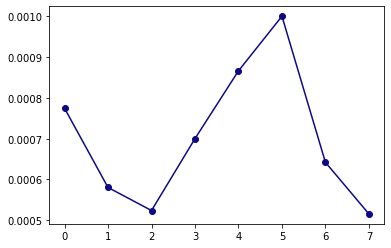

In [20]:
%matplotlib inline
import cycler
N = 6
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.plasma(np.linspace(0,1,N)))
c = plt.cycler('color', ['r', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
fig, ax = plt.subplots()
#ax.set_prop_cycle(c)
ax.plot(mi[:-20], marker = 'o')
#ax.plot(mi1[:-20])
#ax.plot(clair[:-20], marker = 'D')
#ax.plot(erie[:-20], marker = 'v')
#ax.plot(ont[:-20], marker = 'P')
#ax.plot(sup[:-20], marker = 'X')
#fig.show()
fig.savefig("mihuron_meta_loss")


In [88]:
#data, model init, epoch, array size, save name

In [22]:
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
model_2 = tr.load("Clair/clair_meta.pt")
tr.save(model_2.state_dict(), "clair_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
error_analysis = np.zeros((30, 131))
for i in range(30):
    print("iteration:", i)
    model.load_state_dict(tr.load('clair_init'))
    train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 0)
    all_loss_train = []
    all_loss_test = []
    last_pred = []
    last_y = []
    epoch = 0
    while epoch < 131:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        temp_y = []
        temp_pred = []
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            temp_y.append(tr.squeeze(y).tolist())
            temp_pred.append(tr.squeeze(pred).tolist())
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(epoch, loss_train, loss_test))
        all_loss_train.append(loss_train.detach())
        all_loss_test.append(loss_test.detach())
        epoch += 1
    error_analysis[i] = all_loss_test
    np.save("error_clair_meta", error_analysis)

iteration: 0
Epoch 0, Loss Train: 0.004180, Loss Test: 0.000962
Epoch 1, Loss Train: 0.009424, Loss Test: 0.001036
Epoch 2, Loss Train: 0.001486, Loss Test: 0.000817
Epoch 3, Loss Train: 0.004483, Loss Test: 0.001057
Epoch 4, Loss Train: 0.016785, Loss Test: 0.001020
Epoch 5, Loss Train: 0.009267, Loss Test: 0.001202
Epoch 6, Loss Train: 0.006810, Loss Test: 0.000786
Epoch 7, Loss Train: 0.003245, Loss Test: 0.001021
Epoch 8, Loss Train: 0.006596, Loss Test: 0.000856
Epoch 9, Loss Train: 0.007562, Loss Test: 0.001341
Epoch 10, Loss Train: 0.005244, Loss Test: 0.001088
Epoch 11, Loss Train: 0.017756, Loss Test: 0.001012
Epoch 12, Loss Train: 0.001606, Loss Test: 0.000590
Epoch 13, Loss Train: 0.003897, Loss Test: 0.000759
Epoch 14, Loss Train: 0.002926, Loss Test: 0.001386
Epoch 15, Loss Train: 0.012139, Loss Test: 0.001051
Epoch 16, Loss Train: 0.011509, Loss Test: 0.000586
Epoch 17, Loss Train: 0.002431, Loss Test: 0.000995
Epoch 18, Loss Train: 0.012934, Loss Test: 0.001315
Epoch 19,

Epoch 26, Loss Train: 0.002369, Loss Test: 0.000989
Epoch 27, Loss Train: 0.002425, Loss Test: 0.000681
Epoch 28, Loss Train: 0.008445, Loss Test: 0.001220
Epoch 29, Loss Train: 0.013749, Loss Test: 0.001339
Epoch 30, Loss Train: 0.010447, Loss Test: 0.001399
Epoch 31, Loss Train: 0.003003, Loss Test: 0.000860
Epoch 32, Loss Train: 0.006309, Loss Test: 0.000858
Epoch 33, Loss Train: 0.011168, Loss Test: 0.001160
Epoch 34, Loss Train: 0.017592, Loss Test: 0.001388
Epoch 35, Loss Train: 0.009120, Loss Test: 0.001045
Epoch 36, Loss Train: 0.006100, Loss Test: 0.000861
Epoch 37, Loss Train: 0.008990, Loss Test: 0.001031
Epoch 38, Loss Train: 0.013779, Loss Test: 0.000842
Epoch 39, Loss Train: 0.002851, Loss Test: 0.001142
Epoch 40, Loss Train: 0.004046, Loss Test: 0.000962
Epoch 41, Loss Train: 0.007616, Loss Test: 0.000704
Epoch 42, Loss Train: 0.024426, Loss Test: 0.000834
Epoch 43, Loss Train: 0.010721, Loss Test: 0.001317
Epoch 44, Loss Train: 0.015298, Loss Test: 0.000855
Epoch 45, Lo

Epoch 52, Loss Train: 0.005541, Loss Test: 0.001710
Epoch 53, Loss Train: 0.006829, Loss Test: 0.000794
Epoch 54, Loss Train: 0.019856, Loss Test: 0.001074
Epoch 55, Loss Train: 0.003946, Loss Test: 0.001174
Epoch 56, Loss Train: 0.014207, Loss Test: 0.001190
Epoch 57, Loss Train: 0.007952, Loss Test: 0.000777
Epoch 58, Loss Train: 0.009530, Loss Test: 0.000596
Epoch 59, Loss Train: 0.010597, Loss Test: 0.001130
Epoch 60, Loss Train: 0.004824, Loss Test: 0.001260
Epoch 61, Loss Train: 0.020382, Loss Test: 0.000865
Epoch 62, Loss Train: 0.008318, Loss Test: 0.001433
Epoch 63, Loss Train: 0.003751, Loss Test: 0.001201
Epoch 64, Loss Train: 0.003423, Loss Test: 0.000833
Epoch 65, Loss Train: 0.003424, Loss Test: 0.000933
Epoch 66, Loss Train: 0.002899, Loss Test: 0.000882
Epoch 67, Loss Train: 0.005058, Loss Test: 0.000637
Epoch 68, Loss Train: 0.005220, Loss Test: 0.001094
Epoch 69, Loss Train: 0.003196, Loss Test: 0.000841
Epoch 70, Loss Train: 0.005406, Loss Test: 0.001142
Epoch 71, Lo

Epoch 78, Loss Train: 0.006560, Loss Test: 0.000969
Epoch 79, Loss Train: 0.006336, Loss Test: 0.000837
Epoch 80, Loss Train: 0.012260, Loss Test: 0.001391
Epoch 81, Loss Train: 0.002375, Loss Test: 0.001251
Epoch 82, Loss Train: 0.009432, Loss Test: 0.000809
Epoch 83, Loss Train: 0.004123, Loss Test: 0.001119
Epoch 84, Loss Train: 0.004157, Loss Test: 0.000904
Epoch 85, Loss Train: 0.003842, Loss Test: 0.000794
Epoch 86, Loss Train: 0.011021, Loss Test: 0.000649
Epoch 87, Loss Train: 0.001386, Loss Test: 0.001204
Epoch 88, Loss Train: 0.008036, Loss Test: 0.000522
Epoch 89, Loss Train: 0.027209, Loss Test: 0.001131
Epoch 90, Loss Train: 0.013852, Loss Test: 0.001979
Epoch 91, Loss Train: 0.008819, Loss Test: 0.000720
Epoch 92, Loss Train: 0.010954, Loss Test: 0.000710
Epoch 93, Loss Train: 0.011357, Loss Test: 0.001125
Epoch 94, Loss Train: 0.008730, Loss Test: 0.000909
Epoch 95, Loss Train: 0.018802, Loss Test: 0.000523
Epoch 96, Loss Train: 0.006332, Loss Test: 0.000835
Epoch 97, Lo

Epoch 104, Loss Train: 0.007219, Loss Test: 0.000797
Epoch 105, Loss Train: 0.012588, Loss Test: 0.001798
Epoch 106, Loss Train: 0.006614, Loss Test: 0.000794
Epoch 107, Loss Train: 0.006742, Loss Test: 0.000783
Epoch 108, Loss Train: 0.007612, Loss Test: 0.000721
Epoch 109, Loss Train: 0.014251, Loss Test: 0.001090
Epoch 110, Loss Train: 0.004489, Loss Test: 0.001090
Epoch 111, Loss Train: 0.004637, Loss Test: 0.000697
Epoch 112, Loss Train: 0.009564, Loss Test: 0.000960
Epoch 113, Loss Train: 0.015036, Loss Test: 0.001092
Epoch 114, Loss Train: 0.008064, Loss Test: 0.000973
Epoch 115, Loss Train: 0.003799, Loss Test: 0.001152
Epoch 116, Loss Train: 0.004536, Loss Test: 0.000468
Epoch 117, Loss Train: 0.009777, Loss Test: 0.001441
Epoch 118, Loss Train: 0.005682, Loss Test: 0.000764
Epoch 119, Loss Train: 0.004563, Loss Test: 0.000950
Epoch 120, Loss Train: 0.003402, Loss Test: 0.000631
Epoch 121, Loss Train: 0.009820, Loss Test: 0.000625
Epoch 122, Loss Train: 0.010889, Loss Test: 0.

Epoch 130, Loss Train: 0.008178, Loss Test: 0.000950
iteration: 6
Epoch 0, Loss Train: 0.004863, Loss Test: 0.001270
Epoch 1, Loss Train: 0.006422, Loss Test: 0.000931
Epoch 2, Loss Train: 0.007249, Loss Test: 0.001053
Epoch 3, Loss Train: 0.013991, Loss Test: 0.000722
Epoch 4, Loss Train: 0.010475, Loss Test: 0.000900
Epoch 5, Loss Train: 0.008886, Loss Test: 0.001616
Epoch 6, Loss Train: 0.016010, Loss Test: 0.001166
Epoch 7, Loss Train: 0.009219, Loss Test: 0.001174
Epoch 8, Loss Train: 0.009058, Loss Test: 0.000962
Epoch 9, Loss Train: 0.009364, Loss Test: 0.000962
Epoch 10, Loss Train: 0.003504, Loss Test: 0.000985
Epoch 11, Loss Train: 0.012345, Loss Test: 0.000767
Epoch 12, Loss Train: 0.012217, Loss Test: 0.001149
Epoch 13, Loss Train: 0.007962, Loss Test: 0.001048
Epoch 14, Loss Train: 0.011237, Loss Test: 0.001533
Epoch 15, Loss Train: 0.005888, Loss Test: 0.001036
Epoch 16, Loss Train: 0.003052, Loss Test: 0.001058
Epoch 17, Loss Train: 0.004086, Loss Test: 0.001087
Epoch 18

Epoch 25, Loss Train: 0.009099, Loss Test: 0.000881
Epoch 26, Loss Train: 0.001958, Loss Test: 0.000712
Epoch 27, Loss Train: 0.006191, Loss Test: 0.000864
Epoch 28, Loss Train: 0.003134, Loss Test: 0.001598
Epoch 29, Loss Train: 0.007704, Loss Test: 0.000808
Epoch 30, Loss Train: 0.005130, Loss Test: 0.001063
Epoch 31, Loss Train: 0.023261, Loss Test: 0.000806
Epoch 32, Loss Train: 0.021851, Loss Test: 0.001004
Epoch 33, Loss Train: 0.008705, Loss Test: 0.000968
Epoch 34, Loss Train: 0.021515, Loss Test: 0.001308
Epoch 35, Loss Train: 0.019581, Loss Test: 0.001050
Epoch 36, Loss Train: 0.006517, Loss Test: 0.002044
Epoch 37, Loss Train: 0.011887, Loss Test: 0.000807
Epoch 38, Loss Train: 0.006199, Loss Test: 0.000814
Epoch 39, Loss Train: 0.014741, Loss Test: 0.000833
Epoch 40, Loss Train: 0.012173, Loss Test: 0.001215
Epoch 41, Loss Train: 0.005128, Loss Test: 0.001337
Epoch 42, Loss Train: 0.004470, Loss Test: 0.000862
Epoch 43, Loss Train: 0.030316, Loss Test: 0.000887
Epoch 44, Lo

Epoch 51, Loss Train: 0.002580, Loss Test: 0.000681
Epoch 52, Loss Train: 0.003809, Loss Test: 0.000720
Epoch 53, Loss Train: 0.023381, Loss Test: 0.000979
Epoch 54, Loss Train: 0.003783, Loss Test: 0.000869
Epoch 55, Loss Train: 0.009215, Loss Test: 0.001077
Epoch 56, Loss Train: 0.019202, Loss Test: 0.001375
Epoch 57, Loss Train: 0.005627, Loss Test: 0.000765
Epoch 58, Loss Train: 0.012777, Loss Test: 0.000931
Epoch 59, Loss Train: 0.004990, Loss Test: 0.000591
Epoch 60, Loss Train: 0.019469, Loss Test: 0.001276
Epoch 61, Loss Train: 0.006171, Loss Test: 0.000961
Epoch 62, Loss Train: 0.022149, Loss Test: 0.001789
Epoch 63, Loss Train: 0.009097, Loss Test: 0.000805
Epoch 64, Loss Train: 0.013004, Loss Test: 0.001145
Epoch 65, Loss Train: 0.006899, Loss Test: 0.000903
Epoch 66, Loss Train: 0.004622, Loss Test: 0.000992
Epoch 67, Loss Train: 0.003938, Loss Test: 0.000978
Epoch 68, Loss Train: 0.006935, Loss Test: 0.000823
Epoch 69, Loss Train: 0.010708, Loss Test: 0.001163
Epoch 70, Lo

Epoch 77, Loss Train: 0.026105, Loss Test: 0.000715
Epoch 78, Loss Train: 0.005393, Loss Test: 0.000713
Epoch 79, Loss Train: 0.007488, Loss Test: 0.000532
Epoch 80, Loss Train: 0.011246, Loss Test: 0.001316
Epoch 81, Loss Train: 0.007125, Loss Test: 0.001299
Epoch 82, Loss Train: 0.007110, Loss Test: 0.000803
Epoch 83, Loss Train: 0.015324, Loss Test: 0.000889
Epoch 84, Loss Train: 0.011133, Loss Test: 0.000968
Epoch 85, Loss Train: 0.007305, Loss Test: 0.000847
Epoch 86, Loss Train: 0.004195, Loss Test: 0.001248
Epoch 87, Loss Train: 0.001988, Loss Test: 0.000885
Epoch 88, Loss Train: 0.007270, Loss Test: 0.000666
Epoch 89, Loss Train: 0.003478, Loss Test: 0.001924
Epoch 90, Loss Train: 0.007800, Loss Test: 0.000906
Epoch 91, Loss Train: 0.011704, Loss Test: 0.001102
Epoch 92, Loss Train: 0.010466, Loss Test: 0.000619
Epoch 93, Loss Train: 0.009642, Loss Test: 0.000765
Epoch 94, Loss Train: 0.007760, Loss Test: 0.001975
Epoch 95, Loss Train: 0.005723, Loss Test: 0.000678
Epoch 96, Lo

Epoch 103, Loss Train: 0.003666, Loss Test: 0.000798
Epoch 104, Loss Train: 0.009011, Loss Test: 0.001135
Epoch 105, Loss Train: 0.018353, Loss Test: 0.000776
Epoch 106, Loss Train: 0.009519, Loss Test: 0.001015
Epoch 107, Loss Train: 0.006101, Loss Test: 0.000649
Epoch 108, Loss Train: 0.003047, Loss Test: 0.000882
Epoch 109, Loss Train: 0.004739, Loss Test: 0.000681
Epoch 110, Loss Train: 0.017113, Loss Test: 0.001239
Epoch 111, Loss Train: 0.018584, Loss Test: 0.002013
Epoch 112, Loss Train: 0.004011, Loss Test: 0.000728
Epoch 113, Loss Train: 0.009821, Loss Test: 0.001031
Epoch 114, Loss Train: 0.002508, Loss Test: 0.000666
Epoch 115, Loss Train: 0.007258, Loss Test: 0.000976
Epoch 116, Loss Train: 0.016965, Loss Test: 0.001410
Epoch 117, Loss Train: 0.007876, Loss Test: 0.001427
Epoch 118, Loss Train: 0.009170, Loss Test: 0.000690
Epoch 119, Loss Train: 0.008221, Loss Test: 0.000832
Epoch 120, Loss Train: 0.004071, Loss Test: 0.001046
Epoch 121, Loss Train: 0.007302, Loss Test: 0.

Epoch 129, Loss Train: 0.008172, Loss Test: 0.000861
Epoch 130, Loss Train: 0.019466, Loss Test: 0.001353
iteration: 12
Epoch 0, Loss Train: 0.008706, Loss Test: 0.000988
Epoch 1, Loss Train: 0.005532, Loss Test: 0.001241
Epoch 2, Loss Train: 0.013800, Loss Test: 0.001121
Epoch 3, Loss Train: 0.014525, Loss Test: 0.000825
Epoch 4, Loss Train: 0.006409, Loss Test: 0.001460
Epoch 5, Loss Train: 0.006139, Loss Test: 0.000957
Epoch 6, Loss Train: 0.021471, Loss Test: 0.001533
Epoch 7, Loss Train: 0.013095, Loss Test: 0.001205
Epoch 8, Loss Train: 0.012677, Loss Test: 0.001057
Epoch 9, Loss Train: 0.007727, Loss Test: 0.000707
Epoch 10, Loss Train: 0.004336, Loss Test: 0.001282
Epoch 11, Loss Train: 0.003974, Loss Test: 0.000846
Epoch 12, Loss Train: 0.005895, Loss Test: 0.001576
Epoch 13, Loss Train: 0.013128, Loss Test: 0.001008
Epoch 14, Loss Train: 0.004767, Loss Test: 0.001501
Epoch 15, Loss Train: 0.007175, Loss Test: 0.001137
Epoch 16, Loss Train: 0.001953, Loss Test: 0.000878
Epoch 

Epoch 24, Loss Train: 0.021656, Loss Test: 0.000982
Epoch 25, Loss Train: 0.005139, Loss Test: 0.001473
Epoch 26, Loss Train: 0.004152, Loss Test: 0.000979
Epoch 27, Loss Train: 0.002315, Loss Test: 0.000710
Epoch 28, Loss Train: 0.007951, Loss Test: 0.001499
Epoch 29, Loss Train: 0.004965, Loss Test: 0.000690
Epoch 30, Loss Train: 0.009815, Loss Test: 0.000729
Epoch 31, Loss Train: 0.004917, Loss Test: 0.001037
Epoch 32, Loss Train: 0.007553, Loss Test: 0.000837
Epoch 33, Loss Train: 0.006318, Loss Test: 0.002482
Epoch 34, Loss Train: 0.003872, Loss Test: 0.000884
Epoch 35, Loss Train: 0.015636, Loss Test: 0.001306
Epoch 36, Loss Train: 0.004453, Loss Test: 0.001012
Epoch 37, Loss Train: 0.005450, Loss Test: 0.001019
Epoch 38, Loss Train: 0.008712, Loss Test: 0.001342
Epoch 39, Loss Train: 0.004517, Loss Test: 0.000827
Epoch 40, Loss Train: 0.006855, Loss Test: 0.001466
Epoch 41, Loss Train: 0.011853, Loss Test: 0.001238
Epoch 42, Loss Train: 0.009398, Loss Test: 0.000817
Epoch 43, Lo

Epoch 50, Loss Train: 0.006499, Loss Test: 0.000669
Epoch 51, Loss Train: 0.010951, Loss Test: 0.001149
Epoch 52, Loss Train: 0.010715, Loss Test: 0.000715
Epoch 53, Loss Train: 0.009215, Loss Test: 0.001304
Epoch 54, Loss Train: 0.003874, Loss Test: 0.001154
Epoch 55, Loss Train: 0.009409, Loss Test: 0.001225
Epoch 56, Loss Train: 0.001858, Loss Test: 0.001119
Epoch 57, Loss Train: 0.006407, Loss Test: 0.001125
Epoch 58, Loss Train: 0.008713, Loss Test: 0.001247
Epoch 59, Loss Train: 0.005796, Loss Test: 0.000729
Epoch 60, Loss Train: 0.004531, Loss Test: 0.000622
Epoch 61, Loss Train: 0.019398, Loss Test: 0.001560
Epoch 62, Loss Train: 0.008008, Loss Test: 0.000540
Epoch 63, Loss Train: 0.013067, Loss Test: 0.001667
Epoch 64, Loss Train: 0.005037, Loss Test: 0.000734
Epoch 65, Loss Train: 0.016753, Loss Test: 0.000722
Epoch 66, Loss Train: 0.011017, Loss Test: 0.000785
Epoch 67, Loss Train: 0.031536, Loss Test: 0.002093
Epoch 68, Loss Train: 0.011649, Loss Test: 0.000726
Epoch 69, Lo

Epoch 76, Loss Train: 0.009032, Loss Test: 0.001444
Epoch 77, Loss Train: 0.021362, Loss Test: 0.002015
Epoch 78, Loss Train: 0.015514, Loss Test: 0.000844
Epoch 79, Loss Train: 0.009712, Loss Test: 0.000818
Epoch 80, Loss Train: 0.005637, Loss Test: 0.000555
Epoch 81, Loss Train: 0.006717, Loss Test: 0.000808
Epoch 82, Loss Train: 0.010929, Loss Test: 0.001484
Epoch 83, Loss Train: 0.004161, Loss Test: 0.001120
Epoch 84, Loss Train: 0.001467, Loss Test: 0.000738
Epoch 85, Loss Train: 0.005517, Loss Test: 0.000740
Epoch 86, Loss Train: 0.013807, Loss Test: 0.000599
Epoch 87, Loss Train: 0.002869, Loss Test: 0.000837
Epoch 88, Loss Train: 0.002199, Loss Test: 0.000999
Epoch 89, Loss Train: 0.004759, Loss Test: 0.001047
Epoch 90, Loss Train: 0.011344, Loss Test: 0.001186
Epoch 91, Loss Train: 0.003824, Loss Test: 0.000943
Epoch 92, Loss Train: 0.004677, Loss Test: 0.002587
Epoch 93, Loss Train: 0.009582, Loss Test: 0.000899
Epoch 94, Loss Train: 0.006644, Loss Test: 0.000880
Epoch 95, Lo

Epoch 102, Loss Train: 0.005904, Loss Test: 0.001060
Epoch 103, Loss Train: 0.005480, Loss Test: 0.000768
Epoch 104, Loss Train: 0.003977, Loss Test: 0.000855
Epoch 105, Loss Train: 0.011373, Loss Test: 0.000639
Epoch 106, Loss Train: 0.004484, Loss Test: 0.000924
Epoch 107, Loss Train: 0.003001, Loss Test: 0.000721
Epoch 108, Loss Train: 0.002891, Loss Test: 0.001016
Epoch 109, Loss Train: 0.018773, Loss Test: 0.001006
Epoch 110, Loss Train: 0.007176, Loss Test: 0.000977
Epoch 111, Loss Train: 0.003132, Loss Test: 0.000955
Epoch 112, Loss Train: 0.011007, Loss Test: 0.001255
Epoch 113, Loss Train: 0.007298, Loss Test: 0.000613
Epoch 114, Loss Train: 0.005628, Loss Test: 0.000900
Epoch 115, Loss Train: 0.005690, Loss Test: 0.000862
Epoch 116, Loss Train: 0.007230, Loss Test: 0.001261
Epoch 117, Loss Train: 0.006486, Loss Test: 0.000722
Epoch 118, Loss Train: 0.007661, Loss Test: 0.000618
Epoch 119, Loss Train: 0.002328, Loss Test: 0.001532
Epoch 120, Loss Train: 0.008540, Loss Test: 0.

Epoch 128, Loss Train: 0.018418, Loss Test: 0.000462
Epoch 129, Loss Train: 0.006160, Loss Test: 0.001981
Epoch 130, Loss Train: 0.003270, Loss Test: 0.000669
iteration: 18
Epoch 0, Loss Train: 0.005448, Loss Test: 0.001837
Epoch 1, Loss Train: 0.005335, Loss Test: 0.000953
Epoch 2, Loss Train: 0.006718, Loss Test: 0.000851
Epoch 3, Loss Train: 0.011200, Loss Test: 0.000838
Epoch 4, Loss Train: 0.006303, Loss Test: 0.001014
Epoch 5, Loss Train: 0.007679, Loss Test: 0.001371
Epoch 6, Loss Train: 0.007506, Loss Test: 0.000580
Epoch 7, Loss Train: 0.006407, Loss Test: 0.001267
Epoch 8, Loss Train: 0.008921, Loss Test: 0.000651
Epoch 9, Loss Train: 0.003182, Loss Test: 0.001025
Epoch 10, Loss Train: 0.010207, Loss Test: 0.000702
Epoch 11, Loss Train: 0.004708, Loss Test: 0.001331
Epoch 12, Loss Train: 0.008882, Loss Test: 0.001323
Epoch 13, Loss Train: 0.007594, Loss Test: 0.001047
Epoch 14, Loss Train: 0.009844, Loss Test: 0.000918
Epoch 15, Loss Train: 0.009853, Loss Test: 0.001289
Epoch

Epoch 23, Loss Train: 0.010034, Loss Test: 0.001061
Epoch 24, Loss Train: 0.003716, Loss Test: 0.001209
Epoch 25, Loss Train: 0.006291, Loss Test: 0.000660
Epoch 26, Loss Train: 0.003978, Loss Test: 0.001032
Epoch 27, Loss Train: 0.008213, Loss Test: 0.000733
Epoch 28, Loss Train: 0.002853, Loss Test: 0.001003
Epoch 29, Loss Train: 0.012389, Loss Test: 0.000748
Epoch 30, Loss Train: 0.005313, Loss Test: 0.001094
Epoch 31, Loss Train: 0.003409, Loss Test: 0.000702
Epoch 32, Loss Train: 0.006558, Loss Test: 0.001133
Epoch 33, Loss Train: 0.008223, Loss Test: 0.000928
Epoch 34, Loss Train: 0.005589, Loss Test: 0.000708
Epoch 35, Loss Train: 0.009246, Loss Test: 0.000927
Epoch 36, Loss Train: 0.007430, Loss Test: 0.000848
Epoch 37, Loss Train: 0.006543, Loss Test: 0.000722
Epoch 38, Loss Train: 0.007443, Loss Test: 0.000906
Epoch 39, Loss Train: 0.012200, Loss Test: 0.000818
Epoch 40, Loss Train: 0.002390, Loss Test: 0.000712
Epoch 41, Loss Train: 0.026870, Loss Test: 0.001195
Epoch 42, Lo

Epoch 49, Loss Train: 0.015462, Loss Test: 0.000784
Epoch 50, Loss Train: 0.006349, Loss Test: 0.000612
Epoch 51, Loss Train: 0.011287, Loss Test: 0.001399
Epoch 52, Loss Train: 0.002887, Loss Test: 0.000715
Epoch 53, Loss Train: 0.008225, Loss Test: 0.000752
Epoch 54, Loss Train: 0.004094, Loss Test: 0.000857
Epoch 55, Loss Train: 0.006422, Loss Test: 0.000942
Epoch 56, Loss Train: 0.013378, Loss Test: 0.001402
Epoch 57, Loss Train: 0.009004, Loss Test: 0.000740
Epoch 58, Loss Train: 0.005365, Loss Test: 0.000995
Epoch 59, Loss Train: 0.006133, Loss Test: 0.000761
Epoch 60, Loss Train: 0.002935, Loss Test: 0.000629
Epoch 61, Loss Train: 0.003304, Loss Test: 0.000793
Epoch 62, Loss Train: 0.007030, Loss Test: 0.000824
Epoch 63, Loss Train: 0.002382, Loss Test: 0.000589
Epoch 64, Loss Train: 0.011970, Loss Test: 0.000833
Epoch 65, Loss Train: 0.006102, Loss Test: 0.000789
Epoch 66, Loss Train: 0.002169, Loss Test: 0.000649
Epoch 67, Loss Train: 0.010196, Loss Test: 0.001186
Epoch 68, Lo

Epoch 75, Loss Train: 0.006894, Loss Test: 0.000652
Epoch 76, Loss Train: 0.003724, Loss Test: 0.001201
Epoch 77, Loss Train: 0.008751, Loss Test: 0.001199
Epoch 78, Loss Train: 0.005138, Loss Test: 0.000830
Epoch 79, Loss Train: 0.008898, Loss Test: 0.002041
Epoch 80, Loss Train: 0.005938, Loss Test: 0.001456
Epoch 81, Loss Train: 0.004783, Loss Test: 0.000829
Epoch 82, Loss Train: 0.008979, Loss Test: 0.000764
Epoch 83, Loss Train: 0.005124, Loss Test: 0.000611
Epoch 84, Loss Train: 0.003716, Loss Test: 0.001083
Epoch 85, Loss Train: 0.023957, Loss Test: 0.000821
Epoch 86, Loss Train: 0.014681, Loss Test: 0.001146
Epoch 87, Loss Train: 0.007051, Loss Test: 0.000927
Epoch 88, Loss Train: 0.003357, Loss Test: 0.001270
Epoch 89, Loss Train: 0.009158, Loss Test: 0.001510
Epoch 90, Loss Train: 0.002452, Loss Test: 0.000588
Epoch 91, Loss Train: 0.010246, Loss Test: 0.000917
Epoch 92, Loss Train: 0.005865, Loss Test: 0.000996
Epoch 93, Loss Train: 0.013153, Loss Test: 0.000594
Epoch 94, Lo

Epoch 101, Loss Train: 0.027532, Loss Test: 0.000649
Epoch 102, Loss Train: 0.009806, Loss Test: 0.000965
Epoch 103, Loss Train: 0.006784, Loss Test: 0.001113
Epoch 104, Loss Train: 0.005215, Loss Test: 0.000543
Epoch 105, Loss Train: 0.006669, Loss Test: 0.000915
Epoch 106, Loss Train: 0.014167, Loss Test: 0.001196
Epoch 107, Loss Train: 0.005859, Loss Test: 0.001469
Epoch 108, Loss Train: 0.004635, Loss Test: 0.000723
Epoch 109, Loss Train: 0.004841, Loss Test: 0.000865
Epoch 110, Loss Train: 0.008520, Loss Test: 0.001105
Epoch 111, Loss Train: 0.003181, Loss Test: 0.001841
Epoch 112, Loss Train: 0.002086, Loss Test: 0.000661
Epoch 113, Loss Train: 0.003905, Loss Test: 0.000819
Epoch 114, Loss Train: 0.009752, Loss Test: 0.001101
Epoch 115, Loss Train: 0.003066, Loss Test: 0.001010
Epoch 116, Loss Train: 0.004156, Loss Test: 0.001215
Epoch 117, Loss Train: 0.015504, Loss Test: 0.000964
Epoch 118, Loss Train: 0.008322, Loss Test: 0.000741
Epoch 119, Loss Train: 0.014510, Loss Test: 0.

Epoch 127, Loss Train: 0.027957, Loss Test: 0.001617
Epoch 128, Loss Train: 0.006410, Loss Test: 0.000940
Epoch 129, Loss Train: 0.009408, Loss Test: 0.000645
Epoch 130, Loss Train: 0.005922, Loss Test: 0.000563
iteration: 24
Epoch 0, Loss Train: 0.009236, Loss Test: 0.001281
Epoch 1, Loss Train: 0.007729, Loss Test: 0.001113
Epoch 2, Loss Train: 0.016693, Loss Test: 0.001551
Epoch 3, Loss Train: 0.008615, Loss Test: 0.001015
Epoch 4, Loss Train: 0.022175, Loss Test: 0.001033
Epoch 5, Loss Train: 0.017303, Loss Test: 0.001232
Epoch 6, Loss Train: 0.003423, Loss Test: 0.000946
Epoch 7, Loss Train: 0.018312, Loss Test: 0.001338
Epoch 8, Loss Train: 0.007983, Loss Test: 0.000840
Epoch 9, Loss Train: 0.001153, Loss Test: 0.000795
Epoch 10, Loss Train: 0.005740, Loss Test: 0.002148
Epoch 11, Loss Train: 0.005428, Loss Test: 0.000821
Epoch 12, Loss Train: 0.006846, Loss Test: 0.000637
Epoch 13, Loss Train: 0.004910, Loss Test: 0.000850
Epoch 14, Loss Train: 0.025610, Loss Test: 0.000978
Epoc

Epoch 22, Loss Train: 0.012618, Loss Test: 0.001073
Epoch 23, Loss Train: 0.003123, Loss Test: 0.000761
Epoch 24, Loss Train: 0.003511, Loss Test: 0.000896
Epoch 25, Loss Train: 0.004744, Loss Test: 0.001004
Epoch 26, Loss Train: 0.005954, Loss Test: 0.000744
Epoch 27, Loss Train: 0.006023, Loss Test: 0.000760
Epoch 28, Loss Train: 0.005300, Loss Test: 0.000949
Epoch 29, Loss Train: 0.009039, Loss Test: 0.000730
Epoch 30, Loss Train: 0.021085, Loss Test: 0.001027
Epoch 31, Loss Train: 0.004030, Loss Test: 0.001080
Epoch 32, Loss Train: 0.005399, Loss Test: 0.001284
Epoch 33, Loss Train: 0.002240, Loss Test: 0.000878
Epoch 34, Loss Train: 0.006227, Loss Test: 0.000795
Epoch 35, Loss Train: 0.011487, Loss Test: 0.000840
Epoch 36, Loss Train: 0.006735, Loss Test: 0.000649
Epoch 37, Loss Train: 0.008471, Loss Test: 0.000988
Epoch 38, Loss Train: 0.010225, Loss Test: 0.001387
Epoch 39, Loss Train: 0.017005, Loss Test: 0.001061
Epoch 40, Loss Train: 0.011179, Loss Test: 0.001173
Epoch 41, Lo

Epoch 48, Loss Train: 0.005068, Loss Test: 0.001004
Epoch 49, Loss Train: 0.009524, Loss Test: 0.001103
Epoch 50, Loss Train: 0.008478, Loss Test: 0.000602
Epoch 51, Loss Train: 0.011413, Loss Test: 0.000671
Epoch 52, Loss Train: 0.003508, Loss Test: 0.000742
Epoch 53, Loss Train: 0.014315, Loss Test: 0.000919
Epoch 54, Loss Train: 0.017219, Loss Test: 0.001330
Epoch 55, Loss Train: 0.008344, Loss Test: 0.000973
Epoch 56, Loss Train: 0.005976, Loss Test: 0.001062
Epoch 57, Loss Train: 0.004622, Loss Test: 0.001054
Epoch 58, Loss Train: 0.034841, Loss Test: 0.000645
Epoch 59, Loss Train: 0.008718, Loss Test: 0.001003
Epoch 60, Loss Train: 0.010460, Loss Test: 0.000894
Epoch 61, Loss Train: 0.005508, Loss Test: 0.001083
Epoch 62, Loss Train: 0.015342, Loss Test: 0.001085
Epoch 63, Loss Train: 0.005842, Loss Test: 0.000851
Epoch 64, Loss Train: 0.011316, Loss Test: 0.000830
Epoch 65, Loss Train: 0.004294, Loss Test: 0.001119
Epoch 66, Loss Train: 0.007634, Loss Test: 0.000951
Epoch 67, Lo

Epoch 74, Loss Train: 0.010160, Loss Test: 0.000750
Epoch 75, Loss Train: 0.004642, Loss Test: 0.000704
Epoch 76, Loss Train: 0.005079, Loss Test: 0.001463
Epoch 77, Loss Train: 0.004171, Loss Test: 0.000605
Epoch 78, Loss Train: 0.005651, Loss Test: 0.000927
Epoch 79, Loss Train: 0.014071, Loss Test: 0.001414
Epoch 80, Loss Train: 0.007013, Loss Test: 0.001485
Epoch 81, Loss Train: 0.009905, Loss Test: 0.001306
Epoch 82, Loss Train: 0.007768, Loss Test: 0.001454
Epoch 83, Loss Train: 0.006853, Loss Test: 0.000638
Epoch 84, Loss Train: 0.003032, Loss Test: 0.001135
Epoch 85, Loss Train: 0.009164, Loss Test: 0.001162
Epoch 86, Loss Train: 0.005360, Loss Test: 0.001145
Epoch 87, Loss Train: 0.009081, Loss Test: 0.001836
Epoch 88, Loss Train: 0.004696, Loss Test: 0.000972
Epoch 89, Loss Train: 0.002941, Loss Test: 0.000825
Epoch 90, Loss Train: 0.007269, Loss Test: 0.000794
Epoch 91, Loss Train: 0.012744, Loss Test: 0.001046
Epoch 92, Loss Train: 0.005225, Loss Test: 0.001128
Epoch 93, Lo

Epoch 100, Loss Train: 0.012894, Loss Test: 0.000591
Epoch 101, Loss Train: 0.030922, Loss Test: 0.000481
Epoch 102, Loss Train: 0.006834, Loss Test: 0.000903
Epoch 103, Loss Train: 0.006296, Loss Test: 0.000649
Epoch 104, Loss Train: 0.002059, Loss Test: 0.000694
Epoch 105, Loss Train: 0.017117, Loss Test: 0.001181
Epoch 106, Loss Train: 0.004157, Loss Test: 0.000698
Epoch 107, Loss Train: 0.002271, Loss Test: 0.000917
Epoch 108, Loss Train: 0.009117, Loss Test: 0.000616
Epoch 109, Loss Train: 0.003525, Loss Test: 0.001207
Epoch 110, Loss Train: 0.009586, Loss Test: 0.000594
Epoch 111, Loss Train: 0.003531, Loss Test: 0.000670
Epoch 112, Loss Train: 0.007377, Loss Test: 0.001472
Epoch 113, Loss Train: 0.004476, Loss Test: 0.000669
Epoch 114, Loss Train: 0.009699, Loss Test: 0.000903
Epoch 115, Loss Train: 0.006778, Loss Test: 0.001168
Epoch 116, Loss Train: 0.005994, Loss Test: 0.000808
Epoch 117, Loss Train: 0.006176, Loss Test: 0.001053
Epoch 118, Loss Train: 0.003133, Loss Test: 0.

Epoch 126, Loss Train: 0.014742, Loss Test: 0.001150
Epoch 127, Loss Train: 0.005248, Loss Test: 0.000516
Epoch 128, Loss Train: 0.010212, Loss Test: 0.000747
Epoch 129, Loss Train: 0.019488, Loss Test: 0.001174
Epoch 130, Loss Train: 0.006694, Loss Test: 0.000742


In [10]:
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
model_2 = tr.load("Erie/erie_meta.pt")
tr.save(model_2.state_dict(), "erie_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
error_analysis = np.zeros((30, 124))
for i in range(30):
    print("iteration:", i)
    model.load_state_dict(tr.load('erie_init'))
    train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 1)
    all_loss_train = []
    all_loss_test = []
    last_pred = []
    last_y = []
    epoch = 0
    while epoch < 124:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        temp_y = []
        temp_pred = []
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            temp_y.append(tr.squeeze(y).tolist())
            temp_pred.append(tr.squeeze(pred).tolist())
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(epoch, loss_train, loss_test))
        all_loss_train.append(loss_train.detach())
        all_loss_test.append(loss_test.detach())
        epoch += 1
    error_analysis[i] = all_loss_test
    np.save("error_erie_meta", error_analysis)

iteration: 0
Epoch 0, Loss Train: 0.006065, Loss Test: 0.001585
Epoch 1, Loss Train: 0.003179, Loss Test: 0.001493
Epoch 2, Loss Train: 0.010194, Loss Test: 0.001288
Epoch 3, Loss Train: 0.009589, Loss Test: 0.002012
Epoch 4, Loss Train: 0.017195, Loss Test: 0.001536
Epoch 5, Loss Train: 0.006802, Loss Test: 0.001587
Epoch 6, Loss Train: 0.003568, Loss Test: 0.001097
Epoch 7, Loss Train: 0.016615, Loss Test: 0.001227
Epoch 8, Loss Train: 0.008194, Loss Test: 0.000939
Epoch 9, Loss Train: 0.006179, Loss Test: 0.000881
Epoch 10, Loss Train: 0.013683, Loss Test: 0.001564
Epoch 11, Loss Train: 0.021568, Loss Test: 0.002145
Epoch 12, Loss Train: 0.010033, Loss Test: 0.001476
Epoch 13, Loss Train: 0.012467, Loss Test: 0.001376
Epoch 14, Loss Train: 0.028639, Loss Test: 0.001085
Epoch 15, Loss Train: 0.017475, Loss Test: 0.001586
Epoch 16, Loss Train: 0.005719, Loss Test: 0.001572
Epoch 17, Loss Train: 0.010195, Loss Test: 0.001208
Epoch 18, Loss Train: 0.011750, Loss Test: 0.001449
Epoch 19,

Epoch 33, Loss Train: 0.010296, Loss Test: 0.001566
Epoch 34, Loss Train: 0.006219, Loss Test: 0.001149
Epoch 35, Loss Train: 0.018103, Loss Test: 0.001251
Epoch 36, Loss Train: 0.013808, Loss Test: 0.001101
Epoch 37, Loss Train: 0.008141, Loss Test: 0.000954
Epoch 38, Loss Train: 0.002731, Loss Test: 0.001599
Epoch 39, Loss Train: 0.009725, Loss Test: 0.001477
Epoch 40, Loss Train: 0.013629, Loss Test: 0.001637
Epoch 41, Loss Train: 0.002648, Loss Test: 0.000934
Epoch 42, Loss Train: 0.007247, Loss Test: 0.000878
Epoch 43, Loss Train: 0.014530, Loss Test: 0.001177
Epoch 44, Loss Train: 0.004505, Loss Test: 0.001371
Epoch 45, Loss Train: 0.003903, Loss Test: 0.001245
Epoch 46, Loss Train: 0.008865, Loss Test: 0.002033
Epoch 47, Loss Train: 0.002608, Loss Test: 0.000595
Epoch 48, Loss Train: 0.014513, Loss Test: 0.001019
Epoch 49, Loss Train: 0.007033, Loss Test: 0.001240
Epoch 50, Loss Train: 0.019257, Loss Test: 0.001812
Epoch 51, Loss Train: 0.005223, Loss Test: 0.001249
Epoch 52, Lo

Epoch 67, Loss Train: 0.013556, Loss Test: 0.000896
Epoch 68, Loss Train: 0.005847, Loss Test: 0.001417
Epoch 69, Loss Train: 0.008426, Loss Test: 0.001320
Epoch 70, Loss Train: 0.012536, Loss Test: 0.001426
Epoch 71, Loss Train: 0.002594, Loss Test: 0.001059
Epoch 72, Loss Train: 0.007710, Loss Test: 0.000974
Epoch 73, Loss Train: 0.007025, Loss Test: 0.001709
Epoch 74, Loss Train: 0.006537, Loss Test: 0.001328
Epoch 75, Loss Train: 0.017373, Loss Test: 0.001265
Epoch 76, Loss Train: 0.015383, Loss Test: 0.000931
Epoch 77, Loss Train: 0.019375, Loss Test: 0.001605
Epoch 78, Loss Train: 0.008265, Loss Test: 0.001019
Epoch 79, Loss Train: 0.013283, Loss Test: 0.001594
Epoch 80, Loss Train: 0.015909, Loss Test: 0.001214
Epoch 81, Loss Train: 0.013250, Loss Test: 0.001280
Epoch 82, Loss Train: 0.004067, Loss Test: 0.001697
Epoch 83, Loss Train: 0.010027, Loss Test: 0.001092
Epoch 84, Loss Train: 0.019151, Loss Test: 0.001277
Epoch 85, Loss Train: 0.009373, Loss Test: 0.001798
Epoch 86, Lo

Epoch 101, Loss Train: 0.021079, Loss Test: 0.001598
Epoch 102, Loss Train: 0.002879, Loss Test: 0.000825
Epoch 103, Loss Train: 0.007507, Loss Test: 0.000714
Epoch 104, Loss Train: 0.008376, Loss Test: 0.001366
Epoch 105, Loss Train: 0.013280, Loss Test: 0.001198
Epoch 106, Loss Train: 0.009932, Loss Test: 0.000955
Epoch 107, Loss Train: 0.007060, Loss Test: 0.000868
Epoch 108, Loss Train: 0.025253, Loss Test: 0.001146
Epoch 109, Loss Train: 0.016342, Loss Test: 0.001124
Epoch 110, Loss Train: 0.014010, Loss Test: 0.001506
Epoch 111, Loss Train: 0.016634, Loss Test: 0.000647
Epoch 112, Loss Train: 0.007968, Loss Test: 0.001018
Epoch 113, Loss Train: 0.007040, Loss Test: 0.000836
Epoch 114, Loss Train: 0.009143, Loss Test: 0.000956
Epoch 115, Loss Train: 0.011638, Loss Test: 0.001054
Epoch 116, Loss Train: 0.007122, Loss Test: 0.000815
Epoch 117, Loss Train: 0.009925, Loss Test: 0.001850
Epoch 118, Loss Train: 0.011268, Loss Test: 0.001379
Epoch 119, Loss Train: 0.003316, Loss Test: 0.

Epoch 10, Loss Train: 0.015791, Loss Test: 0.001295
Epoch 11, Loss Train: 0.007362, Loss Test: 0.001730
Epoch 12, Loss Train: 0.020551, Loss Test: 0.001061
Epoch 13, Loss Train: 0.014839, Loss Test: 0.001353
Epoch 14, Loss Train: 0.011426, Loss Test: 0.001469
Epoch 15, Loss Train: 0.013293, Loss Test: 0.000794
Epoch 16, Loss Train: 0.008429, Loss Test: 0.001933
Epoch 17, Loss Train: 0.010604, Loss Test: 0.000758
Epoch 18, Loss Train: 0.014558, Loss Test: 0.001525
Epoch 19, Loss Train: 0.003585, Loss Test: 0.000788
Epoch 20, Loss Train: 0.011682, Loss Test: 0.001229
Epoch 21, Loss Train: 0.008615, Loss Test: 0.000985
Epoch 22, Loss Train: 0.005842, Loss Test: 0.001077
Epoch 23, Loss Train: 0.007446, Loss Test: 0.002148
Epoch 24, Loss Train: 0.004265, Loss Test: 0.001423
Epoch 25, Loss Train: 0.008942, Loss Test: 0.000883
Epoch 26, Loss Train: 0.008048, Loss Test: 0.001609
Epoch 27, Loss Train: 0.012416, Loss Test: 0.001393
Epoch 28, Loss Train: 0.011034, Loss Test: 0.001532
Epoch 29, Lo

Epoch 44, Loss Train: 0.012179, Loss Test: 0.000728
Epoch 45, Loss Train: 0.004083, Loss Test: 0.000714
Epoch 46, Loss Train: 0.006925, Loss Test: 0.001220
Epoch 47, Loss Train: 0.018157, Loss Test: 0.001055
Epoch 48, Loss Train: 0.013312, Loss Test: 0.001762
Epoch 49, Loss Train: 0.009182, Loss Test: 0.000886
Epoch 50, Loss Train: 0.012755, Loss Test: 0.001107
Epoch 51, Loss Train: 0.011115, Loss Test: 0.000787
Epoch 52, Loss Train: 0.004874, Loss Test: 0.001286
Epoch 53, Loss Train: 0.007259, Loss Test: 0.000812
Epoch 54, Loss Train: 0.015092, Loss Test: 0.001002
Epoch 55, Loss Train: 0.006655, Loss Test: 0.001169
Epoch 56, Loss Train: 0.012010, Loss Test: 0.001770
Epoch 57, Loss Train: 0.006082, Loss Test: 0.001571
Epoch 58, Loss Train: 0.003659, Loss Test: 0.000773
Epoch 59, Loss Train: 0.008305, Loss Test: 0.001624
Epoch 60, Loss Train: 0.006615, Loss Test: 0.000934
Epoch 61, Loss Train: 0.006375, Loss Test: 0.000732
Epoch 62, Loss Train: 0.011185, Loss Test: 0.002054
Epoch 63, Lo

Epoch 78, Loss Train: 0.018367, Loss Test: 0.001121
Epoch 79, Loss Train: 0.011356, Loss Test: 0.001963
Epoch 80, Loss Train: 0.020763, Loss Test: 0.001338
Epoch 81, Loss Train: 0.013375, Loss Test: 0.001459
Epoch 82, Loss Train: 0.012601, Loss Test: 0.000850
Epoch 83, Loss Train: 0.004779, Loss Test: 0.001476
Epoch 84, Loss Train: 0.013237, Loss Test: 0.001636
Epoch 85, Loss Train: 0.016967, Loss Test: 0.000919
Epoch 86, Loss Train: 0.004146, Loss Test: 0.000500
Epoch 87, Loss Train: 0.005457, Loss Test: 0.001341
Epoch 88, Loss Train: 0.006955, Loss Test: 0.000891
Epoch 89, Loss Train: 0.011039, Loss Test: 0.001169
Epoch 90, Loss Train: 0.007145, Loss Test: 0.000805
Epoch 91, Loss Train: 0.016583, Loss Test: 0.001144
Epoch 92, Loss Train: 0.009111, Loss Test: 0.000788
Epoch 93, Loss Train: 0.002799, Loss Test: 0.001394
Epoch 94, Loss Train: 0.008504, Loss Test: 0.001023
Epoch 95, Loss Train: 0.005508, Loss Test: 0.001663
Epoch 96, Loss Train: 0.010489, Loss Test: 0.001502
Epoch 97, Lo

Epoch 111, Loss Train: 0.009822, Loss Test: 0.000940
Epoch 112, Loss Train: 0.007461, Loss Test: 0.001116
Epoch 113, Loss Train: 0.002527, Loss Test: 0.001119
Epoch 114, Loss Train: 0.005828, Loss Test: 0.000713
Epoch 115, Loss Train: 0.009275, Loss Test: 0.001211
Epoch 116, Loss Train: 0.006399, Loss Test: 0.001143
Epoch 117, Loss Train: 0.018066, Loss Test: 0.001396
Epoch 118, Loss Train: 0.007000, Loss Test: 0.000746
Epoch 119, Loss Train: 0.014376, Loss Test: 0.000808
Epoch 120, Loss Train: 0.008746, Loss Test: 0.000759
Epoch 121, Loss Train: 0.006140, Loss Test: 0.000973
Epoch 122, Loss Train: 0.009166, Loss Test: 0.001234
Epoch 123, Loss Train: 0.012565, Loss Test: 0.001228
iteration: 9
Epoch 0, Loss Train: 0.011296, Loss Test: 0.001471
Epoch 1, Loss Train: 0.008212, Loss Test: 0.001133
Epoch 2, Loss Train: 0.008442, Loss Test: 0.001421
Epoch 3, Loss Train: 0.017967, Loss Test: 0.001543
Epoch 4, Loss Train: 0.009990, Loss Test: 0.000811
Epoch 5, Loss Train: 0.011878, Loss Test: 0

Epoch 20, Loss Train: 0.009175, Loss Test: 0.001164
Epoch 21, Loss Train: 0.004964, Loss Test: 0.001309
Epoch 22, Loss Train: 0.009299, Loss Test: 0.001368
Epoch 23, Loss Train: 0.003069, Loss Test: 0.001477
Epoch 24, Loss Train: 0.005912, Loss Test: 0.001683
Epoch 25, Loss Train: 0.019140, Loss Test: 0.001562
Epoch 26, Loss Train: 0.011533, Loss Test: 0.001416
Epoch 27, Loss Train: 0.011394, Loss Test: 0.001142
Epoch 28, Loss Train: 0.016386, Loss Test: 0.001227
Epoch 29, Loss Train: 0.015775, Loss Test: 0.001449
Epoch 30, Loss Train: 0.006283, Loss Test: 0.000856
Epoch 31, Loss Train: 0.005258, Loss Test: 0.002002
Epoch 32, Loss Train: 0.010727, Loss Test: 0.001101
Epoch 33, Loss Train: 0.015685, Loss Test: 0.001268
Epoch 34, Loss Train: 0.013059, Loss Test: 0.001078
Epoch 35, Loss Train: 0.009154, Loss Test: 0.001026
Epoch 36, Loss Train: 0.005963, Loss Test: 0.001056
Epoch 37, Loss Train: 0.003906, Loss Test: 0.001001
Epoch 38, Loss Train: 0.004834, Loss Test: 0.001163
Epoch 39, Lo

Epoch 54, Loss Train: 0.019381, Loss Test: 0.001376
Epoch 55, Loss Train: 0.004632, Loss Test: 0.002534
Epoch 56, Loss Train: 0.006627, Loss Test: 0.000860
Epoch 57, Loss Train: 0.007317, Loss Test: 0.001416
Epoch 58, Loss Train: 0.018697, Loss Test: 0.000759
Epoch 59, Loss Train: 0.018258, Loss Test: 0.001193
Epoch 60, Loss Train: 0.037184, Loss Test: 0.001161
Epoch 61, Loss Train: 0.007921, Loss Test: 0.001147
Epoch 62, Loss Train: 0.013791, Loss Test: 0.002123
Epoch 63, Loss Train: 0.005836, Loss Test: 0.001286
Epoch 64, Loss Train: 0.005436, Loss Test: 0.001317
Epoch 65, Loss Train: 0.012751, Loss Test: 0.001604
Epoch 66, Loss Train: 0.002595, Loss Test: 0.000976
Epoch 67, Loss Train: 0.010387, Loss Test: 0.001488
Epoch 68, Loss Train: 0.010034, Loss Test: 0.001045
Epoch 69, Loss Train: 0.006181, Loss Test: 0.001772
Epoch 70, Loss Train: 0.014853, Loss Test: 0.001640
Epoch 71, Loss Train: 0.006150, Loss Test: 0.001276
Epoch 72, Loss Train: 0.013789, Loss Test: 0.000933
Epoch 73, Lo

Epoch 88, Loss Train: 0.009026, Loss Test: 0.002075
Epoch 89, Loss Train: 0.010259, Loss Test: 0.000931
Epoch 90, Loss Train: 0.008002, Loss Test: 0.001167
Epoch 91, Loss Train: 0.017602, Loss Test: 0.001026
Epoch 92, Loss Train: 0.010703, Loss Test: 0.000779
Epoch 93, Loss Train: 0.011933, Loss Test: 0.000695
Epoch 94, Loss Train: 0.013811, Loss Test: 0.001775
Epoch 95, Loss Train: 0.014501, Loss Test: 0.001073
Epoch 96, Loss Train: 0.007653, Loss Test: 0.001684
Epoch 97, Loss Train: 0.006513, Loss Test: 0.000955
Epoch 98, Loss Train: 0.004723, Loss Test: 0.001489
Epoch 99, Loss Train: 0.004142, Loss Test: 0.001878
Epoch 100, Loss Train: 0.008918, Loss Test: 0.000762
Epoch 101, Loss Train: 0.007279, Loss Test: 0.000900
Epoch 102, Loss Train: 0.006042, Loss Test: 0.000907
Epoch 103, Loss Train: 0.019772, Loss Test: 0.000952
Epoch 104, Loss Train: 0.006980, Loss Test: 0.001540
Epoch 105, Loss Train: 0.009203, Loss Test: 0.001284
Epoch 106, Loss Train: 0.009373, Loss Test: 0.001134
Epoch

Epoch 121, Loss Train: 0.019373, Loss Test: 0.001108
Epoch 122, Loss Train: 0.003998, Loss Test: 0.001771
Epoch 123, Loss Train: 0.010663, Loss Test: 0.001463
iteration: 14
Epoch 0, Loss Train: 0.012481, Loss Test: 0.001080
Epoch 1, Loss Train: 0.011591, Loss Test: 0.001360
Epoch 2, Loss Train: 0.005842, Loss Test: 0.001002
Epoch 3, Loss Train: 0.013447, Loss Test: 0.001094
Epoch 4, Loss Train: 0.007430, Loss Test: 0.001452
Epoch 5, Loss Train: 0.006981, Loss Test: 0.001504
Epoch 6, Loss Train: 0.012564, Loss Test: 0.001468
Epoch 7, Loss Train: 0.001896, Loss Test: 0.001350
Epoch 8, Loss Train: 0.008628, Loss Test: 0.001786
Epoch 9, Loss Train: 0.009772, Loss Test: 0.001174
Epoch 10, Loss Train: 0.016679, Loss Test: 0.000858
Epoch 11, Loss Train: 0.002921, Loss Test: 0.001960
Epoch 12, Loss Train: 0.009913, Loss Test: 0.000950
Epoch 13, Loss Train: 0.012520, Loss Test: 0.001441
Epoch 14, Loss Train: 0.008893, Loss Test: 0.001482
Epoch 15, Loss Train: 0.007396, Loss Test: 0.001287
Epoch

Epoch 30, Loss Train: 0.006235, Loss Test: 0.000824
Epoch 31, Loss Train: 0.005060, Loss Test: 0.002436
Epoch 32, Loss Train: 0.002020, Loss Test: 0.001447
Epoch 33, Loss Train: 0.006462, Loss Test: 0.001103
Epoch 34, Loss Train: 0.009291, Loss Test: 0.001207
Epoch 35, Loss Train: 0.008209, Loss Test: 0.000895
Epoch 36, Loss Train: 0.008331, Loss Test: 0.001641
Epoch 37, Loss Train: 0.006630, Loss Test: 0.001544
Epoch 38, Loss Train: 0.008660, Loss Test: 0.000762
Epoch 39, Loss Train: 0.014334, Loss Test: 0.001004
Epoch 40, Loss Train: 0.013338, Loss Test: 0.001012
Epoch 41, Loss Train: 0.005688, Loss Test: 0.001222
Epoch 42, Loss Train: 0.012475, Loss Test: 0.000751
Epoch 43, Loss Train: 0.013375, Loss Test: 0.001314
Epoch 44, Loss Train: 0.018730, Loss Test: 0.001236
Epoch 45, Loss Train: 0.004781, Loss Test: 0.000922
Epoch 46, Loss Train: 0.006532, Loss Test: 0.000739
Epoch 47, Loss Train: 0.009208, Loss Test: 0.001942
Epoch 48, Loss Train: 0.006290, Loss Test: 0.001170
Epoch 49, Lo

Epoch 64, Loss Train: 0.010568, Loss Test: 0.001131
Epoch 65, Loss Train: 0.014319, Loss Test: 0.001433
Epoch 66, Loss Train: 0.006318, Loss Test: 0.000739
Epoch 67, Loss Train: 0.006751, Loss Test: 0.001436
Epoch 68, Loss Train: 0.007088, Loss Test: 0.001157
Epoch 69, Loss Train: 0.009246, Loss Test: 0.002478
Epoch 70, Loss Train: 0.008565, Loss Test: 0.001537
Epoch 71, Loss Train: 0.008347, Loss Test: 0.001422
Epoch 72, Loss Train: 0.025740, Loss Test: 0.000874
Epoch 73, Loss Train: 0.017614, Loss Test: 0.001283
Epoch 74, Loss Train: 0.011830, Loss Test: 0.000819
Epoch 75, Loss Train: 0.011184, Loss Test: 0.001317
Epoch 76, Loss Train: 0.009426, Loss Test: 0.001317
Epoch 77, Loss Train: 0.015043, Loss Test: 0.000781
Epoch 78, Loss Train: 0.013289, Loss Test: 0.001515
Epoch 79, Loss Train: 0.005382, Loss Test: 0.001850
Epoch 80, Loss Train: 0.006537, Loss Test: 0.000954
Epoch 81, Loss Train: 0.022476, Loss Test: 0.001824
Epoch 82, Loss Train: 0.004368, Loss Test: 0.000835
Epoch 83, Lo

Epoch 98, Loss Train: 0.008147, Loss Test: 0.000891
Epoch 99, Loss Train: 0.008764, Loss Test: 0.001134
Epoch 100, Loss Train: 0.024154, Loss Test: 0.001221
Epoch 101, Loss Train: 0.009033, Loss Test: 0.000862
Epoch 102, Loss Train: 0.005010, Loss Test: 0.000555
Epoch 103, Loss Train: 0.006276, Loss Test: 0.000836
Epoch 104, Loss Train: 0.019658, Loss Test: 0.000984
Epoch 105, Loss Train: 0.010008, Loss Test: 0.001325
Epoch 106, Loss Train: 0.011594, Loss Test: 0.000807
Epoch 107, Loss Train: 0.017609, Loss Test: 0.001195
Epoch 108, Loss Train: 0.008707, Loss Test: 0.001012
Epoch 109, Loss Train: 0.006687, Loss Test: 0.001120
Epoch 110, Loss Train: 0.012107, Loss Test: 0.001157
Epoch 111, Loss Train: 0.010246, Loss Test: 0.000959
Epoch 112, Loss Train: 0.011204, Loss Test: 0.001204
Epoch 113, Loss Train: 0.008348, Loss Test: 0.001084
Epoch 114, Loss Train: 0.006204, Loss Test: 0.001518
Epoch 115, Loss Train: 0.006613, Loss Test: 0.001389
Epoch 116, Loss Train: 0.002257, Loss Test: 0.00

Epoch 7, Loss Train: 0.012664, Loss Test: 0.000853
Epoch 8, Loss Train: 0.004934, Loss Test: 0.001532
Epoch 9, Loss Train: 0.007986, Loss Test: 0.002248
Epoch 10, Loss Train: 0.010538, Loss Test: 0.001769
Epoch 11, Loss Train: 0.018948, Loss Test: 0.002042
Epoch 12, Loss Train: 0.017515, Loss Test: 0.001394
Epoch 13, Loss Train: 0.014868, Loss Test: 0.000978
Epoch 14, Loss Train: 0.004408, Loss Test: 0.001110
Epoch 15, Loss Train: 0.008474, Loss Test: 0.001747
Epoch 16, Loss Train: 0.007678, Loss Test: 0.000974
Epoch 17, Loss Train: 0.007532, Loss Test: 0.001789
Epoch 18, Loss Train: 0.008297, Loss Test: 0.001440
Epoch 19, Loss Train: 0.010210, Loss Test: 0.002109
Epoch 20, Loss Train: 0.005826, Loss Test: 0.001297
Epoch 21, Loss Train: 0.006233, Loss Test: 0.001539
Epoch 22, Loss Train: 0.014416, Loss Test: 0.002340
Epoch 23, Loss Train: 0.008794, Loss Test: 0.001387
Epoch 24, Loss Train: 0.010162, Loss Test: 0.001309
Epoch 25, Loss Train: 0.003467, Loss Test: 0.001725
Epoch 26, Loss 

Epoch 41, Loss Train: 0.005608, Loss Test: 0.000831
Epoch 42, Loss Train: 0.005162, Loss Test: 0.001464
Epoch 43, Loss Train: 0.007563, Loss Test: 0.001315
Epoch 44, Loss Train: 0.012262, Loss Test: 0.000726
Epoch 45, Loss Train: 0.012075, Loss Test: 0.001134
Epoch 46, Loss Train: 0.005277, Loss Test: 0.000929
Epoch 47, Loss Train: 0.023860, Loss Test: 0.001881
Epoch 48, Loss Train: 0.006934, Loss Test: 0.001052
Epoch 49, Loss Train: 0.008726, Loss Test: 0.001536
Epoch 50, Loss Train: 0.007433, Loss Test: 0.000645
Epoch 51, Loss Train: 0.015372, Loss Test: 0.002062
Epoch 52, Loss Train: 0.008136, Loss Test: 0.001138
Epoch 53, Loss Train: 0.010788, Loss Test: 0.002123
Epoch 54, Loss Train: 0.011641, Loss Test: 0.002004
Epoch 55, Loss Train: 0.010030, Loss Test: 0.002020
Epoch 56, Loss Train: 0.009312, Loss Test: 0.001126
Epoch 57, Loss Train: 0.004251, Loss Test: 0.001535
Epoch 58, Loss Train: 0.006775, Loss Test: 0.001181
Epoch 59, Loss Train: 0.012339, Loss Test: 0.000766
Epoch 60, Lo

Epoch 75, Loss Train: 0.010330, Loss Test: 0.001037
Epoch 76, Loss Train: 0.006964, Loss Test: 0.001394
Epoch 77, Loss Train: 0.003653, Loss Test: 0.001035
Epoch 78, Loss Train: 0.007242, Loss Test: 0.001102
Epoch 79, Loss Train: 0.012195, Loss Test: 0.000825
Epoch 80, Loss Train: 0.004743, Loss Test: 0.000827
Epoch 81, Loss Train: 0.017450, Loss Test: 0.002056
Epoch 82, Loss Train: 0.005107, Loss Test: 0.000857
Epoch 83, Loss Train: 0.011337, Loss Test: 0.001299
Epoch 84, Loss Train: 0.016532, Loss Test: 0.001136
Epoch 85, Loss Train: 0.008381, Loss Test: 0.000636
Epoch 86, Loss Train: 0.007800, Loss Test: 0.000686
Epoch 87, Loss Train: 0.012995, Loss Test: 0.001044
Epoch 88, Loss Train: 0.009105, Loss Test: 0.001677
Epoch 89, Loss Train: 0.006314, Loss Test: 0.001094
Epoch 90, Loss Train: 0.008220, Loss Test: 0.000799
Epoch 91, Loss Train: 0.009105, Loss Test: 0.001361
Epoch 92, Loss Train: 0.008595, Loss Test: 0.002290
Epoch 93, Loss Train: 0.013056, Loss Test: 0.000999
Epoch 94, Lo

Epoch 108, Loss Train: 0.010919, Loss Test: 0.002674
Epoch 109, Loss Train: 0.023391, Loss Test: 0.000671
Epoch 110, Loss Train: 0.005394, Loss Test: 0.001156
Epoch 111, Loss Train: 0.017838, Loss Test: 0.000871
Epoch 112, Loss Train: 0.005596, Loss Test: 0.001068
Epoch 113, Loss Train: 0.013168, Loss Test: 0.000991
Epoch 114, Loss Train: 0.013906, Loss Test: 0.001506
Epoch 115, Loss Train: 0.020225, Loss Test: 0.001194
Epoch 116, Loss Train: 0.003980, Loss Test: 0.000479
Epoch 117, Loss Train: 0.007786, Loss Test: 0.001552
Epoch 118, Loss Train: 0.014235, Loss Test: 0.000754
Epoch 119, Loss Train: 0.005329, Loss Test: 0.000688
Epoch 120, Loss Train: 0.009564, Loss Test: 0.002509
Epoch 121, Loss Train: 0.006955, Loss Test: 0.000797
Epoch 122, Loss Train: 0.019488, Loss Test: 0.001493
Epoch 123, Loss Train: 0.013180, Loss Test: 0.000838
iteration: 23
Epoch 0, Loss Train: 0.005184, Loss Test: 0.001124
Epoch 1, Loss Train: 0.007565, Loss Test: 0.001519
Epoch 2, Loss Train: 0.015183, Loss 

Epoch 17, Loss Train: 0.003390, Loss Test: 0.001453
Epoch 18, Loss Train: 0.005485, Loss Test: 0.001292
Epoch 19, Loss Train: 0.018985, Loss Test: 0.002243
Epoch 20, Loss Train: 0.005562, Loss Test: 0.001523
Epoch 21, Loss Train: 0.014532, Loss Test: 0.001208
Epoch 22, Loss Train: 0.029104, Loss Test: 0.001440
Epoch 23, Loss Train: 0.005761, Loss Test: 0.001169
Epoch 24, Loss Train: 0.012576, Loss Test: 0.000905
Epoch 25, Loss Train: 0.010765, Loss Test: 0.001563
Epoch 26, Loss Train: 0.021373, Loss Test: 0.001578
Epoch 27, Loss Train: 0.004030, Loss Test: 0.001649
Epoch 28, Loss Train: 0.018039, Loss Test: 0.001920
Epoch 29, Loss Train: 0.010731, Loss Test: 0.001538
Epoch 30, Loss Train: 0.007547, Loss Test: 0.000878
Epoch 31, Loss Train: 0.021475, Loss Test: 0.001739
Epoch 32, Loss Train: 0.009402, Loss Test: 0.001402
Epoch 33, Loss Train: 0.005803, Loss Test: 0.001441
Epoch 34, Loss Train: 0.007203, Loss Test: 0.001712
Epoch 35, Loss Train: 0.015225, Loss Test: 0.001173
Epoch 36, Lo

Epoch 51, Loss Train: 0.005904, Loss Test: 0.001325
Epoch 52, Loss Train: 0.007772, Loss Test: 0.000803
Epoch 53, Loss Train: 0.015419, Loss Test: 0.000934
Epoch 54, Loss Train: 0.010970, Loss Test: 0.001476
Epoch 55, Loss Train: 0.011043, Loss Test: 0.001174
Epoch 56, Loss Train: 0.009175, Loss Test: 0.001367
Epoch 57, Loss Train: 0.008807, Loss Test: 0.001323
Epoch 58, Loss Train: 0.005776, Loss Test: 0.000625
Epoch 59, Loss Train: 0.014493, Loss Test: 0.001687
Epoch 60, Loss Train: 0.007993, Loss Test: 0.000915
Epoch 61, Loss Train: 0.010241, Loss Test: 0.001235
Epoch 62, Loss Train: 0.004035, Loss Test: 0.001091
Epoch 63, Loss Train: 0.005722, Loss Test: 0.000945
Epoch 64, Loss Train: 0.007146, Loss Test: 0.000782
Epoch 65, Loss Train: 0.008548, Loss Test: 0.001790
Epoch 66, Loss Train: 0.016531, Loss Test: 0.000688
Epoch 67, Loss Train: 0.007196, Loss Test: 0.001336
Epoch 68, Loss Train: 0.011139, Loss Test: 0.001198
Epoch 69, Loss Train: 0.009894, Loss Test: 0.000990
Epoch 70, Lo

Epoch 85, Loss Train: 0.005438, Loss Test: 0.001332
Epoch 86, Loss Train: 0.008058, Loss Test: 0.001018
Epoch 87, Loss Train: 0.012020, Loss Test: 0.000780
Epoch 88, Loss Train: 0.006104, Loss Test: 0.001197
Epoch 89, Loss Train: 0.006450, Loss Test: 0.002065
Epoch 90, Loss Train: 0.003169, Loss Test: 0.000708
Epoch 91, Loss Train: 0.008993, Loss Test: 0.001766
Epoch 92, Loss Train: 0.013740, Loss Test: 0.000727
Epoch 93, Loss Train: 0.006745, Loss Test: 0.001072
Epoch 94, Loss Train: 0.007084, Loss Test: 0.002042
Epoch 95, Loss Train: 0.006745, Loss Test: 0.001506
Epoch 96, Loss Train: 0.022727, Loss Test: 0.000996
Epoch 97, Loss Train: 0.008118, Loss Test: 0.001417
Epoch 98, Loss Train: 0.006271, Loss Test: 0.000934
Epoch 99, Loss Train: 0.006320, Loss Test: 0.000742
Epoch 100, Loss Train: 0.003970, Loss Test: 0.001788
Epoch 101, Loss Train: 0.008453, Loss Test: 0.001183
Epoch 102, Loss Train: 0.005721, Loss Test: 0.001124
Epoch 103, Loss Train: 0.006776, Loss Test: 0.001989
Epoch 10

Epoch 118, Loss Train: 0.009686, Loss Test: 0.001162
Epoch 119, Loss Train: 0.009803, Loss Test: 0.001201
Epoch 120, Loss Train: 0.006215, Loss Test: 0.001715
Epoch 121, Loss Train: 0.005525, Loss Test: 0.001385
Epoch 122, Loss Train: 0.020991, Loss Test: 0.001718
Epoch 123, Loss Train: 0.011785, Loss Test: 0.001443
iteration: 28
Epoch 0, Loss Train: 0.012800, Loss Test: 0.001371
Epoch 1, Loss Train: 0.013479, Loss Test: 0.000993
Epoch 2, Loss Train: 0.006757, Loss Test: 0.000898
Epoch 3, Loss Train: 0.006717, Loss Test: 0.001616
Epoch 4, Loss Train: 0.009405, Loss Test: 0.001152
Epoch 5, Loss Train: 0.006019, Loss Test: 0.001226
Epoch 6, Loss Train: 0.020960, Loss Test: 0.001463
Epoch 7, Loss Train: 0.008973, Loss Test: 0.001386
Epoch 8, Loss Train: 0.018760, Loss Test: 0.001628
Epoch 9, Loss Train: 0.009010, Loss Test: 0.001130
Epoch 10, Loss Train: 0.002834, Loss Test: 0.001999
Epoch 11, Loss Train: 0.002413, Loss Test: 0.000908
Epoch 12, Loss Train: 0.005202, Loss Test: 0.001709
Ep

Epoch 27, Loss Train: 0.006447, Loss Test: 0.001506
Epoch 28, Loss Train: 0.008181, Loss Test: 0.000728
Epoch 29, Loss Train: 0.009576, Loss Test: 0.001064
Epoch 30, Loss Train: 0.006037, Loss Test: 0.000990
Epoch 31, Loss Train: 0.014027, Loss Test: 0.002231
Epoch 32, Loss Train: 0.009555, Loss Test: 0.001253
Epoch 33, Loss Train: 0.014014, Loss Test: 0.001520
Epoch 34, Loss Train: 0.003162, Loss Test: 0.001483
Epoch 35, Loss Train: 0.013589, Loss Test: 0.000735
Epoch 36, Loss Train: 0.011464, Loss Test: 0.000834
Epoch 37, Loss Train: 0.012919, Loss Test: 0.001582
Epoch 38, Loss Train: 0.012935, Loss Test: 0.001306
Epoch 39, Loss Train: 0.005881, Loss Test: 0.000956
Epoch 40, Loss Train: 0.007378, Loss Test: 0.001554
Epoch 41, Loss Train: 0.009350, Loss Test: 0.001137
Epoch 42, Loss Train: 0.008153, Loss Test: 0.001037
Epoch 43, Loss Train: 0.009048, Loss Test: 0.001511
Epoch 44, Loss Train: 0.009908, Loss Test: 0.001212
Epoch 45, Loss Train: 0.011293, Loss Test: 0.001312
Epoch 46, Lo

In [11]:
#data, model init, epoch, array size, save name
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
model_2 = tr.load("Huron/miHuron_meta.pt")
tr.save(model_2.state_dict(), "miHuron_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
error_analysis = np.zeros((30, 107))
for i in range(30):
    print("iteration:", i)
    model.load_state_dict(tr.load('miHuron_init'))
    train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 2)
    all_loss_train = []
    all_loss_test = []
    last_pred = []
    last_y = []
    epoch = 0
    while epoch < 107:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        temp_y = []
        temp_pred = []
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            temp_y.append(tr.squeeze(y).tolist())
            temp_pred.append(tr.squeeze(pred).tolist())
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(epoch, loss_train, loss_test))
        all_loss_train.append(loss_train.detach())
        all_loss_test.append(loss_test.detach())
        epoch += 1
    error_analysis[i] = all_loss_test
    np.save("error_miHuron_meta", error_analysis)

iteration: 0
Epoch 0, Loss Train: 0.012220, Loss Test: 0.001060
Epoch 1, Loss Train: 0.002979, Loss Test: 0.001500
Epoch 2, Loss Train: 0.007362, Loss Test: 0.000824
Epoch 3, Loss Train: 0.006323, Loss Test: 0.001156
Epoch 4, Loss Train: 0.006058, Loss Test: 0.001163
Epoch 5, Loss Train: 0.013733, Loss Test: 0.000748
Epoch 6, Loss Train: 0.002986, Loss Test: 0.001012
Epoch 7, Loss Train: 0.005728, Loss Test: 0.001665
Epoch 8, Loss Train: 0.003748, Loss Test: 0.001201
Epoch 9, Loss Train: 0.004420, Loss Test: 0.001032
Epoch 10, Loss Train: 0.009059, Loss Test: 0.001149
Epoch 11, Loss Train: 0.010255, Loss Test: 0.001075
Epoch 12, Loss Train: 0.004490, Loss Test: 0.001077
Epoch 13, Loss Train: 0.008322, Loss Test: 0.001153
Epoch 14, Loss Train: 0.006633, Loss Test: 0.000928
Epoch 15, Loss Train: 0.003774, Loss Test: 0.000778
Epoch 16, Loss Train: 0.008669, Loss Test: 0.001195
Epoch 17, Loss Train: 0.002185, Loss Test: 0.000911
Epoch 18, Loss Train: 0.008029, Loss Test: 0.001091
Epoch 19,

Epoch 51, Loss Train: 0.005720, Loss Test: 0.000738
Epoch 52, Loss Train: 0.005911, Loss Test: 0.001047
Epoch 53, Loss Train: 0.009730, Loss Test: 0.000854
Epoch 54, Loss Train: 0.012674, Loss Test: 0.000850
Epoch 55, Loss Train: 0.001337, Loss Test: 0.000928
Epoch 56, Loss Train: 0.004906, Loss Test: 0.000724
Epoch 57, Loss Train: 0.003276, Loss Test: 0.001026
Epoch 58, Loss Train: 0.003356, Loss Test: 0.001108
Epoch 59, Loss Train: 0.003182, Loss Test: 0.000707
Epoch 60, Loss Train: 0.002510, Loss Test: 0.000860
Epoch 61, Loss Train: 0.002233, Loss Test: 0.001168
Epoch 62, Loss Train: 0.003546, Loss Test: 0.000527
Epoch 63, Loss Train: 0.002467, Loss Test: 0.001365
Epoch 64, Loss Train: 0.004486, Loss Test: 0.000736
Epoch 65, Loss Train: 0.002299, Loss Test: 0.001040
Epoch 66, Loss Train: 0.002478, Loss Test: 0.000765
Epoch 67, Loss Train: 0.003720, Loss Test: 0.000972
Epoch 68, Loss Train: 0.002555, Loss Test: 0.000996
Epoch 69, Loss Train: 0.002740, Loss Test: 0.001083
Epoch 70, Lo

Epoch 102, Loss Train: 0.006916, Loss Test: 0.001356
Epoch 103, Loss Train: 0.005771, Loss Test: 0.000822
Epoch 104, Loss Train: 0.003971, Loss Test: 0.000782
Epoch 105, Loss Train: 0.015084, Loss Test: 0.001249
Epoch 106, Loss Train: 0.008834, Loss Test: 0.000879
iteration: 3
Epoch 0, Loss Train: 0.006901, Loss Test: 0.001373
Epoch 1, Loss Train: 0.002270, Loss Test: 0.000851
Epoch 2, Loss Train: 0.004260, Loss Test: 0.000875
Epoch 3, Loss Train: 0.006167, Loss Test: 0.000990
Epoch 4, Loss Train: 0.003192, Loss Test: 0.001141
Epoch 5, Loss Train: 0.003551, Loss Test: 0.001051
Epoch 6, Loss Train: 0.004573, Loss Test: 0.000645
Epoch 7, Loss Train: 0.003291, Loss Test: 0.001462
Epoch 8, Loss Train: 0.001588, Loss Test: 0.000620
Epoch 9, Loss Train: 0.002994, Loss Test: 0.000959
Epoch 10, Loss Train: 0.003736, Loss Test: 0.000939
Epoch 11, Loss Train: 0.003987, Loss Test: 0.001373
Epoch 12, Loss Train: 0.003212, Loss Test: 0.001095
Epoch 13, Loss Train: 0.008484, Loss Test: 0.001186
Epoc

Epoch 46, Loss Train: 0.002439, Loss Test: 0.001057
Epoch 47, Loss Train: 0.006366, Loss Test: 0.001133
Epoch 48, Loss Train: 0.003042, Loss Test: 0.001214
Epoch 49, Loss Train: 0.008273, Loss Test: 0.001554
Epoch 50, Loss Train: 0.004552, Loss Test: 0.001218
Epoch 51, Loss Train: 0.008093, Loss Test: 0.001331
Epoch 52, Loss Train: 0.004271, Loss Test: 0.001106
Epoch 53, Loss Train: 0.005451, Loss Test: 0.000951
Epoch 54, Loss Train: 0.005205, Loss Test: 0.001152
Epoch 55, Loss Train: 0.001686, Loss Test: 0.001222
Epoch 56, Loss Train: 0.002691, Loss Test: 0.000721
Epoch 57, Loss Train: 0.004741, Loss Test: 0.000986
Epoch 58, Loss Train: 0.005639, Loss Test: 0.000884
Epoch 59, Loss Train: 0.004979, Loss Test: 0.000569
Epoch 60, Loss Train: 0.003874, Loss Test: 0.001000
Epoch 61, Loss Train: 0.002587, Loss Test: 0.001188
Epoch 62, Loss Train: 0.002530, Loss Test: 0.000506
Epoch 63, Loss Train: 0.003495, Loss Test: 0.001186
Epoch 64, Loss Train: 0.005339, Loss Test: 0.001332
Epoch 65, Lo

Epoch 97, Loss Train: 0.004852, Loss Test: 0.000769
Epoch 98, Loss Train: 0.003728, Loss Test: 0.000719
Epoch 99, Loss Train: 0.004476, Loss Test: 0.001108
Epoch 100, Loss Train: 0.002644, Loss Test: 0.001162
Epoch 101, Loss Train: 0.004871, Loss Test: 0.001274
Epoch 102, Loss Train: 0.008746, Loss Test: 0.000750
Epoch 103, Loss Train: 0.009429, Loss Test: 0.001221
Epoch 104, Loss Train: 0.006598, Loss Test: 0.001003
Epoch 105, Loss Train: 0.009536, Loss Test: 0.001262
Epoch 106, Loss Train: 0.003302, Loss Test: 0.000853
iteration: 6
Epoch 0, Loss Train: 0.013863, Loss Test: 0.000939
Epoch 1, Loss Train: 0.002884, Loss Test: 0.000950
Epoch 2, Loss Train: 0.005510, Loss Test: 0.000890
Epoch 3, Loss Train: 0.003714, Loss Test: 0.001060
Epoch 4, Loss Train: 0.007219, Loss Test: 0.001058
Epoch 5, Loss Train: 0.003721, Loss Test: 0.000975
Epoch 6, Loss Train: 0.008721, Loss Test: 0.000773
Epoch 7, Loss Train: 0.006923, Loss Test: 0.000891
Epoch 8, Loss Train: 0.002557, Loss Test: 0.001394
E

Epoch 41, Loss Train: 0.005509, Loss Test: 0.000760
Epoch 42, Loss Train: 0.007029, Loss Test: 0.001424
Epoch 43, Loss Train: 0.004690, Loss Test: 0.000858
Epoch 44, Loss Train: 0.006939, Loss Test: 0.001162
Epoch 45, Loss Train: 0.010706, Loss Test: 0.001067
Epoch 46, Loss Train: 0.013698, Loss Test: 0.001019
Epoch 47, Loss Train: 0.003131, Loss Test: 0.000899
Epoch 48, Loss Train: 0.006901, Loss Test: 0.000842
Epoch 49, Loss Train: 0.006485, Loss Test: 0.000727
Epoch 50, Loss Train: 0.001700, Loss Test: 0.000871
Epoch 51, Loss Train: 0.005731, Loss Test: 0.001396
Epoch 52, Loss Train: 0.004776, Loss Test: 0.001218
Epoch 53, Loss Train: 0.005896, Loss Test: 0.000835
Epoch 54, Loss Train: 0.006323, Loss Test: 0.001256
Epoch 55, Loss Train: 0.004430, Loss Test: 0.001019
Epoch 56, Loss Train: 0.001812, Loss Test: 0.001367
Epoch 57, Loss Train: 0.004866, Loss Test: 0.000573
Epoch 58, Loss Train: 0.002283, Loss Test: 0.001263
Epoch 59, Loss Train: 0.003635, Loss Test: 0.001171
Epoch 60, Lo

Epoch 92, Loss Train: 0.005302, Loss Test: 0.001143
Epoch 93, Loss Train: 0.010644, Loss Test: 0.000940
Epoch 94, Loss Train: 0.003662, Loss Test: 0.001543
Epoch 95, Loss Train: 0.008080, Loss Test: 0.001551
Epoch 96, Loss Train: 0.002425, Loss Test: 0.001053
Epoch 97, Loss Train: 0.006619, Loss Test: 0.001202
Epoch 98, Loss Train: 0.008029, Loss Test: 0.000680
Epoch 99, Loss Train: 0.006826, Loss Test: 0.000883
Epoch 100, Loss Train: 0.005000, Loss Test: 0.000611
Epoch 101, Loss Train: 0.003126, Loss Test: 0.000610
Epoch 102, Loss Train: 0.011809, Loss Test: 0.000811
Epoch 103, Loss Train: 0.003442, Loss Test: 0.000764
Epoch 104, Loss Train: 0.009204, Loss Test: 0.000933
Epoch 105, Loss Train: 0.004214, Loss Test: 0.000819
Epoch 106, Loss Train: 0.007463, Loss Test: 0.000961
iteration: 9
Epoch 0, Loss Train: 0.001337, Loss Test: 0.000641
Epoch 1, Loss Train: 0.003252, Loss Test: 0.001466
Epoch 2, Loss Train: 0.003416, Loss Test: 0.000606
Epoch 3, Loss Train: 0.003602, Loss Test: 0.001

Epoch 36, Loss Train: 0.009375, Loss Test: 0.001016
Epoch 37, Loss Train: 0.003397, Loss Test: 0.000828
Epoch 38, Loss Train: 0.006141, Loss Test: 0.001104
Epoch 39, Loss Train: 0.005496, Loss Test: 0.000981
Epoch 40, Loss Train: 0.007009, Loss Test: 0.001044
Epoch 41, Loss Train: 0.007797, Loss Test: 0.000912
Epoch 42, Loss Train: 0.008897, Loss Test: 0.001237
Epoch 43, Loss Train: 0.007889, Loss Test: 0.001091
Epoch 44, Loss Train: 0.005209, Loss Test: 0.001243
Epoch 45, Loss Train: 0.006343, Loss Test: 0.000676
Epoch 46, Loss Train: 0.003044, Loss Test: 0.001121
Epoch 47, Loss Train: 0.005343, Loss Test: 0.000884
Epoch 48, Loss Train: 0.004330, Loss Test: 0.001333
Epoch 49, Loss Train: 0.003202, Loss Test: 0.000953
Epoch 50, Loss Train: 0.007446, Loss Test: 0.000954
Epoch 51, Loss Train: 0.007690, Loss Test: 0.000883
Epoch 52, Loss Train: 0.007353, Loss Test: 0.000862
Epoch 53, Loss Train: 0.006681, Loss Test: 0.001195
Epoch 54, Loss Train: 0.005597, Loss Test: 0.000569
Epoch 55, Lo

Epoch 87, Loss Train: 0.008541, Loss Test: 0.000887
Epoch 88, Loss Train: 0.003774, Loss Test: 0.000864
Epoch 89, Loss Train: 0.009565, Loss Test: 0.000660
Epoch 90, Loss Train: 0.008083, Loss Test: 0.001111
Epoch 91, Loss Train: 0.001325, Loss Test: 0.000872
Epoch 92, Loss Train: 0.007155, Loss Test: 0.000834
Epoch 93, Loss Train: 0.001254, Loss Test: 0.000803
Epoch 94, Loss Train: 0.003237, Loss Test: 0.001227
Epoch 95, Loss Train: 0.010037, Loss Test: 0.000875
Epoch 96, Loss Train: 0.006047, Loss Test: 0.001044
Epoch 97, Loss Train: 0.001552, Loss Test: 0.001237
Epoch 98, Loss Train: 0.008578, Loss Test: 0.001330
Epoch 99, Loss Train: 0.007930, Loss Test: 0.000779
Epoch 100, Loss Train: 0.003088, Loss Test: 0.000715
Epoch 101, Loss Train: 0.011017, Loss Test: 0.001020
Epoch 102, Loss Train: 0.005037, Loss Test: 0.001306
Epoch 103, Loss Train: 0.004014, Loss Test: 0.000796
Epoch 104, Loss Train: 0.001907, Loss Test: 0.001283
Epoch 105, Loss Train: 0.003730, Loss Test: 0.000933
Epoch 

Epoch 31, Loss Train: 0.003427, Loss Test: 0.000968
Epoch 32, Loss Train: 0.007557, Loss Test: 0.000923
Epoch 33, Loss Train: 0.004973, Loss Test: 0.001313
Epoch 34, Loss Train: 0.003487, Loss Test: 0.000814
Epoch 35, Loss Train: 0.003701, Loss Test: 0.001409
Epoch 36, Loss Train: 0.009951, Loss Test: 0.000843
Epoch 37, Loss Train: 0.003740, Loss Test: 0.000832
Epoch 38, Loss Train: 0.012325, Loss Test: 0.001237
Epoch 39, Loss Train: 0.006025, Loss Test: 0.001645
Epoch 40, Loss Train: 0.009227, Loss Test: 0.000952
Epoch 41, Loss Train: 0.002607, Loss Test: 0.000957
Epoch 42, Loss Train: 0.001723, Loss Test: 0.001017
Epoch 43, Loss Train: 0.007644, Loss Test: 0.000925
Epoch 44, Loss Train: 0.012148, Loss Test: 0.001384
Epoch 45, Loss Train: 0.007375, Loss Test: 0.000770
Epoch 46, Loss Train: 0.003892, Loss Test: 0.001610
Epoch 47, Loss Train: 0.004044, Loss Test: 0.001238
Epoch 48, Loss Train: 0.005455, Loss Test: 0.001162
Epoch 49, Loss Train: 0.004139, Loss Test: 0.000600
Epoch 50, Lo

Epoch 82, Loss Train: 0.002877, Loss Test: 0.001077
Epoch 83, Loss Train: 0.003852, Loss Test: 0.001168
Epoch 84, Loss Train: 0.006716, Loss Test: 0.000712
Epoch 85, Loss Train: 0.003952, Loss Test: 0.000666
Epoch 86, Loss Train: 0.001022, Loss Test: 0.001030
Epoch 87, Loss Train: 0.005583, Loss Test: 0.000764
Epoch 88, Loss Train: 0.004705, Loss Test: 0.000698
Epoch 89, Loss Train: 0.006437, Loss Test: 0.000934
Epoch 90, Loss Train: 0.003206, Loss Test: 0.001266
Epoch 91, Loss Train: 0.003167, Loss Test: 0.000627
Epoch 92, Loss Train: 0.010047, Loss Test: 0.001131
Epoch 93, Loss Train: 0.001217, Loss Test: 0.001127
Epoch 94, Loss Train: 0.007224, Loss Test: 0.001128
Epoch 95, Loss Train: 0.005319, Loss Test: 0.001150
Epoch 96, Loss Train: 0.009148, Loss Test: 0.000970
Epoch 97, Loss Train: 0.003298, Loss Test: 0.001400
Epoch 98, Loss Train: 0.002542, Loss Test: 0.000507
Epoch 99, Loss Train: 0.007988, Loss Test: 0.001095
Epoch 100, Loss Train: 0.007478, Loss Test: 0.000907
Epoch 101, 

Epoch 26, Loss Train: 0.003896, Loss Test: 0.000957
Epoch 27, Loss Train: 0.006180, Loss Test: 0.000982
Epoch 28, Loss Train: 0.002555, Loss Test: 0.001216
Epoch 29, Loss Train: 0.005580, Loss Test: 0.000622
Epoch 30, Loss Train: 0.005709, Loss Test: 0.001333
Epoch 31, Loss Train: 0.002188, Loss Test: 0.001040
Epoch 32, Loss Train: 0.009463, Loss Test: 0.001186
Epoch 33, Loss Train: 0.006903, Loss Test: 0.001030
Epoch 34, Loss Train: 0.010017, Loss Test: 0.001415
Epoch 35, Loss Train: 0.003107, Loss Test: 0.000943
Epoch 36, Loss Train: 0.009007, Loss Test: 0.001353
Epoch 37, Loss Train: 0.008312, Loss Test: 0.000682
Epoch 38, Loss Train: 0.004222, Loss Test: 0.001157
Epoch 39, Loss Train: 0.004719, Loss Test: 0.000661
Epoch 40, Loss Train: 0.005705, Loss Test: 0.000959
Epoch 41, Loss Train: 0.006435, Loss Test: 0.001029
Epoch 42, Loss Train: 0.008595, Loss Test: 0.000899
Epoch 43, Loss Train: 0.005239, Loss Test: 0.000929
Epoch 44, Loss Train: 0.001970, Loss Test: 0.000590
Epoch 45, Lo

Epoch 77, Loss Train: 0.002497, Loss Test: 0.000571
Epoch 78, Loss Train: 0.008287, Loss Test: 0.001276
Epoch 79, Loss Train: 0.003280, Loss Test: 0.000911
Epoch 80, Loss Train: 0.002180, Loss Test: 0.000779
Epoch 81, Loss Train: 0.001680, Loss Test: 0.001605
Epoch 82, Loss Train: 0.002837, Loss Test: 0.001197
Epoch 83, Loss Train: 0.002278, Loss Test: 0.000803
Epoch 84, Loss Train: 0.006259, Loss Test: 0.000828
Epoch 85, Loss Train: 0.009177, Loss Test: 0.001042
Epoch 86, Loss Train: 0.010215, Loss Test: 0.000829
Epoch 87, Loss Train: 0.003637, Loss Test: 0.001274
Epoch 88, Loss Train: 0.001226, Loss Test: 0.000776
Epoch 89, Loss Train: 0.003242, Loss Test: 0.000846
Epoch 90, Loss Train: 0.007451, Loss Test: 0.001130
Epoch 91, Loss Train: 0.006584, Loss Test: 0.000651
Epoch 92, Loss Train: 0.005357, Loss Test: 0.001154
Epoch 93, Loss Train: 0.002933, Loss Test: 0.001079
Epoch 94, Loss Train: 0.003477, Loss Test: 0.001268
Epoch 95, Loss Train: 0.015440, Loss Test: 0.001021
Epoch 96, Lo

Epoch 21, Loss Train: 0.003770, Loss Test: 0.000864
Epoch 22, Loss Train: 0.005282, Loss Test: 0.001083
Epoch 23, Loss Train: 0.008935, Loss Test: 0.001237
Epoch 24, Loss Train: 0.003448, Loss Test: 0.000902
Epoch 25, Loss Train: 0.006102, Loss Test: 0.000869
Epoch 26, Loss Train: 0.005610, Loss Test: 0.001319
Epoch 27, Loss Train: 0.003919, Loss Test: 0.000863
Epoch 28, Loss Train: 0.005155, Loss Test: 0.001260
Epoch 29, Loss Train: 0.003162, Loss Test: 0.000896
Epoch 30, Loss Train: 0.009838, Loss Test: 0.001007
Epoch 31, Loss Train: 0.010378, Loss Test: 0.001146
Epoch 32, Loss Train: 0.004841, Loss Test: 0.001138
Epoch 33, Loss Train: 0.006324, Loss Test: 0.001182
Epoch 34, Loss Train: 0.009361, Loss Test: 0.000926
Epoch 35, Loss Train: 0.006891, Loss Test: 0.001458
Epoch 36, Loss Train: 0.004410, Loss Test: 0.001266
Epoch 37, Loss Train: 0.003073, Loss Test: 0.001054
Epoch 38, Loss Train: 0.002618, Loss Test: 0.000781
Epoch 39, Loss Train: 0.005190, Loss Test: 0.001429
Epoch 40, Lo

Epoch 72, Loss Train: 0.002514, Loss Test: 0.000879
Epoch 73, Loss Train: 0.008518, Loss Test: 0.001351
Epoch 74, Loss Train: 0.007581, Loss Test: 0.000891
Epoch 75, Loss Train: 0.004210, Loss Test: 0.001127
Epoch 76, Loss Train: 0.006731, Loss Test: 0.000736
Epoch 77, Loss Train: 0.003794, Loss Test: 0.001358
Epoch 78, Loss Train: 0.008610, Loss Test: 0.001145
Epoch 79, Loss Train: 0.004723, Loss Test: 0.000760
Epoch 80, Loss Train: 0.003320, Loss Test: 0.000926
Epoch 81, Loss Train: 0.002999, Loss Test: 0.001414
Epoch 82, Loss Train: 0.003748, Loss Test: 0.000915
Epoch 83, Loss Train: 0.005070, Loss Test: 0.000611
Epoch 84, Loss Train: 0.002036, Loss Test: 0.001180
Epoch 85, Loss Train: 0.003240, Loss Test: 0.000931
Epoch 86, Loss Train: 0.011684, Loss Test: 0.000939
Epoch 87, Loss Train: 0.004793, Loss Test: 0.000593
Epoch 88, Loss Train: 0.005734, Loss Test: 0.001126
Epoch 89, Loss Train: 0.009224, Loss Test: 0.000912
Epoch 90, Loss Train: 0.005532, Loss Test: 0.001232
Epoch 91, Lo

Epoch 16, Loss Train: 0.011293, Loss Test: 0.001417
Epoch 17, Loss Train: 0.002945, Loss Test: 0.001037
Epoch 18, Loss Train: 0.004938, Loss Test: 0.000904
Epoch 19, Loss Train: 0.005456, Loss Test: 0.001277
Epoch 20, Loss Train: 0.010658, Loss Test: 0.000858
Epoch 21, Loss Train: 0.006364, Loss Test: 0.001088
Epoch 22, Loss Train: 0.007921, Loss Test: 0.000905
Epoch 23, Loss Train: 0.006040, Loss Test: 0.001216
Epoch 24, Loss Train: 0.002639, Loss Test: 0.001017
Epoch 25, Loss Train: 0.002888, Loss Test: 0.000718
Epoch 26, Loss Train: 0.011170, Loss Test: 0.000968
Epoch 27, Loss Train: 0.005496, Loss Test: 0.001020
Epoch 28, Loss Train: 0.007074, Loss Test: 0.001234
Epoch 29, Loss Train: 0.002363, Loss Test: 0.001021
Epoch 30, Loss Train: 0.002752, Loss Test: 0.000864
Epoch 31, Loss Train: 0.003881, Loss Test: 0.001661
Epoch 32, Loss Train: 0.010234, Loss Test: 0.001142
Epoch 33, Loss Train: 0.002898, Loss Test: 0.000879
Epoch 34, Loss Train: 0.007177, Loss Test: 0.000816
Epoch 35, Lo

Epoch 67, Loss Train: 0.004820, Loss Test: 0.001023
Epoch 68, Loss Train: 0.007357, Loss Test: 0.000757
Epoch 69, Loss Train: 0.001376, Loss Test: 0.000717
Epoch 70, Loss Train: 0.009207, Loss Test: 0.001113
Epoch 71, Loss Train: 0.003534, Loss Test: 0.000670
Epoch 72, Loss Train: 0.006374, Loss Test: 0.000777
Epoch 73, Loss Train: 0.009000, Loss Test: 0.001566
Epoch 74, Loss Train: 0.006002, Loss Test: 0.000709
Epoch 75, Loss Train: 0.010381, Loss Test: 0.000871
Epoch 76, Loss Train: 0.004183, Loss Test: 0.000843
Epoch 77, Loss Train: 0.001406, Loss Test: 0.000754
Epoch 78, Loss Train: 0.002713, Loss Test: 0.000918
Epoch 79, Loss Train: 0.005283, Loss Test: 0.001289
Epoch 80, Loss Train: 0.003396, Loss Test: 0.000845
Epoch 81, Loss Train: 0.008021, Loss Test: 0.001573
Epoch 82, Loss Train: 0.005093, Loss Test: 0.001140
Epoch 83, Loss Train: 0.003236, Loss Test: 0.000814
Epoch 84, Loss Train: 0.009746, Loss Test: 0.000968
Epoch 85, Loss Train: 0.004615, Loss Test: 0.000911
Epoch 86, Lo

Epoch 11, Loss Train: 0.002680, Loss Test: 0.000951
Epoch 12, Loss Train: 0.001415, Loss Test: 0.001023
Epoch 13, Loss Train: 0.005424, Loss Test: 0.001472
Epoch 14, Loss Train: 0.003631, Loss Test: 0.001004
Epoch 15, Loss Train: 0.007916, Loss Test: 0.001001
Epoch 16, Loss Train: 0.002642, Loss Test: 0.001186
Epoch 17, Loss Train: 0.001428, Loss Test: 0.001535
Epoch 18, Loss Train: 0.001888, Loss Test: 0.001593
Epoch 19, Loss Train: 0.009637, Loss Test: 0.000974
Epoch 20, Loss Train: 0.016100, Loss Test: 0.001229
Epoch 21, Loss Train: 0.005029, Loss Test: 0.001447
Epoch 22, Loss Train: 0.008360, Loss Test: 0.001082
Epoch 23, Loss Train: 0.003463, Loss Test: 0.000820
Epoch 24, Loss Train: 0.004801, Loss Test: 0.001169
Epoch 25, Loss Train: 0.004960, Loss Test: 0.001049
Epoch 26, Loss Train: 0.007204, Loss Test: 0.000811
Epoch 27, Loss Train: 0.005138, Loss Test: 0.001385
Epoch 28, Loss Train: 0.004263, Loss Test: 0.001379
Epoch 29, Loss Train: 0.015093, Loss Test: 0.001287
Epoch 30, Lo

Epoch 62, Loss Train: 0.003391, Loss Test: 0.000895
Epoch 63, Loss Train: 0.002465, Loss Test: 0.001107
Epoch 64, Loss Train: 0.003224, Loss Test: 0.000711
Epoch 65, Loss Train: 0.002827, Loss Test: 0.001176
Epoch 66, Loss Train: 0.003210, Loss Test: 0.000761
Epoch 67, Loss Train: 0.004764, Loss Test: 0.000866
Epoch 68, Loss Train: 0.011733, Loss Test: 0.000740
Epoch 69, Loss Train: 0.001022, Loss Test: 0.000855
Epoch 70, Loss Train: 0.002436, Loss Test: 0.001089
Epoch 71, Loss Train: 0.005889, Loss Test: 0.000720
Epoch 72, Loss Train: 0.004041, Loss Test: 0.001077
Epoch 73, Loss Train: 0.004020, Loss Test: 0.000708
Epoch 74, Loss Train: 0.016009, Loss Test: 0.001246
Epoch 75, Loss Train: 0.006070, Loss Test: 0.000471
Epoch 76, Loss Train: 0.005229, Loss Test: 0.001584
Epoch 77, Loss Train: 0.009775, Loss Test: 0.001512
Epoch 78, Loss Train: 0.004147, Loss Test: 0.001112
Epoch 79, Loss Train: 0.009774, Loss Test: 0.000592
Epoch 80, Loss Train: 0.002802, Loss Test: 0.000775
Epoch 81, Lo

Epoch 6, Loss Train: 0.015651, Loss Test: 0.000745
Epoch 7, Loss Train: 0.013312, Loss Test: 0.000864
Epoch 8, Loss Train: 0.002283, Loss Test: 0.000767
Epoch 9, Loss Train: 0.006827, Loss Test: 0.001211
Epoch 10, Loss Train: 0.003457, Loss Test: 0.000925
Epoch 11, Loss Train: 0.007895, Loss Test: 0.000749
Epoch 12, Loss Train: 0.002960, Loss Test: 0.001111
Epoch 13, Loss Train: 0.007782, Loss Test: 0.001051
Epoch 14, Loss Train: 0.005279, Loss Test: 0.000909
Epoch 15, Loss Train: 0.005012, Loss Test: 0.001218
Epoch 16, Loss Train: 0.005738, Loss Test: 0.001243
Epoch 17, Loss Train: 0.005785, Loss Test: 0.001295
Epoch 18, Loss Train: 0.001863, Loss Test: 0.000803
Epoch 19, Loss Train: 0.006836, Loss Test: 0.001316
Epoch 20, Loss Train: 0.002343, Loss Test: 0.000951
Epoch 21, Loss Train: 0.002765, Loss Test: 0.001055
Epoch 22, Loss Train: 0.006092, Loss Test: 0.000882
Epoch 23, Loss Train: 0.004415, Loss Test: 0.000969
Epoch 24, Loss Train: 0.003525, Loss Test: 0.001017
Epoch 25, Loss T

Epoch 57, Loss Train: 0.001573, Loss Test: 0.001001
Epoch 58, Loss Train: 0.005799, Loss Test: 0.000950
Epoch 59, Loss Train: 0.012131, Loss Test: 0.001016
Epoch 60, Loss Train: 0.007067, Loss Test: 0.000884
Epoch 61, Loss Train: 0.019747, Loss Test: 0.000857
Epoch 62, Loss Train: 0.009826, Loss Test: 0.001572
Epoch 63, Loss Train: 0.005438, Loss Test: 0.001005
Epoch 64, Loss Train: 0.003120, Loss Test: 0.001262
Epoch 65, Loss Train: 0.002037, Loss Test: 0.001106
Epoch 66, Loss Train: 0.002309, Loss Test: 0.000982
Epoch 67, Loss Train: 0.001885, Loss Test: 0.000887
Epoch 68, Loss Train: 0.004503, Loss Test: 0.001171
Epoch 69, Loss Train: 0.003129, Loss Test: 0.000776
Epoch 70, Loss Train: 0.007220, Loss Test: 0.001158
Epoch 71, Loss Train: 0.003311, Loss Test: 0.000508
Epoch 72, Loss Train: 0.003711, Loss Test: 0.001208
Epoch 73, Loss Train: 0.011267, Loss Test: 0.000791
Epoch 74, Loss Train: 0.005834, Loss Test: 0.001494
Epoch 75, Loss Train: 0.003353, Loss Test: 0.000680
Epoch 76, Lo

In [12]:
#data, model init, epoch, array size, save name
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
model_2 = tr.load("Ontario/ontario_meta.pt")
tr.save(model_2.state_dict(), "ontario_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
error_analysis = np.zeros((30, 70))
for i in range(30):
    print("iteration:", i)
    model.load_state_dict(tr.load('ontario_init'))
    train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 3)
    all_loss_train = []
    all_loss_test = []
    last_pred = []
    last_y = []
    epoch = 0
    while epoch < 70:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        temp_y = []
        temp_pred = []
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            temp_y.append(tr.squeeze(y).tolist())
            temp_pred.append(tr.squeeze(pred).tolist())
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(epoch, loss_train, loss_test))
        all_loss_train.append(loss_train.detach())
        all_loss_test.append(loss_test.detach())
        epoch += 1
    error_analysis[i] = all_loss_test
    np.save("error_ontario_meta", error_analysis)

iteration: 0
Epoch 0, Loss Train: 0.020272, Loss Test: 0.004473
Epoch 1, Loss Train: 0.037531, Loss Test: 0.004017
Epoch 2, Loss Train: 0.024681, Loss Test: 0.001031
Epoch 3, Loss Train: 0.045040, Loss Test: 0.001702
Epoch 4, Loss Train: 0.015220, Loss Test: 0.002211
Epoch 5, Loss Train: 0.040035, Loss Test: 0.008759
Epoch 6, Loss Train: 0.017726, Loss Test: 0.002806
Epoch 7, Loss Train: 0.022021, Loss Test: 0.001513
Epoch 8, Loss Train: 0.009254, Loss Test: 0.002963
Epoch 9, Loss Train: 0.038835, Loss Test: 0.002669
Epoch 10, Loss Train: 0.029214, Loss Test: 0.003580
Epoch 11, Loss Train: 0.019057, Loss Test: 0.001599
Epoch 12, Loss Train: 0.009897, Loss Test: 0.002011
Epoch 13, Loss Train: 0.016430, Loss Test: 0.002397
Epoch 14, Loss Train: 0.008238, Loss Test: 0.002710
Epoch 15, Loss Train: 0.046163, Loss Test: 0.005360
Epoch 16, Loss Train: 0.031079, Loss Test: 0.005248
Epoch 17, Loss Train: 0.017568, Loss Test: 0.003961
Epoch 18, Loss Train: 0.015392, Loss Test: 0.001695
Epoch 19,

Epoch 18, Loss Train: 0.011721, Loss Test: 0.002630
Epoch 19, Loss Train: 0.037963, Loss Test: 0.003687
Epoch 20, Loss Train: 0.009921, Loss Test: 0.003306
Epoch 21, Loss Train: 0.011642, Loss Test: 0.002043
Epoch 22, Loss Train: 0.033017, Loss Test: 0.002878
Epoch 23, Loss Train: 0.030711, Loss Test: 0.003540
Epoch 24, Loss Train: 0.030314, Loss Test: 0.002434
Epoch 25, Loss Train: 0.034456, Loss Test: 0.003031
Epoch 26, Loss Train: 0.052698, Loss Test: 0.002186
Epoch 27, Loss Train: 0.017673, Loss Test: 0.001924
Epoch 28, Loss Train: 0.024195, Loss Test: 0.003369
Epoch 29, Loss Train: 0.029482, Loss Test: 0.001378
Epoch 30, Loss Train: 0.035700, Loss Test: 0.002700
Epoch 31, Loss Train: 0.038924, Loss Test: 0.003465
Epoch 32, Loss Train: 0.039426, Loss Test: 0.001490
Epoch 33, Loss Train: 0.026023, Loss Test: 0.002947
Epoch 34, Loss Train: 0.007251, Loss Test: 0.001855
Epoch 35, Loss Train: 0.041868, Loss Test: 0.003557
Epoch 36, Loss Train: 0.027102, Loss Test: 0.003781
Epoch 37, Lo

Epoch 36, Loss Train: 0.027913, Loss Test: 0.002886
Epoch 37, Loss Train: 0.018814, Loss Test: 0.001996
Epoch 38, Loss Train: 0.016054, Loss Test: 0.001226
Epoch 39, Loss Train: 0.006488, Loss Test: 0.003343
Epoch 40, Loss Train: 0.018457, Loss Test: 0.003479
Epoch 41, Loss Train: 0.016372, Loss Test: 0.001788
Epoch 42, Loss Train: 0.026087, Loss Test: 0.001914
Epoch 43, Loss Train: 0.025681, Loss Test: 0.002525
Epoch 44, Loss Train: 0.018614, Loss Test: 0.002280
Epoch 45, Loss Train: 0.020061, Loss Test: 0.002419
Epoch 46, Loss Train: 0.031322, Loss Test: 0.001716
Epoch 47, Loss Train: 0.019116, Loss Test: 0.002340
Epoch 48, Loss Train: 0.029672, Loss Test: 0.002260
Epoch 49, Loss Train: 0.009713, Loss Test: 0.002217
Epoch 50, Loss Train: 0.016795, Loss Test: 0.002788
Epoch 51, Loss Train: 0.007431, Loss Test: 0.002737
Epoch 52, Loss Train: 0.020869, Loss Test: 0.001487
Epoch 53, Loss Train: 0.020691, Loss Test: 0.001154
Epoch 54, Loss Train: 0.010425, Loss Test: 0.002475
Epoch 55, Lo

Epoch 54, Loss Train: 0.018394, Loss Test: 0.003041
Epoch 55, Loss Train: 0.035389, Loss Test: 0.001737
Epoch 56, Loss Train: 0.005964, Loss Test: 0.003059
Epoch 57, Loss Train: 0.026276, Loss Test: 0.003047
Epoch 58, Loss Train: 0.017902, Loss Test: 0.001892
Epoch 59, Loss Train: 0.012325, Loss Test: 0.001231
Epoch 60, Loss Train: 0.024927, Loss Test: 0.001854
Epoch 61, Loss Train: 0.031678, Loss Test: 0.003761
Epoch 62, Loss Train: 0.026821, Loss Test: 0.001602
Epoch 63, Loss Train: 0.016033, Loss Test: 0.001998
Epoch 64, Loss Train: 0.014558, Loss Test: 0.002224
Epoch 65, Loss Train: 0.035253, Loss Test: 0.001099
Epoch 66, Loss Train: 0.027590, Loss Test: 0.004021
Epoch 67, Loss Train: 0.025903, Loss Test: 0.002937
Epoch 68, Loss Train: 0.022279, Loss Test: 0.002653
Epoch 69, Loss Train: 0.043965, Loss Test: 0.002668
iteration: 7
Epoch 0, Loss Train: 0.021386, Loss Test: 0.002311
Epoch 1, Loss Train: 0.010055, Loss Test: 0.003505
Epoch 2, Loss Train: 0.013931, Loss Test: 0.003301
Ep

Epoch 2, Loss Train: 0.030845, Loss Test: 0.003727
Epoch 3, Loss Train: 0.026620, Loss Test: 0.003146
Epoch 4, Loss Train: 0.057686, Loss Test: 0.003315
Epoch 5, Loss Train: 0.019448, Loss Test: 0.004210
Epoch 6, Loss Train: 0.029440, Loss Test: 0.002200
Epoch 7, Loss Train: 0.021677, Loss Test: 0.002589
Epoch 8, Loss Train: 0.015792, Loss Test: 0.002343
Epoch 9, Loss Train: 0.028045, Loss Test: 0.003302
Epoch 10, Loss Train: 0.029199, Loss Test: 0.002006
Epoch 11, Loss Train: 0.010750, Loss Test: 0.003134
Epoch 12, Loss Train: 0.022958, Loss Test: 0.004207
Epoch 13, Loss Train: 0.008923, Loss Test: 0.002814
Epoch 14, Loss Train: 0.060224, Loss Test: 0.002535
Epoch 15, Loss Train: 0.029353, Loss Test: 0.001525
Epoch 16, Loss Train: 0.028732, Loss Test: 0.003420
Epoch 17, Loss Train: 0.019332, Loss Test: 0.002275
Epoch 18, Loss Train: 0.015925, Loss Test: 0.002722
Epoch 19, Loss Train: 0.029662, Loss Test: 0.002345
Epoch 20, Loss Train: 0.031723, Loss Test: 0.002650
Epoch 21, Loss Train

Epoch 20, Loss Train: 0.017548, Loss Test: 0.002973
Epoch 21, Loss Train: 0.041987, Loss Test: 0.001813
Epoch 22, Loss Train: 0.052857, Loss Test: 0.002945
Epoch 23, Loss Train: 0.014088, Loss Test: 0.002926
Epoch 24, Loss Train: 0.028596, Loss Test: 0.002780
Epoch 25, Loss Train: 0.049958, Loss Test: 0.003559
Epoch 26, Loss Train: 0.038394, Loss Test: 0.002562
Epoch 27, Loss Train: 0.010854, Loss Test: 0.001723
Epoch 28, Loss Train: 0.041218, Loss Test: 0.004078
Epoch 29, Loss Train: 0.052113, Loss Test: 0.001706
Epoch 30, Loss Train: 0.026411, Loss Test: 0.003585
Epoch 31, Loss Train: 0.034209, Loss Test: 0.002922
Epoch 32, Loss Train: 0.032293, Loss Test: 0.001642
Epoch 33, Loss Train: 0.018292, Loss Test: 0.002696
Epoch 34, Loss Train: 0.026636, Loss Test: 0.002967
Epoch 35, Loss Train: 0.017706, Loss Test: 0.002308
Epoch 36, Loss Train: 0.026381, Loss Test: 0.003218
Epoch 37, Loss Train: 0.008526, Loss Test: 0.002022
Epoch 38, Loss Train: 0.031704, Loss Test: 0.003183
Epoch 39, Lo

Epoch 38, Loss Train: 0.012311, Loss Test: 0.002825
Epoch 39, Loss Train: 0.022277, Loss Test: 0.001968
Epoch 40, Loss Train: 0.043866, Loss Test: 0.002362
Epoch 41, Loss Train: 0.010822, Loss Test: 0.002538
Epoch 42, Loss Train: 0.014387, Loss Test: 0.002840
Epoch 43, Loss Train: 0.011107, Loss Test: 0.002779
Epoch 44, Loss Train: 0.014134, Loss Test: 0.002983
Epoch 45, Loss Train: 0.005812, Loss Test: 0.001467
Epoch 46, Loss Train: 0.025861, Loss Test: 0.001862
Epoch 47, Loss Train: 0.010357, Loss Test: 0.002621
Epoch 48, Loss Train: 0.028082, Loss Test: 0.002675
Epoch 49, Loss Train: 0.063897, Loss Test: 0.001940
Epoch 50, Loss Train: 0.064869, Loss Test: 0.002819
Epoch 51, Loss Train: 0.014241, Loss Test: 0.001853
Epoch 52, Loss Train: 0.041988, Loss Test: 0.003017
Epoch 53, Loss Train: 0.030944, Loss Test: 0.002774
Epoch 54, Loss Train: 0.036619, Loss Test: 0.001375
Epoch 55, Loss Train: 0.016399, Loss Test: 0.002335
Epoch 56, Loss Train: 0.015278, Loss Test: 0.001820
Epoch 57, Lo

Epoch 56, Loss Train: 0.023991, Loss Test: 0.002031
Epoch 57, Loss Train: 0.032302, Loss Test: 0.003734
Epoch 58, Loss Train: 0.017114, Loss Test: 0.001543
Epoch 59, Loss Train: 0.023959, Loss Test: 0.002093
Epoch 60, Loss Train: 0.014445, Loss Test: 0.001570
Epoch 61, Loss Train: 0.025381, Loss Test: 0.002162
Epoch 62, Loss Train: 0.011160, Loss Test: 0.002610
Epoch 63, Loss Train: 0.019814, Loss Test: 0.002174
Epoch 64, Loss Train: 0.010867, Loss Test: 0.002496
Epoch 65, Loss Train: 0.022577, Loss Test: 0.003417
Epoch 66, Loss Train: 0.024121, Loss Test: 0.002478
Epoch 67, Loss Train: 0.013260, Loss Test: 0.002414
Epoch 68, Loss Train: 0.046637, Loss Test: 0.002002
Epoch 69, Loss Train: 0.043415, Loss Test: 0.002041
iteration: 16
Epoch 0, Loss Train: 0.035877, Loss Test: 0.003668
Epoch 1, Loss Train: 0.009509, Loss Test: 0.002629
Epoch 2, Loss Train: 0.006892, Loss Test: 0.003425
Epoch 3, Loss Train: 0.023996, Loss Test: 0.003174
Epoch 4, Loss Train: 0.017875, Loss Test: 0.002847
Epo

Epoch 4, Loss Train: 0.020975, Loss Test: 0.002318
Epoch 5, Loss Train: 0.072669, Loss Test: 0.002587
Epoch 6, Loss Train: 0.041526, Loss Test: 0.002391
Epoch 7, Loss Train: 0.050644, Loss Test: 0.003317
Epoch 8, Loss Train: 0.031722, Loss Test: 0.001854
Epoch 9, Loss Train: 0.031609, Loss Test: 0.004761
Epoch 10, Loss Train: 0.025293, Loss Test: 0.003557
Epoch 11, Loss Train: 0.011916, Loss Test: 0.002202
Epoch 12, Loss Train: 0.020191, Loss Test: 0.004149
Epoch 13, Loss Train: 0.040626, Loss Test: 0.002201
Epoch 14, Loss Train: 0.010168, Loss Test: 0.002286
Epoch 15, Loss Train: 0.044622, Loss Test: 0.002904
Epoch 16, Loss Train: 0.022452, Loss Test: 0.002994
Epoch 17, Loss Train: 0.027525, Loss Test: 0.001860
Epoch 18, Loss Train: 0.015217, Loss Test: 0.002832
Epoch 19, Loss Train: 0.027853, Loss Test: 0.001251
Epoch 20, Loss Train: 0.016063, Loss Test: 0.002254
Epoch 21, Loss Train: 0.015687, Loss Test: 0.004048
Epoch 22, Loss Train: 0.014593, Loss Test: 0.001974
Epoch 23, Loss Tra

Epoch 22, Loss Train: 0.014661, Loss Test: 0.002865
Epoch 23, Loss Train: 0.014143, Loss Test: 0.001750
Epoch 24, Loss Train: 0.012760, Loss Test: 0.003443
Epoch 25, Loss Train: 0.034788, Loss Test: 0.003130
Epoch 26, Loss Train: 0.006658, Loss Test: 0.001613
Epoch 27, Loss Train: 0.025818, Loss Test: 0.001660
Epoch 28, Loss Train: 0.016476, Loss Test: 0.002747
Epoch 29, Loss Train: 0.030624, Loss Test: 0.002822
Epoch 30, Loss Train: 0.013225, Loss Test: 0.002423
Epoch 31, Loss Train: 0.043675, Loss Test: 0.003129
Epoch 32, Loss Train: 0.018599, Loss Test: 0.002677
Epoch 33, Loss Train: 0.013168, Loss Test: 0.002565
Epoch 34, Loss Train: 0.043579, Loss Test: 0.002522
Epoch 35, Loss Train: 0.013688, Loss Test: 0.001874
Epoch 36, Loss Train: 0.040176, Loss Test: 0.001316
Epoch 37, Loss Train: 0.046520, Loss Test: 0.002008
Epoch 38, Loss Train: 0.031492, Loss Test: 0.001261
Epoch 39, Loss Train: 0.021755, Loss Test: 0.002298
Epoch 40, Loss Train: 0.007168, Loss Test: 0.001116
Epoch 41, Lo

Epoch 40, Loss Train: 0.023183, Loss Test: 0.004112
Epoch 41, Loss Train: 0.011170, Loss Test: 0.002372
Epoch 42, Loss Train: 0.011086, Loss Test: 0.002989
Epoch 43, Loss Train: 0.056245, Loss Test: 0.003255
Epoch 44, Loss Train: 0.008218, Loss Test: 0.002463
Epoch 45, Loss Train: 0.011161, Loss Test: 0.001722
Epoch 46, Loss Train: 0.023731, Loss Test: 0.003362
Epoch 47, Loss Train: 0.020144, Loss Test: 0.003529
Epoch 48, Loss Train: 0.018748, Loss Test: 0.001948
Epoch 49, Loss Train: 0.033469, Loss Test: 0.003405
Epoch 50, Loss Train: 0.015518, Loss Test: 0.002043
Epoch 51, Loss Train: 0.019515, Loss Test: 0.002774
Epoch 52, Loss Train: 0.017025, Loss Test: 0.003109
Epoch 53, Loss Train: 0.016069, Loss Test: 0.003353
Epoch 54, Loss Train: 0.046132, Loss Test: 0.002150
Epoch 55, Loss Train: 0.013146, Loss Test: 0.002305
Epoch 56, Loss Train: 0.039182, Loss Test: 0.001519
Epoch 57, Loss Train: 0.020658, Loss Test: 0.004311
Epoch 58, Loss Train: 0.013785, Loss Test: 0.002993
Epoch 59, Lo

Epoch 58, Loss Train: 0.013808, Loss Test: 0.003502
Epoch 59, Loss Train: 0.029506, Loss Test: 0.001447
Epoch 60, Loss Train: 0.014692, Loss Test: 0.003251
Epoch 61, Loss Train: 0.031459, Loss Test: 0.001630
Epoch 62, Loss Train: 0.034606, Loss Test: 0.002904
Epoch 63, Loss Train: 0.003631, Loss Test: 0.002452
Epoch 64, Loss Train: 0.034052, Loss Test: 0.002841
Epoch 65, Loss Train: 0.012969, Loss Test: 0.001750
Epoch 66, Loss Train: 0.015519, Loss Test: 0.002422
Epoch 67, Loss Train: 0.011106, Loss Test: 0.002124
Epoch 68, Loss Train: 0.013684, Loss Test: 0.002891
Epoch 69, Loss Train: 0.017834, Loss Test: 0.002126
iteration: 25
Epoch 0, Loss Train: 0.028220, Loss Test: 0.002752
Epoch 1, Loss Train: 0.013389, Loss Test: 0.003815
Epoch 2, Loss Train: 0.015347, Loss Test: 0.004154
Epoch 3, Loss Train: 0.026761, Loss Test: 0.003168
Epoch 4, Loss Train: 0.048103, Loss Test: 0.002377
Epoch 5, Loss Train: 0.016432, Loss Test: 0.003601
Epoch 6, Loss Train: 0.017394, Loss Test: 0.004186
Epoch

Epoch 6, Loss Train: 0.010815, Loss Test: 0.002137
Epoch 7, Loss Train: 0.037115, Loss Test: 0.003033
Epoch 8, Loss Train: 0.018676, Loss Test: 0.001914
Epoch 9, Loss Train: 0.020678, Loss Test: 0.002883
Epoch 10, Loss Train: 0.034543, Loss Test: 0.002051
Epoch 11, Loss Train: 0.025930, Loss Test: 0.002158
Epoch 12, Loss Train: 0.006740, Loss Test: 0.002486
Epoch 13, Loss Train: 0.038829, Loss Test: 0.003117
Epoch 14, Loss Train: 0.038880, Loss Test: 0.003303
Epoch 15, Loss Train: 0.019445, Loss Test: 0.002307
Epoch 16, Loss Train: 0.013926, Loss Test: 0.002391
Epoch 17, Loss Train: 0.015160, Loss Test: 0.001607
Epoch 18, Loss Train: 0.022405, Loss Test: 0.002318
Epoch 19, Loss Train: 0.020570, Loss Test: 0.002808
Epoch 20, Loss Train: 0.012046, Loss Test: 0.002788
Epoch 21, Loss Train: 0.015523, Loss Test: 0.001735
Epoch 22, Loss Train: 0.015678, Loss Test: 0.001473
Epoch 23, Loss Train: 0.024538, Loss Test: 0.002919
Epoch 24, Loss Train: 0.042895, Loss Test: 0.003341
Epoch 25, Loss T

Epoch 24, Loss Train: 0.016448, Loss Test: 0.002435
Epoch 25, Loss Train: 0.015499, Loss Test: 0.002193
Epoch 26, Loss Train: 0.022077, Loss Test: 0.003395
Epoch 27, Loss Train: 0.011665, Loss Test: 0.001836
Epoch 28, Loss Train: 0.014800, Loss Test: 0.001512
Epoch 29, Loss Train: 0.009909, Loss Test: 0.002187
Epoch 30, Loss Train: 0.028765, Loss Test: 0.003698
Epoch 31, Loss Train: 0.041255, Loss Test: 0.004020
Epoch 32, Loss Train: 0.021168, Loss Test: 0.002962
Epoch 33, Loss Train: 0.022908, Loss Test: 0.002033
Epoch 34, Loss Train: 0.015164, Loss Test: 0.004342
Epoch 35, Loss Train: 0.023062, Loss Test: 0.001613
Epoch 36, Loss Train: 0.010126, Loss Test: 0.002315
Epoch 37, Loss Train: 0.014954, Loss Test: 0.002373
Epoch 38, Loss Train: 0.022442, Loss Test: 0.002124
Epoch 39, Loss Train: 0.009797, Loss Test: 0.002740
Epoch 40, Loss Train: 0.013641, Loss Test: 0.003048
Epoch 41, Loss Train: 0.019731, Loss Test: 0.003220
Epoch 42, Loss Train: 0.008906, Loss Test: 0.001622
Epoch 43, Lo

In [13]:
#data, model init, epoch, array size, save name
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
model_2 = tr.load("Superior/superior_meta.pt")
tr.save(model_2.state_dict(), "superior_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
error_analysis = np.zeros((30, 168))
for i in range(30):
    print("iteration:", i)
    model.load_state_dict(tr.load('superior_init'))
    train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 4)
    all_loss_train = []
    all_loss_test = []
    last_pred = []
    last_y = []
    epoch = 0
    while epoch < 168:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        temp_y = []
        temp_pred = []
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            temp_y.append(tr.squeeze(y).tolist())
            temp_pred.append(tr.squeeze(pred).tolist())
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(epoch, loss_train, loss_test))
        all_loss_train.append(loss_train.detach())
        all_loss_test.append(loss_test.detach())
        epoch += 1
    error_analysis[i] = all_loss_test
    np.save("error_superior_meta", error_analysis)

iteration: 0
Epoch 0, Loss Train: 0.016029, Loss Test: 0.001558
Epoch 1, Loss Train: 0.019179, Loss Test: 0.002257
Epoch 2, Loss Train: 0.043718, Loss Test: 0.003415
Epoch 3, Loss Train: 0.049158, Loss Test: 0.002413
Epoch 4, Loss Train: 0.008595, Loss Test: 0.002395
Epoch 5, Loss Train: 0.017617, Loss Test: 0.001445
Epoch 6, Loss Train: 0.020272, Loss Test: 0.002378
Epoch 7, Loss Train: 0.036762, Loss Test: 0.002076
Epoch 8, Loss Train: 0.011755, Loss Test: 0.001952
Epoch 9, Loss Train: 0.056427, Loss Test: 0.002762
Epoch 10, Loss Train: 0.011178, Loss Test: 0.001496
Epoch 11, Loss Train: 0.006868, Loss Test: 0.004269
Epoch 12, Loss Train: 0.015784, Loss Test: 0.001965
Epoch 13, Loss Train: 0.043139, Loss Test: 0.001516
Epoch 14, Loss Train: 0.013381, Loss Test: 0.002025
Epoch 15, Loss Train: 0.046423, Loss Test: 0.002985
Epoch 16, Loss Train: 0.030491, Loss Test: 0.002131
Epoch 17, Loss Train: 0.013902, Loss Test: 0.002973
Epoch 18, Loss Train: 0.016541, Loss Test: 0.002029
Epoch 19,

Epoch 157, Loss Train: 0.019808, Loss Test: 0.001937
Epoch 158, Loss Train: 0.005823, Loss Test: 0.001208
Epoch 159, Loss Train: 0.030488, Loss Test: 0.003761
Epoch 160, Loss Train: 0.023916, Loss Test: 0.001545
Epoch 161, Loss Train: 0.014614, Loss Test: 0.002046
Epoch 162, Loss Train: 0.019282, Loss Test: 0.002383
Epoch 163, Loss Train: 0.013222, Loss Test: 0.002327
Epoch 164, Loss Train: 0.019906, Loss Test: 0.001623
Epoch 165, Loss Train: 0.032351, Loss Test: 0.001318
Epoch 166, Loss Train: 0.009473, Loss Test: 0.001179
Epoch 167, Loss Train: 0.048677, Loss Test: 0.002422
iteration: 1
Epoch 0, Loss Train: 0.010067, Loss Test: 0.001589
Epoch 1, Loss Train: 0.022789, Loss Test: 0.002457
Epoch 2, Loss Train: 0.019810, Loss Test: 0.002939
Epoch 3, Loss Train: 0.014399, Loss Test: 0.001830
Epoch 4, Loss Train: 0.009634, Loss Test: 0.001297
Epoch 5, Loss Train: 0.022035, Loss Test: 0.001684
Epoch 6, Loss Train: 0.012691, Loss Test: 0.003368
Epoch 7, Loss Train: 0.030767, Loss Test: 0.002

Epoch 146, Loss Train: 0.015748, Loss Test: 0.002311
Epoch 147, Loss Train: 0.015953, Loss Test: 0.002512
Epoch 148, Loss Train: 0.048535, Loss Test: 0.003096
Epoch 149, Loss Train: 0.007245, Loss Test: 0.001724
Epoch 150, Loss Train: 0.005356, Loss Test: 0.001812
Epoch 151, Loss Train: 0.021915, Loss Test: 0.001647
Epoch 152, Loss Train: 0.022459, Loss Test: 0.002426
Epoch 153, Loss Train: 0.013033, Loss Test: 0.002313
Epoch 154, Loss Train: 0.016090, Loss Test: 0.001434
Epoch 155, Loss Train: 0.017106, Loss Test: 0.001354
Epoch 156, Loss Train: 0.009936, Loss Test: 0.002203
Epoch 157, Loss Train: 0.021057, Loss Test: 0.001927
Epoch 158, Loss Train: 0.023295, Loss Test: 0.001232
Epoch 159, Loss Train: 0.025253, Loss Test: 0.001376
Epoch 160, Loss Train: 0.014915, Loss Test: 0.001801
Epoch 161, Loss Train: 0.015847, Loss Test: 0.001214
Epoch 162, Loss Train: 0.021469, Loss Test: 0.001522
Epoch 163, Loss Train: 0.017983, Loss Test: 0.001330
Epoch 164, Loss Train: 0.055851, Loss Test: 0.

Epoch 135, Loss Train: 0.011571, Loss Test: 0.001451
Epoch 136, Loss Train: 0.022672, Loss Test: 0.002032
Epoch 137, Loss Train: 0.025605, Loss Test: 0.002883
Epoch 138, Loss Train: 0.009445, Loss Test: 0.003044
Epoch 139, Loss Train: 0.005971, Loss Test: 0.002445
Epoch 140, Loss Train: 0.008150, Loss Test: 0.000901
Epoch 141, Loss Train: 0.048399, Loss Test: 0.002760
Epoch 142, Loss Train: 0.027476, Loss Test: 0.002086
Epoch 143, Loss Train: 0.016394, Loss Test: 0.002095
Epoch 144, Loss Train: 0.035540, Loss Test: 0.001252
Epoch 145, Loss Train: 0.016405, Loss Test: 0.002830
Epoch 146, Loss Train: 0.009182, Loss Test: 0.002595
Epoch 147, Loss Train: 0.020694, Loss Test: 0.002350
Epoch 148, Loss Train: 0.049827, Loss Test: 0.001799
Epoch 149, Loss Train: 0.020332, Loss Test: 0.002134
Epoch 150, Loss Train: 0.022904, Loss Test: 0.001384
Epoch 151, Loss Train: 0.013380, Loss Test: 0.001288
Epoch 152, Loss Train: 0.018918, Loss Test: 0.002603
Epoch 153, Loss Train: 0.008237, Loss Test: 0.

Epoch 124, Loss Train: 0.021110, Loss Test: 0.003585
Epoch 125, Loss Train: 0.030518, Loss Test: 0.001272
Epoch 126, Loss Train: 0.027103, Loss Test: 0.002402
Epoch 127, Loss Train: 0.013818, Loss Test: 0.001677
Epoch 128, Loss Train: 0.023029, Loss Test: 0.001599
Epoch 129, Loss Train: 0.010312, Loss Test: 0.001888
Epoch 130, Loss Train: 0.061249, Loss Test: 0.001611
Epoch 131, Loss Train: 0.062503, Loss Test: 0.003632
Epoch 132, Loss Train: 0.020354, Loss Test: 0.001196
Epoch 133, Loss Train: 0.014414, Loss Test: 0.001975
Epoch 134, Loss Train: 0.030649, Loss Test: 0.002174
Epoch 135, Loss Train: 0.031657, Loss Test: 0.001417
Epoch 136, Loss Train: 0.024315, Loss Test: 0.001591
Epoch 137, Loss Train: 0.022498, Loss Test: 0.001534
Epoch 138, Loss Train: 0.021687, Loss Test: 0.001850
Epoch 139, Loss Train: 0.009685, Loss Test: 0.002036
Epoch 140, Loss Train: 0.020810, Loss Test: 0.003985
Epoch 141, Loss Train: 0.018402, Loss Test: 0.001590
Epoch 142, Loss Train: 0.031001, Loss Test: 0.

Epoch 113, Loss Train: 0.013464, Loss Test: 0.002230
Epoch 114, Loss Train: 0.046949, Loss Test: 0.001277
Epoch 115, Loss Train: 0.016824, Loss Test: 0.001974
Epoch 116, Loss Train: 0.014693, Loss Test: 0.001380
Epoch 117, Loss Train: 0.021603, Loss Test: 0.001647
Epoch 118, Loss Train: 0.020674, Loss Test: 0.001054
Epoch 119, Loss Train: 0.011185, Loss Test: 0.001391
Epoch 120, Loss Train: 0.008365, Loss Test: 0.001745
Epoch 121, Loss Train: 0.041870, Loss Test: 0.003028
Epoch 122, Loss Train: 0.036292, Loss Test: 0.001721
Epoch 123, Loss Train: 0.007837, Loss Test: 0.002521
Epoch 124, Loss Train: 0.013304, Loss Test: 0.004028
Epoch 125, Loss Train: 0.045427, Loss Test: 0.001471
Epoch 126, Loss Train: 0.024591, Loss Test: 0.002146
Epoch 127, Loss Train: 0.013616, Loss Test: 0.002560
Epoch 128, Loss Train: 0.014428, Loss Test: 0.001456
Epoch 129, Loss Train: 0.049024, Loss Test: 0.002033
Epoch 130, Loss Train: 0.041103, Loss Test: 0.001515
Epoch 131, Loss Train: 0.016306, Loss Test: 0.

Epoch 102, Loss Train: 0.009798, Loss Test: 0.002544
Epoch 103, Loss Train: 0.007194, Loss Test: 0.002585
Epoch 104, Loss Train: 0.022162, Loss Test: 0.001664
Epoch 105, Loss Train: 0.053669, Loss Test: 0.002117
Epoch 106, Loss Train: 0.045514, Loss Test: 0.002162
Epoch 107, Loss Train: 0.029056, Loss Test: 0.002355
Epoch 108, Loss Train: 0.044828, Loss Test: 0.002418
Epoch 109, Loss Train: 0.022993, Loss Test: 0.001751
Epoch 110, Loss Train: 0.013286, Loss Test: 0.002462
Epoch 111, Loss Train: 0.010866, Loss Test: 0.001227
Epoch 112, Loss Train: 0.012486, Loss Test: 0.000828
Epoch 113, Loss Train: 0.015542, Loss Test: 0.002502
Epoch 114, Loss Train: 0.012482, Loss Test: 0.001527
Epoch 115, Loss Train: 0.019651, Loss Test: 0.003183
Epoch 116, Loss Train: 0.021820, Loss Test: 0.001235
Epoch 117, Loss Train: 0.015915, Loss Test: 0.001674
Epoch 118, Loss Train: 0.022887, Loss Test: 0.001168
Epoch 119, Loss Train: 0.037788, Loss Test: 0.002024
Epoch 120, Loss Train: 0.011594, Loss Test: 0.

Epoch 91, Loss Train: 0.007293, Loss Test: 0.001472
Epoch 92, Loss Train: 0.028867, Loss Test: 0.003501
Epoch 93, Loss Train: 0.012016, Loss Test: 0.002145
Epoch 94, Loss Train: 0.029116, Loss Test: 0.001589
Epoch 95, Loss Train: 0.010499, Loss Test: 0.001690
Epoch 96, Loss Train: 0.021951, Loss Test: 0.002212
Epoch 97, Loss Train: 0.025304, Loss Test: 0.003664
Epoch 98, Loss Train: 0.006947, Loss Test: 0.001169
Epoch 99, Loss Train: 0.021230, Loss Test: 0.002126
Epoch 100, Loss Train: 0.019129, Loss Test: 0.002740
Epoch 101, Loss Train: 0.025327, Loss Test: 0.001498
Epoch 102, Loss Train: 0.020216, Loss Test: 0.001715
Epoch 103, Loss Train: 0.018527, Loss Test: 0.001546
Epoch 104, Loss Train: 0.019537, Loss Test: 0.002062
Epoch 105, Loss Train: 0.030394, Loss Test: 0.001664
Epoch 106, Loss Train: 0.020220, Loss Test: 0.001811
Epoch 107, Loss Train: 0.004821, Loss Test: 0.002163
Epoch 108, Loss Train: 0.008218, Loss Test: 0.001219
Epoch 109, Loss Train: 0.022921, Loss Test: 0.002764
Ep

Epoch 80, Loss Train: 0.019591, Loss Test: 0.002912
Epoch 81, Loss Train: 0.022607, Loss Test: 0.001628
Epoch 82, Loss Train: 0.031981, Loss Test: 0.003883
Epoch 83, Loss Train: 0.020250, Loss Test: 0.002148
Epoch 84, Loss Train: 0.025372, Loss Test: 0.002683
Epoch 85, Loss Train: 0.022329, Loss Test: 0.001414
Epoch 86, Loss Train: 0.005942, Loss Test: 0.003508
Epoch 87, Loss Train: 0.027896, Loss Test: 0.001449
Epoch 88, Loss Train: 0.022240, Loss Test: 0.002113
Epoch 89, Loss Train: 0.019549, Loss Test: 0.002169
Epoch 90, Loss Train: 0.017602, Loss Test: 0.002184
Epoch 91, Loss Train: 0.013232, Loss Test: 0.001872
Epoch 92, Loss Train: 0.030278, Loss Test: 0.002665
Epoch 93, Loss Train: 0.012040, Loss Test: 0.001640
Epoch 94, Loss Train: 0.028017, Loss Test: 0.002634
Epoch 95, Loss Train: 0.020354, Loss Test: 0.001394
Epoch 96, Loss Train: 0.068528, Loss Test: 0.002592
Epoch 97, Loss Train: 0.002487, Loss Test: 0.001215
Epoch 98, Loss Train: 0.018663, Loss Test: 0.001034
Epoch 99, Lo

Epoch 69, Loss Train: 0.019123, Loss Test: 0.002130
Epoch 70, Loss Train: 0.008200, Loss Test: 0.001958
Epoch 71, Loss Train: 0.016685, Loss Test: 0.001892
Epoch 72, Loss Train: 0.029210, Loss Test: 0.001766
Epoch 73, Loss Train: 0.013194, Loss Test: 0.002173
Epoch 74, Loss Train: 0.020992, Loss Test: 0.001316
Epoch 75, Loss Train: 0.015431, Loss Test: 0.001732
Epoch 76, Loss Train: 0.015027, Loss Test: 0.002453
Epoch 77, Loss Train: 0.038713, Loss Test: 0.001448
Epoch 78, Loss Train: 0.004340, Loss Test: 0.002018
Epoch 79, Loss Train: 0.007317, Loss Test: 0.001887
Epoch 80, Loss Train: 0.027300, Loss Test: 0.001299
Epoch 81, Loss Train: 0.022239, Loss Test: 0.002578
Epoch 82, Loss Train: 0.033848, Loss Test: 0.001532
Epoch 83, Loss Train: 0.023684, Loss Test: 0.002067
Epoch 84, Loss Train: 0.014041, Loss Test: 0.002309
Epoch 85, Loss Train: 0.040862, Loss Test: 0.002321
Epoch 86, Loss Train: 0.021531, Loss Test: 0.001427
Epoch 87, Loss Train: 0.024783, Loss Test: 0.002323
Epoch 88, Lo

Epoch 58, Loss Train: 0.012796, Loss Test: 0.001599
Epoch 59, Loss Train: 0.021472, Loss Test: 0.002947
Epoch 60, Loss Train: 0.040052, Loss Test: 0.001535
Epoch 61, Loss Train: 0.008692, Loss Test: 0.002663
Epoch 62, Loss Train: 0.037593, Loss Test: 0.001755
Epoch 63, Loss Train: 0.024596, Loss Test: 0.002133
Epoch 64, Loss Train: 0.027679, Loss Test: 0.003798
Epoch 65, Loss Train: 0.018837, Loss Test: 0.002116
Epoch 66, Loss Train: 0.026512, Loss Test: 0.002063
Epoch 67, Loss Train: 0.029168, Loss Test: 0.001959
Epoch 68, Loss Train: 0.033720, Loss Test: 0.001817
Epoch 69, Loss Train: 0.036994, Loss Test: 0.002494
Epoch 70, Loss Train: 0.013521, Loss Test: 0.002714
Epoch 71, Loss Train: 0.014295, Loss Test: 0.001443
Epoch 72, Loss Train: 0.063337, Loss Test: 0.001641
Epoch 73, Loss Train: 0.034910, Loss Test: 0.002355
Epoch 74, Loss Train: 0.008382, Loss Test: 0.001468
Epoch 75, Loss Train: 0.025917, Loss Test: 0.001455
Epoch 76, Loss Train: 0.018156, Loss Test: 0.001735
Epoch 77, Lo

Epoch 47, Loss Train: 0.017505, Loss Test: 0.002211
Epoch 48, Loss Train: 0.007734, Loss Test: 0.001820
Epoch 49, Loss Train: 0.009950, Loss Test: 0.002079
Epoch 50, Loss Train: 0.037304, Loss Test: 0.002643
Epoch 51, Loss Train: 0.019358, Loss Test: 0.002046
Epoch 52, Loss Train: 0.048881, Loss Test: 0.002894
Epoch 53, Loss Train: 0.022008, Loss Test: 0.001493
Epoch 54, Loss Train: 0.069504, Loss Test: 0.002499
Epoch 55, Loss Train: 0.028999, Loss Test: 0.002474
Epoch 56, Loss Train: 0.012012, Loss Test: 0.001138
Epoch 57, Loss Train: 0.004317, Loss Test: 0.001910
Epoch 58, Loss Train: 0.018344, Loss Test: 0.001367
Epoch 59, Loss Train: 0.027315, Loss Test: 0.003071
Epoch 60, Loss Train: 0.014030, Loss Test: 0.002943
Epoch 61, Loss Train: 0.057332, Loss Test: 0.002042
Epoch 62, Loss Train: 0.011669, Loss Test: 0.001635
Epoch 63, Loss Train: 0.036355, Loss Test: 0.002168
Epoch 64, Loss Train: 0.034348, Loss Test: 0.001721
Epoch 65, Loss Train: 0.022335, Loss Test: 0.002310
Epoch 66, Lo

Epoch 36, Loss Train: 0.026108, Loss Test: 0.001198
Epoch 37, Loss Train: 0.024454, Loss Test: 0.001546
Epoch 38, Loss Train: 0.038593, Loss Test: 0.002390
Epoch 39, Loss Train: 0.020239, Loss Test: 0.001969
Epoch 40, Loss Train: 0.029285, Loss Test: 0.002323
Epoch 41, Loss Train: 0.047329, Loss Test: 0.002420
Epoch 42, Loss Train: 0.025229, Loss Test: 0.002339
Epoch 43, Loss Train: 0.027294, Loss Test: 0.001398
Epoch 44, Loss Train: 0.040447, Loss Test: 0.002671
Epoch 45, Loss Train: 0.010731, Loss Test: 0.003129
Epoch 46, Loss Train: 0.012223, Loss Test: 0.001885
Epoch 47, Loss Train: 0.011516, Loss Test: 0.001525
Epoch 48, Loss Train: 0.007723, Loss Test: 0.001582
Epoch 49, Loss Train: 0.038896, Loss Test: 0.001659
Epoch 50, Loss Train: 0.046153, Loss Test: 0.004003
Epoch 51, Loss Train: 0.033056, Loss Test: 0.001844
Epoch 52, Loss Train: 0.015481, Loss Test: 0.001743
Epoch 53, Loss Train: 0.005099, Loss Test: 0.001269
Epoch 54, Loss Train: 0.032481, Loss Test: 0.002528
Epoch 55, Lo

Epoch 25, Loss Train: 0.012403, Loss Test: 0.003341
Epoch 26, Loss Train: 0.014155, Loss Test: 0.003286
Epoch 27, Loss Train: 0.021168, Loss Test: 0.002251
Epoch 28, Loss Train: 0.030548, Loss Test: 0.001692
Epoch 29, Loss Train: 0.038020, Loss Test: 0.001944
Epoch 30, Loss Train: 0.009416, Loss Test: 0.001715
Epoch 31, Loss Train: 0.019685, Loss Test: 0.002206
Epoch 32, Loss Train: 0.016939, Loss Test: 0.003168
Epoch 33, Loss Train: 0.009900, Loss Test: 0.002689
Epoch 34, Loss Train: 0.003847, Loss Test: 0.002220
Epoch 35, Loss Train: 0.006946, Loss Test: 0.003260
Epoch 36, Loss Train: 0.017394, Loss Test: 0.001546
Epoch 37, Loss Train: 0.048289, Loss Test: 0.003089
Epoch 38, Loss Train: 0.028403, Loss Test: 0.003097
Epoch 39, Loss Train: 0.010167, Loss Test: 0.002379
Epoch 40, Loss Train: 0.022313, Loss Test: 0.001999
Epoch 41, Loss Train: 0.013312, Loss Test: 0.001658
Epoch 42, Loss Train: 0.015193, Loss Test: 0.002766
Epoch 43, Loss Train: 0.018902, Loss Test: 0.002482
Epoch 44, Lo

Epoch 14, Loss Train: 0.007812, Loss Test: 0.002248
Epoch 15, Loss Train: 0.033770, Loss Test: 0.002091
Epoch 16, Loss Train: 0.023134, Loss Test: 0.002431
Epoch 17, Loss Train: 0.011334, Loss Test: 0.001681
Epoch 18, Loss Train: 0.025725, Loss Test: 0.003282
Epoch 19, Loss Train: 0.039571, Loss Test: 0.002876
Epoch 20, Loss Train: 0.004184, Loss Test: 0.002504
Epoch 21, Loss Train: 0.012822, Loss Test: 0.002291
Epoch 22, Loss Train: 0.023541, Loss Test: 0.002791
Epoch 23, Loss Train: 0.012295, Loss Test: 0.001751
Epoch 24, Loss Train: 0.013184, Loss Test: 0.002336
Epoch 25, Loss Train: 0.009171, Loss Test: 0.001450
Epoch 26, Loss Train: 0.033321, Loss Test: 0.001362
Epoch 27, Loss Train: 0.018228, Loss Test: 0.001558
Epoch 28, Loss Train: 0.049012, Loss Test: 0.002428
Epoch 29, Loss Train: 0.009500, Loss Test: 0.002365
Epoch 30, Loss Train: 0.034864, Loss Test: 0.001696
Epoch 31, Loss Train: 0.025492, Loss Test: 0.002371
Epoch 32, Loss Train: 0.021796, Loss Test: 0.002284
Epoch 33, Lo

Epoch 3, Loss Train: 0.038669, Loss Test: 0.002325
Epoch 4, Loss Train: 0.009350, Loss Test: 0.002389
Epoch 5, Loss Train: 0.006099, Loss Test: 0.002088
Epoch 6, Loss Train: 0.012830, Loss Test: 0.002338
Epoch 7, Loss Train: 0.013194, Loss Test: 0.002409
Epoch 8, Loss Train: 0.024930, Loss Test: 0.002184
Epoch 9, Loss Train: 0.012622, Loss Test: 0.002633
Epoch 10, Loss Train: 0.020299, Loss Test: 0.002440
Epoch 11, Loss Train: 0.028267, Loss Test: 0.002272
Epoch 12, Loss Train: 0.019022, Loss Test: 0.003009
Epoch 13, Loss Train: 0.018627, Loss Test: 0.001666
Epoch 14, Loss Train: 0.017584, Loss Test: 0.002417
Epoch 15, Loss Train: 0.011279, Loss Test: 0.002067
Epoch 16, Loss Train: 0.009582, Loss Test: 0.002188
Epoch 17, Loss Train: 0.046984, Loss Test: 0.001700
Epoch 18, Loss Train: 0.018016, Loss Test: 0.003104
Epoch 19, Loss Train: 0.009461, Loss Test: 0.002209
Epoch 20, Loss Train: 0.029202, Loss Test: 0.003961
Epoch 21, Loss Train: 0.006474, Loss Test: 0.001472
Epoch 22, Loss Trai

Epoch 160, Loss Train: 0.023628, Loss Test: 0.002724
Epoch 161, Loss Train: 0.017302, Loss Test: 0.001664
Epoch 162, Loss Train: 0.026323, Loss Test: 0.002432
Epoch 163, Loss Train: 0.033673, Loss Test: 0.002444
Epoch 164, Loss Train: 0.003217, Loss Test: 0.001237
Epoch 165, Loss Train: 0.016627, Loss Test: 0.002023
Epoch 166, Loss Train: 0.045265, Loss Test: 0.001298
Epoch 167, Loss Train: 0.023457, Loss Test: 0.001370
iteration: 15
Epoch 0, Loss Train: 0.006543, Loss Test: 0.001929
Epoch 1, Loss Train: 0.038522, Loss Test: 0.002685
Epoch 2, Loss Train: 0.008116, Loss Test: 0.002849
Epoch 3, Loss Train: 0.006210, Loss Test: 0.002442
Epoch 4, Loss Train: 0.016786, Loss Test: 0.003011
Epoch 5, Loss Train: 0.005821, Loss Test: 0.002432
Epoch 6, Loss Train: 0.023245, Loss Test: 0.002194
Epoch 7, Loss Train: 0.021682, Loss Test: 0.002356
Epoch 8, Loss Train: 0.007317, Loss Test: 0.002183
Epoch 9, Loss Train: 0.033706, Loss Test: 0.001873
Epoch 10, Loss Train: 0.017448, Loss Test: 0.002682


Epoch 149, Loss Train: 0.027791, Loss Test: 0.001263
Epoch 150, Loss Train: 0.032542, Loss Test: 0.003464
Epoch 151, Loss Train: 0.026749, Loss Test: 0.002470
Epoch 152, Loss Train: 0.022253, Loss Test: 0.001890
Epoch 153, Loss Train: 0.032651, Loss Test: 0.002094
Epoch 154, Loss Train: 0.015926, Loss Test: 0.001810
Epoch 155, Loss Train: 0.020905, Loss Test: 0.001537
Epoch 156, Loss Train: 0.006092, Loss Test: 0.001340
Epoch 157, Loss Train: 0.022194, Loss Test: 0.002724
Epoch 158, Loss Train: 0.018151, Loss Test: 0.001604
Epoch 159, Loss Train: 0.049190, Loss Test: 0.001111
Epoch 160, Loss Train: 0.021527, Loss Test: 0.004001
Epoch 161, Loss Train: 0.022010, Loss Test: 0.001311
Epoch 162, Loss Train: 0.023197, Loss Test: 0.003814
Epoch 163, Loss Train: 0.023396, Loss Test: 0.001128
Epoch 164, Loss Train: 0.018289, Loss Test: 0.002612
Epoch 165, Loss Train: 0.023255, Loss Test: 0.001702
Epoch 166, Loss Train: 0.018025, Loss Test: 0.001219
Epoch 167, Loss Train: 0.012110, Loss Test: 0.

Epoch 138, Loss Train: 0.040351, Loss Test: 0.003306
Epoch 139, Loss Train: 0.025876, Loss Test: 0.001796
Epoch 140, Loss Train: 0.015483, Loss Test: 0.002108
Epoch 141, Loss Train: 0.020878, Loss Test: 0.001622
Epoch 142, Loss Train: 0.025104, Loss Test: 0.002472
Epoch 143, Loss Train: 0.028363, Loss Test: 0.001337
Epoch 144, Loss Train: 0.012324, Loss Test: 0.002271
Epoch 145, Loss Train: 0.004813, Loss Test: 0.002190
Epoch 146, Loss Train: 0.025784, Loss Test: 0.001585
Epoch 147, Loss Train: 0.018982, Loss Test: 0.001937
Epoch 148, Loss Train: 0.059020, Loss Test: 0.004134
Epoch 149, Loss Train: 0.038213, Loss Test: 0.002107
Epoch 150, Loss Train: 0.016104, Loss Test: 0.001368
Epoch 151, Loss Train: 0.006063, Loss Test: 0.001732
Epoch 152, Loss Train: 0.005816, Loss Test: 0.001732
Epoch 153, Loss Train: 0.012072, Loss Test: 0.001410
Epoch 154, Loss Train: 0.007413, Loss Test: 0.001637
Epoch 155, Loss Train: 0.026517, Loss Test: 0.001593
Epoch 156, Loss Train: 0.017414, Loss Test: 0.

Epoch 127, Loss Train: 0.019736, Loss Test: 0.001178
Epoch 128, Loss Train: 0.033149, Loss Test: 0.002135
Epoch 129, Loss Train: 0.074992, Loss Test: 0.001487
Epoch 130, Loss Train: 0.013808, Loss Test: 0.001474
Epoch 131, Loss Train: 0.014316, Loss Test: 0.002582
Epoch 132, Loss Train: 0.010222, Loss Test: 0.002675
Epoch 133, Loss Train: 0.011360, Loss Test: 0.001462
Epoch 134, Loss Train: 0.031025, Loss Test: 0.001985
Epoch 135, Loss Train: 0.013499, Loss Test: 0.001016
Epoch 136, Loss Train: 0.010161, Loss Test: 0.003066
Epoch 137, Loss Train: 0.011634, Loss Test: 0.001155
Epoch 138, Loss Train: 0.016209, Loss Test: 0.003310
Epoch 139, Loss Train: 0.025767, Loss Test: 0.002580
Epoch 140, Loss Train: 0.020910, Loss Test: 0.001740
Epoch 141, Loss Train: 0.016172, Loss Test: 0.001729
Epoch 142, Loss Train: 0.015456, Loss Test: 0.001326
Epoch 143, Loss Train: 0.006176, Loss Test: 0.002591
Epoch 144, Loss Train: 0.032808, Loss Test: 0.001182
Epoch 145, Loss Train: 0.022803, Loss Test: 0.

Epoch 116, Loss Train: 0.007600, Loss Test: 0.001636
Epoch 117, Loss Train: 0.008557, Loss Test: 0.002565
Epoch 118, Loss Train: 0.014294, Loss Test: 0.001564
Epoch 119, Loss Train: 0.008219, Loss Test: 0.002025
Epoch 120, Loss Train: 0.026789, Loss Test: 0.002307
Epoch 121, Loss Train: 0.010982, Loss Test: 0.001933
Epoch 122, Loss Train: 0.008595, Loss Test: 0.004086
Epoch 123, Loss Train: 0.018758, Loss Test: 0.000819
Epoch 124, Loss Train: 0.008394, Loss Test: 0.002542
Epoch 125, Loss Train: 0.015716, Loss Test: 0.002365
Epoch 126, Loss Train: 0.008338, Loss Test: 0.001478
Epoch 127, Loss Train: 0.014885, Loss Test: 0.001981
Epoch 128, Loss Train: 0.030133, Loss Test: 0.001882
Epoch 129, Loss Train: 0.044910, Loss Test: 0.002095
Epoch 130, Loss Train: 0.016997, Loss Test: 0.001825
Epoch 131, Loss Train: 0.013427, Loss Test: 0.001112
Epoch 132, Loss Train: 0.017562, Loss Test: 0.001282
Epoch 133, Loss Train: 0.037076, Loss Test: 0.002546
Epoch 134, Loss Train: 0.022279, Loss Test: 0.

Epoch 105, Loss Train: 0.027981, Loss Test: 0.001823
Epoch 106, Loss Train: 0.020990, Loss Test: 0.001506
Epoch 107, Loss Train: 0.017590, Loss Test: 0.002410
Epoch 108, Loss Train: 0.010547, Loss Test: 0.002778
Epoch 109, Loss Train: 0.015860, Loss Test: 0.001866
Epoch 110, Loss Train: 0.010250, Loss Test: 0.001809
Epoch 111, Loss Train: 0.025769, Loss Test: 0.002280
Epoch 112, Loss Train: 0.012194, Loss Test: 0.001250
Epoch 113, Loss Train: 0.015428, Loss Test: 0.002470
Epoch 114, Loss Train: 0.033797, Loss Test: 0.002648
Epoch 115, Loss Train: 0.009579, Loss Test: 0.001237
Epoch 116, Loss Train: 0.056194, Loss Test: 0.001977
Epoch 117, Loss Train: 0.013946, Loss Test: 0.001824
Epoch 118, Loss Train: 0.011641, Loss Test: 0.001462
Epoch 119, Loss Train: 0.015425, Loss Test: 0.003184
Epoch 120, Loss Train: 0.015926, Loss Test: 0.001108
Epoch 121, Loss Train: 0.022177, Loss Test: 0.001773
Epoch 122, Loss Train: 0.012472, Loss Test: 0.001659
Epoch 123, Loss Train: 0.006735, Loss Test: 0.

Epoch 94, Loss Train: 0.027760, Loss Test: 0.001704
Epoch 95, Loss Train: 0.034086, Loss Test: 0.001806
Epoch 96, Loss Train: 0.031628, Loss Test: 0.001637
Epoch 97, Loss Train: 0.017162, Loss Test: 0.002899
Epoch 98, Loss Train: 0.022498, Loss Test: 0.003148
Epoch 99, Loss Train: 0.046784, Loss Test: 0.002343
Epoch 100, Loss Train: 0.021378, Loss Test: 0.001930
Epoch 101, Loss Train: 0.028537, Loss Test: 0.001466
Epoch 102, Loss Train: 0.020106, Loss Test: 0.001828
Epoch 103, Loss Train: 0.005555, Loss Test: 0.002481
Epoch 104, Loss Train: 0.039859, Loss Test: 0.001549
Epoch 105, Loss Train: 0.033018, Loss Test: 0.003143
Epoch 106, Loss Train: 0.014954, Loss Test: 0.001631
Epoch 107, Loss Train: 0.010278, Loss Test: 0.001296
Epoch 108, Loss Train: 0.007887, Loss Test: 0.002009
Epoch 109, Loss Train: 0.034848, Loss Test: 0.001197
Epoch 110, Loss Train: 0.035015, Loss Test: 0.001110
Epoch 111, Loss Train: 0.007495, Loss Test: 0.001940
Epoch 112, Loss Train: 0.032626, Loss Test: 0.002543

Epoch 83, Loss Train: 0.028727, Loss Test: 0.002406
Epoch 84, Loss Train: 0.006604, Loss Test: 0.002910
Epoch 85, Loss Train: 0.018426, Loss Test: 0.001737
Epoch 86, Loss Train: 0.009536, Loss Test: 0.001856
Epoch 87, Loss Train: 0.022439, Loss Test: 0.002357
Epoch 88, Loss Train: 0.036196, Loss Test: 0.001789
Epoch 89, Loss Train: 0.019635, Loss Test: 0.002796
Epoch 90, Loss Train: 0.041352, Loss Test: 0.002027
Epoch 91, Loss Train: 0.042114, Loss Test: 0.001876
Epoch 92, Loss Train: 0.019118, Loss Test: 0.002198
Epoch 93, Loss Train: 0.020848, Loss Test: 0.001591
Epoch 94, Loss Train: 0.020564, Loss Test: 0.004368
Epoch 95, Loss Train: 0.027957, Loss Test: 0.001914
Epoch 96, Loss Train: 0.027231, Loss Test: 0.002005
Epoch 97, Loss Train: 0.031766, Loss Test: 0.001698
Epoch 98, Loss Train: 0.024875, Loss Test: 0.001720
Epoch 99, Loss Train: 0.007068, Loss Test: 0.001734
Epoch 100, Loss Train: 0.017205, Loss Test: 0.001411
Epoch 101, Loss Train: 0.019810, Loss Test: 0.002215
Epoch 102,

Epoch 72, Loss Train: 0.019482, Loss Test: 0.002278
Epoch 73, Loss Train: 0.028623, Loss Test: 0.000957
Epoch 74, Loss Train: 0.030258, Loss Test: 0.002626
Epoch 75, Loss Train: 0.029123, Loss Test: 0.003211
Epoch 76, Loss Train: 0.013212, Loss Test: 0.002363
Epoch 77, Loss Train: 0.017107, Loss Test: 0.001204
Epoch 78, Loss Train: 0.008777, Loss Test: 0.001751
Epoch 79, Loss Train: 0.009749, Loss Test: 0.002137
Epoch 80, Loss Train: 0.011229, Loss Test: 0.001895
Epoch 81, Loss Train: 0.022148, Loss Test: 0.002001
Epoch 82, Loss Train: 0.010914, Loss Test: 0.001896
Epoch 83, Loss Train: 0.024367, Loss Test: 0.002349
Epoch 84, Loss Train: 0.021855, Loss Test: 0.002043
Epoch 85, Loss Train: 0.042218, Loss Test: 0.002073
Epoch 86, Loss Train: 0.019880, Loss Test: 0.001680
Epoch 87, Loss Train: 0.012889, Loss Test: 0.001139
Epoch 88, Loss Train: 0.014395, Loss Test: 0.002936
Epoch 89, Loss Train: 0.026387, Loss Test: 0.001824
Epoch 90, Loss Train: 0.007307, Loss Test: 0.002184
Epoch 91, Lo

Epoch 61, Loss Train: 0.014583, Loss Test: 0.002543
Epoch 62, Loss Train: 0.006817, Loss Test: 0.001785
Epoch 63, Loss Train: 0.018540, Loss Test: 0.002185
Epoch 64, Loss Train: 0.045840, Loss Test: 0.002195
Epoch 65, Loss Train: 0.037317, Loss Test: 0.002840
Epoch 66, Loss Train: 0.016391, Loss Test: 0.001684
Epoch 67, Loss Train: 0.009927, Loss Test: 0.001062
Epoch 68, Loss Train: 0.025632, Loss Test: 0.002091
Epoch 69, Loss Train: 0.038423, Loss Test: 0.002100
Epoch 70, Loss Train: 0.030205, Loss Test: 0.002356
Epoch 71, Loss Train: 0.009435, Loss Test: 0.002762
Epoch 72, Loss Train: 0.031474, Loss Test: 0.001300
Epoch 73, Loss Train: 0.022831, Loss Test: 0.001348
Epoch 74, Loss Train: 0.035448, Loss Test: 0.001961
Epoch 75, Loss Train: 0.018002, Loss Test: 0.001301
Epoch 76, Loss Train: 0.004551, Loss Test: 0.002016
Epoch 77, Loss Train: 0.014818, Loss Test: 0.001496
Epoch 78, Loss Train: 0.010735, Loss Test: 0.001343
Epoch 79, Loss Train: 0.019360, Loss Test: 0.002460
Epoch 80, Lo

Epoch 50, Loss Train: 0.019628, Loss Test: 0.001712
Epoch 51, Loss Train: 0.022663, Loss Test: 0.002875
Epoch 52, Loss Train: 0.031829, Loss Test: 0.002217
Epoch 53, Loss Train: 0.015184, Loss Test: 0.003770
Epoch 54, Loss Train: 0.032373, Loss Test: 0.003073
Epoch 55, Loss Train: 0.018232, Loss Test: 0.001808
Epoch 56, Loss Train: 0.022257, Loss Test: 0.001787
Epoch 57, Loss Train: 0.016248, Loss Test: 0.002268
Epoch 58, Loss Train: 0.028188, Loss Test: 0.002154
Epoch 59, Loss Train: 0.005485, Loss Test: 0.002054
Epoch 60, Loss Train: 0.012257, Loss Test: 0.002186
Epoch 61, Loss Train: 0.018982, Loss Test: 0.001432
Epoch 62, Loss Train: 0.031100, Loss Test: 0.002701
Epoch 63, Loss Train: 0.043517, Loss Test: 0.001833
Epoch 64, Loss Train: 0.018053, Loss Test: 0.001624
Epoch 65, Loss Train: 0.024485, Loss Test: 0.001760
Epoch 66, Loss Train: 0.010950, Loss Test: 0.001278
Epoch 67, Loss Train: 0.014873, Loss Test: 0.001343
Epoch 68, Loss Train: 0.030344, Loss Test: 0.002462
Epoch 69, Lo

Epoch 39, Loss Train: 0.035970, Loss Test: 0.002754
Epoch 40, Loss Train: 0.018528, Loss Test: 0.001442
Epoch 41, Loss Train: 0.026169, Loss Test: 0.001809
Epoch 42, Loss Train: 0.013887, Loss Test: 0.002019
Epoch 43, Loss Train: 0.033759, Loss Test: 0.001958
Epoch 44, Loss Train: 0.041242, Loss Test: 0.001316
Epoch 45, Loss Train: 0.019719, Loss Test: 0.002012
Epoch 46, Loss Train: 0.036896, Loss Test: 0.002148
Epoch 47, Loss Train: 0.024982, Loss Test: 0.001522
Epoch 48, Loss Train: 0.003928, Loss Test: 0.002583
Epoch 49, Loss Train: 0.035633, Loss Test: 0.001463
Epoch 50, Loss Train: 0.017198, Loss Test: 0.003134
Epoch 51, Loss Train: 0.011426, Loss Test: 0.002861
Epoch 52, Loss Train: 0.011568, Loss Test: 0.001652
Epoch 53, Loss Train: 0.025613, Loss Test: 0.002446
Epoch 54, Loss Train: 0.010380, Loss Test: 0.004244
Epoch 55, Loss Train: 0.044665, Loss Test: 0.002154
Epoch 56, Loss Train: 0.010454, Loss Test: 0.001789
Epoch 57, Loss Train: 0.040569, Loss Test: 0.003327
Epoch 58, Lo

Epoch 28, Loss Train: 0.035443, Loss Test: 0.002204
Epoch 29, Loss Train: 0.011994, Loss Test: 0.002023
Epoch 30, Loss Train: 0.019051, Loss Test: 0.001495
Epoch 31, Loss Train: 0.006405, Loss Test: 0.002431
Epoch 32, Loss Train: 0.008300, Loss Test: 0.002266
Epoch 33, Loss Train: 0.018600, Loss Test: 0.001606
Epoch 34, Loss Train: 0.026795, Loss Test: 0.002491
Epoch 35, Loss Train: 0.040962, Loss Test: 0.002738
Epoch 36, Loss Train: 0.039344, Loss Test: 0.002928
Epoch 37, Loss Train: 0.032812, Loss Test: 0.002211
Epoch 38, Loss Train: 0.015174, Loss Test: 0.002822
Epoch 39, Loss Train: 0.023843, Loss Test: 0.002190
Epoch 40, Loss Train: 0.021260, Loss Test: 0.002733
Epoch 41, Loss Train: 0.027021, Loss Test: 0.002078
Epoch 42, Loss Train: 0.015030, Loss Test: 0.002055
Epoch 43, Loss Train: 0.028691, Loss Test: 0.001533
Epoch 44, Loss Train: 0.022295, Loss Test: 0.001971
Epoch 45, Loss Train: 0.028067, Loss Test: 0.001662
Epoch 46, Loss Train: 0.013498, Loss Test: 0.001953
Epoch 47, Lo

Epoch 17, Loss Train: 0.020624, Loss Test: 0.002054
Epoch 18, Loss Train: 0.031828, Loss Test: 0.002284
Epoch 19, Loss Train: 0.032459, Loss Test: 0.002356
Epoch 20, Loss Train: 0.012858, Loss Test: 0.001954
Epoch 21, Loss Train: 0.011545, Loss Test: 0.001902
Epoch 22, Loss Train: 0.027942, Loss Test: 0.001919
Epoch 23, Loss Train: 0.021087, Loss Test: 0.002600
Epoch 24, Loss Train: 0.022240, Loss Test: 0.002011
Epoch 25, Loss Train: 0.031393, Loss Test: 0.002921
Epoch 26, Loss Train: 0.022001, Loss Test: 0.001431
Epoch 27, Loss Train: 0.019239, Loss Test: 0.002097
Epoch 28, Loss Train: 0.017962, Loss Test: 0.002327
Epoch 29, Loss Train: 0.015054, Loss Test: 0.001606
Epoch 30, Loss Train: 0.011413, Loss Test: 0.002120
Epoch 31, Loss Train: 0.011563, Loss Test: 0.002726
Epoch 32, Loss Train: 0.013426, Loss Test: 0.001110
Epoch 33, Loss Train: 0.015124, Loss Test: 0.003693
Epoch 34, Loss Train: 0.013134, Loss Test: 0.001313
Epoch 35, Loss Train: 0.027356, Loss Test: 0.003168
Epoch 36, Lo

Epoch 6, Loss Train: 0.019172, Loss Test: 0.001869
Epoch 7, Loss Train: 0.024539, Loss Test: 0.002830
Epoch 8, Loss Train: 0.014750, Loss Test: 0.001999
Epoch 9, Loss Train: 0.061937, Loss Test: 0.003121
Epoch 10, Loss Train: 0.026955, Loss Test: 0.002310
Epoch 11, Loss Train: 0.019675, Loss Test: 0.003831
Epoch 12, Loss Train: 0.021012, Loss Test: 0.001572
Epoch 13, Loss Train: 0.037441, Loss Test: 0.002658
Epoch 14, Loss Train: 0.022078, Loss Test: 0.002566
Epoch 15, Loss Train: 0.028290, Loss Test: 0.002120
Epoch 16, Loss Train: 0.021982, Loss Test: 0.002233
Epoch 17, Loss Train: 0.012945, Loss Test: 0.001743
Epoch 18, Loss Train: 0.039447, Loss Test: 0.003495
Epoch 19, Loss Train: 0.011776, Loss Test: 0.002053
Epoch 20, Loss Train: 0.014159, Loss Test: 0.003016
Epoch 21, Loss Train: 0.015289, Loss Test: 0.002003
Epoch 22, Loss Train: 0.012566, Loss Test: 0.002466
Epoch 23, Loss Train: 0.028581, Loss Test: 0.002305
Epoch 24, Loss Train: 0.025258, Loss Test: 0.003007
Epoch 25, Loss T

Epoch 163, Loss Train: 0.004791, Loss Test: 0.001984
Epoch 164, Loss Train: 0.012003, Loss Test: 0.001715
Epoch 165, Loss Train: 0.022924, Loss Test: 0.002600
Epoch 166, Loss Train: 0.036360, Loss Test: 0.002312
Epoch 167, Loss Train: 0.006259, Loss Test: 0.003693
iteration: 29
Epoch 0, Loss Train: 0.031320, Loss Test: 0.002493
Epoch 1, Loss Train: 0.026025, Loss Test: 0.002732
Epoch 2, Loss Train: 0.018916, Loss Test: 0.002644
Epoch 3, Loss Train: 0.013749, Loss Test: 0.004055
Epoch 4, Loss Train: 0.018728, Loss Test: 0.002457
Epoch 5, Loss Train: 0.020758, Loss Test: 0.002241
Epoch 6, Loss Train: 0.015895, Loss Test: 0.001778
Epoch 7, Loss Train: 0.024559, Loss Test: 0.002691
Epoch 8, Loss Train: 0.028169, Loss Test: 0.001706
Epoch 9, Loss Train: 0.038375, Loss Test: 0.002028
Epoch 10, Loss Train: 0.044326, Loss Test: 0.002841
Epoch 11, Loss Train: 0.020044, Loss Test: 0.002183
Epoch 12, Loss Train: 0.028056, Loss Test: 0.001900
Epoch 13, Loss Train: 0.047372, Loss Test: 0.001760
Epo

Epoch 152, Loss Train: 0.016031, Loss Test: 0.000793
Epoch 153, Loss Train: 0.028003, Loss Test: 0.002508
Epoch 154, Loss Train: 0.017658, Loss Test: 0.003561
Epoch 155, Loss Train: 0.022682, Loss Test: 0.001219
Epoch 156, Loss Train: 0.049984, Loss Test: 0.002036
Epoch 157, Loss Train: 0.028411, Loss Test: 0.001157
Epoch 158, Loss Train: 0.026626, Loss Test: 0.001937
Epoch 159, Loss Train: 0.013167, Loss Test: 0.001531
Epoch 160, Loss Train: 0.022762, Loss Test: 0.002124
Epoch 161, Loss Train: 0.009368, Loss Test: 0.001935
Epoch 162, Loss Train: 0.010187, Loss Test: 0.001513
Epoch 163, Loss Train: 0.016801, Loss Test: 0.002526
Epoch 164, Loss Train: 0.030870, Loss Test: 0.002192
Epoch 165, Loss Train: 0.021263, Loss Test: 0.002045
Epoch 166, Loss Train: 0.013155, Loss Test: 0.001324
Epoch 167, Loss Train: 0.023269, Loss Test: 0.003912


In [5]:
#data, model init, epoch, array size, save name
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
model_2 = RNN(24)
tr.save(model_2.state_dict(), "clair_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
error_analysis = np.zeros((30, 131))
for i in range(30):
    print("iteration:", i)
    model.load_state_dict(tr.load('clair_init'))
    train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 0)
    all_loss_train = []
    all_loss_test = []
    last_pred = []
    last_y = []
    epoch = 0
    while epoch < 131:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        temp_y = []
        temp_pred = []
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            temp_y.append(tr.squeeze(y).tolist())
            temp_pred.append(tr.squeeze(pred).tolist())
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(epoch, loss_train, loss_test))
        all_loss_train.append(loss_train.detach())
        all_loss_test.append(loss_test.detach())
        epoch += 1
    error_analysis[i] = all_loss_test
    np.save("error_clair_lstm", error_analysis)

iteration: 0
Epoch 0, Loss Train: 0.172805, Loss Test: 0.111696
Epoch 1, Loss Train: 0.174290, Loss Test: 0.060274
Epoch 2, Loss Train: 0.134284, Loss Test: 0.030834
Epoch 3, Loss Train: 0.125002, Loss Test: 0.026103
Epoch 4, Loss Train: 0.064956, Loss Test: 0.022118
Epoch 5, Loss Train: 0.039869, Loss Test: 0.018573
Epoch 6, Loss Train: 0.043699, Loss Test: 0.017247
Epoch 7, Loss Train: 0.050466, Loss Test: 0.014358
Epoch 8, Loss Train: 0.017733, Loss Test: 0.012018
Epoch 9, Loss Train: 0.017088, Loss Test: 0.011388
Epoch 10, Loss Train: 0.032573, Loss Test: 0.010921
Epoch 11, Loss Train: 0.044910, Loss Test: 0.009745
Epoch 12, Loss Train: 0.028596, Loss Test: 0.008936
Epoch 13, Loss Train: 0.049975, Loss Test: 0.008701
Epoch 14, Loss Train: 0.051557, Loss Test: 0.008582
Epoch 15, Loss Train: 0.020647, Loss Test: 0.008370
Epoch 16, Loss Train: 0.034334, Loss Test: 0.007589
Epoch 17, Loss Train: 0.049772, Loss Test: 0.006981
Epoch 18, Loss Train: 0.014777, Loss Test: 0.006429
Epoch 19,

Epoch 26, Loss Train: 0.014013, Loss Test: 0.003590
Epoch 27, Loss Train: 0.012898, Loss Test: 0.003115
Epoch 28, Loss Train: 0.012178, Loss Test: 0.003744
Epoch 29, Loss Train: 0.015637, Loss Test: 0.002777
Epoch 30, Loss Train: 0.009955, Loss Test: 0.002230
Epoch 31, Loss Train: 0.013213, Loss Test: 0.002918
Epoch 32, Loss Train: 0.010499, Loss Test: 0.002842
Epoch 33, Loss Train: 0.016982, Loss Test: 0.004015
Epoch 34, Loss Train: 0.020071, Loss Test: 0.004375
Epoch 35, Loss Train: 0.012006, Loss Test: 0.003066
Epoch 36, Loss Train: 0.009190, Loss Test: 0.002855
Epoch 37, Loss Train: 0.006146, Loss Test: 0.003030
Epoch 38, Loss Train: 0.009028, Loss Test: 0.002566
Epoch 39, Loss Train: 0.016808, Loss Test: 0.003105
Epoch 40, Loss Train: 0.005499, Loss Test: 0.002999
Epoch 41, Loss Train: 0.015972, Loss Test: 0.002963
Epoch 42, Loss Train: 0.020670, Loss Test: 0.003568
Epoch 43, Loss Train: 0.012207, Loss Test: 0.003114
Epoch 44, Loss Train: 0.015048, Loss Test: 0.003123
Epoch 45, Lo

Epoch 52, Loss Train: 0.010453, Loss Test: 0.005116
Epoch 53, Loss Train: 0.007199, Loss Test: 0.002844
Epoch 54, Loss Train: 0.019081, Loss Test: 0.002283
Epoch 55, Loss Train: 0.010569, Loss Test: 0.002805
Epoch 56, Loss Train: 0.016048, Loss Test: 0.002893
Epoch 57, Loss Train: 0.003828, Loss Test: 0.002173
Epoch 58, Loss Train: 0.012015, Loss Test: 0.002659
Epoch 59, Loss Train: 0.013844, Loss Test: 0.003542
Epoch 60, Loss Train: 0.006995, Loss Test: 0.002909
Epoch 61, Loss Train: 0.014564, Loss Test: 0.002646
Epoch 62, Loss Train: 0.005100, Loss Test: 0.002596
Epoch 63, Loss Train: 0.018850, Loss Test: 0.002326
Epoch 64, Loss Train: 0.005358, Loss Test: 0.003284
Epoch 65, Loss Train: 0.010862, Loss Test: 0.002350
Epoch 66, Loss Train: 0.007851, Loss Test: 0.003083
Epoch 67, Loss Train: 0.011204, Loss Test: 0.002146
Epoch 68, Loss Train: 0.011460, Loss Test: 0.002296
Epoch 69, Loss Train: 0.007301, Loss Test: 0.002144
Epoch 70, Loss Train: 0.015364, Loss Test: 0.002216
Epoch 71, Lo

Epoch 78, Loss Train: 0.008655, Loss Test: 0.002758
Epoch 79, Loss Train: 0.011837, Loss Test: 0.002458
Epoch 80, Loss Train: 0.004974, Loss Test: 0.002624
Epoch 81, Loss Train: 0.010104, Loss Test: 0.001440
Epoch 82, Loss Train: 0.006413, Loss Test: 0.002213
Epoch 83, Loss Train: 0.012275, Loss Test: 0.002159
Epoch 84, Loss Train: 0.011320, Loss Test: 0.002700
Epoch 85, Loss Train: 0.011176, Loss Test: 0.002164
Epoch 86, Loss Train: 0.011027, Loss Test: 0.001922
Epoch 87, Loss Train: 0.014209, Loss Test: 0.003201
Epoch 88, Loss Train: 0.023039, Loss Test: 0.002057
Epoch 89, Loss Train: 0.014532, Loss Test: 0.002775
Epoch 90, Loss Train: 0.008202, Loss Test: 0.002375
Epoch 91, Loss Train: 0.009097, Loss Test: 0.002544
Epoch 92, Loss Train: 0.008717, Loss Test: 0.002377
Epoch 93, Loss Train: 0.021546, Loss Test: 0.001943
Epoch 94, Loss Train: 0.011204, Loss Test: 0.002367
Epoch 95, Loss Train: 0.006574, Loss Test: 0.001672
Epoch 96, Loss Train: 0.012654, Loss Test: 0.002025
Epoch 97, Lo

Epoch 104, Loss Train: 0.006508, Loss Test: 0.002237
Epoch 105, Loss Train: 0.013730, Loss Test: 0.001494
Epoch 106, Loss Train: 0.009940, Loss Test: 0.002000
Epoch 107, Loss Train: 0.005155, Loss Test: 0.002161
Epoch 108, Loss Train: 0.010193, Loss Test: 0.001663
Epoch 109, Loss Train: 0.006276, Loss Test: 0.002658
Epoch 110, Loss Train: 0.006020, Loss Test: 0.002202
Epoch 111, Loss Train: 0.001945, Loss Test: 0.002086
Epoch 112, Loss Train: 0.006100, Loss Test: 0.001733
Epoch 113, Loss Train: 0.008977, Loss Test: 0.001420
Epoch 114, Loss Train: 0.005917, Loss Test: 0.001890
Epoch 115, Loss Train: 0.005606, Loss Test: 0.001625
Epoch 116, Loss Train: 0.012431, Loss Test: 0.001983
Epoch 117, Loss Train: 0.002572, Loss Test: 0.002353
Epoch 118, Loss Train: 0.003543, Loss Test: 0.001414
Epoch 119, Loss Train: 0.011866, Loss Test: 0.001748
Epoch 120, Loss Train: 0.002143, Loss Test: 0.001883
Epoch 121, Loss Train: 0.014426, Loss Test: 0.001576
Epoch 122, Loss Train: 0.010436, Loss Test: 0.

Epoch 130, Loss Train: 0.006707, Loss Test: 0.001458
iteration: 6
Epoch 0, Loss Train: 0.036737, Loss Test: 0.082512
Epoch 1, Loss Train: 0.048096, Loss Test: 0.022936
Epoch 2, Loss Train: 0.020302, Loss Test: 0.010986
Epoch 3, Loss Train: 0.053854, Loss Test: 0.008281
Epoch 4, Loss Train: 0.011261, Loss Test: 0.007826
Epoch 5, Loss Train: 0.021701, Loss Test: 0.006693
Epoch 6, Loss Train: 0.007359, Loss Test: 0.006938
Epoch 7, Loss Train: 0.044897, Loss Test: 0.006173
Epoch 8, Loss Train: 0.040736, Loss Test: 0.005673
Epoch 9, Loss Train: 0.032215, Loss Test: 0.004341
Epoch 10, Loss Train: 0.009283, Loss Test: 0.005037
Epoch 11, Loss Train: 0.022127, Loss Test: 0.003699
Epoch 12, Loss Train: 0.021190, Loss Test: 0.004491
Epoch 13, Loss Train: 0.019215, Loss Test: 0.004072
Epoch 14, Loss Train: 0.007895, Loss Test: 0.003602
Epoch 15, Loss Train: 0.020940, Loss Test: 0.004293
Epoch 16, Loss Train: 0.011068, Loss Test: 0.002751
Epoch 17, Loss Train: 0.019202, Loss Test: 0.003291
Epoch 18

Epoch 25, Loss Train: 0.011254, Loss Test: 0.004328
Epoch 26, Loss Train: 0.012068, Loss Test: 0.003295
Epoch 27, Loss Train: 0.004333, Loss Test: 0.002976
Epoch 28, Loss Train: 0.025575, Loss Test: 0.002270
Epoch 29, Loss Train: 0.015080, Loss Test: 0.004174
Epoch 30, Loss Train: 0.022416, Loss Test: 0.002306
Epoch 31, Loss Train: 0.010416, Loss Test: 0.002527
Epoch 32, Loss Train: 0.023008, Loss Test: 0.003452
Epoch 33, Loss Train: 0.006970, Loss Test: 0.002544
Epoch 34, Loss Train: 0.030196, Loss Test: 0.003181
Epoch 35, Loss Train: 0.010556, Loss Test: 0.003117
Epoch 36, Loss Train: 0.014322, Loss Test: 0.003921
Epoch 37, Loss Train: 0.013353, Loss Test: 0.003686
Epoch 38, Loss Train: 0.008436, Loss Test: 0.002822
Epoch 39, Loss Train: 0.013762, Loss Test: 0.003303
Epoch 40, Loss Train: 0.013430, Loss Test: 0.003714
Epoch 41, Loss Train: 0.008301, Loss Test: 0.002549
Epoch 42, Loss Train: 0.017700, Loss Test: 0.002756
Epoch 43, Loss Train: 0.012170, Loss Test: 0.002639
Epoch 44, Lo

Epoch 51, Loss Train: 0.014461, Loss Test: 0.002576
Epoch 52, Loss Train: 0.015866, Loss Test: 0.001836
Epoch 53, Loss Train: 0.009825, Loss Test: 0.002161
Epoch 54, Loss Train: 0.021279, Loss Test: 0.002752
Epoch 55, Loss Train: 0.007730, Loss Test: 0.002347
Epoch 56, Loss Train: 0.011362, Loss Test: 0.002461
Epoch 57, Loss Train: 0.015664, Loss Test: 0.003779
Epoch 58, Loss Train: 0.015682, Loss Test: 0.002096
Epoch 59, Loss Train: 0.010931, Loss Test: 0.002533
Epoch 60, Loss Train: 0.011664, Loss Test: 0.003223
Epoch 61, Loss Train: 0.013942, Loss Test: 0.002599
Epoch 62, Loss Train: 0.013313, Loss Test: 0.002895
Epoch 63, Loss Train: 0.010139, Loss Test: 0.002484
Epoch 64, Loss Train: 0.011286, Loss Test: 0.001887
Epoch 65, Loss Train: 0.007097, Loss Test: 0.002256
Epoch 66, Loss Train: 0.006774, Loss Test: 0.002380
Epoch 67, Loss Train: 0.004490, Loss Test: 0.001840
Epoch 68, Loss Train: 0.007649, Loss Test: 0.002410
Epoch 69, Loss Train: 0.010282, Loss Test: 0.002164
Epoch 70, Lo

Epoch 77, Loss Train: 0.016966, Loss Test: 0.002487
Epoch 78, Loss Train: 0.006871, Loss Test: 0.001883
Epoch 79, Loss Train: 0.017004, Loss Test: 0.002090
Epoch 80, Loss Train: 0.004645, Loss Test: 0.002338
Epoch 81, Loss Train: 0.022705, Loss Test: 0.002355
Epoch 82, Loss Train: 0.020546, Loss Test: 0.002410
Epoch 83, Loss Train: 0.006517, Loss Test: 0.002765
Epoch 84, Loss Train: 0.006599, Loss Test: 0.002519
Epoch 85, Loss Train: 0.011049, Loss Test: 0.002232
Epoch 86, Loss Train: 0.019755, Loss Test: 0.002160
Epoch 87, Loss Train: 0.003823, Loss Test: 0.001935
Epoch 88, Loss Train: 0.010387, Loss Test: 0.002172
Epoch 89, Loss Train: 0.012076, Loss Test: 0.002522
Epoch 90, Loss Train: 0.023878, Loss Test: 0.001714
Epoch 91, Loss Train: 0.002020, Loss Test: 0.002244
Epoch 92, Loss Train: 0.024147, Loss Test: 0.001883
Epoch 93, Loss Train: 0.004193, Loss Test: 0.001743
Epoch 94, Loss Train: 0.011632, Loss Test: 0.001610
Epoch 95, Loss Train: 0.008189, Loss Test: 0.002497
Epoch 96, Lo

Epoch 103, Loss Train: 0.010731, Loss Test: 0.001882
Epoch 104, Loss Train: 0.005423, Loss Test: 0.001365
Epoch 105, Loss Train: 0.009526, Loss Test: 0.002452
Epoch 106, Loss Train: 0.007424, Loss Test: 0.001571
Epoch 107, Loss Train: 0.007284, Loss Test: 0.002207
Epoch 108, Loss Train: 0.022061, Loss Test: 0.002409
Epoch 109, Loss Train: 0.011300, Loss Test: 0.001535
Epoch 110, Loss Train: 0.013509, Loss Test: 0.001711
Epoch 111, Loss Train: 0.002925, Loss Test: 0.001730
Epoch 112, Loss Train: 0.006799, Loss Test: 0.001116
Epoch 113, Loss Train: 0.010399, Loss Test: 0.001494
Epoch 114, Loss Train: 0.020126, Loss Test: 0.001452
Epoch 115, Loss Train: 0.012659, Loss Test: 0.002096
Epoch 116, Loss Train: 0.006768, Loss Test: 0.001584
Epoch 117, Loss Train: 0.010709, Loss Test: 0.001728
Epoch 118, Loss Train: 0.009533, Loss Test: 0.001874
Epoch 119, Loss Train: 0.012691, Loss Test: 0.002137
Epoch 120, Loss Train: 0.010164, Loss Test: 0.001882
Epoch 121, Loss Train: 0.004893, Loss Test: 0.

Epoch 129, Loss Train: 0.006810, Loss Test: 0.001625
Epoch 130, Loss Train: 0.010133, Loss Test: 0.002167
iteration: 12
Epoch 0, Loss Train: 0.064396, Loss Test: 0.085215
Epoch 1, Loss Train: 0.072993, Loss Test: 0.026418
Epoch 2, Loss Train: 0.042758, Loss Test: 0.013680
Epoch 3, Loss Train: 0.011385, Loss Test: 0.009503
Epoch 4, Loss Train: 0.030710, Loss Test: 0.009011
Epoch 5, Loss Train: 0.024888, Loss Test: 0.007042
Epoch 6, Loss Train: 0.014952, Loss Test: 0.005312
Epoch 7, Loss Train: 0.005186, Loss Test: 0.005492
Epoch 8, Loss Train: 0.023750, Loss Test: 0.004481
Epoch 9, Loss Train: 0.027439, Loss Test: 0.004416
Epoch 10, Loss Train: 0.012327, Loss Test: 0.005624
Epoch 11, Loss Train: 0.038270, Loss Test: 0.003949
Epoch 12, Loss Train: 0.025365, Loss Test: 0.003840
Epoch 13, Loss Train: 0.006152, Loss Test: 0.003824
Epoch 14, Loss Train: 0.016644, Loss Test: 0.003042
Epoch 15, Loss Train: 0.036676, Loss Test: 0.002582
Epoch 16, Loss Train: 0.009589, Loss Test: 0.004131
Epoch 

Epoch 24, Loss Train: 0.020913, Loss Test: 0.004131
Epoch 25, Loss Train: 0.007341, Loss Test: 0.004844
Epoch 26, Loss Train: 0.019268, Loss Test: 0.004199
Epoch 27, Loss Train: 0.019277, Loss Test: 0.004181
Epoch 28, Loss Train: 0.038995, Loss Test: 0.002932
Epoch 29, Loss Train: 0.015171, Loss Test: 0.002977
Epoch 30, Loss Train: 0.009260, Loss Test: 0.004424
Epoch 31, Loss Train: 0.006343, Loss Test: 0.004442
Epoch 32, Loss Train: 0.014819, Loss Test: 0.003781
Epoch 33, Loss Train: 0.005831, Loss Test: 0.004257
Epoch 34, Loss Train: 0.011956, Loss Test: 0.003915
Epoch 35, Loss Train: 0.011970, Loss Test: 0.003138
Epoch 36, Loss Train: 0.020012, Loss Test: 0.002934
Epoch 37, Loss Train: 0.026892, Loss Test: 0.003078
Epoch 38, Loss Train: 0.016749, Loss Test: 0.003747
Epoch 39, Loss Train: 0.027053, Loss Test: 0.002780
Epoch 40, Loss Train: 0.007864, Loss Test: 0.002885
Epoch 41, Loss Train: 0.018327, Loss Test: 0.003102
Epoch 42, Loss Train: 0.014147, Loss Test: 0.003142
Epoch 43, Lo

Epoch 50, Loss Train: 0.010053, Loss Test: 0.003608
Epoch 51, Loss Train: 0.022860, Loss Test: 0.003602
Epoch 52, Loss Train: 0.016842, Loss Test: 0.003363
Epoch 53, Loss Train: 0.012739, Loss Test: 0.004198
Epoch 54, Loss Train: 0.028581, Loss Test: 0.002396
Epoch 55, Loss Train: 0.009772, Loss Test: 0.002684
Epoch 56, Loss Train: 0.011610, Loss Test: 0.003590
Epoch 57, Loss Train: 0.012982, Loss Test: 0.003262
Epoch 58, Loss Train: 0.019692, Loss Test: 0.002656
Epoch 59, Loss Train: 0.018735, Loss Test: 0.003121
Epoch 60, Loss Train: 0.006071, Loss Test: 0.002866
Epoch 61, Loss Train: 0.012654, Loss Test: 0.002796
Epoch 62, Loss Train: 0.002832, Loss Test: 0.002783
Epoch 63, Loss Train: 0.013987, Loss Test: 0.002234
Epoch 64, Loss Train: 0.008482, Loss Test: 0.002477
Epoch 65, Loss Train: 0.004926, Loss Test: 0.002634
Epoch 66, Loss Train: 0.020933, Loss Test: 0.004010
Epoch 67, Loss Train: 0.004635, Loss Test: 0.002204
Epoch 68, Loss Train: 0.006324, Loss Test: 0.002222
Epoch 69, Lo

Epoch 76, Loss Train: 0.005522, Loss Test: 0.001760
Epoch 77, Loss Train: 0.016712, Loss Test: 0.002043
Epoch 78, Loss Train: 0.014423, Loss Test: 0.002872
Epoch 79, Loss Train: 0.006230, Loss Test: 0.002039
Epoch 80, Loss Train: 0.013544, Loss Test: 0.002288
Epoch 81, Loss Train: 0.009134, Loss Test: 0.002367
Epoch 82, Loss Train: 0.007031, Loss Test: 0.002256
Epoch 83, Loss Train: 0.019996, Loss Test: 0.002077
Epoch 84, Loss Train: 0.012640, Loss Test: 0.002402
Epoch 85, Loss Train: 0.011973, Loss Test: 0.001715
Epoch 86, Loss Train: 0.021709, Loss Test: 0.002519
Epoch 87, Loss Train: 0.004507, Loss Test: 0.002395
Epoch 88, Loss Train: 0.019884, Loss Test: 0.003379
Epoch 89, Loss Train: 0.018296, Loss Test: 0.003468
Epoch 90, Loss Train: 0.007418, Loss Test: 0.001636
Epoch 91, Loss Train: 0.011234, Loss Test: 0.001762
Epoch 92, Loss Train: 0.012195, Loss Test: 0.002124
Epoch 93, Loss Train: 0.013077, Loss Test: 0.002158
Epoch 94, Loss Train: 0.039280, Loss Test: 0.001664
Epoch 95, Lo

Epoch 102, Loss Train: 0.019304, Loss Test: 0.001778
Epoch 103, Loss Train: 0.004450, Loss Test: 0.001400
Epoch 104, Loss Train: 0.004585, Loss Test: 0.002012
Epoch 105, Loss Train: 0.007818, Loss Test: 0.001907
Epoch 106, Loss Train: 0.006565, Loss Test: 0.001948
Epoch 107, Loss Train: 0.012050, Loss Test: 0.002714
Epoch 108, Loss Train: 0.025241, Loss Test: 0.002853
Epoch 109, Loss Train: 0.013989, Loss Test: 0.002035
Epoch 110, Loss Train: 0.001983, Loss Test: 0.001031
Epoch 111, Loss Train: 0.011967, Loss Test: 0.001901
Epoch 112, Loss Train: 0.012329, Loss Test: 0.002152
Epoch 113, Loss Train: 0.006956, Loss Test: 0.001601
Epoch 114, Loss Train: 0.016021, Loss Test: 0.001740
Epoch 115, Loss Train: 0.007419, Loss Test: 0.001620
Epoch 116, Loss Train: 0.015201, Loss Test: 0.002005
Epoch 117, Loss Train: 0.011237, Loss Test: 0.001251
Epoch 118, Loss Train: 0.007996, Loss Test: 0.001426
Epoch 119, Loss Train: 0.003591, Loss Test: 0.001643
Epoch 120, Loss Train: 0.008764, Loss Test: 0.

Epoch 128, Loss Train: 0.011860, Loss Test: 0.001878
Epoch 129, Loss Train: 0.006955, Loss Test: 0.001625
Epoch 130, Loss Train: 0.011894, Loss Test: 0.002272
iteration: 18
Epoch 0, Loss Train: 0.064071, Loss Test: 0.090207
Epoch 1, Loss Train: 0.060228, Loss Test: 0.027882
Epoch 2, Loss Train: 0.028786, Loss Test: 0.013310
Epoch 3, Loss Train: 0.041085, Loss Test: 0.009945
Epoch 4, Loss Train: 0.018436, Loss Test: 0.007853
Epoch 5, Loss Train: 0.025537, Loss Test: 0.006956
Epoch 6, Loss Train: 0.019910, Loss Test: 0.006457
Epoch 7, Loss Train: 0.018641, Loss Test: 0.006250
Epoch 8, Loss Train: 0.029209, Loss Test: 0.006536
Epoch 9, Loss Train: 0.028791, Loss Test: 0.005786
Epoch 10, Loss Train: 0.014329, Loss Test: 0.004275
Epoch 11, Loss Train: 0.012947, Loss Test: 0.003988
Epoch 12, Loss Train: 0.004828, Loss Test: 0.003500
Epoch 13, Loss Train: 0.021009, Loss Test: 0.004613
Epoch 14, Loss Train: 0.016348, Loss Test: 0.003736
Epoch 15, Loss Train: 0.006180, Loss Test: 0.004375
Epoch

Epoch 23, Loss Train: 0.009888, Loss Test: 0.004548
Epoch 24, Loss Train: 0.016157, Loss Test: 0.004508
Epoch 25, Loss Train: 0.008467, Loss Test: 0.003277
Epoch 26, Loss Train: 0.026871, Loss Test: 0.003182
Epoch 27, Loss Train: 0.014402, Loss Test: 0.003461
Epoch 28, Loss Train: 0.016752, Loss Test: 0.004753
Epoch 29, Loss Train: 0.010720, Loss Test: 0.004367
Epoch 30, Loss Train: 0.016470, Loss Test: 0.004260
Epoch 31, Loss Train: 0.010866, Loss Test: 0.004147
Epoch 32, Loss Train: 0.005646, Loss Test: 0.002874
Epoch 33, Loss Train: 0.014915, Loss Test: 0.003303
Epoch 34, Loss Train: 0.010461, Loss Test: 0.003005
Epoch 35, Loss Train: 0.017993, Loss Test: 0.002900
Epoch 36, Loss Train: 0.023088, Loss Test: 0.003836
Epoch 37, Loss Train: 0.018717, Loss Test: 0.003345
Epoch 38, Loss Train: 0.021705, Loss Test: 0.003429
Epoch 39, Loss Train: 0.015548, Loss Test: 0.003386
Epoch 40, Loss Train: 0.021671, Loss Test: 0.003029
Epoch 41, Loss Train: 0.009290, Loss Test: 0.003001
Epoch 42, Lo

Epoch 49, Loss Train: 0.012895, Loss Test: 0.002550
Epoch 50, Loss Train: 0.013590, Loss Test: 0.004169
Epoch 51, Loss Train: 0.011516, Loss Test: 0.002740
Epoch 52, Loss Train: 0.013274, Loss Test: 0.003401
Epoch 53, Loss Train: 0.005881, Loss Test: 0.002840
Epoch 54, Loss Train: 0.011366, Loss Test: 0.002517
Epoch 55, Loss Train: 0.005503, Loss Test: 0.002187
Epoch 56, Loss Train: 0.016263, Loss Test: 0.002263
Epoch 57, Loss Train: 0.020213, Loss Test: 0.003415
Epoch 58, Loss Train: 0.008829, Loss Test: 0.002206
Epoch 59, Loss Train: 0.020665, Loss Test: 0.003008
Epoch 60, Loss Train: 0.008537, Loss Test: 0.003529
Epoch 61, Loss Train: 0.020688, Loss Test: 0.002925
Epoch 62, Loss Train: 0.012930, Loss Test: 0.001950
Epoch 63, Loss Train: 0.017913, Loss Test: 0.002358
Epoch 64, Loss Train: 0.021900, Loss Test: 0.002156
Epoch 65, Loss Train: 0.019383, Loss Test: 0.003499
Epoch 66, Loss Train: 0.023942, Loss Test: 0.002488
Epoch 67, Loss Train: 0.019373, Loss Test: 0.002223
Epoch 68, Lo

Epoch 75, Loss Train: 0.013267, Loss Test: 0.002853
Epoch 76, Loss Train: 0.015280, Loss Test: 0.002467
Epoch 77, Loss Train: 0.011840, Loss Test: 0.002285
Epoch 78, Loss Train: 0.010601, Loss Test: 0.002586
Epoch 79, Loss Train: 0.017041, Loss Test: 0.002461
Epoch 80, Loss Train: 0.011281, Loss Test: 0.001892
Epoch 81, Loss Train: 0.014340, Loss Test: 0.002336
Epoch 82, Loss Train: 0.011969, Loss Test: 0.002150
Epoch 83, Loss Train: 0.017575, Loss Test: 0.002365
Epoch 84, Loss Train: 0.012955, Loss Test: 0.002045
Epoch 85, Loss Train: 0.004219, Loss Test: 0.003612
Epoch 86, Loss Train: 0.001470, Loss Test: 0.002407
Epoch 87, Loss Train: 0.004659, Loss Test: 0.002986
Epoch 88, Loss Train: 0.013198, Loss Test: 0.001460
Epoch 89, Loss Train: 0.018551, Loss Test: 0.002190
Epoch 90, Loss Train: 0.022530, Loss Test: 0.002090
Epoch 91, Loss Train: 0.013474, Loss Test: 0.002255
Epoch 92, Loss Train: 0.002534, Loss Test: 0.002521
Epoch 93, Loss Train: 0.008011, Loss Test: 0.001787
Epoch 94, Lo

Epoch 101, Loss Train: 0.005964, Loss Test: 0.001855
Epoch 102, Loss Train: 0.015020, Loss Test: 0.001565
Epoch 103, Loss Train: 0.004102, Loss Test: 0.001598
Epoch 104, Loss Train: 0.013042, Loss Test: 0.002531
Epoch 105, Loss Train: 0.010072, Loss Test: 0.001826
Epoch 106, Loss Train: 0.003391, Loss Test: 0.001519
Epoch 107, Loss Train: 0.009648, Loss Test: 0.001931
Epoch 108, Loss Train: 0.004463, Loss Test: 0.001404
Epoch 109, Loss Train: 0.006022, Loss Test: 0.001819
Epoch 110, Loss Train: 0.010996, Loss Test: 0.001923
Epoch 111, Loss Train: 0.003481, Loss Test: 0.001452
Epoch 112, Loss Train: 0.007761, Loss Test: 0.002005
Epoch 113, Loss Train: 0.015745, Loss Test: 0.001544
Epoch 114, Loss Train: 0.014301, Loss Test: 0.001523
Epoch 115, Loss Train: 0.005634, Loss Test: 0.002041
Epoch 116, Loss Train: 0.002485, Loss Test: 0.001678
Epoch 117, Loss Train: 0.018668, Loss Test: 0.001730
Epoch 118, Loss Train: 0.008495, Loss Test: 0.001628
Epoch 119, Loss Train: 0.016145, Loss Test: 0.

Epoch 127, Loss Train: 0.011000, Loss Test: 0.002089
Epoch 128, Loss Train: 0.007626, Loss Test: 0.001494
Epoch 129, Loss Train: 0.004804, Loss Test: 0.001440
Epoch 130, Loss Train: 0.007397, Loss Test: 0.002129
iteration: 24
Epoch 0, Loss Train: 0.052214, Loss Test: 0.085162
Epoch 1, Loss Train: 0.019463, Loss Test: 0.026943
Epoch 2, Loss Train: 0.024553, Loss Test: 0.012925
Epoch 3, Loss Train: 0.037905, Loss Test: 0.008277
Epoch 4, Loss Train: 0.034179, Loss Test: 0.006274
Epoch 5, Loss Train: 0.026356, Loss Test: 0.006862
Epoch 6, Loss Train: 0.023980, Loss Test: 0.006072
Epoch 7, Loss Train: 0.025432, Loss Test: 0.004555
Epoch 8, Loss Train: 0.008913, Loss Test: 0.005061
Epoch 9, Loss Train: 0.013225, Loss Test: 0.004638
Epoch 10, Loss Train: 0.021303, Loss Test: 0.004014
Epoch 11, Loss Train: 0.022687, Loss Test: 0.005690
Epoch 12, Loss Train: 0.024277, Loss Test: 0.004319
Epoch 13, Loss Train: 0.010893, Loss Test: 0.003961
Epoch 14, Loss Train: 0.010737, Loss Test: 0.004261
Epoc

Epoch 22, Loss Train: 0.030315, Loss Test: 0.005024
Epoch 23, Loss Train: 0.009873, Loss Test: 0.004275
Epoch 24, Loss Train: 0.006025, Loss Test: 0.003697
Epoch 25, Loss Train: 0.022466, Loss Test: 0.003520
Epoch 26, Loss Train: 0.024941, Loss Test: 0.003189
Epoch 27, Loss Train: 0.037496, Loss Test: 0.003364
Epoch 28, Loss Train: 0.019070, Loss Test: 0.004334
Epoch 29, Loss Train: 0.007334, Loss Test: 0.003752
Epoch 30, Loss Train: 0.008387, Loss Test: 0.004014
Epoch 31, Loss Train: 0.012614, Loss Test: 0.003385
Epoch 32, Loss Train: 0.011767, Loss Test: 0.004150
Epoch 33, Loss Train: 0.010294, Loss Test: 0.003060
Epoch 34, Loss Train: 0.016762, Loss Test: 0.003807
Epoch 35, Loss Train: 0.009500, Loss Test: 0.003734
Epoch 36, Loss Train: 0.014222, Loss Test: 0.003787
Epoch 37, Loss Train: 0.011825, Loss Test: 0.003753
Epoch 38, Loss Train: 0.033700, Loss Test: 0.002123
Epoch 39, Loss Train: 0.020348, Loss Test: 0.003063
Epoch 40, Loss Train: 0.024786, Loss Test: 0.004134
Epoch 41, Lo

Epoch 48, Loss Train: 0.032746, Loss Test: 0.002418
Epoch 49, Loss Train: 0.021051, Loss Test: 0.002991
Epoch 50, Loss Train: 0.010698, Loss Test: 0.002691
Epoch 51, Loss Train: 0.008341, Loss Test: 0.002151
Epoch 52, Loss Train: 0.017568, Loss Test: 0.002819
Epoch 53, Loss Train: 0.005632, Loss Test: 0.002545
Epoch 54, Loss Train: 0.013641, Loss Test: 0.003595
Epoch 55, Loss Train: 0.010028, Loss Test: 0.003203
Epoch 56, Loss Train: 0.008713, Loss Test: 0.003227
Epoch 57, Loss Train: 0.003311, Loss Test: 0.002489
Epoch 58, Loss Train: 0.012452, Loss Test: 0.002676
Epoch 59, Loss Train: 0.014061, Loss Test: 0.003088
Epoch 60, Loss Train: 0.015229, Loss Test: 0.002364
Epoch 61, Loss Train: 0.006746, Loss Test: 0.002700
Epoch 62, Loss Train: 0.005112, Loss Test: 0.001970
Epoch 63, Loss Train: 0.011089, Loss Test: 0.002120
Epoch 64, Loss Train: 0.021289, Loss Test: 0.002222
Epoch 65, Loss Train: 0.007082, Loss Test: 0.003445
Epoch 66, Loss Train: 0.005449, Loss Test: 0.002211
Epoch 67, Lo

Epoch 74, Loss Train: 0.015023, Loss Test: 0.003254
Epoch 75, Loss Train: 0.023026, Loss Test: 0.002988
Epoch 76, Loss Train: 0.005712, Loss Test: 0.002510
Epoch 77, Loss Train: 0.014641, Loss Test: 0.002084
Epoch 78, Loss Train: 0.010724, Loss Test: 0.002376
Epoch 79, Loss Train: 0.011955, Loss Test: 0.002149
Epoch 80, Loss Train: 0.014454, Loss Test: 0.003022
Epoch 81, Loss Train: 0.014433, Loss Test: 0.002237
Epoch 82, Loss Train: 0.004798, Loss Test: 0.002327
Epoch 83, Loss Train: 0.004430, Loss Test: 0.002238
Epoch 84, Loss Train: 0.012760, Loss Test: 0.002894
Epoch 85, Loss Train: 0.006537, Loss Test: 0.002338
Epoch 86, Loss Train: 0.008126, Loss Test: 0.001491
Epoch 87, Loss Train: 0.010432, Loss Test: 0.002290
Epoch 88, Loss Train: 0.003799, Loss Test: 0.002282
Epoch 89, Loss Train: 0.005804, Loss Test: 0.002247
Epoch 90, Loss Train: 0.007128, Loss Test: 0.001777
Epoch 91, Loss Train: 0.010069, Loss Test: 0.003475
Epoch 92, Loss Train: 0.014621, Loss Test: 0.002356
Epoch 93, Lo

Epoch 100, Loss Train: 0.015435, Loss Test: 0.001743
Epoch 101, Loss Train: 0.008667, Loss Test: 0.002731
Epoch 102, Loss Train: 0.015088, Loss Test: 0.002001
Epoch 103, Loss Train: 0.009033, Loss Test: 0.002431
Epoch 104, Loss Train: 0.002769, Loss Test: 0.001682
Epoch 105, Loss Train: 0.002088, Loss Test: 0.001892
Epoch 106, Loss Train: 0.004514, Loss Test: 0.002683
Epoch 107, Loss Train: 0.006599, Loss Test: 0.001497
Epoch 108, Loss Train: 0.015797, Loss Test: 0.001618
Epoch 109, Loss Train: 0.007585, Loss Test: 0.001582
Epoch 110, Loss Train: 0.004188, Loss Test: 0.002207
Epoch 111, Loss Train: 0.011744, Loss Test: 0.001358
Epoch 112, Loss Train: 0.006289, Loss Test: 0.002429
Epoch 113, Loss Train: 0.004264, Loss Test: 0.002122
Epoch 114, Loss Train: 0.003802, Loss Test: 0.001713
Epoch 115, Loss Train: 0.021747, Loss Test: 0.002289
Epoch 116, Loss Train: 0.009117, Loss Test: 0.001598
Epoch 117, Loss Train: 0.005100, Loss Test: 0.001084
Epoch 118, Loss Train: 0.005939, Loss Test: 0.

Epoch 126, Loss Train: 0.023900, Loss Test: 0.002130
Epoch 127, Loss Train: 0.007317, Loss Test: 0.001475
Epoch 128, Loss Train: 0.014706, Loss Test: 0.001750
Epoch 129, Loss Train: 0.010163, Loss Test: 0.001712
Epoch 130, Loss Train: 0.013175, Loss Test: 0.001621


In [6]:
#data, model init, epoch, array size, save name
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
model_2 = RNN(24)
tr.save(model_2.state_dict(), "erie_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
error_analysis = np.zeros((30, 124))
for i in range(30):
    print("iteration:", i)
    model.load_state_dict(tr.load('erie_init'))
    train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 1)
    all_loss_train = []
    all_loss_test = []
    last_pred = []
    last_y = []
    epoch = 0
    while epoch < 124:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        temp_y = []
        temp_pred = []
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            temp_y.append(tr.squeeze(y).tolist())
            temp_pred.append(tr.squeeze(pred).tolist())
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(epoch, loss_train, loss_test))
        all_loss_train.append(loss_train.detach())
        all_loss_test.append(loss_test.detach())
        epoch += 1
    error_analysis[i] = all_loss_test
    np.save("error_erie_lstm", error_analysis)

iteration: 0
Epoch 0, Loss Train: 0.024956, Loss Test: 0.087907
Epoch 1, Loss Train: 0.057547, Loss Test: 0.019750
Epoch 2, Loss Train: 0.031834, Loss Test: 0.009189
Epoch 3, Loss Train: 0.022500, Loss Test: 0.004044
Epoch 4, Loss Train: 0.029256, Loss Test: 0.003173
Epoch 5, Loss Train: 0.038730, Loss Test: 0.002779
Epoch 6, Loss Train: 0.008428, Loss Test: 0.003961
Epoch 7, Loss Train: 0.025214, Loss Test: 0.003594
Epoch 8, Loss Train: 0.036298, Loss Test: 0.004306
Epoch 9, Loss Train: 0.018857, Loss Test: 0.004151
Epoch 10, Loss Train: 0.035127, Loss Test: 0.002170
Epoch 11, Loss Train: 0.013057, Loss Test: 0.003329
Epoch 12, Loss Train: 0.018382, Loss Test: 0.003735
Epoch 13, Loss Train: 0.015276, Loss Test: 0.003325
Epoch 14, Loss Train: 0.010692, Loss Test: 0.004420
Epoch 15, Loss Train: 0.018523, Loss Test: 0.003702
Epoch 16, Loss Train: 0.026769, Loss Test: 0.003293
Epoch 17, Loss Train: 0.031314, Loss Test: 0.005201
Epoch 18, Loss Train: 0.013270, Loss Test: 0.003360
Epoch 19,

Epoch 33, Loss Train: 0.002830, Loss Test: 0.003714
Epoch 34, Loss Train: 0.005086, Loss Test: 0.002934
Epoch 35, Loss Train: 0.010682, Loss Test: 0.003208
Epoch 36, Loss Train: 0.012059, Loss Test: 0.004019
Epoch 37, Loss Train: 0.009286, Loss Test: 0.004330
Epoch 38, Loss Train: 0.012910, Loss Test: 0.003242
Epoch 39, Loss Train: 0.010074, Loss Test: 0.003494
Epoch 40, Loss Train: 0.023161, Loss Test: 0.004083
Epoch 41, Loss Train: 0.019855, Loss Test: 0.002908
Epoch 42, Loss Train: 0.021177, Loss Test: 0.002722
Epoch 43, Loss Train: 0.012712, Loss Test: 0.004554
Epoch 44, Loss Train: 0.010571, Loss Test: 0.003411
Epoch 45, Loss Train: 0.015469, Loss Test: 0.004550
Epoch 46, Loss Train: 0.009136, Loss Test: 0.003741
Epoch 47, Loss Train: 0.013847, Loss Test: 0.003086
Epoch 48, Loss Train: 0.004270, Loss Test: 0.003544
Epoch 49, Loss Train: 0.014354, Loss Test: 0.003626
Epoch 50, Loss Train: 0.031522, Loss Test: 0.003910
Epoch 51, Loss Train: 0.015031, Loss Test: 0.003381
Epoch 52, Lo

Epoch 67, Loss Train: 0.010846, Loss Test: 0.002456
Epoch 68, Loss Train: 0.010457, Loss Test: 0.002392
Epoch 69, Loss Train: 0.013491, Loss Test: 0.002164
Epoch 70, Loss Train: 0.015195, Loss Test: 0.002700
Epoch 71, Loss Train: 0.011292, Loss Test: 0.002245
Epoch 72, Loss Train: 0.010234, Loss Test: 0.001854
Epoch 73, Loss Train: 0.012692, Loss Test: 0.003048
Epoch 74, Loss Train: 0.008621, Loss Test: 0.002593
Epoch 75, Loss Train: 0.005814, Loss Test: 0.002820
Epoch 76, Loss Train: 0.006785, Loss Test: 0.002826
Epoch 77, Loss Train: 0.010021, Loss Test: 0.002480
Epoch 78, Loss Train: 0.005310, Loss Test: 0.002220
Epoch 79, Loss Train: 0.017961, Loss Test: 0.002796
Epoch 80, Loss Train: 0.018987, Loss Test: 0.001923
Epoch 81, Loss Train: 0.004435, Loss Test: 0.002243
Epoch 82, Loss Train: 0.010626, Loss Test: 0.002003
Epoch 83, Loss Train: 0.021389, Loss Test: 0.002125
Epoch 84, Loss Train: 0.013962, Loss Test: 0.003437
Epoch 85, Loss Train: 0.011312, Loss Test: 0.003032
Epoch 86, Lo

Epoch 101, Loss Train: 0.009505, Loss Test: 0.002747
Epoch 102, Loss Train: 0.003500, Loss Test: 0.001464
Epoch 103, Loss Train: 0.008187, Loss Test: 0.002397
Epoch 104, Loss Train: 0.009609, Loss Test: 0.002085
Epoch 105, Loss Train: 0.022134, Loss Test: 0.002072
Epoch 106, Loss Train: 0.007559, Loss Test: 0.001332
Epoch 107, Loss Train: 0.005876, Loss Test: 0.001425
Epoch 108, Loss Train: 0.018287, Loss Test: 0.001547
Epoch 109, Loss Train: 0.010486, Loss Test: 0.001689
Epoch 110, Loss Train: 0.016354, Loss Test: 0.001550
Epoch 111, Loss Train: 0.008540, Loss Test: 0.001346
Epoch 112, Loss Train: 0.010174, Loss Test: 0.001347
Epoch 113, Loss Train: 0.007463, Loss Test: 0.001570
Epoch 114, Loss Train: 0.009049, Loss Test: 0.002217
Epoch 115, Loss Train: 0.002102, Loss Test: 0.002001
Epoch 116, Loss Train: 0.019745, Loss Test: 0.001467
Epoch 117, Loss Train: 0.015014, Loss Test: 0.001902
Epoch 118, Loss Train: 0.013287, Loss Test: 0.002174
Epoch 119, Loss Train: 0.044507, Loss Test: 0.

Epoch 10, Loss Train: 0.030601, Loss Test: 0.003778
Epoch 11, Loss Train: 0.027863, Loss Test: 0.003755
Epoch 12, Loss Train: 0.025159, Loss Test: 0.002754
Epoch 13, Loss Train: 0.026956, Loss Test: 0.004550
Epoch 14, Loss Train: 0.013175, Loss Test: 0.002651
Epoch 15, Loss Train: 0.018275, Loss Test: 0.002997
Epoch 16, Loss Train: 0.015729, Loss Test: 0.003113
Epoch 17, Loss Train: 0.045780, Loss Test: 0.005027
Epoch 18, Loss Train: 0.021430, Loss Test: 0.002887
Epoch 19, Loss Train: 0.037685, Loss Test: 0.003386
Epoch 20, Loss Train: 0.031361, Loss Test: 0.004014
Epoch 21, Loss Train: 0.032303, Loss Test: 0.004779
Epoch 22, Loss Train: 0.010751, Loss Test: 0.004240
Epoch 23, Loss Train: 0.030030, Loss Test: 0.003305
Epoch 24, Loss Train: 0.010968, Loss Test: 0.004405
Epoch 25, Loss Train: 0.021202, Loss Test: 0.003901
Epoch 26, Loss Train: 0.008844, Loss Test: 0.004254
Epoch 27, Loss Train: 0.010796, Loss Test: 0.004529
Epoch 28, Loss Train: 0.017460, Loss Test: 0.005033
Epoch 29, Lo

Epoch 44, Loss Train: 0.012997, Loss Test: 0.004251
Epoch 45, Loss Train: 0.026406, Loss Test: 0.004536
Epoch 46, Loss Train: 0.029316, Loss Test: 0.004299
Epoch 47, Loss Train: 0.006056, Loss Test: 0.003024
Epoch 48, Loss Train: 0.007463, Loss Test: 0.005273
Epoch 49, Loss Train: 0.008769, Loss Test: 0.003392
Epoch 50, Loss Train: 0.011680, Loss Test: 0.002425
Epoch 51, Loss Train: 0.012148, Loss Test: 0.003168
Epoch 52, Loss Train: 0.014458, Loss Test: 0.003760
Epoch 53, Loss Train: 0.013896, Loss Test: 0.003120
Epoch 54, Loss Train: 0.016118, Loss Test: 0.003335
Epoch 55, Loss Train: 0.013001, Loss Test: 0.004213
Epoch 56, Loss Train: 0.009723, Loss Test: 0.003121
Epoch 57, Loss Train: 0.013974, Loss Test: 0.002759
Epoch 58, Loss Train: 0.012646, Loss Test: 0.003216
Epoch 59, Loss Train: 0.020140, Loss Test: 0.003861
Epoch 60, Loss Train: 0.009296, Loss Test: 0.004037
Epoch 61, Loss Train: 0.004198, Loss Test: 0.003297
Epoch 62, Loss Train: 0.032692, Loss Test: 0.002860
Epoch 63, Lo

Epoch 78, Loss Train: 0.019524, Loss Test: 0.002358
Epoch 79, Loss Train: 0.016955, Loss Test: 0.003047
Epoch 80, Loss Train: 0.017838, Loss Test: 0.003087
Epoch 81, Loss Train: 0.017828, Loss Test: 0.002886
Epoch 82, Loss Train: 0.012123, Loss Test: 0.002509
Epoch 83, Loss Train: 0.035033, Loss Test: 0.002408
Epoch 84, Loss Train: 0.004685, Loss Test: 0.001980
Epoch 85, Loss Train: 0.008428, Loss Test: 0.002926
Epoch 86, Loss Train: 0.008735, Loss Test: 0.002143
Epoch 87, Loss Train: 0.012031, Loss Test: 0.002567
Epoch 88, Loss Train: 0.024024, Loss Test: 0.003408
Epoch 89, Loss Train: 0.003246, Loss Test: 0.002380
Epoch 90, Loss Train: 0.017151, Loss Test: 0.002005
Epoch 91, Loss Train: 0.004854, Loss Test: 0.002194
Epoch 92, Loss Train: 0.024839, Loss Test: 0.002524
Epoch 93, Loss Train: 0.015462, Loss Test: 0.002476
Epoch 94, Loss Train: 0.012185, Loss Test: 0.002052
Epoch 95, Loss Train: 0.019552, Loss Test: 0.001977
Epoch 96, Loss Train: 0.008902, Loss Test: 0.002281
Epoch 97, Lo

Epoch 111, Loss Train: 0.008477, Loss Test: 0.001690
Epoch 112, Loss Train: 0.010972, Loss Test: 0.002067
Epoch 113, Loss Train: 0.006176, Loss Test: 0.001782
Epoch 114, Loss Train: 0.007083, Loss Test: 0.001801
Epoch 115, Loss Train: 0.011019, Loss Test: 0.002358
Epoch 116, Loss Train: 0.013975, Loss Test: 0.001588
Epoch 117, Loss Train: 0.007042, Loss Test: 0.002078
Epoch 118, Loss Train: 0.009614, Loss Test: 0.001601
Epoch 119, Loss Train: 0.018645, Loss Test: 0.002590
Epoch 120, Loss Train: 0.014188, Loss Test: 0.002296
Epoch 121, Loss Train: 0.007404, Loss Test: 0.002207
Epoch 122, Loss Train: 0.010219, Loss Test: 0.001600
Epoch 123, Loss Train: 0.011915, Loss Test: 0.002397
iteration: 9
Epoch 0, Loss Train: 0.114175, Loss Test: 0.082847
Epoch 1, Loss Train: 0.058453, Loss Test: 0.011457
Epoch 2, Loss Train: 0.026342, Loss Test: 0.008063
Epoch 3, Loss Train: 0.023988, Loss Test: 0.003943
Epoch 4, Loss Train: 0.049048, Loss Test: 0.004078
Epoch 5, Loss Train: 0.046285, Loss Test: 0

Epoch 20, Loss Train: 0.040609, Loss Test: 0.002751
Epoch 21, Loss Train: 0.014895, Loss Test: 0.003735
Epoch 22, Loss Train: 0.011227, Loss Test: 0.003364
Epoch 23, Loss Train: 0.006238, Loss Test: 0.003216
Epoch 24, Loss Train: 0.010019, Loss Test: 0.003223
Epoch 25, Loss Train: 0.022716, Loss Test: 0.003591
Epoch 26, Loss Train: 0.015658, Loss Test: 0.003370
Epoch 27, Loss Train: 0.016647, Loss Test: 0.003755
Epoch 28, Loss Train: 0.024078, Loss Test: 0.003226
Epoch 29, Loss Train: 0.040464, Loss Test: 0.003523
Epoch 30, Loss Train: 0.030517, Loss Test: 0.003770
Epoch 31, Loss Train: 0.032161, Loss Test: 0.005736
Epoch 32, Loss Train: 0.012878, Loss Test: 0.003610
Epoch 33, Loss Train: 0.011926, Loss Test: 0.003918
Epoch 34, Loss Train: 0.023792, Loss Test: 0.004446
Epoch 35, Loss Train: 0.009715, Loss Test: 0.004014
Epoch 36, Loss Train: 0.036568, Loss Test: 0.004306
Epoch 37, Loss Train: 0.011819, Loss Test: 0.005183
Epoch 38, Loss Train: 0.017144, Loss Test: 0.002857
Epoch 39, Lo

Epoch 54, Loss Train: 0.009754, Loss Test: 0.002115
Epoch 55, Loss Train: 0.017131, Loss Test: 0.002731
Epoch 56, Loss Train: 0.013523, Loss Test: 0.002997
Epoch 57, Loss Train: 0.012996, Loss Test: 0.002625
Epoch 58, Loss Train: 0.009175, Loss Test: 0.002634
Epoch 59, Loss Train: 0.008272, Loss Test: 0.002048
Epoch 60, Loss Train: 0.019043, Loss Test: 0.002957
Epoch 61, Loss Train: 0.010798, Loss Test: 0.002845
Epoch 62, Loss Train: 0.018309, Loss Test: 0.002353
Epoch 63, Loss Train: 0.014875, Loss Test: 0.003629
Epoch 64, Loss Train: 0.018019, Loss Test: 0.002701
Epoch 65, Loss Train: 0.031560, Loss Test: 0.003494
Epoch 66, Loss Train: 0.007353, Loss Test: 0.002636
Epoch 67, Loss Train: 0.016497, Loss Test: 0.001913
Epoch 68, Loss Train: 0.010002, Loss Test: 0.001685
Epoch 69, Loss Train: 0.011891, Loss Test: 0.002679
Epoch 70, Loss Train: 0.021895, Loss Test: 0.002430
Epoch 71, Loss Train: 0.010381, Loss Test: 0.002532
Epoch 72, Loss Train: 0.022267, Loss Test: 0.002497
Epoch 73, Lo

Epoch 88, Loss Train: 0.015247, Loss Test: 0.002067
Epoch 89, Loss Train: 0.023546, Loss Test: 0.003071
Epoch 90, Loss Train: 0.010541, Loss Test: 0.002934
Epoch 91, Loss Train: 0.018871, Loss Test: 0.001663
Epoch 92, Loss Train: 0.012397, Loss Test: 0.002351
Epoch 93, Loss Train: 0.023006, Loss Test: 0.002459
Epoch 94, Loss Train: 0.006960, Loss Test: 0.001792
Epoch 95, Loss Train: 0.018612, Loss Test: 0.001970
Epoch 96, Loss Train: 0.014532, Loss Test: 0.001948
Epoch 97, Loss Train: 0.005473, Loss Test: 0.002484
Epoch 98, Loss Train: 0.004465, Loss Test: 0.002035
Epoch 99, Loss Train: 0.018325, Loss Test: 0.001432
Epoch 100, Loss Train: 0.012002, Loss Test: 0.002019
Epoch 101, Loss Train: 0.008988, Loss Test: 0.001709
Epoch 102, Loss Train: 0.003554, Loss Test: 0.002084
Epoch 103, Loss Train: 0.014595, Loss Test: 0.001648
Epoch 104, Loss Train: 0.009954, Loss Test: 0.001962
Epoch 105, Loss Train: 0.019758, Loss Test: 0.002201
Epoch 106, Loss Train: 0.006753, Loss Test: 0.001864
Epoch

Epoch 121, Loss Train: 0.009184, Loss Test: 0.002383
Epoch 122, Loss Train: 0.013836, Loss Test: 0.001779
Epoch 123, Loss Train: 0.007502, Loss Test: 0.001995
iteration: 14
Epoch 0, Loss Train: 0.071088, Loss Test: 0.078571
Epoch 1, Loss Train: 0.069157, Loss Test: 0.017371
Epoch 2, Loss Train: 0.061072, Loss Test: 0.005352
Epoch 3, Loss Train: 0.036477, Loss Test: 0.004875
Epoch 4, Loss Train: 0.045468, Loss Test: 0.003480
Epoch 5, Loss Train: 0.039012, Loss Test: 0.003273
Epoch 6, Loss Train: 0.020781, Loss Test: 0.002675
Epoch 7, Loss Train: 0.018175, Loss Test: 0.003154
Epoch 8, Loss Train: 0.030112, Loss Test: 0.002862
Epoch 9, Loss Train: 0.030188, Loss Test: 0.002267
Epoch 10, Loss Train: 0.032034, Loss Test: 0.004298
Epoch 11, Loss Train: 0.037637, Loss Test: 0.004360
Epoch 12, Loss Train: 0.019366, Loss Test: 0.003122
Epoch 13, Loss Train: 0.018533, Loss Test: 0.003675
Epoch 14, Loss Train: 0.016562, Loss Test: 0.004376
Epoch 15, Loss Train: 0.022510, Loss Test: 0.004102
Epoch

Epoch 30, Loss Train: 0.022486, Loss Test: 0.003415
Epoch 31, Loss Train: 0.021739, Loss Test: 0.003356
Epoch 32, Loss Train: 0.016005, Loss Test: 0.002628
Epoch 33, Loss Train: 0.024733, Loss Test: 0.002486
Epoch 34, Loss Train: 0.031606, Loss Test: 0.004175
Epoch 35, Loss Train: 0.018014, Loss Test: 0.004088
Epoch 36, Loss Train: 0.038265, Loss Test: 0.003042
Epoch 37, Loss Train: 0.020704, Loss Test: 0.002879
Epoch 38, Loss Train: 0.016242, Loss Test: 0.003820
Epoch 39, Loss Train: 0.017420, Loss Test: 0.004191
Epoch 40, Loss Train: 0.019887, Loss Test: 0.003580
Epoch 41, Loss Train: 0.020788, Loss Test: 0.002841
Epoch 42, Loss Train: 0.008331, Loss Test: 0.003669
Epoch 43, Loss Train: 0.013698, Loss Test: 0.003914
Epoch 44, Loss Train: 0.024159, Loss Test: 0.003034
Epoch 45, Loss Train: 0.042009, Loss Test: 0.003764
Epoch 46, Loss Train: 0.014517, Loss Test: 0.003489
Epoch 47, Loss Train: 0.019711, Loss Test: 0.001603
Epoch 48, Loss Train: 0.009473, Loss Test: 0.002687
Epoch 49, Lo

Epoch 64, Loss Train: 0.027945, Loss Test: 0.003104
Epoch 65, Loss Train: 0.026147, Loss Test: 0.001907
Epoch 66, Loss Train: 0.004535, Loss Test: 0.003315
Epoch 67, Loss Train: 0.010704, Loss Test: 0.002465
Epoch 68, Loss Train: 0.005312, Loss Test: 0.002170
Epoch 69, Loss Train: 0.015980, Loss Test: 0.003703
Epoch 70, Loss Train: 0.015766, Loss Test: 0.002486
Epoch 71, Loss Train: 0.008314, Loss Test: 0.002379
Epoch 72, Loss Train: 0.007998, Loss Test: 0.002028
Epoch 73, Loss Train: 0.013761, Loss Test: 0.003057
Epoch 74, Loss Train: 0.011033, Loss Test: 0.002084
Epoch 75, Loss Train: 0.012070, Loss Test: 0.003101
Epoch 76, Loss Train: 0.020769, Loss Test: 0.002676
Epoch 77, Loss Train: 0.020927, Loss Test: 0.002478
Epoch 78, Loss Train: 0.016028, Loss Test: 0.002510
Epoch 79, Loss Train: 0.005528, Loss Test: 0.002561
Epoch 80, Loss Train: 0.023163, Loss Test: 0.002447
Epoch 81, Loss Train: 0.028144, Loss Test: 0.002044
Epoch 82, Loss Train: 0.007097, Loss Test: 0.001678
Epoch 83, Lo

Epoch 98, Loss Train: 0.017897, Loss Test: 0.001855
Epoch 99, Loss Train: 0.010841, Loss Test: 0.002514
Epoch 100, Loss Train: 0.029710, Loss Test: 0.001801
Epoch 101, Loss Train: 0.007866, Loss Test: 0.001757
Epoch 102, Loss Train: 0.014929, Loss Test: 0.002101
Epoch 103, Loss Train: 0.005035, Loss Test: 0.001968
Epoch 104, Loss Train: 0.019365, Loss Test: 0.002106
Epoch 105, Loss Train: 0.011961, Loss Test: 0.002254
Epoch 106, Loss Train: 0.014373, Loss Test: 0.001369
Epoch 107, Loss Train: 0.005774, Loss Test: 0.002033
Epoch 108, Loss Train: 0.007388, Loss Test: 0.001838
Epoch 109, Loss Train: 0.019852, Loss Test: 0.001911
Epoch 110, Loss Train: 0.006598, Loss Test: 0.002294
Epoch 111, Loss Train: 0.016725, Loss Test: 0.001849
Epoch 112, Loss Train: 0.012774, Loss Test: 0.002294
Epoch 113, Loss Train: 0.014274, Loss Test: 0.001603
Epoch 114, Loss Train: 0.010476, Loss Test: 0.001619
Epoch 115, Loss Train: 0.006889, Loss Test: 0.001626
Epoch 116, Loss Train: 0.013218, Loss Test: 0.00

Epoch 7, Loss Train: 0.020377, Loss Test: 0.004601
Epoch 8, Loss Train: 0.055103, Loss Test: 0.003029
Epoch 9, Loss Train: 0.034994, Loss Test: 0.003112
Epoch 10, Loss Train: 0.017990, Loss Test: 0.003807
Epoch 11, Loss Train: 0.029465, Loss Test: 0.003748
Epoch 12, Loss Train: 0.030215, Loss Test: 0.004447
Epoch 13, Loss Train: 0.021731, Loss Test: 0.003795
Epoch 14, Loss Train: 0.009496, Loss Test: 0.004016
Epoch 15, Loss Train: 0.053966, Loss Test: 0.003932
Epoch 16, Loss Train: 0.012010, Loss Test: 0.004175
Epoch 17, Loss Train: 0.019257, Loss Test: 0.002814
Epoch 18, Loss Train: 0.020673, Loss Test: 0.003498
Epoch 19, Loss Train: 0.019755, Loss Test: 0.004029
Epoch 20, Loss Train: 0.012502, Loss Test: 0.003044
Epoch 21, Loss Train: 0.004858, Loss Test: 0.003668
Epoch 22, Loss Train: 0.023340, Loss Test: 0.003851
Epoch 23, Loss Train: 0.010113, Loss Test: 0.003958
Epoch 24, Loss Train: 0.007069, Loss Test: 0.004787
Epoch 25, Loss Train: 0.014001, Loss Test: 0.003767
Epoch 26, Loss 

Epoch 41, Loss Train: 0.027143, Loss Test: 0.003403
Epoch 42, Loss Train: 0.019145, Loss Test: 0.003250
Epoch 43, Loss Train: 0.017080, Loss Test: 0.002252
Epoch 44, Loss Train: 0.018893, Loss Test: 0.003199
Epoch 45, Loss Train: 0.008802, Loss Test: 0.003774
Epoch 46, Loss Train: 0.006345, Loss Test: 0.003877
Epoch 47, Loss Train: 0.010981, Loss Test: 0.002500
Epoch 48, Loss Train: 0.009853, Loss Test: 0.002716
Epoch 49, Loss Train: 0.017012, Loss Test: 0.002268
Epoch 50, Loss Train: 0.011346, Loss Test: 0.002604
Epoch 51, Loss Train: 0.010833, Loss Test: 0.002898
Epoch 52, Loss Train: 0.017269, Loss Test: 0.003755
Epoch 53, Loss Train: 0.010851, Loss Test: 0.003756
Epoch 54, Loss Train: 0.009536, Loss Test: 0.003098
Epoch 55, Loss Train: 0.028157, Loss Test: 0.003203
Epoch 56, Loss Train: 0.007354, Loss Test: 0.002743
Epoch 57, Loss Train: 0.019727, Loss Test: 0.002524
Epoch 58, Loss Train: 0.011595, Loss Test: 0.003103
Epoch 59, Loss Train: 0.009671, Loss Test: 0.002616
Epoch 60, Lo

Epoch 75, Loss Train: 0.004434, Loss Test: 0.002615
Epoch 76, Loss Train: 0.024203, Loss Test: 0.001630
Epoch 77, Loss Train: 0.007533, Loss Test: 0.002809
Epoch 78, Loss Train: 0.010309, Loss Test: 0.002444
Epoch 79, Loss Train: 0.008101, Loss Test: 0.002702
Epoch 80, Loss Train: 0.017324, Loss Test: 0.002174
Epoch 81, Loss Train: 0.016911, Loss Test: 0.003084
Epoch 82, Loss Train: 0.020051, Loss Test: 0.002789
Epoch 83, Loss Train: 0.021504, Loss Test: 0.002527
Epoch 84, Loss Train: 0.009624, Loss Test: 0.002521
Epoch 85, Loss Train: 0.011070, Loss Test: 0.002390
Epoch 86, Loss Train: 0.012762, Loss Test: 0.002313
Epoch 87, Loss Train: 0.030760, Loss Test: 0.002800
Epoch 88, Loss Train: 0.005119, Loss Test: 0.002245
Epoch 89, Loss Train: 0.013211, Loss Test: 0.002319
Epoch 90, Loss Train: 0.016475, Loss Test: 0.002159
Epoch 91, Loss Train: 0.015532, Loss Test: 0.002681
Epoch 92, Loss Train: 0.019992, Loss Test: 0.001834
Epoch 93, Loss Train: 0.008121, Loss Test: 0.001880
Epoch 94, Lo

Epoch 108, Loss Train: 0.011598, Loss Test: 0.001411
Epoch 109, Loss Train: 0.012352, Loss Test: 0.001797
Epoch 110, Loss Train: 0.012887, Loss Test: 0.002312
Epoch 111, Loss Train: 0.009613, Loss Test: 0.001453
Epoch 112, Loss Train: 0.013568, Loss Test: 0.001689
Epoch 113, Loss Train: 0.004084, Loss Test: 0.002060
Epoch 114, Loss Train: 0.024642, Loss Test: 0.001444
Epoch 115, Loss Train: 0.024651, Loss Test: 0.002279
Epoch 116, Loss Train: 0.026855, Loss Test: 0.001832
Epoch 117, Loss Train: 0.021274, Loss Test: 0.002031
Epoch 118, Loss Train: 0.019575, Loss Test: 0.003206
Epoch 119, Loss Train: 0.006457, Loss Test: 0.001823
Epoch 120, Loss Train: 0.003924, Loss Test: 0.002419
Epoch 121, Loss Train: 0.007417, Loss Test: 0.002390
Epoch 122, Loss Train: 0.008099, Loss Test: 0.001724
Epoch 123, Loss Train: 0.010952, Loss Test: 0.001801
iteration: 23
Epoch 0, Loss Train: 0.104110, Loss Test: 0.079408
Epoch 1, Loss Train: 0.062773, Loss Test: 0.012777
Epoch 2, Loss Train: 0.048156, Loss 

Epoch 17, Loss Train: 0.014253, Loss Test: 0.003855
Epoch 18, Loss Train: 0.008003, Loss Test: 0.004749
Epoch 19, Loss Train: 0.016249, Loss Test: 0.004714
Epoch 20, Loss Train: 0.020657, Loss Test: 0.004718
Epoch 21, Loss Train: 0.020663, Loss Test: 0.004880
Epoch 22, Loss Train: 0.042327, Loss Test: 0.003467
Epoch 23, Loss Train: 0.019305, Loss Test: 0.003619
Epoch 24, Loss Train: 0.009416, Loss Test: 0.003672
Epoch 25, Loss Train: 0.007529, Loss Test: 0.004554
Epoch 26, Loss Train: 0.010201, Loss Test: 0.004687
Epoch 27, Loss Train: 0.015969, Loss Test: 0.002857
Epoch 28, Loss Train: 0.012103, Loss Test: 0.002394
Epoch 29, Loss Train: 0.014510, Loss Test: 0.003136
Epoch 30, Loss Train: 0.022866, Loss Test: 0.003718
Epoch 31, Loss Train: 0.030620, Loss Test: 0.003611
Epoch 32, Loss Train: 0.024406, Loss Test: 0.003087
Epoch 33, Loss Train: 0.013430, Loss Test: 0.003152
Epoch 34, Loss Train: 0.014099, Loss Test: 0.001987
Epoch 35, Loss Train: 0.016083, Loss Test: 0.004732
Epoch 36, Lo

Epoch 51, Loss Train: 0.010646, Loss Test: 0.002728
Epoch 52, Loss Train: 0.011071, Loss Test: 0.003360
Epoch 53, Loss Train: 0.023344, Loss Test: 0.003768
Epoch 54, Loss Train: 0.024021, Loss Test: 0.004089
Epoch 55, Loss Train: 0.013084, Loss Test: 0.002455
Epoch 56, Loss Train: 0.021781, Loss Test: 0.002568
Epoch 57, Loss Train: 0.009479, Loss Test: 0.002196
Epoch 58, Loss Train: 0.004853, Loss Test: 0.002330
Epoch 59, Loss Train: 0.032880, Loss Test: 0.002896
Epoch 60, Loss Train: 0.010130, Loss Test: 0.001663
Epoch 61, Loss Train: 0.010266, Loss Test: 0.002679
Epoch 62, Loss Train: 0.029094, Loss Test: 0.002789
Epoch 63, Loss Train: 0.037464, Loss Test: 0.002955
Epoch 64, Loss Train: 0.019632, Loss Test: 0.002683
Epoch 65, Loss Train: 0.008281, Loss Test: 0.002242
Epoch 66, Loss Train: 0.011421, Loss Test: 0.002949
Epoch 67, Loss Train: 0.017181, Loss Test: 0.002960
Epoch 68, Loss Train: 0.002452, Loss Test: 0.002636
Epoch 69, Loss Train: 0.019387, Loss Test: 0.002421
Epoch 70, Lo

Epoch 85, Loss Train: 0.010067, Loss Test: 0.001842
Epoch 86, Loss Train: 0.029790, Loss Test: 0.002432
Epoch 87, Loss Train: 0.018419, Loss Test: 0.001924
Epoch 88, Loss Train: 0.014290, Loss Test: 0.001805
Epoch 89, Loss Train: 0.020650, Loss Test: 0.003049
Epoch 90, Loss Train: 0.005728, Loss Test: 0.002762
Epoch 91, Loss Train: 0.004750, Loss Test: 0.002184
Epoch 92, Loss Train: 0.016111, Loss Test: 0.002149
Epoch 93, Loss Train: 0.009907, Loss Test: 0.001588
Epoch 94, Loss Train: 0.008768, Loss Test: 0.002490
Epoch 95, Loss Train: 0.007649, Loss Test: 0.001862
Epoch 96, Loss Train: 0.021360, Loss Test: 0.002192
Epoch 97, Loss Train: 0.012653, Loss Test: 0.001983
Epoch 98, Loss Train: 0.022187, Loss Test: 0.001883
Epoch 99, Loss Train: 0.026785, Loss Test: 0.002256
Epoch 100, Loss Train: 0.013241, Loss Test: 0.001682
Epoch 101, Loss Train: 0.005406, Loss Test: 0.001844
Epoch 102, Loss Train: 0.017305, Loss Test: 0.002323
Epoch 103, Loss Train: 0.009645, Loss Test: 0.001268
Epoch 10

Epoch 118, Loss Train: 0.015193, Loss Test: 0.001418
Epoch 119, Loss Train: 0.004908, Loss Test: 0.002248
Epoch 120, Loss Train: 0.012227, Loss Test: 0.001557
Epoch 121, Loss Train: 0.011289, Loss Test: 0.001928
Epoch 122, Loss Train: 0.009826, Loss Test: 0.001596
Epoch 123, Loss Train: 0.019691, Loss Test: 0.001544
iteration: 28
Epoch 0, Loss Train: 0.057191, Loss Test: 0.080105
Epoch 1, Loss Train: 0.016874, Loss Test: 0.011812
Epoch 2, Loss Train: 0.033624, Loss Test: 0.005480
Epoch 3, Loss Train: 0.034104, Loss Test: 0.004022
Epoch 4, Loss Train: 0.034031, Loss Test: 0.003089
Epoch 5, Loss Train: 0.027567, Loss Test: 0.003853
Epoch 6, Loss Train: 0.011322, Loss Test: 0.002650
Epoch 7, Loss Train: 0.029263, Loss Test: 0.003000
Epoch 8, Loss Train: 0.025777, Loss Test: 0.002976
Epoch 9, Loss Train: 0.019086, Loss Test: 0.003374
Epoch 10, Loss Train: 0.017803, Loss Test: 0.004327
Epoch 11, Loss Train: 0.031709, Loss Test: 0.002232
Epoch 12, Loss Train: 0.028986, Loss Test: 0.002615
Ep

Epoch 27, Loss Train: 0.013929, Loss Test: 0.004355
Epoch 28, Loss Train: 0.020578, Loss Test: 0.003596
Epoch 29, Loss Train: 0.012562, Loss Test: 0.003383
Epoch 30, Loss Train: 0.013461, Loss Test: 0.004395
Epoch 31, Loss Train: 0.017283, Loss Test: 0.004807
Epoch 32, Loss Train: 0.026384, Loss Test: 0.004773
Epoch 33, Loss Train: 0.018360, Loss Test: 0.003484
Epoch 34, Loss Train: 0.008536, Loss Test: 0.004596
Epoch 35, Loss Train: 0.015504, Loss Test: 0.004308
Epoch 36, Loss Train: 0.026581, Loss Test: 0.003744
Epoch 37, Loss Train: 0.031104, Loss Test: 0.004114
Epoch 38, Loss Train: 0.016739, Loss Test: 0.003136
Epoch 39, Loss Train: 0.020318, Loss Test: 0.003837
Epoch 40, Loss Train: 0.004622, Loss Test: 0.003802
Epoch 41, Loss Train: 0.034007, Loss Test: 0.002639
Epoch 42, Loss Train: 0.020181, Loss Test: 0.003944
Epoch 43, Loss Train: 0.007144, Loss Test: 0.003745
Epoch 44, Loss Train: 0.017934, Loss Test: 0.003587
Epoch 45, Loss Train: 0.011003, Loss Test: 0.003407
Epoch 46, Lo

In [7]:
#data, model init, epoch, array size, save name
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
model_2 = RNN(24)
tr.save(model_2.state_dict(), "miHuron_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
error_analysis = np.zeros((30, 107))
for i in range(30):
    print("iteration:", i)
    model.load_state_dict(tr.load('miHuron_init'))
    train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 2)
    all_loss_train = []
    all_loss_test = []
    last_pred = []
    last_y = []
    epoch = 0
    while epoch < 107:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        temp_y = []
        temp_pred = []
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            temp_y.append(tr.squeeze(y).tolist())
            temp_pred.append(tr.squeeze(pred).tolist())
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(epoch, loss_train, loss_test))
        all_loss_train.append(loss_train.detach())
        all_loss_test.append(loss_test.detach())
        epoch += 1
    error_analysis[i] = all_loss_test
    np.save("error_mihuron_lstm", error_analysis)

iteration: 0
Epoch 0, Loss Train: 0.053928, Loss Test: 0.061964
Epoch 1, Loss Train: 0.031182, Loss Test: 0.021584
Epoch 2, Loss Train: 0.025776, Loss Test: 0.008595
Epoch 3, Loss Train: 0.022235, Loss Test: 0.008362
Epoch 4, Loss Train: 0.029041, Loss Test: 0.007750
Epoch 5, Loss Train: 0.035173, Loss Test: 0.006501
Epoch 6, Loss Train: 0.006706, Loss Test: 0.005962
Epoch 7, Loss Train: 0.021860, Loss Test: 0.005653
Epoch 8, Loss Train: 0.018532, Loss Test: 0.006150
Epoch 9, Loss Train: 0.018454, Loss Test: 0.004020
Epoch 10, Loss Train: 0.010783, Loss Test: 0.004200
Epoch 11, Loss Train: 0.011159, Loss Test: 0.004409
Epoch 12, Loss Train: 0.021779, Loss Test: 0.004050
Epoch 13, Loss Train: 0.007319, Loss Test: 0.004213
Epoch 14, Loss Train: 0.013278, Loss Test: 0.004212
Epoch 15, Loss Train: 0.019669, Loss Test: 0.004257
Epoch 16, Loss Train: 0.013673, Loss Test: 0.002974
Epoch 17, Loss Train: 0.026009, Loss Test: 0.003492
Epoch 18, Loss Train: 0.011535, Loss Test: 0.003738
Epoch 19,

Epoch 51, Loss Train: 0.017944, Loss Test: 0.001887
Epoch 52, Loss Train: 0.008228, Loss Test: 0.001598
Epoch 53, Loss Train: 0.014270, Loss Test: 0.002343
Epoch 54, Loss Train: 0.006654, Loss Test: 0.001747
Epoch 55, Loss Train: 0.014798, Loss Test: 0.001915
Epoch 56, Loss Train: 0.015774, Loss Test: 0.002764
Epoch 57, Loss Train: 0.002308, Loss Test: 0.001711
Epoch 58, Loss Train: 0.021261, Loss Test: 0.001776
Epoch 59, Loss Train: 0.028250, Loss Test: 0.001908
Epoch 60, Loss Train: 0.006880, Loss Test: 0.001653
Epoch 61, Loss Train: 0.007456, Loss Test: 0.002020
Epoch 62, Loss Train: 0.005047, Loss Test: 0.001888
Epoch 63, Loss Train: 0.006098, Loss Test: 0.001260
Epoch 64, Loss Train: 0.006829, Loss Test: 0.001626
Epoch 65, Loss Train: 0.008432, Loss Test: 0.002013
Epoch 66, Loss Train: 0.003981, Loss Test: 0.001260
Epoch 67, Loss Train: 0.009155, Loss Test: 0.001826
Epoch 68, Loss Train: 0.004085, Loss Test: 0.001969
Epoch 69, Loss Train: 0.007464, Loss Test: 0.001506
Epoch 70, Lo

Epoch 102, Loss Train: 0.008605, Loss Test: 0.001434
Epoch 103, Loss Train: 0.006299, Loss Test: 0.001274
Epoch 104, Loss Train: 0.008610, Loss Test: 0.001424
Epoch 105, Loss Train: 0.006377, Loss Test: 0.002282
Epoch 106, Loss Train: 0.011621, Loss Test: 0.001686
iteration: 3
Epoch 0, Loss Train: 0.072371, Loss Test: 0.058895
Epoch 1, Loss Train: 0.022961, Loss Test: 0.019987
Epoch 2, Loss Train: 0.035076, Loss Test: 0.006553
Epoch 3, Loss Train: 0.048683, Loss Test: 0.006049
Epoch 4, Loss Train: 0.016760, Loss Test: 0.005087
Epoch 5, Loss Train: 0.005570, Loss Test: 0.005758
Epoch 6, Loss Train: 0.018758, Loss Test: 0.004543
Epoch 7, Loss Train: 0.036835, Loss Test: 0.004846
Epoch 8, Loss Train: 0.055228, Loss Test: 0.006881
Epoch 9, Loss Train: 0.007626, Loss Test: 0.004038
Epoch 10, Loss Train: 0.009786, Loss Test: 0.003706
Epoch 11, Loss Train: 0.016120, Loss Test: 0.003416
Epoch 12, Loss Train: 0.020855, Loss Test: 0.005325
Epoch 13, Loss Train: 0.016246, Loss Test: 0.004539
Epoc

Epoch 46, Loss Train: 0.011433, Loss Test: 0.002039
Epoch 47, Loss Train: 0.016018, Loss Test: 0.002026
Epoch 48, Loss Train: 0.007258, Loss Test: 0.002272
Epoch 49, Loss Train: 0.009762, Loss Test: 0.002679
Epoch 50, Loss Train: 0.009690, Loss Test: 0.002312
Epoch 51, Loss Train: 0.023867, Loss Test: 0.001594
Epoch 52, Loss Train: 0.009916, Loss Test: 0.002232
Epoch 53, Loss Train: 0.020775, Loss Test: 0.002091
Epoch 54, Loss Train: 0.006525, Loss Test: 0.002736
Epoch 55, Loss Train: 0.005788, Loss Test: 0.002821
Epoch 56, Loss Train: 0.003954, Loss Test: 0.002358
Epoch 57, Loss Train: 0.006689, Loss Test: 0.001552
Epoch 58, Loss Train: 0.008702, Loss Test: 0.002246
Epoch 59, Loss Train: 0.006159, Loss Test: 0.001913
Epoch 60, Loss Train: 0.011873, Loss Test: 0.001604
Epoch 61, Loss Train: 0.006853, Loss Test: 0.001948
Epoch 62, Loss Train: 0.020795, Loss Test: 0.001964
Epoch 63, Loss Train: 0.012299, Loss Test: 0.002560
Epoch 64, Loss Train: 0.004418, Loss Test: 0.001459
Epoch 65, Lo

Epoch 97, Loss Train: 0.005603, Loss Test: 0.001269
Epoch 98, Loss Train: 0.016286, Loss Test: 0.001575
Epoch 99, Loss Train: 0.008904, Loss Test: 0.001434
Epoch 100, Loss Train: 0.015223, Loss Test: 0.000960
Epoch 101, Loss Train: 0.005823, Loss Test: 0.001601
Epoch 102, Loss Train: 0.007050, Loss Test: 0.001455
Epoch 103, Loss Train: 0.000923, Loss Test: 0.001427
Epoch 104, Loss Train: 0.011855, Loss Test: 0.001860
Epoch 105, Loss Train: 0.005728, Loss Test: 0.001860
Epoch 106, Loss Train: 0.005974, Loss Test: 0.001242
iteration: 6
Epoch 0, Loss Train: 0.058098, Loss Test: 0.068424
Epoch 1, Loss Train: 0.014803, Loss Test: 0.016829
Epoch 2, Loss Train: 0.053924, Loss Test: 0.015039
Epoch 3, Loss Train: 0.025179, Loss Test: 0.010708
Epoch 4, Loss Train: 0.018997, Loss Test: 0.007890
Epoch 5, Loss Train: 0.015236, Loss Test: 0.007624
Epoch 6, Loss Train: 0.023910, Loss Test: 0.005867
Epoch 7, Loss Train: 0.011045, Loss Test: 0.004971
Epoch 8, Loss Train: 0.025154, Loss Test: 0.004634
E

Epoch 41, Loss Train: 0.013192, Loss Test: 0.001804
Epoch 42, Loss Train: 0.005408, Loss Test: 0.001704
Epoch 43, Loss Train: 0.007705, Loss Test: 0.001572
Epoch 44, Loss Train: 0.003923, Loss Test: 0.001299
Epoch 45, Loss Train: 0.011956, Loss Test: 0.002899
Epoch 46, Loss Train: 0.008131, Loss Test: 0.001362
Epoch 47, Loss Train: 0.009136, Loss Test: 0.002090
Epoch 48, Loss Train: 0.006627, Loss Test: 0.001760
Epoch 49, Loss Train: 0.028556, Loss Test: 0.002850
Epoch 50, Loss Train: 0.006080, Loss Test: 0.002853
Epoch 51, Loss Train: 0.005615, Loss Test: 0.002377
Epoch 52, Loss Train: 0.012778, Loss Test: 0.002462
Epoch 53, Loss Train: 0.007694, Loss Test: 0.001878
Epoch 54, Loss Train: 0.006048, Loss Test: 0.002251
Epoch 55, Loss Train: 0.009336, Loss Test: 0.002179
Epoch 56, Loss Train: 0.010165, Loss Test: 0.001567
Epoch 57, Loss Train: 0.002894, Loss Test: 0.001293
Epoch 58, Loss Train: 0.010008, Loss Test: 0.001540
Epoch 59, Loss Train: 0.005913, Loss Test: 0.003108
Epoch 60, Lo

Epoch 92, Loss Train: 0.002854, Loss Test: 0.001722
Epoch 93, Loss Train: 0.010340, Loss Test: 0.002337
Epoch 94, Loss Train: 0.003694, Loss Test: 0.001567
Epoch 95, Loss Train: 0.012383, Loss Test: 0.001382
Epoch 96, Loss Train: 0.002461, Loss Test: 0.001707
Epoch 97, Loss Train: 0.004203, Loss Test: 0.002176
Epoch 98, Loss Train: 0.005782, Loss Test: 0.001908
Epoch 99, Loss Train: 0.004689, Loss Test: 0.001518
Epoch 100, Loss Train: 0.005850, Loss Test: 0.001485
Epoch 101, Loss Train: 0.025516, Loss Test: 0.001490
Epoch 102, Loss Train: 0.011767, Loss Test: 0.001388
Epoch 103, Loss Train: 0.011508, Loss Test: 0.001341
Epoch 104, Loss Train: 0.005710, Loss Test: 0.001719
Epoch 105, Loss Train: 0.020924, Loss Test: 0.001774
Epoch 106, Loss Train: 0.012171, Loss Test: 0.001504
iteration: 9
Epoch 0, Loss Train: 0.039651, Loss Test: 0.060071
Epoch 1, Loss Train: 0.061628, Loss Test: 0.022600
Epoch 2, Loss Train: 0.037242, Loss Test: 0.009512
Epoch 3, Loss Train: 0.024101, Loss Test: 0.007

Epoch 36, Loss Train: 0.006518, Loss Test: 0.002103
Epoch 37, Loss Train: 0.011097, Loss Test: 0.001795
Epoch 38, Loss Train: 0.006665, Loss Test: 0.003106
Epoch 39, Loss Train: 0.027379, Loss Test: 0.001714
Epoch 40, Loss Train: 0.012341, Loss Test: 0.003098
Epoch 41, Loss Train: 0.008361, Loss Test: 0.002106
Epoch 42, Loss Train: 0.006566, Loss Test: 0.001828
Epoch 43, Loss Train: 0.005766, Loss Test: 0.001576
Epoch 44, Loss Train: 0.008406, Loss Test: 0.001917
Epoch 45, Loss Train: 0.004189, Loss Test: 0.002203
Epoch 46, Loss Train: 0.010233, Loss Test: 0.001379
Epoch 47, Loss Train: 0.017595, Loss Test: 0.001768
Epoch 48, Loss Train: 0.002172, Loss Test: 0.001842
Epoch 49, Loss Train: 0.011700, Loss Test: 0.001578
Epoch 50, Loss Train: 0.011365, Loss Test: 0.002034
Epoch 51, Loss Train: 0.004028, Loss Test: 0.001499
Epoch 52, Loss Train: 0.003949, Loss Test: 0.002200
Epoch 53, Loss Train: 0.004449, Loss Test: 0.002050
Epoch 54, Loss Train: 0.007077, Loss Test: 0.002174
Epoch 55, Lo

Epoch 87, Loss Train: 0.007695, Loss Test: 0.001691
Epoch 88, Loss Train: 0.007443, Loss Test: 0.001822
Epoch 89, Loss Train: 0.008657, Loss Test: 0.001728
Epoch 90, Loss Train: 0.006301, Loss Test: 0.001414
Epoch 91, Loss Train: 0.003592, Loss Test: 0.001679
Epoch 92, Loss Train: 0.002985, Loss Test: 0.001451
Epoch 93, Loss Train: 0.025617, Loss Test: 0.001528
Epoch 94, Loss Train: 0.008388, Loss Test: 0.002236
Epoch 95, Loss Train: 0.007060, Loss Test: 0.001837
Epoch 96, Loss Train: 0.007066, Loss Test: 0.002008
Epoch 97, Loss Train: 0.001733, Loss Test: 0.002541
Epoch 98, Loss Train: 0.007662, Loss Test: 0.001732
Epoch 99, Loss Train: 0.003937, Loss Test: 0.001365
Epoch 100, Loss Train: 0.008198, Loss Test: 0.001928
Epoch 101, Loss Train: 0.003941, Loss Test: 0.001791
Epoch 102, Loss Train: 0.008969, Loss Test: 0.001191
Epoch 103, Loss Train: 0.003020, Loss Test: 0.002082
Epoch 104, Loss Train: 0.007170, Loss Test: 0.001206
Epoch 105, Loss Train: 0.006503, Loss Test: 0.001683
Epoch 

Epoch 31, Loss Train: 0.030014, Loss Test: 0.001699
Epoch 32, Loss Train: 0.003524, Loss Test: 0.001830
Epoch 33, Loss Train: 0.009911, Loss Test: 0.001941
Epoch 34, Loss Train: 0.019168, Loss Test: 0.001401
Epoch 35, Loss Train: 0.013341, Loss Test: 0.002536
Epoch 36, Loss Train: 0.005358, Loss Test: 0.002060
Epoch 37, Loss Train: 0.014988, Loss Test: 0.002126
Epoch 38, Loss Train: 0.009419, Loss Test: 0.002156
Epoch 39, Loss Train: 0.005695, Loss Test: 0.001803
Epoch 40, Loss Train: 0.010917, Loss Test: 0.001966
Epoch 41, Loss Train: 0.009574, Loss Test: 0.002055
Epoch 42, Loss Train: 0.007519, Loss Test: 0.001711
Epoch 43, Loss Train: 0.006856, Loss Test: 0.001890
Epoch 44, Loss Train: 0.030995, Loss Test: 0.002686
Epoch 45, Loss Train: 0.012574, Loss Test: 0.001990
Epoch 46, Loss Train: 0.013924, Loss Test: 0.001831
Epoch 47, Loss Train: 0.006784, Loss Test: 0.001855
Epoch 48, Loss Train: 0.013329, Loss Test: 0.001509
Epoch 49, Loss Train: 0.004110, Loss Test: 0.001566
Epoch 50, Lo

Epoch 82, Loss Train: 0.004271, Loss Test: 0.001521
Epoch 83, Loss Train: 0.007300, Loss Test: 0.001457
Epoch 84, Loss Train: 0.016281, Loss Test: 0.001887
Epoch 85, Loss Train: 0.004343, Loss Test: 0.001819
Epoch 86, Loss Train: 0.002970, Loss Test: 0.001521
Epoch 87, Loss Train: 0.003823, Loss Test: 0.001956
Epoch 88, Loss Train: 0.006931, Loss Test: 0.001462
Epoch 89, Loss Train: 0.008404, Loss Test: 0.001537
Epoch 90, Loss Train: 0.008882, Loss Test: 0.001840
Epoch 91, Loss Train: 0.006773, Loss Test: 0.001809
Epoch 92, Loss Train: 0.009177, Loss Test: 0.002155
Epoch 93, Loss Train: 0.004984, Loss Test: 0.001895
Epoch 94, Loss Train: 0.010238, Loss Test: 0.001401
Epoch 95, Loss Train: 0.002926, Loss Test: 0.001363
Epoch 96, Loss Train: 0.007689, Loss Test: 0.001893
Epoch 97, Loss Train: 0.004711, Loss Test: 0.001735
Epoch 98, Loss Train: 0.004473, Loss Test: 0.001650
Epoch 99, Loss Train: 0.005023, Loss Test: 0.001247
Epoch 100, Loss Train: 0.006769, Loss Test: 0.001190
Epoch 101, 

Epoch 26, Loss Train: 0.014616, Loss Test: 0.002083
Epoch 27, Loss Train: 0.011753, Loss Test: 0.002035
Epoch 28, Loss Train: 0.009901, Loss Test: 0.002150
Epoch 29, Loss Train: 0.012727, Loss Test: 0.001675
Epoch 30, Loss Train: 0.012792, Loss Test: 0.002217
Epoch 31, Loss Train: 0.010657, Loss Test: 0.001584
Epoch 32, Loss Train: 0.014561, Loss Test: 0.001936
Epoch 33, Loss Train: 0.001649, Loss Test: 0.002252
Epoch 34, Loss Train: 0.022297, Loss Test: 0.001711
Epoch 35, Loss Train: 0.011571, Loss Test: 0.003039
Epoch 36, Loss Train: 0.004473, Loss Test: 0.002144
Epoch 37, Loss Train: 0.016507, Loss Test: 0.002911
Epoch 38, Loss Train: 0.009316, Loss Test: 0.001297
Epoch 39, Loss Train: 0.013702, Loss Test: 0.002064
Epoch 40, Loss Train: 0.005200, Loss Test: 0.001416
Epoch 41, Loss Train: 0.006747, Loss Test: 0.001466
Epoch 42, Loss Train: 0.016503, Loss Test: 0.002265
Epoch 43, Loss Train: 0.013826, Loss Test: 0.002931
Epoch 44, Loss Train: 0.010506, Loss Test: 0.001914
Epoch 45, Lo

Epoch 77, Loss Train: 0.010196, Loss Test: 0.001867
Epoch 78, Loss Train: 0.011692, Loss Test: 0.001726
Epoch 79, Loss Train: 0.003883, Loss Test: 0.001769
Epoch 80, Loss Train: 0.001932, Loss Test: 0.001874
Epoch 81, Loss Train: 0.011362, Loss Test: 0.001607
Epoch 82, Loss Train: 0.019555, Loss Test: 0.002088
Epoch 83, Loss Train: 0.009025, Loss Test: 0.001880
Epoch 84, Loss Train: 0.005153, Loss Test: 0.002209
Epoch 85, Loss Train: 0.008098, Loss Test: 0.001644
Epoch 86, Loss Train: 0.010181, Loss Test: 0.001507
Epoch 87, Loss Train: 0.006660, Loss Test: 0.001427
Epoch 88, Loss Train: 0.003159, Loss Test: 0.001247
Epoch 89, Loss Train: 0.003796, Loss Test: 0.001858
Epoch 90, Loss Train: 0.006573, Loss Test: 0.001629
Epoch 91, Loss Train: 0.008882, Loss Test: 0.002065
Epoch 92, Loss Train: 0.008708, Loss Test: 0.002153
Epoch 93, Loss Train: 0.009452, Loss Test: 0.001795
Epoch 94, Loss Train: 0.009262, Loss Test: 0.001215
Epoch 95, Loss Train: 0.005875, Loss Test: 0.001665
Epoch 96, Lo

Epoch 21, Loss Train: 0.019817, Loss Test: 0.002363
Epoch 22, Loss Train: 0.006830, Loss Test: 0.003363
Epoch 23, Loss Train: 0.011822, Loss Test: 0.002906
Epoch 24, Loss Train: 0.013233, Loss Test: 0.002961
Epoch 25, Loss Train: 0.017673, Loss Test: 0.002644
Epoch 26, Loss Train: 0.020170, Loss Test: 0.002692
Epoch 27, Loss Train: 0.011873, Loss Test: 0.002676
Epoch 28, Loss Train: 0.005584, Loss Test: 0.003366
Epoch 29, Loss Train: 0.019000, Loss Test: 0.002970
Epoch 30, Loss Train: 0.006169, Loss Test: 0.002817
Epoch 31, Loss Train: 0.006127, Loss Test: 0.002015
Epoch 32, Loss Train: 0.033263, Loss Test: 0.003647
Epoch 33, Loss Train: 0.013918, Loss Test: 0.001655
Epoch 34, Loss Train: 0.015091, Loss Test: 0.002486
Epoch 35, Loss Train: 0.019648, Loss Test: 0.002781
Epoch 36, Loss Train: 0.013127, Loss Test: 0.002607
Epoch 37, Loss Train: 0.009231, Loss Test: 0.002412
Epoch 38, Loss Train: 0.006020, Loss Test: 0.001983
Epoch 39, Loss Train: 0.010553, Loss Test: 0.002387
Epoch 40, Lo

Epoch 72, Loss Train: 0.013989, Loss Test: 0.002262
Epoch 73, Loss Train: 0.008799, Loss Test: 0.001659
Epoch 74, Loss Train: 0.007251, Loss Test: 0.002060
Epoch 75, Loss Train: 0.004280, Loss Test: 0.001513
Epoch 76, Loss Train: 0.002881, Loss Test: 0.001573
Epoch 77, Loss Train: 0.023547, Loss Test: 0.001305
Epoch 78, Loss Train: 0.006729, Loss Test: 0.001715
Epoch 79, Loss Train: 0.004347, Loss Test: 0.001318
Epoch 80, Loss Train: 0.015528, Loss Test: 0.001721
Epoch 81, Loss Train: 0.012238, Loss Test: 0.001679
Epoch 82, Loss Train: 0.007702, Loss Test: 0.001697
Epoch 83, Loss Train: 0.002246, Loss Test: 0.000988
Epoch 84, Loss Train: 0.004312, Loss Test: 0.001420
Epoch 85, Loss Train: 0.006266, Loss Test: 0.001163
Epoch 86, Loss Train: 0.006020, Loss Test: 0.001203
Epoch 87, Loss Train: 0.003928, Loss Test: 0.001379
Epoch 88, Loss Train: 0.012227, Loss Test: 0.001366
Epoch 89, Loss Train: 0.013789, Loss Test: 0.001667
Epoch 90, Loss Train: 0.004074, Loss Test: 0.001767
Epoch 91, Lo

Epoch 16, Loss Train: 0.018250, Loss Test: 0.003074
Epoch 17, Loss Train: 0.009393, Loss Test: 0.003526
Epoch 18, Loss Train: 0.011761, Loss Test: 0.002536
Epoch 19, Loss Train: 0.022656, Loss Test: 0.004318
Epoch 20, Loss Train: 0.015051, Loss Test: 0.003061
Epoch 21, Loss Train: 0.007770, Loss Test: 0.003703
Epoch 22, Loss Train: 0.018415, Loss Test: 0.003092
Epoch 23, Loss Train: 0.017422, Loss Test: 0.003368
Epoch 24, Loss Train: 0.007997, Loss Test: 0.002704
Epoch 25, Loss Train: 0.030067, Loss Test: 0.002611
Epoch 26, Loss Train: 0.007548, Loss Test: 0.002657
Epoch 27, Loss Train: 0.009483, Loss Test: 0.003440
Epoch 28, Loss Train: 0.008186, Loss Test: 0.002406
Epoch 29, Loss Train: 0.004355, Loss Test: 0.003076
Epoch 30, Loss Train: 0.005210, Loss Test: 0.003063
Epoch 31, Loss Train: 0.004832, Loss Test: 0.002567
Epoch 32, Loss Train: 0.011555, Loss Test: 0.002509
Epoch 33, Loss Train: 0.013245, Loss Test: 0.002845
Epoch 34, Loss Train: 0.011464, Loss Test: 0.002863
Epoch 35, Lo

Epoch 67, Loss Train: 0.006501, Loss Test: 0.001580
Epoch 68, Loss Train: 0.015986, Loss Test: 0.001724
Epoch 69, Loss Train: 0.009807, Loss Test: 0.002376
Epoch 70, Loss Train: 0.005846, Loss Test: 0.001221
Epoch 71, Loss Train: 0.006779, Loss Test: 0.001508
Epoch 72, Loss Train: 0.004551, Loss Test: 0.001892
Epoch 73, Loss Train: 0.009172, Loss Test: 0.001820
Epoch 74, Loss Train: 0.005209, Loss Test: 0.001154
Epoch 75, Loss Train: 0.002291, Loss Test: 0.001434
Epoch 76, Loss Train: 0.005979, Loss Test: 0.002179
Epoch 77, Loss Train: 0.001913, Loss Test: 0.001345
Epoch 78, Loss Train: 0.002715, Loss Test: 0.001812
Epoch 79, Loss Train: 0.014169, Loss Test: 0.001594
Epoch 80, Loss Train: 0.016570, Loss Test: 0.002017
Epoch 81, Loss Train: 0.007616, Loss Test: 0.001706
Epoch 82, Loss Train: 0.005717, Loss Test: 0.001479
Epoch 83, Loss Train: 0.003991, Loss Test: 0.001087
Epoch 84, Loss Train: 0.010137, Loss Test: 0.001294
Epoch 85, Loss Train: 0.005787, Loss Test: 0.001535
Epoch 86, Lo

Epoch 11, Loss Train: 0.018076, Loss Test: 0.004762
Epoch 12, Loss Train: 0.011349, Loss Test: 0.004187
Epoch 13, Loss Train: 0.014543, Loss Test: 0.004199
Epoch 14, Loss Train: 0.033534, Loss Test: 0.004938
Epoch 15, Loss Train: 0.012263, Loss Test: 0.004691
Epoch 16, Loss Train: 0.018993, Loss Test: 0.005110
Epoch 17, Loss Train: 0.012687, Loss Test: 0.003200
Epoch 18, Loss Train: 0.012134, Loss Test: 0.004122
Epoch 19, Loss Train: 0.005109, Loss Test: 0.004271
Epoch 20, Loss Train: 0.014034, Loss Test: 0.003512
Epoch 21, Loss Train: 0.014487, Loss Test: 0.003499
Epoch 22, Loss Train: 0.004247, Loss Test: 0.002580
Epoch 23, Loss Train: 0.023667, Loss Test: 0.003198
Epoch 24, Loss Train: 0.011653, Loss Test: 0.002417
Epoch 25, Loss Train: 0.023721, Loss Test: 0.002256
Epoch 26, Loss Train: 0.021621, Loss Test: 0.002125
Epoch 27, Loss Train: 0.008881, Loss Test: 0.002339
Epoch 28, Loss Train: 0.009349, Loss Test: 0.001952
Epoch 29, Loss Train: 0.009549, Loss Test: 0.003082
Epoch 30, Lo

Epoch 62, Loss Train: 0.011029, Loss Test: 0.001504
Epoch 63, Loss Train: 0.008732, Loss Test: 0.002056
Epoch 64, Loss Train: 0.014764, Loss Test: 0.001667
Epoch 65, Loss Train: 0.015590, Loss Test: 0.002568
Epoch 66, Loss Train: 0.003589, Loss Test: 0.002994
Epoch 67, Loss Train: 0.010594, Loss Test: 0.002279
Epoch 68, Loss Train: 0.013466, Loss Test: 0.001888
Epoch 69, Loss Train: 0.007960, Loss Test: 0.001671
Epoch 70, Loss Train: 0.008499, Loss Test: 0.002174
Epoch 71, Loss Train: 0.003882, Loss Test: 0.001757
Epoch 72, Loss Train: 0.013610, Loss Test: 0.002499
Epoch 73, Loss Train: 0.005290, Loss Test: 0.001949
Epoch 74, Loss Train: 0.014076, Loss Test: 0.001900
Epoch 75, Loss Train: 0.013125, Loss Test: 0.002677
Epoch 76, Loss Train: 0.004794, Loss Test: 0.001893
Epoch 77, Loss Train: 0.007598, Loss Test: 0.002588
Epoch 78, Loss Train: 0.009297, Loss Test: 0.001883
Epoch 79, Loss Train: 0.017565, Loss Test: 0.001921
Epoch 80, Loss Train: 0.014957, Loss Test: 0.002442
Epoch 81, Lo

Epoch 6, Loss Train: 0.025732, Loss Test: 0.005828
Epoch 7, Loss Train: 0.026026, Loss Test: 0.004995
Epoch 8, Loss Train: 0.024740, Loss Test: 0.005425
Epoch 9, Loss Train: 0.017656, Loss Test: 0.004202
Epoch 10, Loss Train: 0.013074, Loss Test: 0.005151
Epoch 11, Loss Train: 0.071959, Loss Test: 0.008242
Epoch 12, Loss Train: 0.003115, Loss Test: 0.005312
Epoch 13, Loss Train: 0.025580, Loss Test: 0.004587
Epoch 14, Loss Train: 0.015633, Loss Test: 0.004640
Epoch 15, Loss Train: 0.033221, Loss Test: 0.004673
Epoch 16, Loss Train: 0.012411, Loss Test: 0.004197
Epoch 17, Loss Train: 0.047132, Loss Test: 0.004190
Epoch 18, Loss Train: 0.011445, Loss Test: 0.003972
Epoch 19, Loss Train: 0.009927, Loss Test: 0.003385
Epoch 20, Loss Train: 0.011054, Loss Test: 0.003840
Epoch 21, Loss Train: 0.017936, Loss Test: 0.002841
Epoch 22, Loss Train: 0.012830, Loss Test: 0.003037
Epoch 23, Loss Train: 0.010490, Loss Test: 0.002419
Epoch 24, Loss Train: 0.011362, Loss Test: 0.002729
Epoch 25, Loss T

Epoch 57, Loss Train: 0.012122, Loss Test: 0.002094
Epoch 58, Loss Train: 0.014048, Loss Test: 0.001870
Epoch 59, Loss Train: 0.012821, Loss Test: 0.001527
Epoch 60, Loss Train: 0.009012, Loss Test: 0.001034
Epoch 61, Loss Train: 0.002466, Loss Test: 0.001176
Epoch 62, Loss Train: 0.015123, Loss Test: 0.001986
Epoch 63, Loss Train: 0.011034, Loss Test: 0.001521
Epoch 64, Loss Train: 0.005319, Loss Test: 0.002446
Epoch 65, Loss Train: 0.004495, Loss Test: 0.001323
Epoch 66, Loss Train: 0.010711, Loss Test: 0.001417
Epoch 67, Loss Train: 0.020761, Loss Test: 0.001735
Epoch 68, Loss Train: 0.005395, Loss Test: 0.001678
Epoch 69, Loss Train: 0.002742, Loss Test: 0.001507
Epoch 70, Loss Train: 0.004398, Loss Test: 0.001822
Epoch 71, Loss Train: 0.016461, Loss Test: 0.001876
Epoch 72, Loss Train: 0.011961, Loss Test: 0.001400
Epoch 73, Loss Train: 0.009486, Loss Test: 0.002777
Epoch 74, Loss Train: 0.003888, Loss Test: 0.001500
Epoch 75, Loss Train: 0.009761, Loss Test: 0.001652
Epoch 76, Lo

In [8]:
#data, model init, epoch, array size, save name
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
model_2 = RNN(24)
tr.save(model_2.state_dict(), "ontario_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
error_analysis = np.zeros((30, 70))
for i in range(30):
    print("iteration:", i)
    model.load_state_dict(tr.load('ontario_init'))
    train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 3)
    all_loss_train = []
    all_loss_test = []
    last_pred = []
    last_y = []
    epoch = 0
    while epoch < 70:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        temp_y = []
        temp_pred = []
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            temp_y.append(tr.squeeze(y).tolist())
            temp_pred.append(tr.squeeze(pred).tolist())
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(epoch, loss_train, loss_test))
        all_loss_train.append(loss_train.detach())
        all_loss_test.append(loss_test.detach())
        epoch += 1
    error_analysis[i] = all_loss_test
    np.save("error_ontario_lstm", error_analysis)

iteration: 0
Epoch 0, Loss Train: 0.648578, Loss Test: 0.141166
Epoch 1, Loss Train: 0.166336, Loss Test: 0.024530
Epoch 2, Loss Train: 0.090308, Loss Test: 0.009741
Epoch 3, Loss Train: 0.058228, Loss Test: 0.008279
Epoch 4, Loss Train: 0.029084, Loss Test: 0.007646
Epoch 5, Loss Train: 0.038567, Loss Test: 0.007848
Epoch 6, Loss Train: 0.103958, Loss Test: 0.006796
Epoch 7, Loss Train: 0.049840, Loss Test: 0.005919
Epoch 8, Loss Train: 0.049854, Loss Test: 0.006353
Epoch 9, Loss Train: 0.048052, Loss Test: 0.007688
Epoch 10, Loss Train: 0.065451, Loss Test: 0.005883
Epoch 11, Loss Train: 0.072916, Loss Test: 0.007090
Epoch 12, Loss Train: 0.054902, Loss Test: 0.004217
Epoch 13, Loss Train: 0.051513, Loss Test: 0.004752
Epoch 14, Loss Train: 0.025378, Loss Test: 0.005655
Epoch 15, Loss Train: 0.012462, Loss Test: 0.006600
Epoch 16, Loss Train: 0.009395, Loss Test: 0.006244
Epoch 17, Loss Train: 0.033225, Loss Test: 0.005776
Epoch 18, Loss Train: 0.046885, Loss Test: 0.006512
Epoch 19,

Epoch 18, Loss Train: 0.032620, Loss Test: 0.006099
Epoch 19, Loss Train: 0.052774, Loss Test: 0.006974
Epoch 20, Loss Train: 0.033800, Loss Test: 0.006581
Epoch 21, Loss Train: 0.150544, Loss Test: 0.007572
Epoch 22, Loss Train: 0.024587, Loss Test: 0.005706
Epoch 23, Loss Train: 0.050262, Loss Test: 0.006645
Epoch 24, Loss Train: 0.036825, Loss Test: 0.005657
Epoch 25, Loss Train: 0.052926, Loss Test: 0.006651
Epoch 26, Loss Train: 0.042730, Loss Test: 0.006182
Epoch 27, Loss Train: 0.088701, Loss Test: 0.005220
Epoch 28, Loss Train: 0.050943, Loss Test: 0.004413
Epoch 29, Loss Train: 0.041948, Loss Test: 0.004708
Epoch 30, Loss Train: 0.073762, Loss Test: 0.005683
Epoch 31, Loss Train: 0.026035, Loss Test: 0.005955
Epoch 32, Loss Train: 0.051841, Loss Test: 0.005903
Epoch 33, Loss Train: 0.057048, Loss Test: 0.007177
Epoch 34, Loss Train: 0.037800, Loss Test: 0.005392
Epoch 35, Loss Train: 0.017345, Loss Test: 0.005956
Epoch 36, Loss Train: 0.087193, Loss Test: 0.006992
Epoch 37, Lo

Epoch 36, Loss Train: 0.015061, Loss Test: 0.005446
Epoch 37, Loss Train: 0.016531, Loss Test: 0.005167
Epoch 38, Loss Train: 0.104437, Loss Test: 0.005150
Epoch 39, Loss Train: 0.039824, Loss Test: 0.005174
Epoch 40, Loss Train: 0.028907, Loss Test: 0.005188
Epoch 41, Loss Train: 0.034348, Loss Test: 0.005066
Epoch 42, Loss Train: 0.025122, Loss Test: 0.005218
Epoch 43, Loss Train: 0.067519, Loss Test: 0.005441
Epoch 44, Loss Train: 0.034086, Loss Test: 0.005061
Epoch 45, Loss Train: 0.020698, Loss Test: 0.004350
Epoch 46, Loss Train: 0.027307, Loss Test: 0.005041
Epoch 47, Loss Train: 0.049560, Loss Test: 0.005275
Epoch 48, Loss Train: 0.037296, Loss Test: 0.003949
Epoch 49, Loss Train: 0.029182, Loss Test: 0.003451
Epoch 50, Loss Train: 0.064146, Loss Test: 0.004082
Epoch 51, Loss Train: 0.020990, Loss Test: 0.003628
Epoch 52, Loss Train: 0.033208, Loss Test: 0.003774
Epoch 53, Loss Train: 0.011246, Loss Test: 0.003468
Epoch 54, Loss Train: 0.013802, Loss Test: 0.004080
Epoch 55, Lo

Epoch 54, Loss Train: 0.029809, Loss Test: 0.005487
Epoch 55, Loss Train: 0.048209, Loss Test: 0.003895
Epoch 56, Loss Train: 0.041492, Loss Test: 0.004621
Epoch 57, Loss Train: 0.026875, Loss Test: 0.003398
Epoch 58, Loss Train: 0.034932, Loss Test: 0.003298
Epoch 59, Loss Train: 0.040918, Loss Test: 0.004347
Epoch 60, Loss Train: 0.044658, Loss Test: 0.004066
Epoch 61, Loss Train: 0.036049, Loss Test: 0.003675
Epoch 62, Loss Train: 0.034326, Loss Test: 0.004440
Epoch 63, Loss Train: 0.034319, Loss Test: 0.004371
Epoch 64, Loss Train: 0.006631, Loss Test: 0.003735
Epoch 65, Loss Train: 0.019337, Loss Test: 0.003539
Epoch 66, Loss Train: 0.010947, Loss Test: 0.003373
Epoch 67, Loss Train: 0.022446, Loss Test: 0.003529
Epoch 68, Loss Train: 0.018152, Loss Test: 0.004071
Epoch 69, Loss Train: 0.019790, Loss Test: 0.003703
iteration: 7
Epoch 0, Loss Train: 0.202392, Loss Test: 0.124726
Epoch 1, Loss Train: 0.103167, Loss Test: 0.036484
Epoch 2, Loss Train: 0.211214, Loss Test: 0.015593
Ep

Epoch 2, Loss Train: 0.037774, Loss Test: 0.012985
Epoch 3, Loss Train: 0.097417, Loss Test: 0.011113
Epoch 4, Loss Train: 0.051192, Loss Test: 0.009025
Epoch 5, Loss Train: 0.097741, Loss Test: 0.007897
Epoch 6, Loss Train: 0.105676, Loss Test: 0.009999
Epoch 7, Loss Train: 0.027328, Loss Test: 0.010555
Epoch 8, Loss Train: 0.090271, Loss Test: 0.010358
Epoch 9, Loss Train: 0.019699, Loss Test: 0.008802
Epoch 10, Loss Train: 0.039183, Loss Test: 0.008800
Epoch 11, Loss Train: 0.016759, Loss Test: 0.008801
Epoch 12, Loss Train: 0.033824, Loss Test: 0.006525
Epoch 13, Loss Train: 0.040882, Loss Test: 0.007304
Epoch 14, Loss Train: 0.072004, Loss Test: 0.006293
Epoch 15, Loss Train: 0.038925, Loss Test: 0.007297
Epoch 16, Loss Train: 0.048458, Loss Test: 0.005106
Epoch 17, Loss Train: 0.068204, Loss Test: 0.006096
Epoch 18, Loss Train: 0.048652, Loss Test: 0.007831
Epoch 19, Loss Train: 0.039517, Loss Test: 0.006800
Epoch 20, Loss Train: 0.051259, Loss Test: 0.005637
Epoch 21, Loss Train

Epoch 20, Loss Train: 0.087299, Loss Test: 0.008234
Epoch 21, Loss Train: 0.053974, Loss Test: 0.007150
Epoch 22, Loss Train: 0.039512, Loss Test: 0.007330
Epoch 23, Loss Train: 0.076022, Loss Test: 0.006615
Epoch 24, Loss Train: 0.019484, Loss Test: 0.005478
Epoch 25, Loss Train: 0.040081, Loss Test: 0.006559
Epoch 26, Loss Train: 0.054553, Loss Test: 0.006581
Epoch 27, Loss Train: 0.030848, Loss Test: 0.007417
Epoch 28, Loss Train: 0.030389, Loss Test: 0.004825
Epoch 29, Loss Train: 0.049403, Loss Test: 0.006083
Epoch 30, Loss Train: 0.013438, Loss Test: 0.004647
Epoch 31, Loss Train: 0.029232, Loss Test: 0.005810
Epoch 32, Loss Train: 0.080768, Loss Test: 0.005516
Epoch 33, Loss Train: 0.028830, Loss Test: 0.004917
Epoch 34, Loss Train: 0.104182, Loss Test: 0.006554
Epoch 35, Loss Train: 0.035801, Loss Test: 0.005111
Epoch 36, Loss Train: 0.036317, Loss Test: 0.005588
Epoch 37, Loss Train: 0.042410, Loss Test: 0.007489
Epoch 38, Loss Train: 0.019471, Loss Test: 0.004372
Epoch 39, Lo

Epoch 38, Loss Train: 0.008654, Loss Test: 0.003756
Epoch 39, Loss Train: 0.075536, Loss Test: 0.005789
Epoch 40, Loss Train: 0.030935, Loss Test: 0.004570
Epoch 41, Loss Train: 0.037007, Loss Test: 0.003929
Epoch 42, Loss Train: 0.042208, Loss Test: 0.004735
Epoch 43, Loss Train: 0.032002, Loss Test: 0.004768
Epoch 44, Loss Train: 0.022321, Loss Test: 0.003540
Epoch 45, Loss Train: 0.046073, Loss Test: 0.004442
Epoch 46, Loss Train: 0.015684, Loss Test: 0.003953
Epoch 47, Loss Train: 0.039006, Loss Test: 0.004288
Epoch 48, Loss Train: 0.017587, Loss Test: 0.003405
Epoch 49, Loss Train: 0.021078, Loss Test: 0.004871
Epoch 50, Loss Train: 0.025233, Loss Test: 0.005246
Epoch 51, Loss Train: 0.057855, Loss Test: 0.004803
Epoch 52, Loss Train: 0.051887, Loss Test: 0.004749
Epoch 53, Loss Train: 0.011792, Loss Test: 0.004394
Epoch 54, Loss Train: 0.013524, Loss Test: 0.004562
Epoch 55, Loss Train: 0.010864, Loss Test: 0.004142
Epoch 56, Loss Train: 0.041552, Loss Test: 0.004975
Epoch 57, Lo

Epoch 56, Loss Train: 0.019595, Loss Test: 0.005513
Epoch 57, Loss Train: 0.011302, Loss Test: 0.003333
Epoch 58, Loss Train: 0.030613, Loss Test: 0.004655
Epoch 59, Loss Train: 0.011818, Loss Test: 0.003955
Epoch 60, Loss Train: 0.022572, Loss Test: 0.004082
Epoch 61, Loss Train: 0.059545, Loss Test: 0.003804
Epoch 62, Loss Train: 0.022258, Loss Test: 0.003376
Epoch 63, Loss Train: 0.011301, Loss Test: 0.004467
Epoch 64, Loss Train: 0.036711, Loss Test: 0.004746
Epoch 65, Loss Train: 0.053036, Loss Test: 0.004007
Epoch 66, Loss Train: 0.020587, Loss Test: 0.004510
Epoch 67, Loss Train: 0.013096, Loss Test: 0.005527
Epoch 68, Loss Train: 0.025018, Loss Test: 0.004275
Epoch 69, Loss Train: 0.032141, Loss Test: 0.004307
iteration: 16
Epoch 0, Loss Train: 0.202525, Loss Test: 0.144489
Epoch 1, Loss Train: 0.084181, Loss Test: 0.041498
Epoch 2, Loss Train: 0.056629, Loss Test: 0.018481
Epoch 3, Loss Train: 0.047405, Loss Test: 0.012229
Epoch 4, Loss Train: 0.151863, Loss Test: 0.012684
Epo

Epoch 4, Loss Train: 0.040638, Loss Test: 0.008504
Epoch 5, Loss Train: 0.035799, Loss Test: 0.008492
Epoch 6, Loss Train: 0.097504, Loss Test: 0.008508
Epoch 7, Loss Train: 0.033120, Loss Test: 0.007877
Epoch 8, Loss Train: 0.052117, Loss Test: 0.007271
Epoch 9, Loss Train: 0.084833, Loss Test: 0.009142
Epoch 10, Loss Train: 0.065773, Loss Test: 0.008007
Epoch 11, Loss Train: 0.075520, Loss Test: 0.008985
Epoch 12, Loss Train: 0.044893, Loss Test: 0.007897
Epoch 13, Loss Train: 0.053052, Loss Test: 0.007008
Epoch 14, Loss Train: 0.068640, Loss Test: 0.007039
Epoch 15, Loss Train: 0.017012, Loss Test: 0.005778
Epoch 16, Loss Train: 0.024439, Loss Test: 0.005027
Epoch 17, Loss Train: 0.083794, Loss Test: 0.005758
Epoch 18, Loss Train: 0.077427, Loss Test: 0.006006
Epoch 19, Loss Train: 0.059394, Loss Test: 0.006695
Epoch 20, Loss Train: 0.066824, Loss Test: 0.007056
Epoch 21, Loss Train: 0.036825, Loss Test: 0.006180
Epoch 22, Loss Train: 0.021536, Loss Test: 0.006204
Epoch 23, Loss Tra

Epoch 22, Loss Train: 0.064605, Loss Test: 0.007375
Epoch 23, Loss Train: 0.069520, Loss Test: 0.007323
Epoch 24, Loss Train: 0.035573, Loss Test: 0.004245
Epoch 25, Loss Train: 0.028479, Loss Test: 0.006821
Epoch 26, Loss Train: 0.020584, Loss Test: 0.006124
Epoch 27, Loss Train: 0.022050, Loss Test: 0.005486
Epoch 28, Loss Train: 0.041384, Loss Test: 0.006715
Epoch 29, Loss Train: 0.035481, Loss Test: 0.005393
Epoch 30, Loss Train: 0.083206, Loss Test: 0.005521
Epoch 31, Loss Train: 0.037058, Loss Test: 0.006267
Epoch 32, Loss Train: 0.051801, Loss Test: 0.006118
Epoch 33, Loss Train: 0.041123, Loss Test: 0.005082
Epoch 34, Loss Train: 0.035033, Loss Test: 0.006863
Epoch 35, Loss Train: 0.056758, Loss Test: 0.005855
Epoch 36, Loss Train: 0.037703, Loss Test: 0.006920
Epoch 37, Loss Train: 0.052872, Loss Test: 0.007233
Epoch 38, Loss Train: 0.034607, Loss Test: 0.006615
Epoch 39, Loss Train: 0.023521, Loss Test: 0.004883
Epoch 40, Loss Train: 0.065965, Loss Test: 0.005468
Epoch 41, Lo

Epoch 40, Loss Train: 0.020554, Loss Test: 0.004597
Epoch 41, Loss Train: 0.065166, Loss Test: 0.007060
Epoch 42, Loss Train: 0.049026, Loss Test: 0.005978
Epoch 43, Loss Train: 0.024464, Loss Test: 0.004950
Epoch 44, Loss Train: 0.029060, Loss Test: 0.005272
Epoch 45, Loss Train: 0.050291, Loss Test: 0.004461
Epoch 46, Loss Train: 0.028860, Loss Test: 0.005389
Epoch 47, Loss Train: 0.040485, Loss Test: 0.004092
Epoch 48, Loss Train: 0.019978, Loss Test: 0.002582
Epoch 49, Loss Train: 0.086853, Loss Test: 0.005120
Epoch 50, Loss Train: 0.026658, Loss Test: 0.003436
Epoch 51, Loss Train: 0.036313, Loss Test: 0.004036
Epoch 52, Loss Train: 0.048852, Loss Test: 0.005959
Epoch 53, Loss Train: 0.019467, Loss Test: 0.004784
Epoch 54, Loss Train: 0.038779, Loss Test: 0.003810
Epoch 55, Loss Train: 0.026069, Loss Test: 0.003557
Epoch 56, Loss Train: 0.032336, Loss Test: 0.005448
Epoch 57, Loss Train: 0.002720, Loss Test: 0.005503
Epoch 58, Loss Train: 0.039751, Loss Test: 0.005030
Epoch 59, Lo

Epoch 58, Loss Train: 0.078929, Loss Test: 0.003653
Epoch 59, Loss Train: 0.073012, Loss Test: 0.004758
Epoch 60, Loss Train: 0.026804, Loss Test: 0.003762
Epoch 61, Loss Train: 0.032254, Loss Test: 0.003633
Epoch 62, Loss Train: 0.034187, Loss Test: 0.003401
Epoch 63, Loss Train: 0.039963, Loss Test: 0.004816
Epoch 64, Loss Train: 0.023371, Loss Test: 0.004981
Epoch 65, Loss Train: 0.032899, Loss Test: 0.004261
Epoch 66, Loss Train: 0.022075, Loss Test: 0.003472
Epoch 67, Loss Train: 0.046527, Loss Test: 0.004561
Epoch 68, Loss Train: 0.007256, Loss Test: 0.004895
Epoch 69, Loss Train: 0.078885, Loss Test: 0.004840
iteration: 25
Epoch 0, Loss Train: 0.193593, Loss Test: 0.132543
Epoch 1, Loss Train: 0.256705, Loss Test: 0.029297
Epoch 2, Loss Train: 0.065756, Loss Test: 0.011472
Epoch 3, Loss Train: 0.073064, Loss Test: 0.011389
Epoch 4, Loss Train: 0.096046, Loss Test: 0.008012
Epoch 5, Loss Train: 0.045048, Loss Test: 0.006885
Epoch 6, Loss Train: 0.110113, Loss Test: 0.009606
Epoch

Epoch 6, Loss Train: 0.026718, Loss Test: 0.008991
Epoch 7, Loss Train: 0.114659, Loss Test: 0.009323
Epoch 8, Loss Train: 0.043364, Loss Test: 0.007055
Epoch 9, Loss Train: 0.148592, Loss Test: 0.008645
Epoch 10, Loss Train: 0.082646, Loss Test: 0.006790
Epoch 11, Loss Train: 0.036742, Loss Test: 0.006733
Epoch 12, Loss Train: 0.095530, Loss Test: 0.008662
Epoch 13, Loss Train: 0.088274, Loss Test: 0.006336
Epoch 14, Loss Train: 0.039587, Loss Test: 0.005854
Epoch 15, Loss Train: 0.069600, Loss Test: 0.006231
Epoch 16, Loss Train: 0.021515, Loss Test: 0.005535
Epoch 17, Loss Train: 0.061745, Loss Test: 0.006057
Epoch 18, Loss Train: 0.015071, Loss Test: 0.007037
Epoch 19, Loss Train: 0.050282, Loss Test: 0.005838
Epoch 20, Loss Train: 0.041470, Loss Test: 0.005526
Epoch 21, Loss Train: 0.042844, Loss Test: 0.007361
Epoch 22, Loss Train: 0.050243, Loss Test: 0.007242
Epoch 23, Loss Train: 0.026588, Loss Test: 0.007307
Epoch 24, Loss Train: 0.046555, Loss Test: 0.006733
Epoch 25, Loss T

Epoch 24, Loss Train: 0.045461, Loss Test: 0.005660
Epoch 25, Loss Train: 0.020600, Loss Test: 0.006345
Epoch 26, Loss Train: 0.057302, Loss Test: 0.006539
Epoch 27, Loss Train: 0.034492, Loss Test: 0.006115
Epoch 28, Loss Train: 0.037830, Loss Test: 0.006024
Epoch 29, Loss Train: 0.018149, Loss Test: 0.006556
Epoch 30, Loss Train: 0.036166, Loss Test: 0.007660
Epoch 31, Loss Train: 0.044120, Loss Test: 0.008050
Epoch 32, Loss Train: 0.063263, Loss Test: 0.005247
Epoch 33, Loss Train: 0.052474, Loss Test: 0.006159
Epoch 34, Loss Train: 0.012623, Loss Test: 0.005451
Epoch 35, Loss Train: 0.056285, Loss Test: 0.005450
Epoch 36, Loss Train: 0.057703, Loss Test: 0.006735
Epoch 37, Loss Train: 0.033669, Loss Test: 0.007232
Epoch 38, Loss Train: 0.024256, Loss Test: 0.006727
Epoch 39, Loss Train: 0.017883, Loss Test: 0.006531
Epoch 40, Loss Train: 0.090897, Loss Test: 0.004818
Epoch 41, Loss Train: 0.017436, Loss Test: 0.005625
Epoch 42, Loss Train: 0.007918, Loss Test: 0.005174
Epoch 43, Lo

In [9]:
#data, model init, epoch, array size, save name
def init_data(x_train, y_train, x_test, y_test, index):
    train_dataset = Pd(x_train[index], y_train[index])
    train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_dataset = Pd(x_test[index], y_test[index])
    test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
    return train_dataset, train_dataLoader, test_dataset, test_dataLoader
model_2 = RNN(24)
tr.save(model_2.state_dict(), "superior_init")
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
error_analysis = np.zeros((30, 168))
for i in range(30):
    print("iteration:", i)
    model.load_state_dict(tr.load('superior_init'))
    train_dataset, train_dataLoader, test_dataset, test_dataLoader = init_data(x_train, y_train, x_test, y_test, 4)
    all_loss_train = []
    all_loss_test = []
    last_pred = []
    last_y = []
    epoch = 0
    while epoch < 168:
        model.train()
        #if i > 50:
            #op = op_2
        for index_train, data in enumerate(train_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
            loss_train.backward()
            op.step()
        model.eval()
        temp_y = []
        temp_pred = []
        for index_test, data in enumerate(test_dataLoader):
            x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
            y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
            op.zero_grad()
            pred = model(x)
            #if i%20 == 0:
                #print(tr.squeeze(pred))
            temp_y.append(tr.squeeze(y).tolist())
            temp_pred.append(tr.squeeze(pred).tolist())
            loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
            op.step()
        print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(epoch, loss_train, loss_test))
        all_loss_train.append(loss_train.detach())
        all_loss_test.append(loss_test.detach())
        epoch += 1
    error_analysis[i] = all_loss_test
    np.save("error_superior_lstm", error_analysis)

iteration: 0
Epoch 0, Loss Train: 0.091744, Loss Test: 0.154612
Epoch 1, Loss Train: 0.061057, Loss Test: 0.039840
Epoch 2, Loss Train: 0.056428, Loss Test: 0.014441
Epoch 3, Loss Train: 0.133485, Loss Test: 0.008524
Epoch 4, Loss Train: 0.083794, Loss Test: 0.009192
Epoch 5, Loss Train: 0.045800, Loss Test: 0.006324
Epoch 6, Loss Train: 0.114496, Loss Test: 0.007877
Epoch 7, Loss Train: 0.099141, Loss Test: 0.013956
Epoch 8, Loss Train: 0.052339, Loss Test: 0.010555
Epoch 9, Loss Train: 0.044469, Loss Test: 0.007820
Epoch 10, Loss Train: 0.070831, Loss Test: 0.011258
Epoch 11, Loss Train: 0.036502, Loss Test: 0.008403
Epoch 12, Loss Train: 0.076028, Loss Test: 0.009247
Epoch 13, Loss Train: 0.036364, Loss Test: 0.007516
Epoch 14, Loss Train: 0.031325, Loss Test: 0.008084
Epoch 15, Loss Train: 0.027725, Loss Test: 0.006216
Epoch 16, Loss Train: 0.023813, Loss Test: 0.005002
Epoch 17, Loss Train: 0.033768, Loss Test: 0.003405
Epoch 18, Loss Train: 0.018754, Loss Test: 0.006045
Epoch 19,

Epoch 157, Loss Train: 0.009250, Loss Test: 0.002364
Epoch 158, Loss Train: 0.034911, Loss Test: 0.002339
Epoch 159, Loss Train: 0.031207, Loss Test: 0.003284
Epoch 160, Loss Train: 0.010895, Loss Test: 0.002982
Epoch 161, Loss Train: 0.024390, Loss Test: 0.002941
Epoch 162, Loss Train: 0.002962, Loss Test: 0.002854
Epoch 163, Loss Train: 0.014918, Loss Test: 0.004250
Epoch 164, Loss Train: 0.016916, Loss Test: 0.004429
Epoch 165, Loss Train: 0.011488, Loss Test: 0.002812
Epoch 166, Loss Train: 0.024402, Loss Test: 0.001970
Epoch 167, Loss Train: 0.024676, Loss Test: 0.002421
iteration: 1
Epoch 0, Loss Train: 0.072676, Loss Test: 0.131305
Epoch 1, Loss Train: 0.051889, Loss Test: 0.043608
Epoch 2, Loss Train: 0.045222, Loss Test: 0.010649
Epoch 3, Loss Train: 0.054300, Loss Test: 0.013661
Epoch 4, Loss Train: 0.020819, Loss Test: 0.012867
Epoch 5, Loss Train: 0.063177, Loss Test: 0.006985
Epoch 6, Loss Train: 0.044442, Loss Test: 0.007257
Epoch 7, Loss Train: 0.037274, Loss Test: 0.007

Epoch 146, Loss Train: 0.020540, Loss Test: 0.002164
Epoch 147, Loss Train: 0.012912, Loss Test: 0.002449
Epoch 148, Loss Train: 0.034415, Loss Test: 0.001921
Epoch 149, Loss Train: 0.038582, Loss Test: 0.004218
Epoch 150, Loss Train: 0.018633, Loss Test: 0.003298
Epoch 151, Loss Train: 0.025031, Loss Test: 0.003842
Epoch 152, Loss Train: 0.038022, Loss Test: 0.002620
Epoch 153, Loss Train: 0.027933, Loss Test: 0.002790
Epoch 154, Loss Train: 0.005732, Loss Test: 0.003266
Epoch 155, Loss Train: 0.010841, Loss Test: 0.002453
Epoch 156, Loss Train: 0.028987, Loss Test: 0.004381
Epoch 157, Loss Train: 0.038192, Loss Test: 0.002190
Epoch 158, Loss Train: 0.021982, Loss Test: 0.002668
Epoch 159, Loss Train: 0.023010, Loss Test: 0.002161
Epoch 160, Loss Train: 0.008342, Loss Test: 0.002584
Epoch 161, Loss Train: 0.016393, Loss Test: 0.002706
Epoch 162, Loss Train: 0.019668, Loss Test: 0.002104
Epoch 163, Loss Train: 0.009173, Loss Test: 0.003704
Epoch 164, Loss Train: 0.043643, Loss Test: 0.

Epoch 135, Loss Train: 0.018738, Loss Test: 0.002867
Epoch 136, Loss Train: 0.038012, Loss Test: 0.003016
Epoch 137, Loss Train: 0.027875, Loss Test: 0.002955
Epoch 138, Loss Train: 0.021853, Loss Test: 0.003254
Epoch 139, Loss Train: 0.024224, Loss Test: 0.003044
Epoch 140, Loss Train: 0.016233, Loss Test: 0.003280
Epoch 141, Loss Train: 0.050547, Loss Test: 0.002662
Epoch 142, Loss Train: 0.025632, Loss Test: 0.002982
Epoch 143, Loss Train: 0.020454, Loss Test: 0.002475
Epoch 144, Loss Train: 0.008848, Loss Test: 0.003828
Epoch 145, Loss Train: 0.021402, Loss Test: 0.002667
Epoch 146, Loss Train: 0.026086, Loss Test: 0.003670
Epoch 147, Loss Train: 0.064438, Loss Test: 0.002082
Epoch 148, Loss Train: 0.027888, Loss Test: 0.003156
Epoch 149, Loss Train: 0.028087, Loss Test: 0.003594
Epoch 150, Loss Train: 0.027524, Loss Test: 0.002942
Epoch 151, Loss Train: 0.004109, Loss Test: 0.002527
Epoch 152, Loss Train: 0.018863, Loss Test: 0.004263
Epoch 153, Loss Train: 0.043793, Loss Test: 0.

Epoch 124, Loss Train: 0.029491, Loss Test: 0.002653
Epoch 125, Loss Train: 0.012106, Loss Test: 0.003815
Epoch 126, Loss Train: 0.014447, Loss Test: 0.002432
Epoch 127, Loss Train: 0.018705, Loss Test: 0.002945
Epoch 128, Loss Train: 0.017928, Loss Test: 0.002340
Epoch 129, Loss Train: 0.013900, Loss Test: 0.003001
Epoch 130, Loss Train: 0.018195, Loss Test: 0.002592
Epoch 131, Loss Train: 0.047777, Loss Test: 0.003966
Epoch 132, Loss Train: 0.028831, Loss Test: 0.002569
Epoch 133, Loss Train: 0.013458, Loss Test: 0.002919
Epoch 134, Loss Train: 0.007939, Loss Test: 0.002068
Epoch 135, Loss Train: 0.006998, Loss Test: 0.004967
Epoch 136, Loss Train: 0.023072, Loss Test: 0.003083
Epoch 137, Loss Train: 0.016581, Loss Test: 0.004066
Epoch 138, Loss Train: 0.027530, Loss Test: 0.002705
Epoch 139, Loss Train: 0.026377, Loss Test: 0.003434
Epoch 140, Loss Train: 0.019518, Loss Test: 0.002575
Epoch 141, Loss Train: 0.033839, Loss Test: 0.003201
Epoch 142, Loss Train: 0.021465, Loss Test: 0.

Epoch 113, Loss Train: 0.009566, Loss Test: 0.003161
Epoch 114, Loss Train: 0.009062, Loss Test: 0.004994
Epoch 115, Loss Train: 0.028992, Loss Test: 0.002910
Epoch 116, Loss Train: 0.029461, Loss Test: 0.002306
Epoch 117, Loss Train: 0.040769, Loss Test: 0.003688
Epoch 118, Loss Train: 0.006521, Loss Test: 0.002079
Epoch 119, Loss Train: 0.021856, Loss Test: 0.003865
Epoch 120, Loss Train: 0.002837, Loss Test: 0.003010
Epoch 121, Loss Train: 0.006769, Loss Test: 0.003271
Epoch 122, Loss Train: 0.047342, Loss Test: 0.003635
Epoch 123, Loss Train: 0.011763, Loss Test: 0.002650
Epoch 124, Loss Train: 0.010745, Loss Test: 0.002601
Epoch 125, Loss Train: 0.025637, Loss Test: 0.004623
Epoch 126, Loss Train: 0.042445, Loss Test: 0.004760
Epoch 127, Loss Train: 0.020563, Loss Test: 0.003412
Epoch 128, Loss Train: 0.030524, Loss Test: 0.003013
Epoch 129, Loss Train: 0.023787, Loss Test: 0.002243
Epoch 130, Loss Train: 0.018617, Loss Test: 0.003367
Epoch 131, Loss Train: 0.028894, Loss Test: 0.

Epoch 102, Loss Train: 0.014944, Loss Test: 0.003529
Epoch 103, Loss Train: 0.022321, Loss Test: 0.004427
Epoch 104, Loss Train: 0.024794, Loss Test: 0.003115
Epoch 105, Loss Train: 0.020040, Loss Test: 0.002419
Epoch 106, Loss Train: 0.019597, Loss Test: 0.002768
Epoch 107, Loss Train: 0.017106, Loss Test: 0.002643
Epoch 108, Loss Train: 0.047963, Loss Test: 0.003546
Epoch 109, Loss Train: 0.023649, Loss Test: 0.002497
Epoch 110, Loss Train: 0.011212, Loss Test: 0.002383
Epoch 111, Loss Train: 0.028432, Loss Test: 0.002924
Epoch 112, Loss Train: 0.017882, Loss Test: 0.003573
Epoch 113, Loss Train: 0.042376, Loss Test: 0.003328
Epoch 114, Loss Train: 0.009120, Loss Test: 0.002959
Epoch 115, Loss Train: 0.021542, Loss Test: 0.003441
Epoch 116, Loss Train: 0.020081, Loss Test: 0.002063
Epoch 117, Loss Train: 0.012024, Loss Test: 0.002383
Epoch 118, Loss Train: 0.026102, Loss Test: 0.003522
Epoch 119, Loss Train: 0.019133, Loss Test: 0.002953
Epoch 120, Loss Train: 0.014989, Loss Test: 0.

Epoch 91, Loss Train: 0.042465, Loss Test: 0.004651
Epoch 92, Loss Train: 0.013452, Loss Test: 0.003371
Epoch 93, Loss Train: 0.022347, Loss Test: 0.003446
Epoch 94, Loss Train: 0.041855, Loss Test: 0.004054
Epoch 95, Loss Train: 0.025949, Loss Test: 0.003409
Epoch 96, Loss Train: 0.062742, Loss Test: 0.003451
Epoch 97, Loss Train: 0.024250, Loss Test: 0.003804
Epoch 98, Loss Train: 0.035380, Loss Test: 0.003575
Epoch 99, Loss Train: 0.019297, Loss Test: 0.002614
Epoch 100, Loss Train: 0.045717, Loss Test: 0.003548
Epoch 101, Loss Train: 0.022320, Loss Test: 0.003922
Epoch 102, Loss Train: 0.027871, Loss Test: 0.003545
Epoch 103, Loss Train: 0.009451, Loss Test: 0.002795
Epoch 104, Loss Train: 0.010088, Loss Test: 0.002848
Epoch 105, Loss Train: 0.007518, Loss Test: 0.002782
Epoch 106, Loss Train: 0.018570, Loss Test: 0.003067
Epoch 107, Loss Train: 0.025511, Loss Test: 0.003126
Epoch 108, Loss Train: 0.009607, Loss Test: 0.002764
Epoch 109, Loss Train: 0.040259, Loss Test: 0.003325
Ep

Epoch 80, Loss Train: 0.050665, Loss Test: 0.003878
Epoch 81, Loss Train: 0.018929, Loss Test: 0.002857
Epoch 82, Loss Train: 0.024202, Loss Test: 0.002844
Epoch 83, Loss Train: 0.014746, Loss Test: 0.002855
Epoch 84, Loss Train: 0.034178, Loss Test: 0.002886
Epoch 85, Loss Train: 0.030608, Loss Test: 0.003028
Epoch 86, Loss Train: 0.031256, Loss Test: 0.002705
Epoch 87, Loss Train: 0.024046, Loss Test: 0.002847
Epoch 88, Loss Train: 0.032228, Loss Test: 0.003711
Epoch 89, Loss Train: 0.010409, Loss Test: 0.002508
Epoch 90, Loss Train: 0.014191, Loss Test: 0.003678
Epoch 91, Loss Train: 0.018471, Loss Test: 0.002552
Epoch 92, Loss Train: 0.014410, Loss Test: 0.003931
Epoch 93, Loss Train: 0.038689, Loss Test: 0.004114
Epoch 94, Loss Train: 0.014884, Loss Test: 0.003264
Epoch 95, Loss Train: 0.059136, Loss Test: 0.003497
Epoch 96, Loss Train: 0.018191, Loss Test: 0.003167
Epoch 97, Loss Train: 0.037177, Loss Test: 0.003854
Epoch 98, Loss Train: 0.034597, Loss Test: 0.003736
Epoch 99, Lo

Epoch 69, Loss Train: 0.057719, Loss Test: 0.004555
Epoch 70, Loss Train: 0.038251, Loss Test: 0.003452
Epoch 71, Loss Train: 0.017977, Loss Test: 0.003517
Epoch 72, Loss Train: 0.038644, Loss Test: 0.003596
Epoch 73, Loss Train: 0.009383, Loss Test: 0.003943
Epoch 74, Loss Train: 0.024528, Loss Test: 0.004665
Epoch 75, Loss Train: 0.041358, Loss Test: 0.003845
Epoch 76, Loss Train: 0.019804, Loss Test: 0.002697
Epoch 77, Loss Train: 0.037739, Loss Test: 0.003705
Epoch 78, Loss Train: 0.019123, Loss Test: 0.004961
Epoch 79, Loss Train: 0.022495, Loss Test: 0.003694
Epoch 80, Loss Train: 0.036987, Loss Test: 0.004794
Epoch 81, Loss Train: 0.016321, Loss Test: 0.003832
Epoch 82, Loss Train: 0.048620, Loss Test: 0.003205
Epoch 83, Loss Train: 0.031850, Loss Test: 0.007331
Epoch 84, Loss Train: 0.021410, Loss Test: 0.002595
Epoch 85, Loss Train: 0.026703, Loss Test: 0.003932
Epoch 86, Loss Train: 0.040370, Loss Test: 0.003178
Epoch 87, Loss Train: 0.032927, Loss Test: 0.003390
Epoch 88, Lo

Epoch 58, Loss Train: 0.030885, Loss Test: 0.002854
Epoch 59, Loss Train: 0.050820, Loss Test: 0.003694
Epoch 60, Loss Train: 0.013164, Loss Test: 0.003712
Epoch 61, Loss Train: 0.037008, Loss Test: 0.004721
Epoch 62, Loss Train: 0.059090, Loss Test: 0.004942
Epoch 63, Loss Train: 0.019703, Loss Test: 0.003723
Epoch 64, Loss Train: 0.035904, Loss Test: 0.003583
Epoch 65, Loss Train: 0.013993, Loss Test: 0.003180
Epoch 66, Loss Train: 0.027961, Loss Test: 0.003117
Epoch 67, Loss Train: 0.008413, Loss Test: 0.003265
Epoch 68, Loss Train: 0.026581, Loss Test: 0.002694
Epoch 69, Loss Train: 0.019749, Loss Test: 0.003855
Epoch 70, Loss Train: 0.026767, Loss Test: 0.003186
Epoch 71, Loss Train: 0.066800, Loss Test: 0.004279
Epoch 72, Loss Train: 0.010386, Loss Test: 0.003106
Epoch 73, Loss Train: 0.030561, Loss Test: 0.003030
Epoch 74, Loss Train: 0.014014, Loss Test: 0.003287
Epoch 75, Loss Train: 0.042070, Loss Test: 0.003845
Epoch 76, Loss Train: 0.020254, Loss Test: 0.003663
Epoch 77, Lo

Epoch 47, Loss Train: 0.021170, Loss Test: 0.003283
Epoch 48, Loss Train: 0.013085, Loss Test: 0.003203
Epoch 49, Loss Train: 0.017483, Loss Test: 0.004844
Epoch 50, Loss Train: 0.062562, Loss Test: 0.003845
Epoch 51, Loss Train: 0.040176, Loss Test: 0.003595
Epoch 52, Loss Train: 0.024118, Loss Test: 0.003950
Epoch 53, Loss Train: 0.053948, Loss Test: 0.003386
Epoch 54, Loss Train: 0.015260, Loss Test: 0.003644
Epoch 55, Loss Train: 0.035222, Loss Test: 0.003629
Epoch 56, Loss Train: 0.033822, Loss Test: 0.004633
Epoch 57, Loss Train: 0.009123, Loss Test: 0.003955
Epoch 58, Loss Train: 0.035147, Loss Test: 0.003762
Epoch 59, Loss Train: 0.011957, Loss Test: 0.004753
Epoch 60, Loss Train: 0.009540, Loss Test: 0.003527
Epoch 61, Loss Train: 0.037364, Loss Test: 0.003884
Epoch 62, Loss Train: 0.028471, Loss Test: 0.004389
Epoch 63, Loss Train: 0.055566, Loss Test: 0.005403
Epoch 64, Loss Train: 0.038963, Loss Test: 0.003302
Epoch 65, Loss Train: 0.023195, Loss Test: 0.005015
Epoch 66, Lo

Epoch 36, Loss Train: 0.042752, Loss Test: 0.004804
Epoch 37, Loss Train: 0.069683, Loss Test: 0.005732
Epoch 38, Loss Train: 0.043090, Loss Test: 0.004801
Epoch 39, Loss Train: 0.015319, Loss Test: 0.004971
Epoch 40, Loss Train: 0.017904, Loss Test: 0.003741
Epoch 41, Loss Train: 0.047605, Loss Test: 0.005454
Epoch 42, Loss Train: 0.037376, Loss Test: 0.004999
Epoch 43, Loss Train: 0.028365, Loss Test: 0.003927
Epoch 44, Loss Train: 0.020209, Loss Test: 0.003808
Epoch 45, Loss Train: 0.047900, Loss Test: 0.003257
Epoch 46, Loss Train: 0.049896, Loss Test: 0.004184
Epoch 47, Loss Train: 0.038614, Loss Test: 0.002443
Epoch 48, Loss Train: 0.005767, Loss Test: 0.003112
Epoch 49, Loss Train: 0.040628, Loss Test: 0.003483
Epoch 50, Loss Train: 0.088880, Loss Test: 0.005701
Epoch 51, Loss Train: 0.011139, Loss Test: 0.005080
Epoch 52, Loss Train: 0.048018, Loss Test: 0.005533
Epoch 53, Loss Train: 0.054966, Loss Test: 0.004044
Epoch 54, Loss Train: 0.031807, Loss Test: 0.004565
Epoch 55, Lo

Epoch 25, Loss Train: 0.043821, Loss Test: 0.004282
Epoch 26, Loss Train: 0.055676, Loss Test: 0.004255
Epoch 27, Loss Train: 0.021773, Loss Test: 0.006740
Epoch 28, Loss Train: 0.060990, Loss Test: 0.006135
Epoch 29, Loss Train: 0.019269, Loss Test: 0.006332
Epoch 30, Loss Train: 0.091408, Loss Test: 0.004245
Epoch 31, Loss Train: 0.026126, Loss Test: 0.003821
Epoch 32, Loss Train: 0.035102, Loss Test: 0.009389
Epoch 33, Loss Train: 0.051736, Loss Test: 0.005233
Epoch 34, Loss Train: 0.015538, Loss Test: 0.005549
Epoch 35, Loss Train: 0.023096, Loss Test: 0.004525
Epoch 36, Loss Train: 0.017092, Loss Test: 0.005361
Epoch 37, Loss Train: 0.015781, Loss Test: 0.003233
Epoch 38, Loss Train: 0.018994, Loss Test: 0.005986
Epoch 39, Loss Train: 0.017287, Loss Test: 0.005260
Epoch 40, Loss Train: 0.024536, Loss Test: 0.006137
Epoch 41, Loss Train: 0.019844, Loss Test: 0.003995
Epoch 42, Loss Train: 0.012205, Loss Test: 0.005914
Epoch 43, Loss Train: 0.052617, Loss Test: 0.005111
Epoch 44, Lo

Epoch 14, Loss Train: 0.047613, Loss Test: 0.007052
Epoch 15, Loss Train: 0.044359, Loss Test: 0.003321
Epoch 16, Loss Train: 0.019882, Loss Test: 0.004587
Epoch 17, Loss Train: 0.031026, Loss Test: 0.004798
Epoch 18, Loss Train: 0.018261, Loss Test: 0.005056
Epoch 19, Loss Train: 0.055030, Loss Test: 0.007575
Epoch 20, Loss Train: 0.029389, Loss Test: 0.004960
Epoch 21, Loss Train: 0.011671, Loss Test: 0.007711
Epoch 22, Loss Train: 0.048359, Loss Test: 0.005758
Epoch 23, Loss Train: 0.017885, Loss Test: 0.005521
Epoch 24, Loss Train: 0.011006, Loss Test: 0.005762
Epoch 25, Loss Train: 0.030647, Loss Test: 0.005394
Epoch 26, Loss Train: 0.015862, Loss Test: 0.005571
Epoch 27, Loss Train: 0.017293, Loss Test: 0.004447
Epoch 28, Loss Train: 0.015977, Loss Test: 0.006611
Epoch 29, Loss Train: 0.011839, Loss Test: 0.004672
Epoch 30, Loss Train: 0.028240, Loss Test: 0.004164
Epoch 31, Loss Train: 0.035302, Loss Test: 0.006105
Epoch 32, Loss Train: 0.026846, Loss Test: 0.005514
Epoch 33, Lo

Epoch 3, Loss Train: 0.086315, Loss Test: 0.007526
Epoch 4, Loss Train: 0.103668, Loss Test: 0.007778
Epoch 5, Loss Train: 0.034349, Loss Test: 0.007286
Epoch 6, Loss Train: 0.027796, Loss Test: 0.008426
Epoch 7, Loss Train: 0.077575, Loss Test: 0.004616
Epoch 8, Loss Train: 0.055018, Loss Test: 0.008044
Epoch 9, Loss Train: 0.045363, Loss Test: 0.005384
Epoch 10, Loss Train: 0.033967, Loss Test: 0.005343
Epoch 11, Loss Train: 0.027638, Loss Test: 0.008233
Epoch 12, Loss Train: 0.032504, Loss Test: 0.003913
Epoch 13, Loss Train: 0.056351, Loss Test: 0.003999
Epoch 14, Loss Train: 0.020018, Loss Test: 0.004635
Epoch 15, Loss Train: 0.063003, Loss Test: 0.004582
Epoch 16, Loss Train: 0.026911, Loss Test: 0.004666
Epoch 17, Loss Train: 0.022995, Loss Test: 0.006016
Epoch 18, Loss Train: 0.044071, Loss Test: 0.004158
Epoch 19, Loss Train: 0.018323, Loss Test: 0.006340
Epoch 20, Loss Train: 0.024143, Loss Test: 0.007214
Epoch 21, Loss Train: 0.052029, Loss Test: 0.005307
Epoch 22, Loss Trai

Epoch 160, Loss Train: 0.011602, Loss Test: 0.002956
Epoch 161, Loss Train: 0.027874, Loss Test: 0.003146
Epoch 162, Loss Train: 0.008769, Loss Test: 0.002172
Epoch 163, Loss Train: 0.017091, Loss Test: 0.002799
Epoch 164, Loss Train: 0.013174, Loss Test: 0.002365
Epoch 165, Loss Train: 0.026304, Loss Test: 0.003422
Epoch 166, Loss Train: 0.033700, Loss Test: 0.002887
Epoch 167, Loss Train: 0.020601, Loss Test: 0.002740
iteration: 15
Epoch 0, Loss Train: 0.114820, Loss Test: 0.164949
Epoch 1, Loss Train: 0.043250, Loss Test: 0.036382
Epoch 2, Loss Train: 0.051612, Loss Test: 0.010200
Epoch 3, Loss Train: 0.049932, Loss Test: 0.006986
Epoch 4, Loss Train: 0.021801, Loss Test: 0.007463
Epoch 5, Loss Train: 0.057729, Loss Test: 0.007296
Epoch 6, Loss Train: 0.029437, Loss Test: 0.008682
Epoch 7, Loss Train: 0.033329, Loss Test: 0.005370
Epoch 8, Loss Train: 0.035009, Loss Test: 0.005519
Epoch 9, Loss Train: 0.097293, Loss Test: 0.008688
Epoch 10, Loss Train: 0.049763, Loss Test: 0.007139


Epoch 149, Loss Train: 0.024094, Loss Test: 0.002762
Epoch 150, Loss Train: 0.038670, Loss Test: 0.003149
Epoch 151, Loss Train: 0.018326, Loss Test: 0.003098
Epoch 152, Loss Train: 0.027208, Loss Test: 0.002535
Epoch 153, Loss Train: 0.020963, Loss Test: 0.002726
Epoch 154, Loss Train: 0.007380, Loss Test: 0.002595
Epoch 155, Loss Train: 0.032587, Loss Test: 0.003088
Epoch 156, Loss Train: 0.043513, Loss Test: 0.002177
Epoch 157, Loss Train: 0.019829, Loss Test: 0.002081
Epoch 158, Loss Train: 0.003542, Loss Test: 0.002164
Epoch 159, Loss Train: 0.032193, Loss Test: 0.003905
Epoch 160, Loss Train: 0.032910, Loss Test: 0.002969
Epoch 161, Loss Train: 0.021953, Loss Test: 0.001620
Epoch 162, Loss Train: 0.085678, Loss Test: 0.003063
Epoch 163, Loss Train: 0.004422, Loss Test: 0.002410
Epoch 164, Loss Train: 0.007521, Loss Test: 0.001766
Epoch 165, Loss Train: 0.017941, Loss Test: 0.002314
Epoch 166, Loss Train: 0.020107, Loss Test: 0.003445
Epoch 167, Loss Train: 0.004482, Loss Test: 0.

Epoch 138, Loss Train: 0.029048, Loss Test: 0.002668
Epoch 139, Loss Train: 0.009715, Loss Test: 0.003855
Epoch 140, Loss Train: 0.030982, Loss Test: 0.002894
Epoch 141, Loss Train: 0.020073, Loss Test: 0.002667
Epoch 142, Loss Train: 0.022943, Loss Test: 0.003764
Epoch 143, Loss Train: 0.008874, Loss Test: 0.002073
Epoch 144, Loss Train: 0.034487, Loss Test: 0.002654
Epoch 145, Loss Train: 0.036572, Loss Test: 0.002124
Epoch 146, Loss Train: 0.019359, Loss Test: 0.003283
Epoch 147, Loss Train: 0.042195, Loss Test: 0.002090
Epoch 148, Loss Train: 0.031904, Loss Test: 0.002547
Epoch 149, Loss Train: 0.005214, Loss Test: 0.002993
Epoch 150, Loss Train: 0.045116, Loss Test: 0.003286
Epoch 151, Loss Train: 0.008140, Loss Test: 0.004007
Epoch 152, Loss Train: 0.009515, Loss Test: 0.001988
Epoch 153, Loss Train: 0.024240, Loss Test: 0.001738
Epoch 154, Loss Train: 0.031121, Loss Test: 0.003166
Epoch 155, Loss Train: 0.022168, Loss Test: 0.002815
Epoch 156, Loss Train: 0.009102, Loss Test: 0.

Epoch 127, Loss Train: 0.025107, Loss Test: 0.002889
Epoch 128, Loss Train: 0.016839, Loss Test: 0.003442
Epoch 129, Loss Train: 0.028907, Loss Test: 0.003396
Epoch 130, Loss Train: 0.017155, Loss Test: 0.004244
Epoch 131, Loss Train: 0.023752, Loss Test: 0.003283
Epoch 132, Loss Train: 0.014029, Loss Test: 0.003405
Epoch 133, Loss Train: 0.035937, Loss Test: 0.003055
Epoch 134, Loss Train: 0.017991, Loss Test: 0.002446
Epoch 135, Loss Train: 0.039639, Loss Test: 0.004818
Epoch 136, Loss Train: 0.024102, Loss Test: 0.003588
Epoch 137, Loss Train: 0.018051, Loss Test: 0.003171
Epoch 138, Loss Train: 0.033965, Loss Test: 0.004066
Epoch 139, Loss Train: 0.019802, Loss Test: 0.002611
Epoch 140, Loss Train: 0.021233, Loss Test: 0.002997
Epoch 141, Loss Train: 0.036990, Loss Test: 0.003093
Epoch 142, Loss Train: 0.024095, Loss Test: 0.002782
Epoch 143, Loss Train: 0.010770, Loss Test: 0.003033
Epoch 144, Loss Train: 0.049434, Loss Test: 0.003936
Epoch 145, Loss Train: 0.040250, Loss Test: 0.

Epoch 116, Loss Train: 0.026784, Loss Test: 0.004980
Epoch 117, Loss Train: 0.011780, Loss Test: 0.003378
Epoch 118, Loss Train: 0.007748, Loss Test: 0.002413
Epoch 119, Loss Train: 0.035391, Loss Test: 0.002571
Epoch 120, Loss Train: 0.031916, Loss Test: 0.002790
Epoch 121, Loss Train: 0.025589, Loss Test: 0.002871
Epoch 122, Loss Train: 0.022681, Loss Test: 0.003921
Epoch 123, Loss Train: 0.034178, Loss Test: 0.002966
Epoch 124, Loss Train: 0.034634, Loss Test: 0.002850
Epoch 125, Loss Train: 0.036433, Loss Test: 0.005159
Epoch 126, Loss Train: 0.026378, Loss Test: 0.002130
Epoch 127, Loss Train: 0.023546, Loss Test: 0.003829
Epoch 128, Loss Train: 0.021898, Loss Test: 0.002280
Epoch 129, Loss Train: 0.020863, Loss Test: 0.002888
Epoch 130, Loss Train: 0.042651, Loss Test: 0.003933
Epoch 131, Loss Train: 0.015877, Loss Test: 0.003242
Epoch 132, Loss Train: 0.015983, Loss Test: 0.002613
Epoch 133, Loss Train: 0.016933, Loss Test: 0.002623
Epoch 134, Loss Train: 0.014147, Loss Test: 0.

Epoch 105, Loss Train: 0.017540, Loss Test: 0.003927
Epoch 106, Loss Train: 0.026280, Loss Test: 0.003747
Epoch 107, Loss Train: 0.019549, Loss Test: 0.002157
Epoch 108, Loss Train: 0.022214, Loss Test: 0.003225
Epoch 109, Loss Train: 0.004791, Loss Test: 0.003530
Epoch 110, Loss Train: 0.079613, Loss Test: 0.002803
Epoch 111, Loss Train: 0.023828, Loss Test: 0.003746
Epoch 112, Loss Train: 0.032167, Loss Test: 0.004572
Epoch 113, Loss Train: 0.020020, Loss Test: 0.002850
Epoch 114, Loss Train: 0.037539, Loss Test: 0.004981
Epoch 115, Loss Train: 0.042218, Loss Test: 0.002636
Epoch 116, Loss Train: 0.023042, Loss Test: 0.004464
Epoch 117, Loss Train: 0.023703, Loss Test: 0.004526
Epoch 118, Loss Train: 0.021109, Loss Test: 0.003850
Epoch 119, Loss Train: 0.031391, Loss Test: 0.003209
Epoch 120, Loss Train: 0.015960, Loss Test: 0.003386
Epoch 121, Loss Train: 0.008526, Loss Test: 0.003269
Epoch 122, Loss Train: 0.007296, Loss Test: 0.003089
Epoch 123, Loss Train: 0.049168, Loss Test: 0.

Epoch 94, Loss Train: 0.019137, Loss Test: 0.003060
Epoch 95, Loss Train: 0.036581, Loss Test: 0.002830
Epoch 96, Loss Train: 0.010805, Loss Test: 0.002260
Epoch 97, Loss Train: 0.044219, Loss Test: 0.002394
Epoch 98, Loss Train: 0.023826, Loss Test: 0.004404
Epoch 99, Loss Train: 0.029324, Loss Test: 0.003919
Epoch 100, Loss Train: 0.044135, Loss Test: 0.002407
Epoch 101, Loss Train: 0.020881, Loss Test: 0.003251
Epoch 102, Loss Train: 0.022035, Loss Test: 0.003272
Epoch 103, Loss Train: 0.042412, Loss Test: 0.002447
Epoch 104, Loss Train: 0.058338, Loss Test: 0.003967
Epoch 105, Loss Train: 0.014342, Loss Test: 0.002488
Epoch 106, Loss Train: 0.031636, Loss Test: 0.002811
Epoch 107, Loss Train: 0.007521, Loss Test: 0.003474
Epoch 108, Loss Train: 0.014664, Loss Test: 0.004520
Epoch 109, Loss Train: 0.011860, Loss Test: 0.001908
Epoch 110, Loss Train: 0.028615, Loss Test: 0.003504
Epoch 111, Loss Train: 0.027328, Loss Test: 0.003073
Epoch 112, Loss Train: 0.023692, Loss Test: 0.003390

Epoch 83, Loss Train: 0.048099, Loss Test: 0.003966
Epoch 84, Loss Train: 0.021838, Loss Test: 0.003257
Epoch 85, Loss Train: 0.021951, Loss Test: 0.003442
Epoch 86, Loss Train: 0.045749, Loss Test: 0.004224
Epoch 87, Loss Train: 0.032871, Loss Test: 0.004305
Epoch 88, Loss Train: 0.026693, Loss Test: 0.002810
Epoch 89, Loss Train: 0.026426, Loss Test: 0.004265
Epoch 90, Loss Train: 0.009870, Loss Test: 0.003004
Epoch 91, Loss Train: 0.043217, Loss Test: 0.005143
Epoch 92, Loss Train: 0.010263, Loss Test: 0.003736
Epoch 93, Loss Train: 0.048325, Loss Test: 0.004219
Epoch 94, Loss Train: 0.030961, Loss Test: 0.005791
Epoch 95, Loss Train: 0.038551, Loss Test: 0.003451
Epoch 96, Loss Train: 0.026303, Loss Test: 0.003034
Epoch 97, Loss Train: 0.037794, Loss Test: 0.003914
Epoch 98, Loss Train: 0.019446, Loss Test: 0.003520
Epoch 99, Loss Train: 0.017789, Loss Test: 0.002440
Epoch 100, Loss Train: 0.024917, Loss Test: 0.003013
Epoch 101, Loss Train: 0.037199, Loss Test: 0.003135
Epoch 102,

Epoch 72, Loss Train: 0.019719, Loss Test: 0.003980
Epoch 73, Loss Train: 0.023225, Loss Test: 0.003208
Epoch 74, Loss Train: 0.009174, Loss Test: 0.003366
Epoch 75, Loss Train: 0.029878, Loss Test: 0.003733
Epoch 76, Loss Train: 0.044263, Loss Test: 0.003432
Epoch 77, Loss Train: 0.030298, Loss Test: 0.003743
Epoch 78, Loss Train: 0.016395, Loss Test: 0.003249
Epoch 79, Loss Train: 0.028893, Loss Test: 0.003004
Epoch 80, Loss Train: 0.027863, Loss Test: 0.003726
Epoch 81, Loss Train: 0.026367, Loss Test: 0.003532
Epoch 82, Loss Train: 0.015740, Loss Test: 0.003573
Epoch 83, Loss Train: 0.042116, Loss Test: 0.004682
Epoch 84, Loss Train: 0.015740, Loss Test: 0.003630
Epoch 85, Loss Train: 0.007124, Loss Test: 0.002869
Epoch 86, Loss Train: 0.014801, Loss Test: 0.003368
Epoch 87, Loss Train: 0.033573, Loss Test: 0.002412
Epoch 88, Loss Train: 0.019221, Loss Test: 0.005529
Epoch 89, Loss Train: 0.010974, Loss Test: 0.004564
Epoch 90, Loss Train: 0.019061, Loss Test: 0.004080
Epoch 91, Lo

Epoch 61, Loss Train: 0.056567, Loss Test: 0.003456
Epoch 62, Loss Train: 0.014889, Loss Test: 0.003787
Epoch 63, Loss Train: 0.014219, Loss Test: 0.006543
Epoch 64, Loss Train: 0.117083, Loss Test: 0.003236
Epoch 65, Loss Train: 0.028323, Loss Test: 0.002973
Epoch 66, Loss Train: 0.026939, Loss Test: 0.003188
Epoch 67, Loss Train: 0.043118, Loss Test: 0.004705
Epoch 68, Loss Train: 0.007827, Loss Test: 0.003049
Epoch 69, Loss Train: 0.014668, Loss Test: 0.004086
Epoch 70, Loss Train: 0.007746, Loss Test: 0.004830
Epoch 71, Loss Train: 0.035775, Loss Test: 0.003221
Epoch 72, Loss Train: 0.048735, Loss Test: 0.003237
Epoch 73, Loss Train: 0.010163, Loss Test: 0.003630
Epoch 74, Loss Train: 0.044690, Loss Test: 0.003723
Epoch 75, Loss Train: 0.031690, Loss Test: 0.003365
Epoch 76, Loss Train: 0.034578, Loss Test: 0.003778
Epoch 77, Loss Train: 0.019216, Loss Test: 0.003749
Epoch 78, Loss Train: 0.053550, Loss Test: 0.003016
Epoch 79, Loss Train: 0.013517, Loss Test: 0.003296
Epoch 80, Lo

Epoch 50, Loss Train: 0.005619, Loss Test: 0.003764
Epoch 51, Loss Train: 0.043750, Loss Test: 0.002754
Epoch 52, Loss Train: 0.033215, Loss Test: 0.004272
Epoch 53, Loss Train: 0.033176, Loss Test: 0.004778
Epoch 54, Loss Train: 0.019785, Loss Test: 0.003582
Epoch 55, Loss Train: 0.016365, Loss Test: 0.003596
Epoch 56, Loss Train: 0.046289, Loss Test: 0.003434
Epoch 57, Loss Train: 0.017047, Loss Test: 0.003932
Epoch 58, Loss Train: 0.041662, Loss Test: 0.003190
Epoch 59, Loss Train: 0.029323, Loss Test: 0.003135
Epoch 60, Loss Train: 0.024039, Loss Test: 0.003456
Epoch 61, Loss Train: 0.019978, Loss Test: 0.003139
Epoch 62, Loss Train: 0.007521, Loss Test: 0.005077
Epoch 63, Loss Train: 0.021261, Loss Test: 0.003929
Epoch 64, Loss Train: 0.028683, Loss Test: 0.003764
Epoch 65, Loss Train: 0.016083, Loss Test: 0.003595
Epoch 66, Loss Train: 0.029081, Loss Test: 0.004230
Epoch 67, Loss Train: 0.014698, Loss Test: 0.003899
Epoch 68, Loss Train: 0.022519, Loss Test: 0.003153
Epoch 69, Lo

Epoch 39, Loss Train: 0.060540, Loss Test: 0.003897
Epoch 40, Loss Train: 0.043566, Loss Test: 0.005216
Epoch 41, Loss Train: 0.033966, Loss Test: 0.004147
Epoch 42, Loss Train: 0.034277, Loss Test: 0.005087
Epoch 43, Loss Train: 0.011725, Loss Test: 0.005638
Epoch 44, Loss Train: 0.026847, Loss Test: 0.003881
Epoch 45, Loss Train: 0.017865, Loss Test: 0.004553
Epoch 46, Loss Train: 0.010616, Loss Test: 0.003826
Epoch 47, Loss Train: 0.042270, Loss Test: 0.005415
Epoch 48, Loss Train: 0.020401, Loss Test: 0.003740
Epoch 49, Loss Train: 0.025807, Loss Test: 0.003016
Epoch 50, Loss Train: 0.025132, Loss Test: 0.005318
Epoch 51, Loss Train: 0.016818, Loss Test: 0.003912
Epoch 52, Loss Train: 0.014500, Loss Test: 0.003687
Epoch 53, Loss Train: 0.020355, Loss Test: 0.004743
Epoch 54, Loss Train: 0.059342, Loss Test: 0.004133
Epoch 55, Loss Train: 0.036278, Loss Test: 0.003505
Epoch 56, Loss Train: 0.031640, Loss Test: 0.003900
Epoch 57, Loss Train: 0.045581, Loss Test: 0.004458
Epoch 58, Lo

Epoch 28, Loss Train: 0.031194, Loss Test: 0.003818
Epoch 29, Loss Train: 0.029070, Loss Test: 0.004967
Epoch 30, Loss Train: 0.026599, Loss Test: 0.004047
Epoch 31, Loss Train: 0.037086, Loss Test: 0.005011
Epoch 32, Loss Train: 0.084810, Loss Test: 0.005291
Epoch 33, Loss Train: 0.041411, Loss Test: 0.004892
Epoch 34, Loss Train: 0.047197, Loss Test: 0.004405
Epoch 35, Loss Train: 0.034926, Loss Test: 0.005003
Epoch 36, Loss Train: 0.025854, Loss Test: 0.005270
Epoch 37, Loss Train: 0.017384, Loss Test: 0.004630
Epoch 38, Loss Train: 0.011496, Loss Test: 0.003793
Epoch 39, Loss Train: 0.022126, Loss Test: 0.003923
Epoch 40, Loss Train: 0.069206, Loss Test: 0.004040
Epoch 41, Loss Train: 0.021240, Loss Test: 0.003136
Epoch 42, Loss Train: 0.031274, Loss Test: 0.005246
Epoch 43, Loss Train: 0.008731, Loss Test: 0.004064
Epoch 44, Loss Train: 0.026839, Loss Test: 0.004518
Epoch 45, Loss Train: 0.016620, Loss Test: 0.004373
Epoch 46, Loss Train: 0.018261, Loss Test: 0.003276
Epoch 47, Lo

Epoch 17, Loss Train: 0.029446, Loss Test: 0.004334
Epoch 18, Loss Train: 0.066447, Loss Test: 0.005342
Epoch 19, Loss Train: 0.043184, Loss Test: 0.004944
Epoch 20, Loss Train: 0.041847, Loss Test: 0.006694
Epoch 21, Loss Train: 0.047037, Loss Test: 0.004465
Epoch 22, Loss Train: 0.099578, Loss Test: 0.005542
Epoch 23, Loss Train: 0.057256, Loss Test: 0.004240
Epoch 24, Loss Train: 0.014147, Loss Test: 0.006325
Epoch 25, Loss Train: 0.054559, Loss Test: 0.005841
Epoch 26, Loss Train: 0.025729, Loss Test: 0.003844
Epoch 27, Loss Train: 0.025761, Loss Test: 0.005305
Epoch 28, Loss Train: 0.027703, Loss Test: 0.006227
Epoch 29, Loss Train: 0.044692, Loss Test: 0.004311
Epoch 30, Loss Train: 0.033906, Loss Test: 0.006065
Epoch 31, Loss Train: 0.024958, Loss Test: 0.005477
Epoch 32, Loss Train: 0.040625, Loss Test: 0.004352
Epoch 33, Loss Train: 0.030930, Loss Test: 0.003125
Epoch 34, Loss Train: 0.035191, Loss Test: 0.005204
Epoch 35, Loss Train: 0.023973, Loss Test: 0.003896
Epoch 36, Lo

Epoch 6, Loss Train: 0.039552, Loss Test: 0.008530
Epoch 7, Loss Train: 0.023411, Loss Test: 0.008496
Epoch 8, Loss Train: 0.014105, Loss Test: 0.007452
Epoch 9, Loss Train: 0.046464, Loss Test: 0.005782
Epoch 10, Loss Train: 0.050641, Loss Test: 0.006335
Epoch 11, Loss Train: 0.024145, Loss Test: 0.004391
Epoch 12, Loss Train: 0.024214, Loss Test: 0.008894
Epoch 13, Loss Train: 0.041640, Loss Test: 0.006271
Epoch 14, Loss Train: 0.068320, Loss Test: 0.004666
Epoch 15, Loss Train: 0.072580, Loss Test: 0.007024
Epoch 16, Loss Train: 0.046774, Loss Test: 0.007026
Epoch 17, Loss Train: 0.011153, Loss Test: 0.004617
Epoch 18, Loss Train: 0.029078, Loss Test: 0.006526
Epoch 19, Loss Train: 0.052838, Loss Test: 0.006205
Epoch 20, Loss Train: 0.054432, Loss Test: 0.005292
Epoch 21, Loss Train: 0.081884, Loss Test: 0.005450
Epoch 22, Loss Train: 0.035879, Loss Test: 0.007396
Epoch 23, Loss Train: 0.036717, Loss Test: 0.004375
Epoch 24, Loss Train: 0.038631, Loss Test: 0.004001
Epoch 25, Loss T

Epoch 163, Loss Train: 0.014569, Loss Test: 0.002517
Epoch 164, Loss Train: 0.047812, Loss Test: 0.002581
Epoch 165, Loss Train: 0.037429, Loss Test: 0.002388
Epoch 166, Loss Train: 0.017248, Loss Test: 0.002542
Epoch 167, Loss Train: 0.014971, Loss Test: 0.002332
iteration: 29
Epoch 0, Loss Train: 0.054777, Loss Test: 0.161831
Epoch 1, Loss Train: 0.093704, Loss Test: 0.024732
Epoch 2, Loss Train: 0.118125, Loss Test: 0.013876
Epoch 3, Loss Train: 0.081919, Loss Test: 0.007747
Epoch 4, Loss Train: 0.022388, Loss Test: 0.007945
Epoch 5, Loss Train: 0.068323, Loss Test: 0.008688
Epoch 6, Loss Train: 0.072415, Loss Test: 0.004605
Epoch 7, Loss Train: 0.051938, Loss Test: 0.009306
Epoch 8, Loss Train: 0.014152, Loss Test: 0.004499
Epoch 9, Loss Train: 0.064506, Loss Test: 0.008147
Epoch 10, Loss Train: 0.052360, Loss Test: 0.006733
Epoch 11, Loss Train: 0.030342, Loss Test: 0.004569
Epoch 12, Loss Train: 0.076165, Loss Test: 0.006729
Epoch 13, Loss Train: 0.015871, Loss Test: 0.004162
Epo

Epoch 152, Loss Train: 0.038952, Loss Test: 0.003717
Epoch 153, Loss Train: 0.043837, Loss Test: 0.002862
Epoch 154, Loss Train: 0.024105, Loss Test: 0.003589
Epoch 155, Loss Train: 0.026981, Loss Test: 0.003053
Epoch 156, Loss Train: 0.007216, Loss Test: 0.003760
Epoch 157, Loss Train: 0.006970, Loss Test: 0.002989
Epoch 158, Loss Train: 0.056686, Loss Test: 0.003981
Epoch 159, Loss Train: 0.025065, Loss Test: 0.002811
Epoch 160, Loss Train: 0.029720, Loss Test: 0.003032
Epoch 161, Loss Train: 0.043223, Loss Test: 0.003353
Epoch 162, Loss Train: 0.041412, Loss Test: 0.003534
Epoch 163, Loss Train: 0.029111, Loss Test: 0.002528
Epoch 164, Loss Train: 0.009952, Loss Test: 0.004523
Epoch 165, Loss Train: 0.023500, Loss Test: 0.002476
Epoch 166, Loss Train: 0.024049, Loss Test: 0.004669
Epoch 167, Loss Train: 0.025534, Loss Test: 0.001879


8 29 23 1 31
107 131 124 70 168


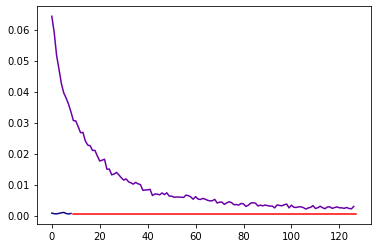

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import mne
mi = np.load('Huron/miHuron_meta_test.npy')
clair = np.load('Clair/clair_meta_test.npy')
erie = np.load('Erie/erie_meta_test.npy')
ont = np.load('Ontario/ontario_meta_test.npy')
sup = np.load('Superior/superior_meta_test.npy')
print(len(mi)-20, len(clair)-20, len(erie)-20, len(ont)-20, len(sup)-20)
mi1 = np.load('Huron/miHuron_lstm_test.npy')
clair1 = np.load('Clair/clair_lstm_test.npy')
erie1 = np.load('Erie/erie_lstm_test.npy')
ont1 = np.load('Ontario/ontario_lstm_test.npy')
sup1 = np.load('Superior/superior_lstm_test.npy')
print(len(mi1)-20, len(clair1)-20, len(erie1)-20, len(ont1)-20, len(sup1)-20)
#ax.plot(mi[:-20], marker = 'o')
a = []
b = []
i = 0
while len(mi)-20 + len(a) < len(mi1):
    b.append(i + len(mi)-19)
    a.append(mi[-21])
    i += 1

import cycler
N = 6
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.plasma(np.linspace(0,1,N)))
c = plt.cycler('color', ['r', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
fig, ax = plt.subplots()
#ax.set_prop_cycle(c)
ax.plot(mi[0:-19])
ax.plot(mi1)
ax.plot(b, a, c = 'r')

array([0.00140738, 0.0014542 , 0.001407  , 0.00133321, 0.00127737,
       0.0012979 , 0.00121781, 0.00127281, 0.00128773, 0.00134491,
       0.00131147, 0.00134615, 0.00129786, 0.00130388, 0.00132759,
       0.00142886, 0.00130372, 0.00139082, 0.00142246, 0.00133431,
       0.00128935, 0.00133065, 0.00143567, 0.00127698, 0.00129129,
       0.00132309, 0.00133376, 0.00139432, 0.00136659, 0.00137895,
       0.00137341, 0.00135185, 0.00139502, 0.00129961, 0.00133027,
       0.00138918, 0.00129577, 0.00144026, 0.00134106, 0.00136239,
       0.00133129, 0.00133255, 0.00136604, 0.0013201 , 0.00132181,
       0.00136804, 0.00134261, 0.0013154 , 0.00120714, 0.00138171,
       0.00138031, 0.00129671, 0.00139524, 0.00126887, 0.00130581,
       0.00128628, 0.00127791, 0.00137487, 0.00127004, 0.00128459,
       0.00144994, 0.0014338 , 0.00144372, 0.00133751, 0.00131197,
       0.00148108, 0.0013383 , 0.00141192, 0.00144881, 0.00132248,
       0.00147221, 0.00122228, 0.00139437, 0.0013702 , 0.00132

In [48]:
mi[-21]

0.00051524566

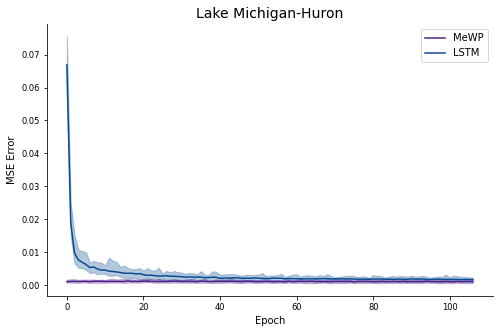

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
mi = np.transpose(np.load('error_miHuron_meta.npy'))
mi1 = np.transpose(np.load('error_miHuron_lstm.npy'))
clair = np.transpose(np.load('error_clair_meta.npy'))
clair1 = np.transpose(np.load('error_clair_lstm.npy'))
erie = np.transpose(np.load('error_erie_meta.npy'))
erie1 = np.transpose(np.load('error_erie_lstm.npy'))
ontario = np.transpose(np.load('error_ontario_meta.npy'))
ontario1 = np.transpose(np.load('error_ontario_lstm.npy'))
superior = np.transpose(np.load('error_superior_meta.npy'))
superior1 = np.transpose(np.load('error_superior_lstm.npy'))
y_l = []
y_m = []
y_u = []
for i in range(len(mi)):
    y_l.append(min(mi[i]))
    y_m.append(sum(mi[i])/len(mi[i]))
    y_u.append(max(mi[i]))
y_l1 = []
y_m1 = []
y_u1 = []
for i in range(len(mi1)):
    y_l1.append(min(mi1[i]))
    y_m1.append(sum(mi1[i])/len(mi1[i]))
    y_u1.append(max(mi1[i]))
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
clr = plt.cm.Purples(0.9)
#ax.set_facecolor(plt.cm.Blues(.2))
ax.set_title("Lake Michigan-Huron", fontsize = 14)
x = range(len(mi))
ax.plot(x, y_m, label = 'MeWP', color = clr)
ax.fill_between(x, y_l, y_u, alpha=0.3, edgecolor=clr, facecolor=clr)
clr = plt.cm.Blues(0.9)
ax.plot(x, y_m1, label = 'LSTM', color = clr)
ax.fill_between(x, y_l1, y_u1, alpha=0.3, edgecolor=clr, facecolor=clr)
ax.set_ylabel('MSE Error', fontsize = 'medium')
ax.set_xlabel('Epoch', fontsize = 'medium')
ax.tick_params(axis='both', labelsize='small')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.show()
#fig.savefig("mihuron_loss.pdf")

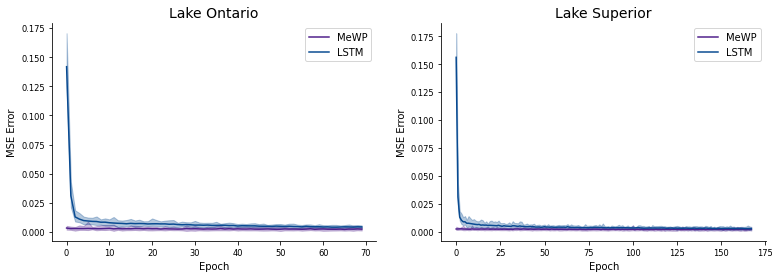

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
fig, ax = plt.subplots(1, 2, figsize = (12.8, 4))
def find_stats(data):
    templ,tempm,tempu = [],[],[]
    for i in range(len(data)):
        templ.append(min(data[i]))
        tempm.append(sum(data[i])/len(data[i]))
        tempu.append(max(data[i]))
    return [templ,tempm,tempu]

def plot(yl, ym, yu, yl1, ym1, yu1, index, x, title):
    global ax
    clr = plt.cm.Purples(0.9)
    #ax.set_facecolor(plt.cm.Blues(.2))
    ax[index].set_title(title, fontsize = 14)
    ax[index].plot(x, ym, label = 'MeWP', color = clr)
    ax[index].fill_between(x, yu, yl, alpha=0.3, edgecolor=clr, facecolor=clr)
    clr = plt.cm.Blues(0.9)
    ax[index].plot(x, ym1, label = 'LSTM', color = clr)
    ax[index].fill_between(x, yu1, yl1, alpha=0.3, edgecolor=clr, facecolor=clr)
    ax[index].set_ylabel('MSE Error', fontsize = 'medium')
    ax[index].set_xlabel('Epoch', fontsize = 'medium')
    ax[index].tick_params(axis='both', labelsize='small')
    ax[index].spines['right'].set_visible(False)
    ax[index].spines['top'].set_visible(False)
    ax[index].legend()
    
mi = np.transpose(np.load('error_miHuron_meta.npy'))
mi1 = np.transpose(np.load('error_miHuron_lstm.npy'))
clair = np.transpose(np.load('error_clair_meta.npy'))
clair1 = np.transpose(np.load('error_clair_lstm.npy'))
erie = np.transpose(np.load('error_erie_meta.npy'))
erie1 = np.transpose(np.load('error_erie_lstm.npy'))
ontario = np.transpose(np.load('error_ontario_meta.npy'))
ontario1 = np.transpose(np.load('error_ontario_lstm.npy'))
superior = np.transpose(np.load('error_superior_meta.npy'))
superior1 = np.transpose(np.load('error_superior_lstm.npy'))
y = []
y.append(find_stats(mi))
y.append(find_stats(mi1))
y.append(find_stats(clair))
y.append(find_stats(clair1))
y.append(find_stats(erie))
y.append(find_stats(erie1))
y.append(find_stats(ontario))
y.append(find_stats(ontario1))
y.append(find_stats(superior))
y.append(find_stats(superior1))
#plot(y[0][0], y[0][1], y[0][2], y[1][0], y[1][1], y[1][2], 0, range(len(mi)), "Lake Michigan-Huron")
#plot(y[2][0], y[2][1], y[2][2], y[3][0], y[3][1], y[3][2], 1, range(len(clair)), "Lake St.Clair")
#plot(y[4][0], y[4][1], y[4][2], y[5][0], y[5][1], y[5][2], 2, range(len(erie)), "Lake Erie")
plot(y[6][0], y[6][1], y[6][2], y[7][0], y[7][1], y[7][2], 0, range(len(ontario)), "Lake Ontario")
plot(y[8][0], y[8][1], y[8][2], y[9][0], y[9][1], y[9][2], 1, range(len(superior)), "Lake Superior")
plt.show()
fig.savefig("two_loss.pdf")

TypeError: only integer scalar arrays can be converted to a scalar index

NameError: name 'df_c' is not defined

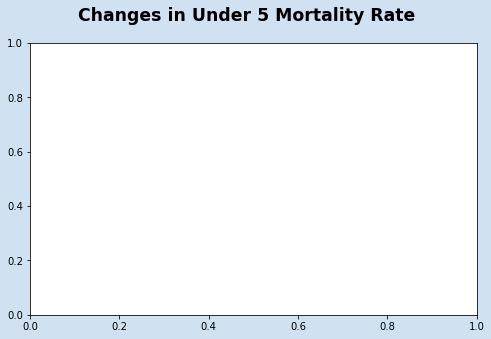

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
mi = np.load('error_miHuron_meta.npy')
mi1 = np.load('error_miHuron_lstm.npy')
df = pd.DataFrame(mi)
def update_axis(ax, df, country):
    clr = plt.cm.Purples(0.9)
    ax.set_facecolor(plt.cm.Blues(.2))
    ax.set_title(country, fontsize = 14, fontweight = 'bold')
    x = df.columns
    y_l = df.loc[(slice(None), 'Lower'), :].iloc[0]
    y_m = df.loc[(slice(None), 'Mean'), :].iloc[0]
    y_u = df.loc[(slice(None), 'Upper'), :].iloc[0]
    ax.plot(x, y_m, label = 'Median', color = clr)
    ax.fill_between(x, y_l, y_u, alpha=0.3, edgecolor=clr, facecolor=clr)
    ax.set_ylabel('Under-five mortality rate', fontsize = 'medium')
    ax.set_xlabel('Year', fontsize = 'medium')
    ax.tick_params(axis='both', labelsize='small')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig, ax1 = plt.subplots(1, 1, figsize = (8, 5), facecolor = plt.cm.Blues(.2))
title = f'Changes in Under 5 Mortality Rate'
fig.suptitle(title, fontsize = 'xx-large',  fontweight = 'bold')
country = 'Nigeria'
update_axis(ax1, df_c, country)

plt.show()

In [34]:
mi1

array([[0.06196362, 0.02158363, 0.00859498, ..., 0.00154687, 0.00145134,
        0.00115687],
       [0.07143015, 0.02210358, 0.01331648, ..., 0.00169861, 0.00121935,
        0.00140506],
       [0.06450281, 0.01583001, 0.00770538, ..., 0.00142351, 0.00228183,
        0.00168648],
       ...,
       [0.06805933, 0.01605945, 0.01148925, ..., 0.00143045, 0.00179181,
        0.00134871],
       [0.06482019, 0.01939515, 0.01041138, ..., 0.00223727, 0.00160741,
        0.00165201],
       [0.05870674, 0.02119586, 0.00944318, ..., 0.00137243, 0.00152235,
        0.00192132]])